# **Libraries**

In [ ]:
!pip install ucimlrepo==0.0.7
!pip install dcor==0.6
!pip uninstall -y scikit-learn
!pip install scikit-learn==1.5.2
!pip install xgboost==2.1.3

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 kB 1.7 MB/s eta 0:00:00
Found existing installation: scikit-learn 1.6.0
Uninstalling scikit-learn-1.6.0:
  Successfully uninstalled scikit-learn-1.6.0
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 95.6 MB/s eta 0:00:00


In [ ]:
# Importing Libraries

## Data import
from ucimlrepo import fetch_ucirepo

## Data manipulation
import numpy as np
import pandas as pd

## Data visualization
import matplotlib.pyplot as plt
import seaborn as sns

## Data preprocessing
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    LabelEncoder,
    OneHotEncoder,
    MinMaxScaler,
  )
from dcor import distance_correlation
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer


## Validation and Hyperparameter tuning
from sklearn.model_selection import (
    KFold,
    StratifiedKFold,
    GridSearchCV,
    RandomizedSearchCV,
    cross_val_score,
    train_test_split
  )


## Models
from sklearn.ensemble import BaggingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import (
    RandomForestClassifier,
    RandomForestRegressor,
    GradientBoostingClassifier,
    HistGradientBoostingClassifier,
    ExtraTreesClassifier,
    ExtraTreesRegressor
  )
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.inspection import permutation_importance


## Performance metrics
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    accuracy_score,
    balanced_accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score
  )

## Scipy functions
from scipy.stats import randint

## Othe imports
import time
import datetime
import warnings
from os import rename
from google.colab import files
# Ignore the UndefinedMetricWarning
warnings.filterwarnings("ignore")
RANDOM_STATE=2024

/usr/local/lib/python3.11/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


# **Base functions**

**Load data**

In [ ]:
def load_data_from_ucimlrepo(repo_id, variable_rename_dict=None):
  # fetch dataset
  dataset = fetch_ucirepo(id=repo_id)

  # metadata
  print(dataset.metadata)

  # variable information
  print(dataset.variables)
  variables_df = dataset.variables
  variables_df['name'] = variables_df['name'].str.lstrip()

  # data (as pandas dataframes)
  df = dataset.data.features

  # Rename columns using the dictionary
  if variable_rename_dict:
    df = df.rename(columns=variable_rename_dict)
    variables_df['name'] = variables_df['name'].map(variable_rename_dict)

  df['Target'] = dataset.data.targets

  # Remove spaces at the beginning of each column name
  df.columns = df.columns.str.lstrip()
  return df, variables_df

**Variable encoding**

In [ ]:
def encode_binary_variables(df, binary_cols, binary_values):
  for col in binary_cols:
      df[col] = df[col].map(binary_values)
  return df

def one_hot_encoding(df, categorical_cols, encoder=None):
  """
  Performs one-hot encoding on specified categorical columns.

  Args:
      df: The input DataFrame.
      categorical_cols: A list of categorical columns to encode
      encoder: if mode 'test', receives here the scaler object to be used

  Returns:
      A DataFrame with the categorical columns one-hot encoded.
  """
  # Initialize encoder
  if encoder is None:  # train mode
    encoder = OneHotEncoder(
        drop='first', sparse_output=False, handle_unknown='ignore'
    )
    # Fit and transform training data
    encoded_df = encoder.fit_transform(df[categorical_cols])
  else:  # test mode
    # Transform test data using same encoding
    encoded_df = encoder.transform(df[categorical_cols])

  # Convert to DataFrame with proper column names
  feature_names = encoder.get_feature_names_out(categorical_cols)
  encoded_df = pd.DataFrame(encoded_df, columns=feature_names, index=df.index)

  non_categorical_cols = [col for col in df.columns if col not in categorical_cols]
  final_df = pd.concat([df[non_categorical_cols], encoded_df], axis=1)
  return final_df, encoder


def map_encoded_variables_to_original(encoded_vars, categorical_vars):
  """
  Creates a dictionary that maps each one-hot encoded variable to its
  original categorical variable.

  Args:
      encoded_vars: A list of one-hot encoded variable names.
      categorical_vars: A list of original categorical variable names.

  Returns:
      A dictionary with one-hot encoded variables as keys and original
      categorical variables as values.
  """
  # dictionary to store the mapping
  one_hot_mapping = {}

  # Iterate through original categorical variables
  for cvar in categorical_vars:
      # Get the one-hot encoded columns derived from this original column
      encoded_cols = [c for c in encoded_vars if c.startswith(cvar + "_")]
      # Map encoded columns to the original column
      for evar in encoded_cols:
          one_hot_mapping[evar] = cvar
  return one_hot_mapping


def map_variables_same_timeline(vars_list, time_identifiers_lst):
  """
  Creates a dictionary that maps each variable to its timeline.
  It will be useful for the feature drop on the testing set due to missing values.

  Args:
      vars_list: list of variable names to be analysed.
      time_identifiers_lst: list of timeline identifiers.

  Returns:
      A dictionary with feature names as keys and their timeline as values.
  """
  # dictionary to store the mapping
  temporal_mapping = {}

  # Assign each chronological variable to its timeline
  for time_id in time_identifiers_lst:
    temporal_cols = [col for col in vars_list if time_id in col]
    for col in temporal_cols:
      temporal_mapping[col] = time_id

  return temporal_mapping

**Feature scaling:**

- In use for SVM and LR algorithms.
- MinMax Scaler chosen due to maintaining binary/ohe variables original values, meanwhile numerical variables get a similar domain of variation. This choice keeps the full interpretability of binary/ohe variables.

In [ ]:
def scale_minmax_features(df, mode, scaler = None):
  """
  Scale features to range [0,1] using MinMaxScaler

  Args:
      df: dataframe with the features to be scaled
      mode: 'train' or 'test'
      scaler: if mode 'test', receives here the scaler object to be used

  Returns:
      df_scaled: scaled features
      scaler: fitted scaler object
  """
  if mode == 'train':
      # Initialize the scaler
    scaler = MinMaxScaler()
    # Fit on training data and transform it
    df_scaled = scaler.fit_transform(df)
  else:
    # Transform test data using the fitted scaler
    df_scaled = scaler.transform(df)

  # Convert back to DataFrames with original column names
  df_scaled = pd.DataFrame(df_scaled, columns=df.columns)

  return df_scaled, scaler

**Data summary and quality**

In [ ]:
def describe_data(df):
  # Dimension
  print("\nData dimension :")
  print("Number of Records : ",df.shape[0],"\nNumber of Features : ", df.shape[1])

  # Datatype of columns
  print("\nDatatype of Features :")
  print(df.dtypes.value_counts())

  # Missing values
  print("\nMissing values :")
  na_value_check = df.isna().sum()
  if len(na_value_check[na_value_check > 0]) == 0 :
      print("Missing values not identified")
  else :
      print(na_value_check[na_value_check > 0])

  # Duplicated records check
  print("\nDuplicated records :")
  duplicate_rows = df.duplicated()
  if len(df[duplicate_rows]) == 0:
      print("Duplicated records not identified")
  else :
      print("Number of duplicated records :",len(df[duplicate_rows]))

  # data summary
  print("\nData summary :")
  print(df.describe())

**Correlation**

In [ ]:
def non_numeric_variables(df, exclude_types):
  # Filter out variables that are not mumeric
  non_numeric_variables = df.select_dtypes(exclude=exclude_types)
  return non_numeric_variables.columns.tolist()

def create_heatmap(matrix, title, center=0, mask=None):
  # Create a heatmap from the matrix provided as input
  f, ax = plt.subplots(figsize=(11, 9))
  cmap = sns.diverging_palette(230, 20, as_cmap=True)
  sns.heatmap(matrix, cmap=cmap, center=center,
              mask=mask, linewidths=.5,
              cbar_kws={"shrink": .5})
  plt.title(title)
  plt.show()

def calculate_correlation(df, corr_method, features='all'):
  # Compute the correlation matrix
  if features == "all":
    corr = df.corr(method=corr_method)
  else :
    corr = df[features].corr()

  # Create a mask to hide the upper triangle of the correlation matrix
  mask = np.triu(np.ones_like(corr, dtype=bool))

  # Generate a heatmap with the correlation matrix
  create_heatmap(corr, title="Correlation matrix", mask=mask)
  return corr

In [ ]:
def calculate_distance_correlation_matrix(df, features='all', debug=False):
    """
    Calculates the distance correlation matrix for a given DataFrame.

    Args:
      df: the input DataFrame
      features: 'all' or a list of the features to be considered
      debug: True / False to control the printing of additional information

    Returns:
      A distance correlation matrix as a pandas DataFrame.
      Produces a heatmap for the distance correlation matrix.
    """

    # Select features
    if features == "all":
        selected_df = df
    else:
        selected_df = df[features]

    print('df columns: ', selected_df.columns)

    # Convert all int64 columns in float64 to avoid errors
    int64_cols = selected_df.select_dtypes(include=['int64']).columns
    selected_df[int64_cols] = df[int64_cols].astype('float64')

    # Initialize distance correlation matrix
    n_features = len(selected_df.columns)
    print('num_features: ', n_features)
    dcor_matrix = pd.DataFrame(
        np.zeros((n_features, n_features)),
        index=selected_df.columns,
        columns=selected_df.columns
    )

    # Calculate distance correlation for each pair
    for i, col1 in enumerate(selected_df.columns):
        if debug: print('col1: ', col1)
        for j, col2 in enumerate(selected_df.columns):
            if debug: print('----- col2: ', col2)
            if i <= j:  # Only calculate upper triangle
                # Convert categorical variables to numeric
                x = pd.Categorical(selected_df[col1]).codes if selected_df[col1].dtype == 'object' else selected_df[col1]
                y = pd.Categorical(selected_df[col2]).codes if selected_df[col2].dtype == 'object' else selected_df[col2]

                # Calculate distance correlation
                dcor = distance_correlation(x, y, method='mergesort')

                dcor_matrix.iloc[i, j] = dcor
                dcor_matrix.iloc[j, i] = dcor  # Matrix is symmetric

    # Create mask for upper triangle
    mask = np.triu(np.ones_like(dcor_matrix, dtype=bool))
    # Create heatmap
    create_heatmap(dcor_matrix, title="Distance Correlation Matrix", mask=mask)
    return dcor_matrix

In [ ]:
def plot_dcor_histogram(dcor_df):
    """
    Reads a distance correlation (dcor) DataFrame and produces a histogram
    of the distance correlations, displaying percentages on the y-axis.
    Also prints the percentage of correlations below different thresholds.

    Args:
      dcor_df : The distance correlation matrix as a pandas DataFrame.

    Returns:
      Histogram plot of the distance corelations between features.
    """

    # Flatten the matrix and exclude diagonal elements for histogram
    flattened_dcor = dcor_df.where(~np.eye(dcor_df.shape[0], dcor_df.shape[1], dtype=bool)).stack()

    # Create histogram with 10 equally spaced bins from 0 to 1.0
    bins = np.linspace(0, 1.0, 11)  # Creates bins with edges at 0, 0.1, ..., 1
    plt.figure(figsize=(8, 6))
    n, bins, patches = plt.hist(flattened_dcor, bins=bins, color='blue', alpha=0.7, edgecolor='black')

    # Convert counts to percentages of total
    total_count = flattened_dcor.count()
    percentage_heights = (n / total_count) * 100  # Multiply by 100 for actual percentage values

    # Set y-axis labels to percentages
    for i in range(len(patches)):
        patches[i].set_height(percentage_heights[i])  # Update patch height
        plt.text(patches[i].get_x() + patches[i].get_width() / 2,
                 percentage_heights[i] + 0.5,  # Add 0.5 for better spacing
                 f'{percentage_heights[i]:.2f}%',  # Display percentage with 2 decimal places
                 ha='center', va='bottom')

    plt.title('Histogram of Distance Correlations (% of Total)')
    plt.xlabel('Distance Correlation')
    plt.ylabel('% of Total Correlations')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.ylim(0, max(percentage_heights) + 5)  # Set y-axis limits slightly above max percentage
    plt.show()

    # Calculate and print percentage of correlations below different thresholds
    for i in np.arange(0.1, 1.1, 0.1):  # From 0.1 to 1.0 in steps of 0.1
        percentage_below = (flattened_dcor[flattened_dcor <= i].count() / total_count) * 100
        print(f"Percentage of correlations below {i:.1f}: {percentage_below:.2f}%")

**Pre-feature selection**

In [ ]:
def identify_zero_variance_columns(df):
  # Calculate the variance of each column
  variances = df.var()
  print("Variance of each column:")
  print(variances)

  # Identify columns with zero variance
  zero_variance_columns = variances[variances <= 1.00e-10].index.tolist()
  print("Columns with zero variance to be dropped:")
  print(zero_variance_columns)
  return zero_variance_columns


def identify_weak_associated_features(association_matrix, target_variable, threshold=0.1):
  """
  Identifies features with a weak association with the target variable.

  Args:
    association_matrix: usually a correlation matrix as dataframe
    target_variable: The name of the target variable column.
    threshold: value for which correlations below are considered weak

  Returns:
    A list of feature names that have a association with the target variable
    lower than the threshold.
  """
  target_association = association_matrix[target_variable]
  weak_associated_features = target_association[
      abs(target_association) < threshold
  ].index.tolist()
  print("Features with weak association with the target variable:")
  print(weak_associated_features)
  return weak_associated_features


def filter_out_intercorrelated_features(corr_df, target_name, correlation_threshold=0.8):
  """
  Filters highly correlated features based on a distance correlation matrix.

  Args:
      corr_df: Dataframe with the correlation matrix
      target_name: Name of the column with the target
      correlation_threshold: The threshold for correlation above which features
                             are considered highly correlated.

  Returns:
      A list of features after dropping of intercorrelated
  """

  # get a list with the features sorted by correlation with target
  target_correlations = corr_df[target_name].sort_values(ascending=False)
  sorted_correlated_feat_with_target = [feat for feat in target_correlations.index if feat != target_name]

  selected_features = []
  eliminated_features = []

  # Iterate through features, starting with the most correlated to the target
  for feat in sorted_correlated_feat_with_target:
      if feat not in eliminated_features:  # If not already eliminated
          selected_features.append(feat)
          print('appended feature: ', feat)

          # Eliminate other features highly correlated with the current feature
          for other_feat in sorted_correlated_feat_with_target:
              if other_feat != feat and other_feat not in eliminated_features:
                  correlation = corr_df[corr_df.index==feat][other_feat][0]
                  if abs(correlation) > correlation_threshold:
                      eliminated_features.append(other_feat)
                      print('eliminated feature: ', other_feat, correlation)
  return selected_features

**Missing values handling**

**Simple imputation (median and mode):** Missing values will be inputed with the median for numerical variables and with the model for binary/ohe variables. This choice guarantees that the value inputed is a value that makes sense for the domain of each variable and also avoid the influence of outliers or long-tailed distributions.

**Imputation via MissForest:** The missing values are inputed via an ensemble model that makes use of all other features available at the moment. Note that for this use case a new MissForest algorithm has to be run at each scenario, because the features available will change. Otherwise there will be unfair data leakage. The implementation used for MissForest uses ExtraTrees instead of Random Forests in accordance with the suggestion from Scikit Learn as present in: https://scikit-learn.org/0.21/auto_examples/impute/plot_iterative_imputer_variants_comparison.html

Note: In the case of models that require feature scaling (normalization), the simple inputation will be based on the median and mode of features after scaling.

In [ ]:
def calculate_imputation_values_for_missing(df):
  """
  Calculates the median for numeric columns and mode for non-numeric columns in a DataFrame.

  Args:
    df: The pandas DataFrame.

  Returns:
    A dictionary with column names as keys and their median/mode as values.
  """
  imputation_dict = dict()
  for column in df.columns:
    if pd.api.types.is_numeric_dtype(df[column]):
      imputation_dict[column] = df[column].median()
    else:
      imputation_dict[column] = df[column].mode()[0] if not df[column].mode().empty else None
  return imputation_dict


def imputation_missforest(train_df, test_df, cat_vars_list=[]):
  """
  Auxiliary function for Performance Decay
  Imputes missing values in the testing datasets using the MissForest algorithm.

  Args:
    train_df / test_df: DataFrame with training/test data
    cat_vars_list: list of categorical variables for imputation

  Returns:
    test_df_imputed: DataFrame with imputed missing values by MissForest
  """
  # check of the nr of columsn with nan
  nan_counts_per_column = test_df.isnull().any()
  num_columns_with_nan = nan_counts_per_column.sum()
  print('Nr. columns with nan: ', num_columns_with_nan)
  columns_with_nulls = test_df.columns[test_df.isnull().any()].tolist()

  # identify categorical and numerical features
  categorical = cat_vars_list
  numerical = [col for col in test_df.columns if col not in categorical and col!='Type']
  print('Numerical columns: ', numerical)
  print('Categorical columns: ', categorical)

  train_df['Type'] = 'Train'
  test_df['Type'] = 'Test'
  df = pd.concat([train_df, test_df], axis=0, ignore_index=True)
  df_imputation = df.drop(columns=['Type'])
  """
  # missforest with random forests

  imp_num = IterativeImputer(estimator=RandomForestRegressor(n_jobs=-1, random_state=RANDOM_STATE),
                              initial_strategy='median',
                              max_iter=1, random_state=RANDOM_STATE)
  imp_cat = IterativeImputer(estimator=RandomForestClassifier(n_jobs=-1, random_state=RANDOM_STATE),
                              initial_strategy='most_frequent',
                              max_iter=1, random_state=RANDOM_STATE)
  """

  # missforest with extra trees (faster and with similar performance)
  imp_num = IterativeImputer(estimator=ExtraTreesRegressor(
                              max_features='sqrt',
                              n_jobs=-1,
                              random_state=RANDOM_STATE),
                              initial_strategy='median',
                              max_iter=1, random_state=RANDOM_STATE)
  imp_cat = IterativeImputer(estimator=ExtraTreesClassifier(
                              n_jobs=-1,
                              random_state=RANDOM_STATE),
                              initial_strategy='most_frequent',
                              max_iter=1, random_state=RANDOM_STATE)

  if len(numerical)>0:
    df_imputation[numerical] = imp_num.fit_transform(df_imputation[numerical])

  if len(categorical)>0:
    df_imputation[categorical] = imp_cat.fit_transform(df_imputation[categorical])

  # test_df_imputed and auxiliary info to be displayed along the imputation
  test_df_imputed = df_imputation[df['Type']=='Test']
  for col in columns_with_nulls:
    print('Column imputed: ', col)
    if col in numerical:
      print('Mean: ', test_df_imputed[col].mean())
      print('Std deviation: ', test_df_imputed[col].std())
    else:
      print(test_df_imputed[col].value_counts())
  return test_df_imputed

**Model training / Feature permutation importance / Hyperparameter optimization**

In [ ]:
def apply_model(model, X_train, y_train, X_test, y_test):
  # Fit the model
  model.fit(X_train, y_train)
  y_train_pred = model.predict(X_train)
  y_test_pred = model.predict(X_test)

  return model, y_train_pred, y_test_pred


def analyze_feat_permut_import(
    model, X, y, scoring_metric, n_repeats=5, random_state=RANDOM_STATE
):
    # Calculate permutation importance
    result = permutation_importance(
        model, X, y, scoring=scoring_metric, n_repeats=n_repeats,
        random_state=random_state, n_jobs=-1
    )

    # Create DataFrame with results
    importance_df = pd.DataFrame({
        'Feature': X.columns,
        'Importance': result.importances_mean,
        'Std': result.importances_std
    }).sort_values(by='Importance', ascending=True)

    return importance_df.sort_values(by='Importance', ascending=False)


def plot_feat_permut_importance(feat_imp_df, threshold=0, k=20):
  # Filter features with importance above the threshold
  feat_imp_plot = feat_imp_df[feat_imp_df['Importance'] > threshold]
  feat_imp_plot = feat_imp_plot.sort_values(by='Importance', ascending=False)

  # select the top k features
  if len(feat_imp_plot) > k:
    feat_imp_plot = feat_imp_plot.head(k)

  # Create a bar chart
  plt.figure(figsize=(10, 6))
  plt.barh(feat_imp_plot['Feature'], feat_imp_plot['Importance'])
  plt.xlabel('Importance')
  plt.ylabel('Feature')
  plt.title('Feature Permutation Importance')
  plt.gca().invert_yaxis()  # Display the highest importance at the top
  plt.show()


def plot_feature_importance(model, importance_threshold, col_names):
  if model.__class__.__name__ == 'LGBMClassifier':
    feature_importances = model.booster_.feature_importance(importance_type='split')
  else:
    feature_importances = model.feature_importances_

  # Create a DataFrame with feature names and importances
  feature_importance_df = pd.DataFrame({'Feature': col_names, 'Importance': feature_importances})

  # Sort features by importance in descending order
  feature_importance_df = feature_importance_df.sort_values('Importance', ascending=False)

  # Filter features with importance above the threshold
  feature_importance_plot = feature_importance_df[feature_importance_df['Importance'] >= importance_threshold]
  if len(feature_importance_plot) > 20:
    feature_importance_plot = feature_importance_plot.head(20)

  # Create a bar chart
  plt.figure(figsize=(10, 6))
  plt.barh(feature_importance_plot['Feature'], feature_importance_plot['Importance'])
  plt.xlabel('Importance')
  plt.ylabel('Feature')
  plt.title('Feature Importance')
  plt.gca().invert_yaxis()  # Display the highest importance at the top
  plt.show()
  return feature_importance_df


def hyperparameter_tuning(model, param_grid, k_hyp_par, k_cv, scoring_metric, X, y):
    """
    Performs hyperparameter tuning using nested cross-validation.

    Args:
        model: The base model to be tuned.
        param_grid: A dictionary containing the hyperparameter grid.
        k_hyp_par: The number of folds for the inner cross-validation.
        k_cv: The number of folds for the outer cross-validation.
        scoring_metric: The scoring metric to be used for evaluation.
        X: The feature matrix.
        y: The target variable.

    Returns:
        A tuple containing the fitted GridSearchCV object, nested scores, and best parameters.
    """
    # Time control
    start_time = time.time()
    print(f"Starting hyperparameter tuning at: {datetime.datetime.now()}")

    # Cross-validation strategies for inner and outer loops
    cv_inner = StratifiedKFold(n_splits=k_hyp_par, shuffle=True, random_state=RANDOM_STATE)
    cv_outer = StratifiedKFold(n_splits=k_cv, shuffle=True, random_state=RANDOM_STATE)

    # Hyperparameter tuning
    grid_search = GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        cv=cv_inner,
        scoring=scoring_metric,
        verbose=3,
        n_jobs=-1,
        return_train_score=True,  # To help diagnose overfitting/underfitting
        refit=True
    )

    # Perform nested cross-validation
    nested_scores = cross_val_score(
        grid_search,
        X=X,
        y=y,
        cv=cv_outer,
        scoring=scoring_metric,
        n_jobs=-1
    )

    # Print cross-validation results
    print("\nNested Cross-validation Results:")
    print(f"Individual scores: {nested_scores}")
    print(f"Average nested CV score: {nested_scores.mean():.3f} (+/- {nested_scores.std() * 2:.3f})")

    # Fit the model on the entire dataset
    print("\nFitting final model on entire dataset...")
    grid_search.fit(X, y)

    # Get best parameters and scores
    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_
    print(f"Best parameters: {best_params}")
    cv_results = pd.DataFrame(grid_search.cv_results_)

    print("\nBest Model Performance:")
    print(f"Best CV score: {grid_search.best_score_:.3f}")

    # Print execution time
    print(datetime.datetime.now())
    end_time = time.time()
    execution_time = (end_time - start_time) / 60
    print(f"\nExecution time: {execution_time:.2f} minutes")

    return grid_search, best_model, best_params

**Performance**

In [ ]:
# Calculation of performance metrics
def perf_metrics(y_true, y_pred_binary):
    """
    Returns a dictionary with the values of the main metrics
    """
    # Calculate Specificity using confusion matrix
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred_binary).ravel()
    specificity = tn / (tn + fp)

    # Calculate metrics
    accuracy = accuracy_score(y_true, y_pred_binary)
    balanced_accuracy = balanced_accuracy_score(y_true, y_pred_binary)
    precision = precision_score(y_true, y_pred_binary,average='binary')
    recall = recall_score(y_true, y_pred_binary,average='binary')
    f1 = f1_score(y_true, y_pred_binary,average='binary')

    # Create dictionary to store metrics
    metrics_dict = {
        'tp': tp,
        'tn': tn,
        'fp': fp,
        'fn': fn,
        'precision': round(precision*100,2),
        'recall': round(recall*100,2),
        'specificity': round(specificity*100,2),
        'accuracy': round(accuracy*100,2),
        'f1_score': round(f1*100,2),
        'balanced_accuracy' : round(balanced_accuracy*100,2)
    }

    return metrics_dict


def measure_performance_decline(
  X_train, X_test, y_test, model, feat_importance_df, imputation_dict=None, num_feat=25,
  method='simple', encoded_vars_family=None, categorical_vars=[], log_info=False
):
  """
  Simulates the feature disruption events by decreasing order of feature
  permutation importance and imputs missing values in accordance with the method
  chosen. In the case of ohe features, it disrupts simultaneously all ohe
  features generated from the same original feature.
  Re-evaluated the performance of the model in the imputed test set.

  Args:
    imputation_dict: mandatory if nethod='simple', and for each feature (key)
                     has the value to be imputed (median / mode)
    num_feat: max number of original features to be disrupted
    method: imputation method 'simple' or 'missforest'
    encoded_vars_family: dict with ohe features (keys) and their original
                         features (values)

  Returns:
    Dataframe with performance metrics evolution for each disruption event
  """

  # validation of the inputs
  if method not in ['simple', 'missforest']:
    raise ValueError("method must be 'simple' or 'missforest'")

  # if method == 'simple' then inputation_dict must be provided
  if method == 'simple' and imputation_dict is None:
    raise ValueError("imputation_dict must be provided for method 'simple'")

  # list of features ordered by feature importance
  feat_importance_df = (
      feat_importance_df.sort_values('Importance', ascending=False)
  )
  features_importance_list = feat_importance_df['Feature'].to_list()

  # to not affect X_train and X_test outside of the function
  # X_train will be only used in MissForest
  X_train_new = X_train.copy()
  X_test_new = X_test.copy()
  test_pred = model.predict(X_test_new)

  df_perf = pd.DataFrame.from_dict([perf_metrics(np.array(y_test.astype(int)),np.array(test_pred.astype(int)))])
  df_perf['num_feat_missing'] = [0]
  df_perf['imputed'] = ['']

  removed = list()  # store all the features (includes the ohe)
  original_removed = list()  # store only the original features removed
  i=0
  while len(original_removed)<num_feat and i <= len(features_importance_list):
    print('')
    print('--- NEW ITERATION ---')
    if features_importance_list[i] in removed:
      i = i+1
      continue
    current_feature = features_importance_list[i]
    print("Removing feature: ", current_feature)
    if encoded_vars_family is not None:
      # all the ohe variables derived from the original category should be set to missing
      if current_feature in encoded_vars_family.keys():
        original_feature = encoded_vars_family[current_feature]
        related_features = [k for k,v in encoded_vars_family.items() if v == original_feature]
        # related features that are still in the model (e.g. logistic regression does not have all feat)
        related_features = [feat for feat in related_features if feat in X_test.columns]
        print("Removing related features: ", related_features)
        removed.extend(related_features)
        original_removed.extend([original_feature])
        for feature in related_features:
          if method == 'simple':
            X_test_new[feature] = imputation_dict[feature]
      else:
        removed.extend([current_feature])
        original_removed.extend([current_feature])
        if method == 'simple':
          X_test_new[current_feature] = imputation_dict[current_feature]
    else:
      removed.extend([current_feature])
      original_removed.extend([current_feature])
      if method == 'simple':
        X_test_new[current_feature] = imputation_dict[current_feature]

    if log_info and method=='simple':
      variances = X_test_new.var(numeric_only=True) # Calculate variance for numerical columns
      variance_df = pd.DataFrame({'feature': variances.index, 'variance': variances.values})
      print("Variance of each column:")
      print(variance_df[variance_df['variance']<1e-10])

    # model predictions with inputed data
    # if missforest, then the nan values must be inputed here before applying the model
    if method == 'missforest':
      for col in removed:
        X_test_new[col] = np.nan
      X_test_new = imputation_missforest(X_train_new, X_test_new, categorical_vars)
    test_pred = model.predict(X_test_new)
    new_row = pd.DataFrame.from_dict([perf_metrics(np.array(y_test.astype(int)),np.array(test_pred.astype(int)))])
    feat_removed = len(original_removed)
    print('Original feat removed so far: ', original_removed)
    new_row['num_feat_missing'] = feat_removed
    new_row['imputed'] = f'{removed} imputed'
    df_perf = pd.concat([df_perf, new_row], ignore_index=True)
    i=i+1
  return df_perf, original_removed, removed


def measure_temporal_performance_decline(
  X_train, X_test, y_test, model, feat_importance_df, temporal_vars_family,
  imputation_dict=None, num_feat=25, method='simple', encoded_vars_family=None,
  categorical_vars=[], log_info=False
):
  """
  Simulates the feature disruption events by decreasing order of feature
  permutation importance and imputs missing values in accordance with the method
  chosen. In the case of ohe features, it disrupts simultaneously all ohe
  features generated from the same original feature.
  Re-evaluated the performance of the model in the imputed test set.

  Args:
    imputation_dict: mandatory if nethod='simple', and for each feature (key)
                     has the value to be imputed (median / mode)
    num_feat: max number of original features to be disrupted
    method: imputation method 'simple' or 'missforest'
    encoded_vars_family: dict with ohe features (keys) and their original
                         features (values)

  Returns:
    Dataframe with performance metrics evolution for each disruption event
  """
  # validation of the inputs
  if method not in ['simple', 'missforest']:
    raise ValueError("method must be 'simple' or 'missforest'")

  # if method == 'simple' then inputation_dict must be provided
  if method == 'simple' and imputation_dict is None:
    raise ValueError("imputation_dict must be provided for method 'simple'")

  # list of features ordered by feature importance
  feat_importance_df = (
      feat_importance_df.sort_values('Importance', ascending=False)
  )
  features_importance_list = feat_importance_df['Feature'].to_list()

  # to not affect X_train and X_test outside of the function
  # X_train will be only used in MissForest
  X_train_new = X_train.copy()
  X_test_new = X_test.copy()
  test_pred = model.predict(X_test_new)

  df_perf = pd.DataFrame.from_dict([perf_metrics(np.array(y_test.astype(int)),np.array(test_pred.astype(int)))])
  df_perf['num_feat_missing'] = [0]
  df_perf['imputed'] = ['']

  removed = list()  # store all the features (includes the ohe)
  original_removed = list()  # store only the original features removed
  i=0
  while len(original_removed)<num_feat and i <= len(features_importance_list):
    print('')
    print('--- NEW ITERATION ---')
    print('original removed: ', original_removed)
    print('length original removed: ', len(original_removed))
    print('num feat: ', num_feat)
    print('i: ', i)
    print('length features importance list: ', len(features_importance_list))
    print('length removed: ', len(removed))
    print('')

    if features_importance_list[i] in removed:
      print('Feature already removed: ', features_importance_list[i])
      i = i+1
      continue
    focus_feature = features_importance_list[i]
    print("Removing feature: ", focus_feature)

    if focus_feature in temporal_vars_family.keys():
      timeline = temporal_vars_family[focus_feature]
      related_temporal_features = [k for k,v in temporal_vars_family.items() if v == timeline and k in X_test.columns]
      related_temporal_features = [feat for feat in related_temporal_features if feat not in removed]
    else:
      related_temporal_features = [focus_feature]

    for current_feature in related_temporal_features:
      print('Removing related temporal feature: ', current_feature)
      if encoded_vars_family is not None:
        # all the ohe variables derived from the original category should be set to missing
        if current_feature in encoded_vars_family.keys():
          original_feature = encoded_vars_family[current_feature]
          related_features = [k for k,v in encoded_vars_family.items() if v == original_feature and k in X_test.columns]
          # related features that are still in the model (e.g. logistic regression does not have all feat)
          related_features = [feat for feat in related_features if feat not in removed]
          print("Removing related features: ", related_features)
          removed.extend(related_features)
          original_removed.extend([original_feature])
          for feature in related_features:
            if method == 'simple':
              X_test_new[feature] = imputation_dict[feature]
        else:
          removed.extend([current_feature])
          original_removed.extend([current_feature])
          if method == 'simple':
            X_test_new[current_feature] = imputation_dict[current_feature]
      else:
        removed.extend([current_feature])
        original_removed.extend([current_feature])
        if method == 'simple':
          X_test_new[current_feature] = imputation_dict[current_feature]

    if log_info and method=='simple':
      variances = X_test_new.var(numeric_only=True) # Calculate variance for numerical columns
      variance_df = pd.DataFrame({'feature': variances.index, 'variance': variances.values})
      print("Columns with zero variance, i.e. imputed:")
      print(variance_df[variance_df['variance']<1e-10])

    # model predictions with inputed data
    # if missforest, then the nan values must be inputed here before applying the model
    if method == 'missforest':
      for col in removed:
        X_test_new[col] = np.nan
      X_test_new = imputation_missforest(X_train_new, X_test_new, categorical_vars)
    test_pred = model.predict(X_test_new)
    new_row = pd.DataFrame.from_dict([perf_metrics(np.array(y_test.astype(int)),np.array(test_pred.astype(int)))])
    original_removed = list(set(original_removed))
    feat_removed = len(original_removed)
    print('Original feat removed so far: ', original_removed)
    new_row['num_feat_missing'] = feat_removed
    new_row['imputed'] = f'{removed} imputed'
    df_perf = pd.concat([df_perf, new_row], ignore_index=True)
    i=i+1
  return df_perf, original_removed, removed

**Save results**

In [ ]:
def combine_datasets(datasets, source_name, scenario_name, seed):
  """Combines multiple datasets with the same schema into a single DataFrame.

  Args:
    datasets: A dictionary of pandas DataFrames.
    source_name: A string representing the name of the dataset source.
    scenario_name: A string representing the name of the experiment.

  Returns:
    A pandas DataFrame containing all datasets combined, with new columns
    indicating the source dataset and the experiment name.
  """

  combined_df = pd.DataFrame()
  for name, df in datasets.items():
      df['dataset'] = name
      df['source'] = source_name
      df['scenario'] = scenario_name
      df['random_state'] = seed
      if '2' in name:
        df['metric'] = 'balanced accuracy'
      else:
        df['metric'] = 'f1 score'
      combined_df = pd.concat([combined_df, df], ignore_index=True)
  return combined_df

def save_dataset(df, dataset_name):
  df.to_csv(dataset_name, encoding = 'utf-8-sig')
  files.download(dataset_name)

# **Load data**

In [ ]:
variable_rename = {
    'ID': 'ID',
    'X1': 'LIMIT_BAL',
    'X2': 'SEX',
    'X3': 'EDUCATION',
    'X4': 'MARRIAGE',
    'X5': 'AGE',
    'X6': 'PAY_STATUS_1M_AGO',
    'X7': 'PAY_STATUS_2M_AGO',
    'X8': 'PAY_STATUS_3M_AGO',
    'X9': 'PAY_STATUS_4M_AGO',
    'X10': 'PAY_STATUS_5M_AGO',
    'X11': 'PAY_STATUS_6M_AGO',
    'X12': 'BILL_AMT_1M_AGO',
    'X13': 'BILL_AMT_2M_AGO',
    'X14': 'BILL_AMT_3M_AGO',
    'X15': 'BILL_AMT_4M_AGO',
    'X16': 'BILL_AMT_5M_AGO',
    'X17': 'BILL_AMT_6M_AGO',
    'X18': 'PAY_AMT_1M_AGO',
    'X19': 'PAY_AMT_2M_AGO',
    'X20': 'PAY_AMT_3M_AGO',
    'X21': 'PAY_AMT_4M_AGO',
    'X22': 'PAY_AMT_5M_AGO',
    'X23': 'PAY_AMT_6M_AGO',
    'Y': 'Target'
}

default_cc, default_cc_variables = load_data_from_ucimlrepo(350, variable_rename_dict=variable_rename)

{'uci_id': 350, 'name': 'Default of Credit Card Clients', 'repository_url': 'https://archive.ics.uci.edu/dataset/350/default+of+credit+card+clients', 'data_url': 'https://archive.ics.uci.edu/static/public/350/data.csv', 'abstract': "This research aimed at the case of customers' default payments in Taiwan and compares the predictive accuracy of probability of default among six data mining methods.", 'area': 'Business', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 30000, 'num_features': 23, 'feature_types': ['Integer', 'Real'], 'demographics': ['Sex', 'Education Level', 'Marital Status', 'Age'], 'target_col': ['Y'], 'index_col': ['ID'], 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 2009, 'last_updated': 'Fri Mar 29 2024', 'dataset_doi': '10.24432/C55S3H', 'creators': ['I-Cheng Yeh'], 'intro_paper': {'ID': 365, 'type': 'NATIVE', 'title': 'The comparisons of data mining techniques for the predictive accuracy of 

In [ ]:
default_cc.head()

LIMIT_BAL  SEX  EDUCATION  MARRIAGE  AGE  PAY_STATUS_1M_AGO  \
0      20000    2          2         1   24                  2   
1     120000    2          2         2   26                 -1   
2      90000    2          2         2   34                  0   
3      50000    2          2         1   37                  0   
4      50000    1          2         1   57                 -1   

   PAY_STATUS_2M_AGO  PAY_STATUS_3M_AGO  PAY_STATUS_4M_AGO  PAY_STATUS_5M_AGO  \
0                  2                 -1                 -1                 -2   
1                  2                  0                  0                  0   
2                  0                  0                  0                  0   
3                  0                  0                  0                  0   
4                  0                 -1                  0                  0   

   ...  BILL_AMT_4M_AGO  BILL_AMT_5M_AGO  BILL_AMT_6M_AGO  PAY_AMT_1M_AGO  \
0  ...                0                0                0               0   
1  ...             3272             3455             3261               0   
2  ...            14331            14948            15549            1518   
3  ...            28314            28959            29547            2000   
4  ...            20940            19146            19131            2000   

   PAY_AMT_2M_AGO  PAY_AMT_3M_AGO  PAY_AMT_4M_AGO  PAY_AMT_5M_AGO  \
0             689               0               0               0   
1            1000            1000            1000               0   
2            1500            1000            1000            1000   
3            2019            1200            1100            1069   
4           36681           10000            9000             689   

   PAY_AMT_6M_AGO  Target  
0               0       1  
1            2000       1  
2            5000       0  
3            1000       0  
4             679       0  

[5 rows x 24 columns]

In [ ]:
default_cc_variables

name     role     type      demographic  \
0                  ID       ID  Integer             None   
1           LIMIT_BAL  Feature  Integer             None   
2                 SEX  Feature  Integer              Sex   
3           EDUCATION  Feature  Integer  Education Level   
4            MARRIAGE  Feature  Integer   Marital Status   
5                 AGE  Feature  Integer              Age   
6   PAY_STATUS_1M_AGO  Feature  Integer             None   
7   PAY_STATUS_2M_AGO  Feature  Integer             None   
8   PAY_STATUS_3M_AGO  Feature  Integer             None   
9   PAY_STATUS_4M_AGO  Feature  Integer             None   
10  PAY_STATUS_5M_AGO  Feature  Integer             None   
11  PAY_STATUS_6M_AGO  Feature  Integer             None   
12    BILL_AMT_1M_AGO  Feature  Integer             None   
13    BILL_AMT_2M_AGO  Feature  Integer             None   
14    BILL_AMT_3M_AGO  Feature  Integer             None   
15    BILL_AMT_4M_AGO  Feature  Integer             None   
16    BILL_AMT_5M_AGO  Feature  Integer             None   
17    BILL_AMT_6M_AGO  Feature  Integer             None   
18     PAY_AMT_1M_AGO  Feature  Integer             None   
19     PAY_AMT_2M_AGO  Feature  Integer             None   
20     PAY_AMT_3M_AGO  Feature  Integer             None   
21     PAY_AMT_4M_AGO  Feature  Integer             None   
22     PAY_AMT_5M_AGO  Feature  Integer             None   
23     PAY_AMT_6M_AGO  Feature  Integer             None   
24             Target   Target   Binary             None   

                   description units missing_values  
0                         None  None             no  
1                    LIMIT_BAL  None             no  
2                          SEX  None             no  
3                    EDUCATION  None             no  
4                     MARRIAGE  None             no  
5                          AGE  None             no  
6                        PAY_0  None             no  
7                        PAY_2  None             no  
8                        PAY_3  None             no  
9                        PAY_4  None             no  
10                       PAY_5  None             no  
11                       PAY_6  None             no  
12                   BILL_AMT1  None             no  
13                   BILL_AMT2  None             no  
14                   BILL_AMT3  None             no  
15                   BILL_AMT4  None             no  
16                   BILL_AMT5  None             no  
17                   BILL_AMT6  None             no  
18                    PAY_AMT1  None             no  
19                    PAY_AMT2  None             no  
20                    PAY_AMT3  None             no  
21                    PAY_AMT4  None             no  
22                    PAY_AMT5  None             no  
23                    PAY_AMT6  None             no  
24  default payment next month  None             no

In [ ]:
default_cc.columns

Index(['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_STATUS_1M_AGO',
       'PAY_STATUS_2M_AGO', 'PAY_STATUS_3M_AGO', 'PAY_STATUS_4M_AGO',
       'PAY_STATUS_5M_AGO', 'PAY_STATUS_6M_AGO', 'BILL_AMT_1M_AGO',
       'BILL_AMT_2M_AGO', 'BILL_AMT_3M_AGO', 'BILL_AMT_4M_AGO',
       'BILL_AMT_5M_AGO', 'BILL_AMT_6M_AGO', 'PAY_AMT_1M_AGO',
       'PAY_AMT_2M_AGO', 'PAY_AMT_3M_AGO', 'PAY_AMT_4M_AGO', 'PAY_AMT_5M_AGO',
       'PAY_AMT_6M_AGO', 'Target'],
      dtype='object')

## Make feature names and feature values more human-interpretable

The dataset present categories that have no explanation in the original presentation of the dataset. After some research, it was possible to find additional explanation from the authors for these categories, which will be adopted.

- Original definition of the data: https://www.semanticscholar.org/paper/The-comparisons-of-data-mining-techniques-for-the-Yeh-Lien/1cacac4f0ea9fdff3cd88c151c94115a9fddcf33
- Additional explanation of the categories: https://www.kaggle.com/datasets/uciml/default-of-credit-card-clients-dataset/discussion/34608

In [ ]:
# Dictionaries for each categorical attribute
SEX = {
    1: 'male',
    2: 'female',
}

EDUCATION = {
    0: 'others',
    1: 'graduate school',
    2: 'university',
    3: 'high school',
    4: 'others',
    5: 'others',
    6: 'others'
}

MARRIAGE = {
    0: 'others',
    1: 'married',
    2: 'single',
    3: 'divorced'
}

PAY_STATUS = {
    -2: 'no consumption',
    -1: 'paid fully',
    0: 'revolving credit used'
}

# Dictionary mapping attributes to their respective mapping dictionaries
attribute_mappings = {
    'SEX': SEX,
    'EDUCATION': EDUCATION,
    'MARRIAGE': MARRIAGE,
    'PAY_STATUS_1M_AGO': PAY_STATUS,
    'PAY_STATUS_2M_AGO': PAY_STATUS,
    'PAY_STATUS_3M_AGO': PAY_STATUS,
    'PAY_STATUS_4M_AGO': PAY_STATUS,
    'PAY_STATUS_5M_AGO': PAY_STATUS,
    'PAY_STATUS_6M_AGO': PAY_STATUS
}

# Apply the mappings to the DataFrame:
for column, mapping in attribute_mappings.items():
    default_cc[column] = default_cc[column].map(lambda x: mapping.get(x, x))

default_cc.head()

LIMIT_BAL     SEX   EDUCATION MARRIAGE  AGE      PAY_STATUS_1M_AGO  \
0      20000  female  university  married   24                      2   
1     120000  female  university   single   26             paid fully   
2      90000  female  university   single   34  revolving credit used   
3      50000  female  university  married   37  revolving credit used   
4      50000    male  university  married   57             paid fully   

       PAY_STATUS_2M_AGO      PAY_STATUS_3M_AGO      PAY_STATUS_4M_AGO  \
0                      2             paid fully             paid fully   
1                      2  revolving credit used  revolving credit used   
2  revolving credit used  revolving credit used  revolving credit used   
3  revolving credit used  revolving credit used  revolving credit used   
4  revolving credit used             paid fully  revolving credit used   

       PAY_STATUS_5M_AGO  ... BILL_AMT_4M_AGO  BILL_AMT_5M_AGO  \
0         no consumption  ...               0                0   
1  revolving credit used  ...            3272             3455   
2  revolving credit used  ...           14331            14948   
3  revolving credit used  ...           28314            28959   
4  revolving credit used  ...           20940            19146   

   BILL_AMT_6M_AGO  PAY_AMT_1M_AGO  PAY_AMT_2M_AGO  PAY_AMT_3M_AGO  \
0                0               0             689               0   
1             3261               0            1000            1000   
2            15549            1518            1500            1000   
3            29547            2000            2019            1200   
4            19131            2000           36681           10000   

   PAY_AMT_4M_AGO  PAY_AMT_5M_AGO  PAY_AMT_6M_AGO  Target  
0               0               0               0       1  
1            1000               0            2000       1  
2            1000            1000            5000       0  
3            1100            1069            1000       0  
4            9000             689             679       0  

[5 rows x 24 columns]

## Feature engineering

The features PAY_STATUS_xM_AGO have a different meaning if their value is a number (i.e. nr of months of delay in the payment) or if the value is a text (no delay in the payment).

So each PAY_STATUS_xM_AGO will result in two features:
- PAY_STATUS_xM_AGO: 'no consumption', 'paid fully', 'revolving credit used', 'payment overdue'
- PAY_DELAY_xM_AGO: 1, 2, ..., 9

In [ ]:
for col in default_cc.columns:
  if col.startswith('PAY_STATUS'):
    new_colname = col.replace('STATUS', 'DELAY')
    default_cc[new_colname] = default_cc[col].apply(lambda x: x if isinstance(x, (int, float)) else 0)
    default_cc[col] = default_cc[col].apply(lambda x: 'payment overdue' if isinstance(x, (int, float)) else x)

default_cc

LIMIT_BAL     SEX    EDUCATION MARRIAGE  AGE      PAY_STATUS_1M_AGO  \
0          20000  female   university  married   24        payment overdue   
1         120000  female   university   single   26             paid fully   
2          90000  female   university   single   34  revolving credit used   
3          50000  female   university  married   37  revolving credit used   
4          50000    male   university  married   57             paid fully   
...          ...     ...          ...      ...  ...                    ...   
29995     220000    male  high school  married   39  revolving credit used   
29996     150000    male  high school   single   43             paid fully   
29997      30000    male   university   single   37        payment overdue   
29998      80000    male  high school  married   41        payment overdue   
29999      50000    male   university  married   46  revolving credit used   

           PAY_STATUS_2M_AGO      PAY_STATUS_3M_AGO      PAY_STATUS_4M_AGO  \
0            payment overdue             paid fully             paid fully   
1            payment overdue  revolving credit used  revolving credit used   
2      revolving credit used  revolving credit used  revolving credit used   
3      revolving credit used  revolving credit used  revolving credit used   
4      revolving credit used             paid fully  revolving credit used   
...                      ...                    ...                    ...   
29995  revolving credit used  revolving credit used  revolving credit used   
29996             paid fully             paid fully             paid fully   
29997        payment overdue        payment overdue             paid fully   
29998             paid fully  revolving credit used  revolving credit used   
29999  revolving credit used  revolving credit used  revolving credit used   

           PAY_STATUS_5M_AGO  ... PAY_AMT_4M_AGO  PAY_AMT_5M_AGO  \
0             no consumption  ...              0               0   
1      revolving credit used  ...           1000               0   
2      revolving credit used  ...           1000            1000   
3      revolving credit used  ...           1100            1069   
4      revolving credit used  ...           9000             689   
...                      ...  ...            ...             ...   
29995  revolving credit used  ...           3047            5000   
29996  revolving credit used  ...            129               0   
29997  revolving credit used  ...           4200            2000   
29998  revolving credit used  ...           1926           52964   
29999  revolving credit used  ...           1000            1000   

       PAY_AMT_6M_AGO  Target  PAY_DELAY_1M_AGO  PAY_DELAY_2M_AGO  \
0                   0       1                 2                 2   
1                2000       1                 0                 2   
2                5000       0                 0                 0   
3                1000       0                 0                 0   
4                 679       0                 0                 0   
...               ...     ...               ...               ...   
29995            1000       0                 0                 0   
29996               0       0                 0                 0   
29997            3100       1                 4                 3   
29998            1804       1                 1                 0   
29999            1000       1                 0                 0   

       PAY_DELAY_3M_AGO  PAY_DELAY_4M_AGO  PAY_DELAY_5M_AGO  PAY_DELAY_6M_AGO  
0                     0                 0                 0                 0  
1                     0                 0                 0                 2  
2                     0                 0                 0                 0  
3                     0                 0                 0                 0  
4                     0                 0                 0                 0  
...    

# **Split data in train and test set**

In [ ]:
default_cc_train, default_cc_test = train_test_split(
    default_cc, test_size=0.2, random_state=RANDOM_STATE, stratify=default_cc['Target']
)
default_cc_train['Target'].value_counts()

Target
0    18691
1     5309
Name: count, dtype: int64

## Variable encoding

In [ ]:
cat_variables = ['SEX', 'EDUCATION', 'MARRIAGE'] + [col for col in default_cc_train.columns if col.startswith('PAY_STATUS')]

if 'Target' in cat_variables:
  cat_variables.remove('Target')

print('Categorical variables: ', cat_variables)

# Apply the encoding function
default_cc_train_encoded, default_cc_ohe = one_hot_encoding(default_cc_train, cat_variables, encoder=None)
default_cc_test_encoded, _ = one_hot_encoding(default_cc_test, cat_variables, encoder=default_cc_ohe)

# move target variable to the end of the dataframe
X_vars = [col for col in default_cc_train_encoded.columns if col != 'Target']
default_cc_train_encoded = default_cc_train_encoded[X_vars + ['Target']]
default_cc_test_encoded = default_cc_test_encoded[X_vars + ['Target']]

default_cc_encoded_vars_family = map_encoded_variables_to_original(default_cc_train_encoded.columns, cat_variables)

Categorical variables:  ['SEX', 'EDUCATION', 'MARRIAGE', 'PAY_STATUS_1M_AGO', 'PAY_STATUS_2M_AGO', 'PAY_STATUS_3M_AGO', 'PAY_STATUS_4M_AGO', 'PAY_STATUS_5M_AGO', 'PAY_STATUS_6M_AGO']


In [ ]:
default_cc_train_encoded.head()

LIMIT_BAL  AGE  BILL_AMT_1M_AGO  BILL_AMT_2M_AGO  BILL_AMT_3M_AGO  \
15971     260000   44           148803           137561           130539   
26684      20000   25            19099            18114            18437   
22140     230000   25            50757            52906            54454   
12105     200000   59           180887           166921           155945   
3839       50000   28            28129            29184            28421   

       BILL_AMT_4M_AGO  BILL_AMT_5M_AGO  BILL_AMT_6M_AGO  PAY_AMT_1M_AGO  \
15971           112300           105517           108011            5100   
26684            19267            19696            16876               0   
22140            53457            55128            52788            3000   
12105           109271            36753            78079           10000   
3839             28751            30685            30040            1800   

       PAY_AMT_2M_AGO  ...  PAY_STATUS_4M_AGO_paid fully  \
15971            5300  ...                           0.0   
26684            1370  ...                           0.0   
22140            3000  ...                           0.0   
12105           30000  ...                           0.0   
3839                0  ...                           0.0   

       PAY_STATUS_4M_AGO_payment overdue  \
15971                                0.0   
26684                                0.0   
22140                                0.0   
12105                                0.0   
3839                                 0.0   

       PAY_STATUS_4M_AGO_revolving credit used  PAY_STATUS_5M_AGO_paid fully  \
15971                                      1.0                           0.0   
26684                                      1.0                           0.0   
22140                                      1.0                           0.0   
12105                                      1.0                           0.0   
3839                                       1.0                           0.0   

       PAY_STATUS_5M_AGO_payment overdue  \
15971                                0.0   
26684                                0.0   
22140                                0.0   
12105                                0.0   
3839                                 0.0   

       PAY_STATUS_5M_AGO_revolving credit used  PAY_STATUS_6M_AGO_paid fully  \
15971                                      1.0                           0.0   
26684                                      1.0                           0.0   
22140                                      1.0                           0.0   
12105                                      1.0                           0.0   
3839                                       1.0                           0.0   

       PAY_STATUS_6M_AGO_payment overdue  \
15971                                0.0   
26684                                0.0   
22140                                0.0   
12105                                0.0   
3839                                 1.0   

       PAY_STATUS_6M_AGO_revolving credit used  Target  
15971                                      1.0       0  
26684                                      1.0       0  
22140                                      1.0       0  
12105                                      1.0       0  
3839                                       0.0       1  

[5 rows x 46 columns]

In [ ]:
default_cc_train_encoded.columns

Index(['LIMIT_BAL', 'AGE', 'BILL_AMT_1M_AGO', 'BILL_AMT_2M_AGO',
       'BILL_AMT_3M_AGO', 'BILL_AMT_4M_AGO', 'BILL_AMT_5M_AGO',
       'BILL_AMT_6M_AGO', 'PAY_AMT_1M_AGO', 'PAY_AMT_2M_AGO', 'PAY_AMT_3M_AGO',
       'PAY_AMT_4M_AGO', 'PAY_AMT_5M_AGO', 'PAY_AMT_6M_AGO',
       'PAY_DELAY_1M_AGO', 'PAY_DELAY_2M_AGO', 'PAY_DELAY_3M_AGO',
       'PAY_DELAY_4M_AGO', 'PAY_DELAY_5M_AGO', 'PAY_DELAY_6M_AGO', 'SEX_male',
       'EDUCATION_high school', 'EDUCATION_others', 'EDUCATION_university',
       'MARRIAGE_married', 'MARRIAGE_others', 'MARRIAGE_single',
       'PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1M_AGO_payment overdue',
       'PAY_STATUS_1M_AGO_revolving credit used',
       'PAY_STATUS_2M_AGO_paid fully', 'PAY_STATUS_2M_AGO_payment overdue',
       'PAY_STATUS_2M_AGO_revolving credit used',
       'PAY_STATUS_3M_AGO_paid fully', 'PAY_STATUS_3M_AGO_payment overdue',
       'PAY_STATUS_3M_AGO_revolving credit used',
       'PAY_STATUS_4M_AGO_paid fully', 'PAY_STATUS_4M_AGO_payment

In [ ]:
default_cc_encoded_vars_family

{'SEX_male': 'SEX',
 'EDUCATION_high school': 'EDUCATION',
 'EDUCATION_others': 'EDUCATION',
 'EDUCATION_university': 'EDUCATION',
 'MARRIAGE_married': 'MARRIAGE',
 'MARRIAGE_others': 'MARRIAGE',
 'MARRIAGE_single': 'MARRIAGE',
 'PAY_STATUS_1M_AGO_paid fully': 'PAY_STATUS_1M_AGO',
 'PAY_STATUS_1M_AGO_payment overdue': 'PAY_STATUS_1M_AGO',
 'PAY_STATUS_1M_AGO_revolving credit used': 'PAY_STATUS_1M_AGO',
 'PAY_STATUS_2M_AGO_paid fully': 'PAY_STATUS_2M_AGO',
 'PAY_STATUS_2M_AGO_payment overdue': 'PAY_STATUS_2M_AGO',
 'PAY_STATUS_2M_AGO_revolving credit used': 'PAY_STATUS_2M_AGO',
 'PAY_STATUS_3M_AGO_paid fully': 'PAY_STATUS_3M_AGO',
 'PAY_STATUS_3M_AGO_payment overdue': 'PAY_STATUS_3M_AGO',
 'PAY_STATUS_3M_AGO_revolving credit used': 'PAY_STATUS_3M_AGO',
 'PAY_STATUS_4M_AGO_paid fully': 'PAY_STATUS_4M_AGO',
 'PAY_STATUS_4M_AGO_payment overdue': 'PAY_STATUS_4M_AGO',
 'PAY_STATUS_4M_AGO_revolving credit used': 'PAY_STATUS_4M_AGO',
 'PAY_STATUS_5M_AGO_paid fully': 'PAY_STATUS_5M_AGO',
 'PAY_

Because this dataset has a chronologica factor, it will be interesting to measure the performance decay in terms of timeline feature disruption, i.e. what if the model in production does not have access to the most recent data (i.e. last month, last 2 months, ...)

In [ ]:
temporal_ids = [str(i+1)+'M_AGO' for i in range(6)]
default_cc_timeline_vars_family = map_variables_same_timeline(
    default_cc_train_encoded.columns, temporal_ids
)
default_cc_timeline_vars_family

{'BILL_AMT_1M_AGO': '1M_AGO',
 'PAY_AMT_1M_AGO': '1M_AGO',
 'PAY_DELAY_1M_AGO': '1M_AGO',
 'PAY_STATUS_1M_AGO_paid fully': '1M_AGO',
 'PAY_STATUS_1M_AGO_payment overdue': '1M_AGO',
 'PAY_STATUS_1M_AGO_revolving credit used': '1M_AGO',
 'BILL_AMT_2M_AGO': '2M_AGO',
 'PAY_AMT_2M_AGO': '2M_AGO',
 'PAY_DELAY_2M_AGO': '2M_AGO',
 'PAY_STATUS_2M_AGO_paid fully': '2M_AGO',
 'PAY_STATUS_2M_AGO_payment overdue': '2M_AGO',
 'PAY_STATUS_2M_AGO_revolving credit used': '2M_AGO',
 'BILL_AMT_3M_AGO': '3M_AGO',
 'PAY_AMT_3M_AGO': '3M_AGO',
 'PAY_DELAY_3M_AGO': '3M_AGO',
 'PAY_STATUS_3M_AGO_paid fully': '3M_AGO',
 'PAY_STATUS_3M_AGO_payment overdue': '3M_AGO',
 'PAY_STATUS_3M_AGO_revolving credit used': '3M_AGO',
 'BILL_AMT_4M_AGO': '4M_AGO',
 'PAY_AMT_4M_AGO': '4M_AGO',
 'PAY_DELAY_4M_AGO': '4M_AGO',
 'PAY_STATUS_4M_AGO_paid fully': '4M_AGO',
 'PAY_STATUS_4M_AGO_payment overdue': '4M_AGO',
 'PAY_STATUS_4M_AGO_revolving credit used': '4M_AGO',
 'BILL_AMT_5M_AGO': '5M_AGO',
 'PAY_AMT_5M_AGO': '5M_AGO',
 

# **Data summary and quality**

In [ ]:
describe_data(default_cc_train_encoded)


Data dimension :
Number of Records :  24000 
Number of Features :  46

Datatype of Features :
float64    25
int64      21
Name: count, dtype: int64

Missing values :
Missing values not identified

Duplicated records :
Number of duplicated records : 21

Data summary :
            LIMIT_BAL           AGE  BILL_AMT_1M_AGO  BILL_AMT_2M_AGO  \
count    24000.000000  24000.000000     24000.000000     24000.000000   
mean    167547.903333     35.472208     50964.926833     48905.153667   
std     130002.386024      9.225695     73596.813941     71144.485958   
min      10000.000000     21.000000   -165580.000000    -67526.000000   
25%      50000.000000     28.000000      3526.000000      2984.750000   
50%     140000.000000     34.000000     22137.000000     20952.500000   
75%     240000.000000     41.000000     66608.750000     63188.250000   
max    1000000.000000     79.000000    964511.000000    983931.000000   

       BILL_AMT_3M_AGO  BILL_AMT_4M_AGO  BILL_AMT_5M_AGO  BILL_AMT_6M_AGO

# **Correlation**

In [ ]:
default_cc_train_encoded.dtypes

LIMIT_BAL                                    int64
AGE                                          int64
BILL_AMT_1M_AGO                              int64
BILL_AMT_2M_AGO                              int64
BILL_AMT_3M_AGO                              int64
BILL_AMT_4M_AGO                              int64
BILL_AMT_5M_AGO                              int64
BILL_AMT_6M_AGO                              int64
PAY_AMT_1M_AGO                               int64
PAY_AMT_2M_AGO                               int64
PAY_AMT_3M_AGO                               int64
PAY_AMT_4M_AGO                               int64
PAY_AMT_5M_AGO                               int64
PAY_AMT_6M_AGO                               int64
PAY_DELAY_1M_AGO                             int64
PAY_DELAY_2M_AGO                             int64
PAY_DELAY_3M_AGO                             int64
PAY_DELAY_4M_AGO                             int64
PAY_DELAY_5M_AGO                             int64
PAY_DELAY_6M_AGO                             int64
SEX_male                                   float64
EDUCATION_high school                      float64
EDUCATION_others                           float64
EDUCATION_university                       float64
MARRIAGE_married                           float64
MARRIAGE_others                            float64
MARRIAGE_single                            float64
PAY_STATUS_1M_AGO_paid fully               float64
PAY_STATUS_1M_AGO_payment overdue          float64
PAY_STATUS_1M_AGO_revolving credit used    float64
PAY_STATUS_2M_AGO_paid fully               float64
PAY_STATUS_2M_AGO_payment overdue          float64
PAY_STATUS_2M_AGO_revolving credit used    float64
PAY_STATUS_3M_AGO_paid fully               float64
PAY_STATUS_3M_AGO_payment overdue          float64
PAY_STATUS_3M_AGO_revolving credit used    float64
PAY_STATUS_4M_AGO_paid fully               float64
PAY_STATUS_4M_AGO_payment overdue          float64
PAY_STATUS_4M_AGO_revolving credit used    float64
PAY_STATUS_5M_AGO_paid fully               float64
PAY_STATUS_5M_AGO_payment overdue          float64
PAY_STATUS_5M_AGO_revolving credit used    float64
PAY_STATUS_6M_AGO_paid fully               float64
PAY_STATUS_6M_AGO_payment overdue          float64
PAY_STATUS_6M_AGO_revolving credit used    float64
Target                                       int64
dtype: object

Despite distance correlation having been selected as the association metric, it is also presented below the results for Spearman correlation just for reference and comparison.

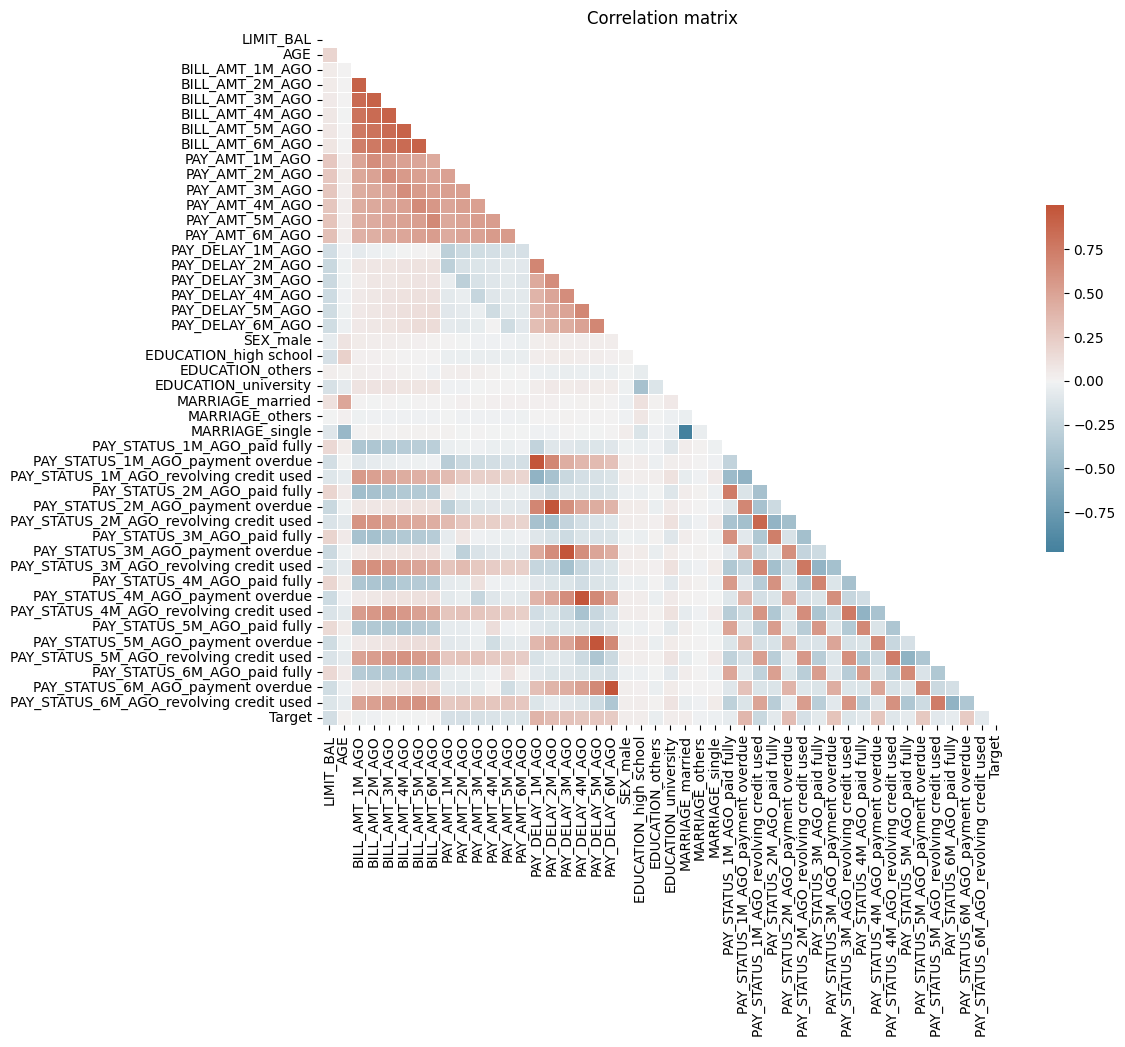

In [ ]:
default_cc_corr = calculate_correlation(default_cc_train_encoded, 'spearman') #, variables_for_correlation)

In [ ]:
abs(default_cc_corr['Target']).sort_values(ascending=False)

Target                                     1.000000
PAY_DELAY_1M_AGO                           0.392720
PAY_STATUS_1M_AGO_payment overdue          0.368905
PAY_DELAY_2M_AGO                           0.341986
PAY_STATUS_2M_AGO_payment overdue          0.341365
PAY_DELAY_3M_AGO                           0.297958
PAY_STATUS_3M_AGO_payment overdue          0.297067
PAY_DELAY_4M_AGO                           0.277398
PAY_STATUS_4M_AGO_payment overdue          0.276316
PAY_DELAY_5M_AGO                           0.266578
PAY_STATUS_5M_AGO_payment overdue          0.265733
PAY_DELAY_6M_AGO                           0.246007
PAY_STATUS_6M_AGO_payment overdue          0.244833
PAY_STATUS_1M_AGO_revolving credit used    0.220799
LIMIT_BAL                                  0.172015
PAY_AMT_1M_AGO                             0.157716
PAY_STATUS_2M_AGO_revolving credit used    0.154934
PAY_AMT_2M_AGO                             0.151557
PAY_AMT_3M_AGO                             0.144366
PAY_AMT_4M_AGO                             0.131908
PAY_AMT_6M_AGO                             0.126817
PAY_AMT_5M_AGO                             0.121490
PAY_STATUS_3M_AGO_revolving credit used    0.116902
PAY_STATUS_4M_AGO_revolving credit used    0.097269
PAY_STATUS_5M_AGO_revolving credit used    0.085675
PAY_STATUS_6M_AGO_revolving credit used    0.085620
PAY_STATUS_3M_AGO_paid fully               0.080234
PAY_STATUS_2M_AGO_paid fully               0.077944
PAY_STATUS_4M_AGO_paid fully               0.075880
PAY_STATUS_5M_AGO_paid fully               0.070530
PAY_STATUS_6M_AGO_paid fully               0.063240
PAY_STATUS_1M_AGO_paid fully               0.062672
EDUCATION_others                           0.047727
SEX_male                                   0.042538
EDUCATION_university                       0.038639
MARRIAGE_single                            0.033319
EDUCATION_high school                      0.032766
MARRIAGE_married                           0.031977
BILL_AMT_1M_AGO                            0.022239
MARRIAGE_others                            0.014870
BILL_AMT_2M_AGO                            0.011566
BILL_AMT_3M_AGO                            0.009081
BILL_AMT_5M_AGO                            0.007565
AGE                                        0.007317
BILL_AMT_4M_AGO                            0.006854
BILL_AMT_6M_AGO                            0.003389
Name: Target, dtype: float64

df columns:  Index(['LIMIT_BAL', 'AGE', 'BILL_AMT_1M_AGO', 'BILL_AMT_2M_AGO',
       'BILL_AMT_3M_AGO', 'BILL_AMT_4M_AGO', 'BILL_AMT_5M_AGO',
       'BILL_AMT_6M_AGO', 'PAY_AMT_1M_AGO', 'PAY_AMT_2M_AGO', 'PAY_AMT_3M_AGO',
       'PAY_AMT_4M_AGO', 'PAY_AMT_5M_AGO', 'PAY_AMT_6M_AGO',
       'PAY_DELAY_1M_AGO', 'PAY_DELAY_2M_AGO', 'PAY_DELAY_3M_AGO',
       'PAY_DELAY_4M_AGO', 'PAY_DELAY_5M_AGO', 'PAY_DELAY_6M_AGO', 'SEX_male',
       'EDUCATION_high school', 'EDUCATION_others', 'EDUCATION_university',
       'MARRIAGE_married', 'MARRIAGE_others', 'MARRIAGE_single',
       'PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1M_AGO_payment overdue',
       'PAY_STATUS_1M_AGO_revolving credit used',
       'PAY_STATUS_2M_AGO_paid fully', 'PAY_STATUS_2M_AGO_payment overdue',
       'PAY_STATUS_2M_AGO_revolving credit used',
       'PAY_STATUS_3M_AGO_paid fully', 'PAY_STATUS_3M_AGO_payment overdue',
       'PAY_STATUS_3M_AGO_revolving credit used',
       'PAY_STATUS_4M_AGO_paid fully', 'PAY_STATUS_4

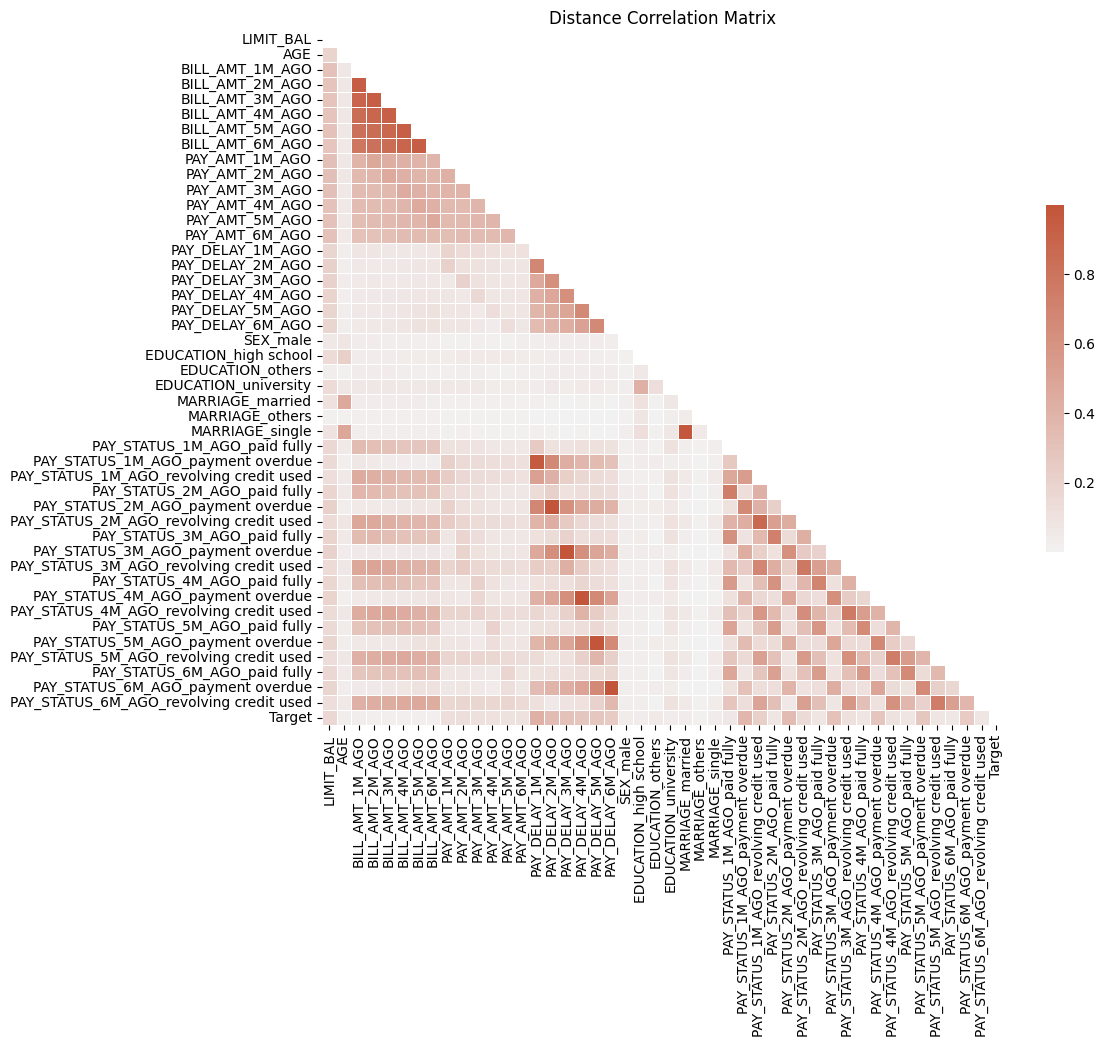

In [ ]:
default_cc_dist_corr = calculate_distance_correlation_matrix(default_cc_train_encoded)

In [ ]:
default_cc_dist_corr['Target'].sort_values(ascending=False)

Target                                     1.000000
PAY_DELAY_1M_AGO                           0.408897
PAY_STATUS_1M_AGO_payment overdue          0.368905
PAY_DELAY_2M_AGO                           0.342042
PAY_STATUS_2M_AGO_payment overdue          0.341365
PAY_DELAY_3M_AGO                           0.297364
PAY_STATUS_3M_AGO_payment overdue          0.297067
PAY_DELAY_4M_AGO                           0.276748
PAY_STATUS_4M_AGO_payment overdue          0.276316
PAY_DELAY_5M_AGO                           0.266163
PAY_STATUS_5M_AGO_payment overdue          0.265733
PAY_DELAY_6M_AGO                           0.245567
PAY_STATUS_6M_AGO_payment overdue          0.244833
PAY_STATUS_1M_AGO_revolving credit used    0.220799
LIMIT_BAL                                  0.159098
PAY_STATUS_2M_AGO_revolving credit used    0.154934
PAY_AMT_1M_AGO                             0.123355
PAY_AMT_2M_AGO                             0.120780
PAY_STATUS_3M_AGO_revolving credit used    0.116902
PAY_AMT_3M_AGO                             0.113377
PAY_AMT_4M_AGO                             0.101540
PAY_AMT_5M_AGO                             0.098456
PAY_STATUS_4M_AGO_revolving credit used    0.097269
PAY_AMT_6M_AGO                             0.095423
PAY_STATUS_5M_AGO_revolving credit used    0.085675
PAY_STATUS_6M_AGO_revolving credit used    0.085620
PAY_STATUS_3M_AGO_paid fully               0.080234
PAY_STATUS_2M_AGO_paid fully               0.077944
PAY_STATUS_4M_AGO_paid fully               0.075880
PAY_STATUS_5M_AGO_paid fully               0.070530
PAY_STATUS_6M_AGO_paid fully               0.063240
PAY_STATUS_1M_AGO_paid fully               0.062672
EDUCATION_others                           0.047727
SEX_male                                   0.042538
EDUCATION_university                       0.038639
MARRIAGE_single                            0.033319
EDUCATION_high school                      0.032766
MARRIAGE_married                           0.031977
AGE                                        0.027052
BILL_AMT_1M_AGO                            0.026993
BILL_AMT_2M_AGO                            0.021758
BILL_AMT_3M_AGO                            0.020607
BILL_AMT_4M_AGO                            0.018816
BILL_AMT_5M_AGO                            0.018693
BILL_AMT_6M_AGO                            0.016738
MARRIAGE_others                            0.014870
Name: Target, dtype: float64

# **Pre-feature selection + Remove intercorrelated features**
Features with zero-variance will be dropped. In this scenario, intercorrelated features will be dropped as well with only one of the pair remaining.

The code gives the option for additional removal of extremely weak correlation with the target variable. Nonetheless we will not be using it given that we have non-linear models being tested.

In [ ]:
filtered_features = filter_out_intercorrelated_features(default_cc_dist_corr, 'Target', 0.8)

appended feature:  PAY_DELAY_1M_AGO
eliminated feature:  PAY_STATUS_1M_AGO_payment overdue 0.9603174252876002
appended feature:  PAY_DELAY_2M_AGO
eliminated feature:  PAY_STATUS_2M_AGO_payment overdue 0.9975801550270001
appended feature:  PAY_DELAY_3M_AGO
eliminated feature:  PAY_STATUS_3M_AGO_payment overdue 0.9984917697361416
appended feature:  PAY_DELAY_4M_AGO
eliminated feature:  PAY_STATUS_4M_AGO_payment overdue 0.998029305232507
appended feature:  PAY_DELAY_5M_AGO
eliminated feature:  PAY_STATUS_5M_AGO_payment overdue 0.997728264791085
appended feature:  PAY_DELAY_6M_AGO
eliminated feature:  PAY_STATUS_6M_AGO_payment overdue 0.9981510390668386
appended feature:  PAY_STATUS_1M_AGO_revolving credit used
eliminated feature:  PAY_STATUS_2M_AGO_revolving credit used 0.8714268865267695
appended feature:  LIMIT_BAL
appended feature:  PAY_AMT_1M_AGO
appended feature:  PAY_AMT_2M_AGO
appended feature:  PAY_STATUS_3M_AGO_revolving credit used
appended feature:  PAY_AMT_3M_AGO
appended feat

In [ ]:
# Drop columns with zero variance or weak correlation
DROP_WEAK_FEATURES = False
WEAK_THRESHOLD = 0.01

default_cc_zero_variance_columns = identify_zero_variance_columns(default_cc_train_encoded[filtered_features])

if DROP_WEAK_FEATURES:
  default_cc_weak_features = identify_weak_associated_features(
      default_cc_dist_corr, "Target", WEAK_THRESHOLD
  )
else:
  default_cc_weak_features = []

remove_columns = set(default_cc_zero_variance_columns + default_cc_weak_features)
remove_columns = [col for col in remove_columns if col in filtered_features]
print(remove_columns)

default_cc_train = default_cc_train_encoded[filtered_features + ['Target']].drop(columns=remove_columns)
default_cc_test = default_cc_test_encoded[filtered_features + ['Target']].drop(columns=remove_columns)

Variance of each column:
PAY_DELAY_1M_AGO                           5.816560e-01
PAY_DELAY_2M_AGO                           6.501538e-01
PAY_DELAY_3M_AGO                           6.321474e-01
PAY_DELAY_4M_AGO                           5.724701e-01
PAY_DELAY_5M_AGO                           5.080045e-01
PAY_DELAY_6M_AGO                           5.096939e-01
PAY_STATUS_1M_AGO_revolving credit used    2.498782e-01
LIMIT_BAL                                  1.690062e+10
PAY_AMT_1M_AGO                             2.558793e+08
PAY_AMT_2M_AGO                             5.352601e+08
PAY_STATUS_3M_AGO_revolving credit used    2.494284e-01
PAY_AMT_3M_AGO                             2.866536e+08
PAY_AMT_4M_AGO                             2.416386e+08
PAY_AMT_5M_AGO                             2.440565e+08
PAY_STATUS_4M_AGO_revolving credit used    2.476903e-01
PAY_AMT_6M_AGO                             3.358963e+08
PAY_STATUS_5M_AGO_revolving credit used    2.458446e-01
PAY_STATUS_6M_AGO_revol

In [ ]:
default_cc_train.head()

PAY_DELAY_1M_AGO  PAY_DELAY_2M_AGO  PAY_DELAY_3M_AGO  PAY_DELAY_4M_AGO  \
15971               0.0               0.0               0.0               0.0   
26684               1.0               2.0               0.0               0.0   
22140               0.0               0.0               0.0               0.0   
12105               0.0               0.0               0.0               0.0   
3839                2.0               2.0               2.0               0.0   

       PAY_DELAY_5M_AGO  PAY_DELAY_6M_AGO  \
15971               0.0               0.0   
26684               0.0               0.0   
22140               0.0               0.0   
12105               0.0               0.0   
3839                0.0               2.0   

       PAY_STATUS_1M_AGO_revolving credit used  LIMIT_BAL  PAY_AMT_1M_AGO  \
15971                                      1.0   260000.0          5100.0   
26684                                      0.0    20000.0             0.0   
22140                                      1.0   230000.0          3000.0   
12105                                      1.0   200000.0         10000.0   
3839                                       0.0    50000.0          1800.0   

       PAY_AMT_2M_AGO  ...  EDUCATION_others  SEX_male  EDUCATION_university  \
15971          5300.0  ...               0.0       0.0                   0.0   
26684          1370.0  ...               0.0       1.0                   1.0   
22140          3000.0  ...               0.0       0.0                   0.0   
12105         30000.0  ...               0.0       0.0                   0.0   
3839              0.0  ...               0.0       1.0                   0.0   

       MARRIAGE_single  EDUCATION_high school   AGE  BILL_AMT_1M_AGO  \
15971              0.0                    1.0  44.0         148803.0   
26684              1.0                    0.0  25.0          19099.0   
22140              1.0                    0.0  25.0          50757.0   
12105              1.0                    0.0  59.0         180887.0   
3839               1.0                    1.0  28.0          28129.0   

       BILL_AMT_6M_AGO  MARRIAGE_others  Target  
15971         108011.0              0.0     0.0  
26684          16876.0              0.0     0.0  
22140          52788.0              0.0     0.0  
12105          78079.0              0.0     0.0  
3839           30040.0              0.0     1.0  

[5 rows x 34 columns]

In [ ]:
print('Original number of features: ', len(default_cc.columns))
print('Number of features after pre-feature selection: ', len(default_cc_train.columns))

Original number of features:  30
Number of features after pre-feature selection:  34


# **Imbalanced dataset**

In [ ]:
X_train = default_cc_train.drop('Target', axis=1)
y_train = default_cc_train['Target']

X_test = default_cc_test.drop('Target', axis=1)
y_test = default_cc_test['Target']

In [ ]:
target_counts = y_train.value_counts()
target_percentages = y_train.value_counts(normalize=True)

df_target_stats = pd.DataFrame({'Count': target_counts, 'Percentage': target_percentages})
df_target_stats

Count  Percentage
Target                   
0.0     18691    0.778792
1.0      5309    0.221208

Class imbalance will be addressed directly in the models by using class_weight='balanced' or scale_pos_weight = # majority class / # minority class

# **Models optimized for F1-score**

**Usage of feature permutation importance** Instead of calculating the feature importance because  permutation importance is less biased and reflects better the final goal of this use-case which is to measure the capacity of other variables replace the missing one.

**F1-score and Balanced Accuracy as performance metrics:** All the models in this section are trained using F1-score. In the next section, it will be used the Balanced Accuracy. These metrics were selected over the remaining ones because they:
- provide a more holistic view of the performance by considering precision and recall at the same time
- are more resilient to imbalanced datasets
- are among the preferred on several industries like Financial Services where the accuracy it is not enough per se.

**Missing values imputation with median (continuous variables) and mode (categorical variables):**
- simple missing value imputation technique to overcome the fact of some models implementation not handlung missing values natively and with this level up all the models with the same conditions
- median was used instead of the mean because it is more resilient to outliers and guarantees that the imputed value is part of the domain of the variable and in the case of binary variables median and mode coincide

In [ ]:
default_cc_imputation_values_dict = calculate_imputation_values_for_missing(
    default_cc_train
)
default_cc_imputation_values_dict

{'PAY_DELAY_1M_AGO': 0.0,
 'PAY_DELAY_2M_AGO': 0.0,
 'PAY_DELAY_3M_AGO': 0.0,
 'PAY_DELAY_4M_AGO': 0.0,
 'PAY_DELAY_5M_AGO': 0.0,
 'PAY_DELAY_6M_AGO': 0.0,
 'PAY_STATUS_1M_AGO_revolving credit used': 0.0,
 'LIMIT_BAL': 140000.0,
 'PAY_AMT_1M_AGO': 2100.0,
 'PAY_AMT_2M_AGO': 2003.0,
 'PAY_STATUS_3M_AGO_revolving credit used': 1.0,
 'PAY_AMT_3M_AGO': 1800.0,
 'PAY_AMT_4M_AGO': 1500.0,
 'PAY_AMT_5M_AGO': 1500.0,
 'PAY_STATUS_4M_AGO_revolving credit used': 1.0,
 'PAY_AMT_6M_AGO': 1500.0,
 'PAY_STATUS_5M_AGO_revolving credit used': 1.0,
 'PAY_STATUS_6M_AGO_revolving credit used': 1.0,
 'PAY_STATUS_3M_AGO_paid fully': 0.0,
 'PAY_STATUS_2M_AGO_paid fully': 0.0,
 'PAY_STATUS_4M_AGO_paid fully': 0.0,
 'PAY_STATUS_5M_AGO_paid fully': 0.0,
 'PAY_STATUS_6M_AGO_paid fully': 0.0,
 'PAY_STATUS_1M_AGO_paid fully': 0.0,
 'EDUCATION_others': 0.0,
 'SEX_male': 0.0,
 'EDUCATION_university': 0.0,
 'MARRIAGE_single': 1.0,
 'EDUCATION_high school': 0.0,
 'AGE': 34.0,
 'BILL_AMT_1M_AGO': 22137.0,
 'BILL_AMT_6

In [ ]:
default_cc_cat_vars = [col for col in X_train.columns if X_train[col].nunique() <= 2]
default_cc_cat_vars

['PAY_STATUS_1M_AGO_revolving credit used',
 'PAY_STATUS_3M_AGO_revolving credit used',
 'PAY_STATUS_4M_AGO_revolving credit used',
 'PAY_STATUS_5M_AGO_revolving credit used',
 'PAY_STATUS_6M_AGO_revolving credit used',
 'PAY_STATUS_3M_AGO_paid fully',
 'PAY_STATUS_2M_AGO_paid fully',
 'PAY_STATUS_4M_AGO_paid fully',
 'PAY_STATUS_5M_AGO_paid fully',
 'PAY_STATUS_6M_AGO_paid fully',
 'PAY_STATUS_1M_AGO_paid fully',
 'EDUCATION_others',
 'SEX_male',
 'EDUCATION_university',
 'MARRIAGE_single',
 'EDUCATION_high school',
 'MARRIAGE_others']

In [ ]:
# Maximum number of original features (after feature engineering) to be imputed
NUM_FEAT = 20

##**Decision tree**

**Cross-validation (3,3) for large datasets and (5,5) for smaller datasets:**
- due to the unpractical runtime of some of the models, the cross-validaton set up on large datasets consists in a nested-cv with 3-fold in both inner and outer CV. The number of folds is increased to (5,5) in smaller datsets.
- this assumption is reasonable given that in larger datasets there is a higher chance of the holdout samples being big enough to be more representative and less prone to biases. So a smaller number of folds can be assummed
- on the other hand, in smaller datasets it is crucial to reduce the variance and any potential misrepresentativeness of a specific validation set, so it is requires a larger number of folds to make a more efficient use of the data available.


In [ ]:
FINE_TUNE = False

if FINE_TUNE:
  dt_param_grid = {
      'max_depth': [2, 3, 4, 5, None],
      'min_samples_split': [0.2, 0.1, 0.05, 0.01, 0.005, 0.001, 2],  # last option reflects num of samples instead of proportion
      'min_samples_leaf': [0.1, 0.05, 0.01, 0.005, 0.001, 1]  # last option reflects num of samples instead of proportion
  }
else:
  # best model
  dt_param_grid = {
    'max_depth': [4],
    'min_samples_split': [0.01],
    'min_samples_leaf': [0.01]
}

dt_classifier = DecisionTreeClassifier(class_weight='balanced', random_state=RANDOM_STATE)
dt_grid_search, dt_best_model, dt_best_params = hyperparameter_tuning(
    dt_classifier, dt_param_grid, 3, 3, 'f1', X_train, y_train
)

Starting hyperparameter tuning at: 2025-01-18 15:19:44.593465

Nested Cross-validation Results:
Individual scores: [0.53270292 0.52562071 0.51904017]
Average nested CV score: 0.526 (+/- 0.011)

Fitting final model on entire dataset...
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best parameters: {'max_depth': 4, 'min_samples_leaf': 0.01, 'min_samples_split': 0.01}

Best Model Performance:
Best CV score: 0.526
2025-01-18 15:19:45.299844

Execution time: 0.01 minutes


```
Starting hyperparameter tuning at: 2025-01-17 11:53:59.045922

Nested Cross-validation Results:
Individual scores: [0.52342409 0.50847458 0.51672956]
Average nested CV score: 0.516 (+/- 0.012)

Fitting final model on entire dataset...
Fitting 3 folds for each of 210 candidates, totalling 630 fits
Best parameters: {'max_depth': 4, 'min_samples_leaf': 0.01, 'min_samples_split': 0.01}

Best Model Performance:
Best CV score: 0.526
2025-01-17 11:54:35.271806

Execution time: 0.60 minutes
```



In [ ]:
# dt_grid_search.cv_results_

In [ ]:
dt_classifier, dt_train_pred, dt_test_pred = apply_model(dt_best_model, X_train, y_train, X_test, y_test)
dt_feat_permut_import_df = analyze_feat_permut_import(dt_classifier, X_train, y_train, scoring_metric="f1")
dt_feat_permut_import_df[dt_feat_permut_import_df['Importance']!=0]

Feature  Importance       Std
0               PAY_DELAY_1M_AGO    0.141975  0.003948
2               PAY_DELAY_3M_AGO    0.015290  0.001862
20  PAY_STATUS_4M_AGO_paid fully    0.009420  0.001202
3               PAY_DELAY_4M_AGO    0.003703  0.000441
4               PAY_DELAY_5M_AGO    0.003472  0.000114
12                PAY_AMT_4M_AGO    0.000691  0.000461
9                 PAY_AMT_2M_AGO   -0.000006  0.001028

**Note:** feature permutation importance values do not sum up to 100% because they represent the drop in model performance when each feature is permuted, and they are not normalized.

Values can be negative if permuting an unimportant feature improves model performance.

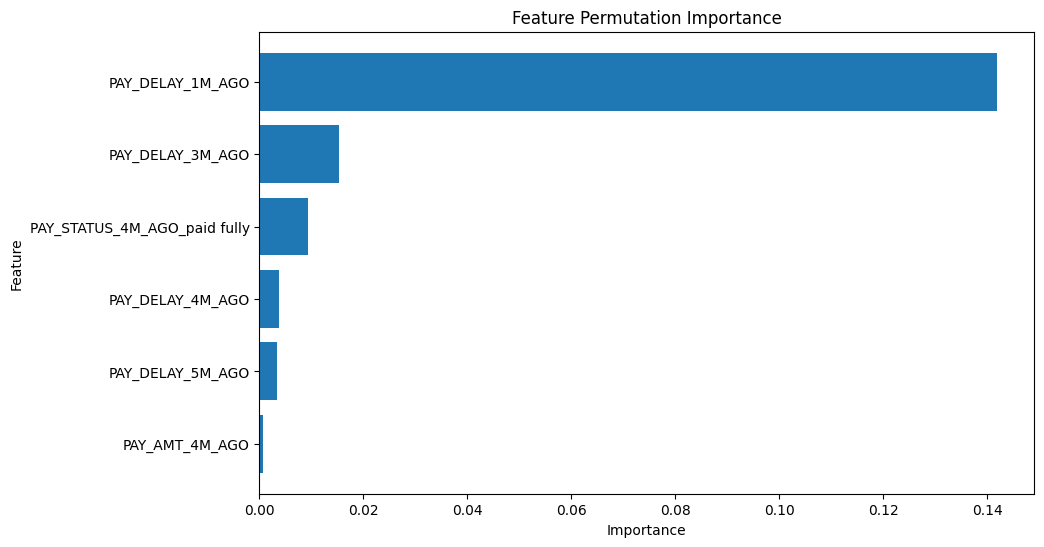

In [ ]:
plot_feat_permut_importance(dt_feat_permut_import_df)

In [ ]:
dt_perf, dt_orig_missing, dt_missing = measure_performance_decline(
    X_train, X_test, y_test, dt_classifier, dt_feat_permut_import_df,
    default_cc_imputation_values_dict, NUM_FEAT, method='simple',
    encoded_vars_family=default_cc_encoded_vars_family
)


--- NEW ITERATION ---
Removing feature:  PAY_DELAY_1M_AGO
Original feat removed so far:  ['PAY_DELAY_1M_AGO']

--- NEW ITERATION ---
Removing feature:  PAY_DELAY_3M_AGO
Original feat removed so far:  ['PAY_DELAY_1M_AGO', 'PAY_DELAY_3M_AGO']

--- NEW ITERATION ---
Removing feature:  PAY_STATUS_4M_AGO_paid fully
Removing related features:  ['PAY_STATUS_4M_AGO_paid fully', 'PAY_STATUS_4M_AGO_revolving credit used']
Original feat removed so far:  ['PAY_DELAY_1M_AGO', 'PAY_DELAY_3M_AGO', 'PAY_STATUS_4M_AGO']

--- NEW ITERATION ---
Removing feature:  PAY_DELAY_4M_AGO
Original feat removed so far:  ['PAY_DELAY_1M_AGO', 'PAY_DELAY_3M_AGO', 'PAY_STATUS_4M_AGO', 'PAY_DELAY_4M_AGO']

--- NEW ITERATION ---
Removing feature:  PAY_DELAY_5M_AGO
Original feat removed so far:  ['PAY_DELAY_1M_AGO', 'PAY_DELAY_3M_AGO', 'PAY_STATUS_4M_AGO', 'PAY_DELAY_4M_AGO', 'PAY_DELAY_5M_AGO']

--- NEW ITERATION ---
Removing feature:  PAY_AMT_4M_AGO
Original feat removed so far:  ['PAY_DELAY_1M_AGO', 'PAY_DELAY_3M_AGO

In [ ]:
dt_orig_missing

['PAY_DELAY_1M_AGO',
 'PAY_DELAY_3M_AGO',
 'PAY_STATUS_4M_AGO',
 'PAY_DELAY_4M_AGO',
 'PAY_DELAY_5M_AGO',
 'PAY_AMT_4M_AGO',
 'EDUCATION',
 'PAY_STATUS_2M_AGO',
 'PAY_STATUS_5M_AGO',
 'PAY_STATUS_6M_AGO',
 'PAY_STATUS_1M_AGO',
 'MARRIAGE',
 'SEX',
 'AGE',
 'BILL_AMT_1M_AGO',
 'PAY_STATUS_3M_AGO',
 'BILL_AMT_6M_AGO',
 'PAY_AMT_5M_AGO',
 'PAY_AMT_3M_AGO',
 'PAY_AMT_1M_AGO']

In [ ]:
len(dt_missing)

28

In [ ]:
dt_perf

tp    tn   fp    fn  precision  recall  specificity  accuracy  f1_score  \
0   752  3856  817   575      47.93   56.67        82.52     76.80     51.93   
1   410  4275  398   917      50.74   30.90        91.48     78.08     38.41   
2   139  4562  111  1188      55.60   10.47        97.62     78.35     17.63   
3   139  4562  111  1188      55.60   10.47        97.62     78.35     17.63   
4     0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   
5     0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   
6     0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   
7     0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   
8     0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   
9     0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   
10    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   
11    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   
12    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   
13    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   
14    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   
15    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   
16    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   
17    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   
18    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   
19    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   
20    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   

    balanced_accuracy  num_feat_missing  \
0               69.59                 0   
1               61.19                 1   
2               54.05                 2   
3               54.05                 3   
4               50.00                 4   
5               50.00                 5   
6               50.00                 6   
7               50.00                 7   
8               50.00                 8   
9               50.00                 9   
10              50.00                10   
11              50.00                11   
12              50.00                12   
13              50.00                13   
14              50.00                14   
15              50.00                15   
16              50.00                16   
17              50.00                17   
18              50.00                18   
19              50.00                19   
20              50.00                20   

                                              imputed  
0                                                      
1                        ['PAY_DELAY_1M_AGO'] imputed  
2    ['PAY_DELAY_1M_AGO', 'PAY_DELAY_3M_AGO'] imputed  
3   ['PAY_DELAY_1M_AGO', 'PAY_DELAY_3M_AGO', 'PAY_...  
4   ['PAY_DELAY_1M_AGO', 'PAY_DELAY_3M_AGO', 'PAY_...  
5   ['PAY_DELAY_1M_AGO', 'PAY_DELAY_3M_AGO', 'PAY_...  
6   ['PAY_DELAY_1M_AGO', 'PAY_DELAY_3M_AGO', 'PAY_...  
7   ['PAY_DELAY_1M_AGO', 'PAY_DELAY_3M_AGO', 'PAY_...  
8   ['PAY_DELAY_1M_AGO', 'PAY_DELAY_3M_AGO', 'PAY_...  
9   ['PAY_DELAY_1M_AGO', 'PAY_DELAY_3M_AGO', 'PAY_...  
10  ['PAY_DELAY_1M_AGO', 'PAY_DELAY_3M_AGO', 'PAY_...  
11  ['PAY_DELAY_1M_AGO', 'PAY_DELAY_3M_AGO', 'PAY_...  
12  ['PAY_DELAY_1M_AGO', 'PAY_DELAY_3M_AGO', 'PAY_...  
13  ['PAY_DELAY_1M_AGO', 'PAY_DELAY_3M_AGO', 'PAY_...  
14  ['PAY_DELAY_1M_AGO', 'PAY_DELAY_3M_AGO', 'PAY_...  
15  ['PAY_DELAY_1M_AGO', 'PAY_DELAY_3M_AGO', 'PAY_...  
16  ['PAY_DELAY_1M_AGO', 'PAY_DELAY_3M_AGO', 'PAY_...  
17  ['PAY_DELAY_1M_AGO', 'PAY_DELAY_3M_AGO', 'PAY_...  
18  ['PAY_DELAY_1M_AGO', 'PAY_DELAY_3M_AGO', 'PAY_...  
19  ['PAY_DELAY_1M_AGO', 'PAY_DELAY_3M_AGO', 'PAY_...  
20  ['PAY_DELAY_1M_AGO', 'PAY_DELAY_3M_AGO', 'PAY_...

In [ ]:
start_time = time.time()
print(datetime.datetime.now())

dt_perf_mf, dt_orig_missing_mf, dt_missing_mf = measure_performance_decline(
    X_train, X_test, y_test, dt_classifier, dt_feat_permut_import_df,
    imputation_dict=None, num_feat=NUM_FEAT, method='missforest',
    encoded_vars_family=default_cc_encoded_vars_family,
    categorical_vars=default_cc_cat_vars
)

print(datetime.datetime.now())
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time/60} minutes")

2025-01-18 15:20:02.393484

--- NEW ITERATION ---
Removing feature:  PAY_DELAY_1M_AGO
Nr. columns with nan:  1
Numerical columns:  ['PAY_DELAY_1M_AGO', 'PAY_DELAY_2M_AGO', 'PAY_DELAY_3M_AGO', 'PAY_DELAY_4M_AGO', 'PAY_DELAY_5M_AGO', 'PAY_DELAY_6M_AGO', 'LIMIT_BAL', 'PAY_AMT_1M_AGO', 'PAY_AMT_2M_AGO', 'PAY_AMT_3M_AGO', 'PAY_AMT_4M_AGO', 'PAY_AMT_5M_AGO', 'PAY_AMT_6M_AGO', 'AGE', 'BILL_AMT_1M_AGO', 'BILL_AMT_6M_AGO']
Categorical columns:  ['PAY_STATUS_1M_AGO_revolving credit used', 'PAY_STATUS_3M_AGO_revolving credit used', 'PAY_STATUS_4M_AGO_revolving credit used', 'PAY_STATUS_5M_AGO_revolving credit used', 'PAY_STATUS_6M_AGO_revolving credit used', 'PAY_STATUS_3M_AGO_paid fully', 'PAY_STATUS_2M_AGO_paid fully', 'PAY_STATUS_4M_AGO_paid fully', 'PAY_STATUS_5M_AGO_paid fully', 'PAY_STATUS_6M_AGO_paid fully', 'PAY_STATUS_1M_AGO_paid fully', 'EDUCATION_others', 'SEX_male', 'EDUCATION_university', 'MARRIAGE_single', 'EDUCATION_high school', 'MARRIAGE_others']
Column imputed:  PAY_DELAY_1M_AGO

In [ ]:
dt_perf_mf

tp    tn   fp   fn  precision  recall  specificity  accuracy  f1_score  \
0   752  3856  817  575      47.93   56.67        82.52     76.80     51.93   
1   627  3965  708  700      46.97   47.25        84.85     76.53     47.11   
2   586  4056  617  741      48.71   44.16        86.80     77.37     46.32   
3   588  4055  618  739      48.76   44.31        86.78     77.38     46.43   
4   559  4104  569  768      49.56   42.13        87.82     77.72     45.54   
5   524  4161  512  803      50.58   39.49        89.04     78.08     44.35   
6   507  4212  461  820      52.38   38.21        90.13     78.65     44.18   
7   507  4210  463  820      52.27   38.21        90.09     78.62     44.14   
8   507  4209  464  820      52.21   38.21        90.07     78.60     44.13   
9   514  4183  490  813      51.20   38.73        89.51     78.28     44.10   
10  513  4190  483  814      51.51   38.66        89.66     78.38     44.17   
11  518  4183  490  809      51.39   39.04        89.51     78.35     44.37   
12  518  4183  490  809      51.39   39.04        89.51     78.35     44.37   
13  518  4183  490  809      51.39   39.04        89.51     78.35     44.37   
14  548  4129  544  779      50.18   41.30        88.36     77.95     45.31   
15  487  4255  418  840      53.81   36.70        91.05     79.03     43.64   
16  487  4255  418  840      53.81   36.70        91.05     79.03     43.64   
17  485  4244  429  842      53.06   36.55        90.82     78.82     43.28   
18  488  4242  431  839      53.10   36.77        90.78     78.83     43.46   
19  495  4226  447  832      52.55   37.30        90.43     78.68     43.63   
20  474  4274  399  853      54.30   35.72        91.46     79.13     43.09   

    balanced_accuracy  num_feat_missing  \
0               69.59                 0   
1               66.05                 1   
2               65.48                 2   
3               65.54                 3   
4               64.97                 4   
5               64.27                 5   
6               64.17                 6   
7               64.15                 7   
8               64.14                 8   
9               64.12                 9   
10              64.16                10   
11              64.27                11   
12              64.27                12   
13              64.27                13   
14              64.83                14   
15              63.88                15   
16              63.88                16   
17              63.68                17   
18              63.78                18   
19              63.87                19   
20              63.59                20   

                                              imputed  
0                                                      
1                        ['PAY_DELAY_1M_AGO'] imputed  
2    ['PAY_DELAY_1M_AGO', 'PAY_DELAY_3M_AGO'] imputed  
3   ['PAY_DELAY_1M_AGO', 'PAY_DELAY_3M_AGO', 'PAY_...  
4   ['PAY_DELAY_1M_AGO', 'PAY_DELAY_3M_AGO', 'PAY_...  
5   ['PAY_DELAY_1M_AGO', 'PAY_DELAY_3M_AGO', 'PAY_...  
6   ['PAY_DELAY_1M_AGO', 'PAY_DELAY_3M_AGO', 'PAY_...  
7   ['PAY_DELAY_1M_AGO', 'PAY_DELAY_3M_AGO', 'PAY_...  
8   ['PAY_DELAY_1M_AGO', 'PAY_DELAY_3M_AGO', 'PAY_...  
9   ['PAY_DELAY_1M_AGO', 'PAY_DELAY_3M_AGO', 'PAY_...  
10  ['PAY_DELAY_1M_AGO', 'PAY_DELAY_3M_AGO', 'PAY_...  
11  ['PAY_DELAY_1M_AGO', 'PAY_DELAY_3M_AGO', 'PAY_...  
12  ['PAY_DELAY_1M_AGO', 'PAY_DELAY_3M_AGO', 'PAY_...  
13  ['PAY_DELAY_1M_AGO', 'PAY_DELAY_3M_AGO', 'PAY_...  
14  ['PAY_DELAY_1M_AGO', 'PAY_DELAY_3M_AGO', 'PAY_...  
15  ['PAY_DELAY_1M_AGO', 'PAY_DELAY_3M_AGO', 'PAY_...  
16  ['PAY_DELAY_1M_AGO', 'PAY_DELAY_3M_AGO', 'PAY_...  
17  ['PAY_DELAY_1M_AGO', 'PAY_DELAY_3M_AGO', 'PAY_...  
18  ['PAY_DELAY_1M_AGO', 'PAY_DELAY_3M_AGO', 'PAY_...  
19  ['PAY_DELAY_1M_AGO', 'PAY_DELAY_3M_AGO', 'PAY_...  
20  ['PAY_DELAY_1M_AGO', 'PAY_DELAY_3M_AGO', 'PAY_...

In [ ]:
dt_perf_temp, dt_orig_missing_temp, dt_missing_temp = measure_temporal_performance_decline(
    X_train, X_test, y_test, dt_classifier, dt_feat_permut_import_df,
    default_cc_timeline_vars_family,
    default_cc_imputation_values_dict, NUM_FEAT, method='simple',
    encoded_vars_family=default_cc_encoded_vars_family, log_info=True
)


--- NEW ITERATION ---
original removed:  []
length original removed:  0
num feat:  20
i:  0
length features importance list:  33
length removed:  0

Removing feature:  PAY_DELAY_1M_AGO
Removing related temporal feature:  BILL_AMT_1M_AGO
Removing related temporal feature:  PAY_AMT_1M_AGO
Removing related temporal feature:  PAY_DELAY_1M_AGO
Removing related temporal feature:  PAY_STATUS_1M_AGO_paid fully
Removing related features:  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1M_AGO_revolving credit used']
Removing related temporal feature:  PAY_STATUS_1M_AGO_revolving credit used
Removing related features:  []
Columns with zero variance, i.e. imputed:
                                    feature  variance
0                          PAY_DELAY_1M_AGO       0.0
6   PAY_STATUS_1M_AGO_revolving credit used       0.0
8                            PAY_AMT_1M_AGO       0.0
23             PAY_STATUS_1M_AGO_paid fully       0.0
30                          BILL_AMT_1M_AGO       0.0
Original feat re

In [ ]:
dt_perf_temp

tp    tn   fp    fn  precision  recall  specificity  accuracy  f1_score  \
0  752  3856  817   575      47.93   56.67        82.52     76.80     51.93   
1  410  4275  398   917      50.74   30.90        91.48     78.08     38.41   
2  139  4562  111  1188      55.60   10.47        97.62     78.35     17.63   
3    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   
4    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   
5    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   
6    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   
7    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   

   balanced_accuracy  num_feat_missing  \
0              69.59                 0   
1              61.19                 4   
2              54.05                 7   
3              50.00                10   
4              50.00                13   
5              50.00                14   
6              50.00                17   
7              50.00                21   

                                             imputed  
0                                                     
1  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
2  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
3  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
4  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
5  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
6  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
7  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...

In [ ]:
start_time = time.time()
print(datetime.datetime.now())

dt_perf_temp_mf, dt_orig_missing_temp_mf, dt_missing_temp_mf = measure_temporal_performance_decline(
    X_train, X_test, y_test, dt_classifier, dt_feat_permut_import_df,
    default_cc_timeline_vars_family, num_feat=NUM_FEAT, method='missforest',
    encoded_vars_family=default_cc_encoded_vars_family,
    categorical_vars=default_cc_cat_vars, log_info=True
)

print(datetime.datetime.now())
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time/60} minutes")

2025-01-18 15:24:45.325069

--- NEW ITERATION ---
original removed:  []
length original removed:  0
num feat:  20
i:  0
length features importance list:  33
length removed:  0

Removing feature:  PAY_DELAY_1M_AGO
Removing related temporal feature:  BILL_AMT_1M_AGO
Removing related temporal feature:  PAY_AMT_1M_AGO
Removing related temporal feature:  PAY_DELAY_1M_AGO
Removing related temporal feature:  PAY_STATUS_1M_AGO_paid fully
Removing related features:  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1M_AGO_revolving credit used']
Removing related temporal feature:  PAY_STATUS_1M_AGO_revolving credit used
Removing related features:  []
Nr. columns with nan:  5
Numerical columns:  ['PAY_DELAY_1M_AGO', 'PAY_DELAY_2M_AGO', 'PAY_DELAY_3M_AGO', 'PAY_DELAY_4M_AGO', 'PAY_DELAY_5M_AGO', 'PAY_DELAY_6M_AGO', 'LIMIT_BAL', 'PAY_AMT_1M_AGO', 'PAY_AMT_2M_AGO', 'PAY_AMT_3M_AGO', 'PAY_AMT_4M_AGO', 'PAY_AMT_5M_AGO', 'PAY_AMT_6M_AGO', 'AGE', 'BILL_AMT_1M_AGO', 'BILL_AMT_6M_AGO']
Categorical columns:  [

In [ ]:
dt_perf_temp_mf

tp    tn   fp    fn  precision  recall  specificity  accuracy  f1_score  \
0  752  3856  817   575      47.93   56.67        82.52     76.80     51.93   
1  578  4067  606   749      48.82   43.56        87.03     77.42     46.04   
2  536  4175  498   791      51.84   40.39        89.34     78.52     45.40   
3  523  4207  466   804      52.88   39.41        90.03     78.83     45.16   
4  473  4284  389   854      54.87   35.64        91.68     79.28     43.22   
5  473  4284  389   854      54.87   35.64        91.68     79.28     43.22   
6   10  4668    5  1317      66.67    0.75        99.89     77.97      1.49   
7   21  4643   30  1306      41.18    1.58        99.36     77.73      3.05   

   balanced_accuracy  num_feat_missing  \
0              69.59                 0   
1              65.29                 4   
2              64.87                 7   
3              64.72                10   
4              63.66                13   
5              63.66                14   
6              50.32                17   
7              50.47                21   

                                             imputed  
0                                                     
1  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
2  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
3  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
4  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
5  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
6  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
7  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...

## **Random Forests**

In [ ]:
FINE_TUNE = False

if FINE_TUNE:
  rf_param_grid = {
      'n_estimators': [100, 200, 300],
      'max_features': ['sqrt', 0.5, 1.0],
      'max_depth': [3, 5, None],
      'min_samples_split': [0.01, 0.005, 0.001, 2],
      'min_samples_leaf': [0.01, 0.005, 0.001, 1]
  }
else:
  #best model
  rf_param_grid = {
      'n_estimators': [300],
      'max_features': ['sqrt'],
      'min_samples_split': [0.005],
      'min_samples_leaf': [0.001],
      'max_depth': [None]
  }

rf_classifier = RandomForestClassifier(
    class_weight='balanced', random_state=RANDOM_STATE
)
rf_grid_search, rf_best_model, rf_best_params = hyperparameter_tuning(
    rf_classifier, rf_param_grid, 3, 3, 'f1', X_train, y_train
)

Starting hyperparameter tuning at: 2025-01-18 15:26:20.410155

Nested Cross-validation Results:
Individual scores: [0.55153481 0.54368932 0.54841208]
Average nested CV score: 0.548 (+/- 0.006)

Fitting final model on entire dataset...
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best parameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 0.001, 'min_samples_split': 0.005, 'n_estimators': 300}

Best Model Performance:
Best CV score: 0.548
2025-01-18 15:26:49.094781

Execution time: 0.48 minutes



```
Starting hyperparameter tuning at: 2025-01-18 02:48:53.694801

Nested Cross-validation Results:
Individual scores: [0.54978244 0.54202586 0.54270833]
Average nested CV score: 0.545 (+/- 0.007)

Fitting final model on entire dataset...
Fitting 3 folds for each of 432 candidates, totalling 1296 fits
Best parameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 0.001, 'min_samples_split': 0.005, 'n_estimators': 300}

Best Model Performance:
Best CV score: 0.548
2025-01-18 04:04:23.927246

Execution time: 75.50 minutes
```

In [ ]:
rf_classifier, rf_train_pred, rf_test_pred = apply_model(rf_best_model, X_train, y_train, X_test, y_test)
rf_feat_permut_import_df = analyze_feat_permut_import(rf_classifier, X_train, y_train, scoring_metric="f1")
rf_feat_permut_import_df[rf_feat_permut_import_df['Importance']!=0]

Feature  Importance       Std
0                          PAY_DELAY_1M_AGO    0.074433  0.001575
30                          BILL_AMT_1M_AGO    0.014284  0.001048
7                                 LIMIT_BAL    0.013095  0.001113
11                           PAY_AMT_3M_AGO    0.012141  0.000582
12                           PAY_AMT_4M_AGO    0.011506  0.000402
8                            PAY_AMT_1M_AGO    0.010198  0.000983
9                            PAY_AMT_2M_AGO    0.009449  0.000562
1                          PAY_DELAY_2M_AGO    0.008631  0.001347
15                           PAY_AMT_6M_AGO    0.007400  0.000468
2                          PAY_DELAY_3M_AGO    0.007304  0.000956
13                           PAY_AMT_5M_AGO    0.006992  0.000667
31                          BILL_AMT_6M_AGO    0.006554  0.000596
29                                      AGE    0.004173  0.000592
6   PAY_STATUS_1M_AGO_revolving credit used    0.003503  0.001780
10  PAY_STATUS_3M_AGO_revolving credit used    0.002395  0.000701
27                          MARRIAGE_single    0.002358  0.000395
26                     EDUCATION_university    0.002294  0.000253
23             PAY_STATUS_1M_AGO_paid fully    0.002135  0.000595
18             PAY_STATUS_3M_AGO_paid fully    0.001753  0.000360
3                          PAY_DELAY_4M_AGO    0.001745  0.001010
14  PAY_STATUS_4M_AGO_revolving credit used    0.001651  0.000301
19             PAY_STATUS_2M_AGO_paid fully    0.001631  0.000327
22             PAY_STATUS_6M_AGO_paid fully    0.001580  0.000564
25                                 SEX_male    0.001477  0.000670
17  PAY_STATUS_6M_AGO_revolving credit used    0.001377  0.000592
28                    EDUCATION_high school    0.001366  0.000236
16  PAY_STATUS_5M_AGO_revolving credit used    0.001359  0.000398
21             PAY_STATUS_5M_AGO_paid fully    0.001251  0.000379
20             PAY_STATUS_4M_AGO_paid fully    0.000512  0.000453
4                          PAY_DELAY_5M_AGO    0.000212  0.000522
24                         EDUCATION_others    0.000090  0.000105
5                          PAY_DELAY_6M_AGO   -0.000372  0.000439

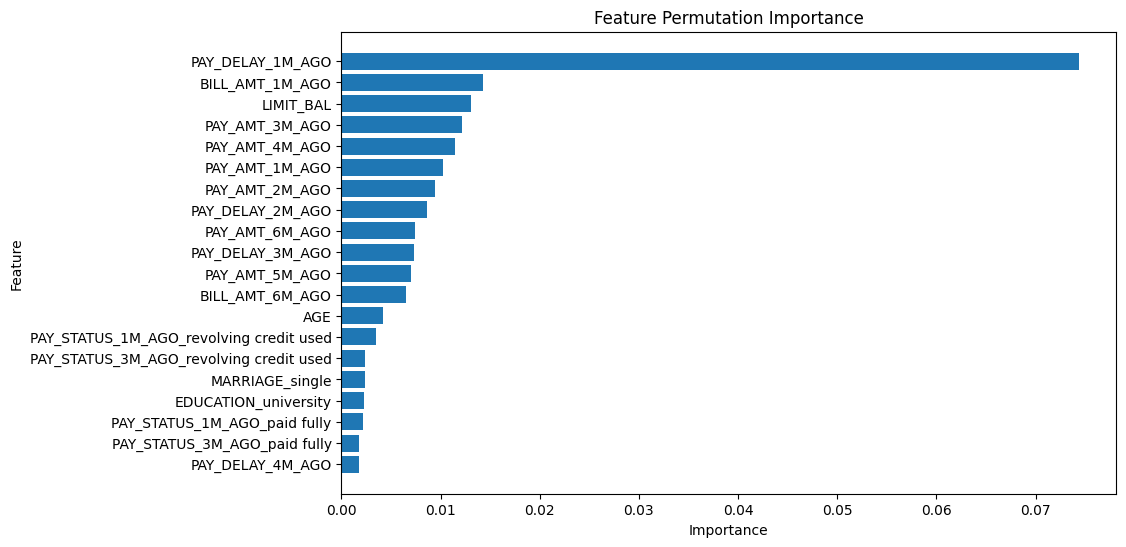

In [ ]:
plot_feat_permut_importance(rf_feat_permut_import_df)

In [ ]:
rf_perf, rf_orig_missing, rf_missing = measure_performance_decline(
    X_train, X_test, y_test, rf_classifier, rf_feat_permut_import_df,
    default_cc_imputation_values_dict, NUM_FEAT, method='simple',
    encoded_vars_family=default_cc_encoded_vars_family
)


--- NEW ITERATION ---
Removing feature:  PAY_DELAY_1M_AGO
Original feat removed so far:  ['PAY_DELAY_1M_AGO']

--- NEW ITERATION ---
Removing feature:  BILL_AMT_1M_AGO
Original feat removed so far:  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO']

--- NEW ITERATION ---
Removing feature:  LIMIT_BAL
Original feat removed so far:  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'LIMIT_BAL']

--- NEW ITERATION ---
Removing feature:  PAY_AMT_3M_AGO
Original feat removed so far:  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'LIMIT_BAL', 'PAY_AMT_3M_AGO']

--- NEW ITERATION ---
Removing feature:  PAY_AMT_4M_AGO
Original feat removed so far:  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'LIMIT_BAL', 'PAY_AMT_3M_AGO', 'PAY_AMT_4M_AGO']

--- NEW ITERATION ---
Removing feature:  PAY_AMT_1M_AGO
Original feat removed so far:  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'LIMIT_BAL', 'PAY_AMT_3M_AGO', 'PAY_AMT_4M_AGO', 'PAY_AMT_1M_AGO']

--- NEW ITERATION ---
Removing feature:  PAY_AMT_2M_AGO
Original feat removed so far:  ['PAY

In [ ]:
rf_perf

tp    tn   fp    fn  precision  recall  specificity  accuracy  f1_score  \
0   785  3856  817   542      49.00   59.16        82.52     77.35     53.60   
1   662  3984  689   665      49.00   49.89        85.26     77.43     49.44   
2   565  4179  494   762      53.35   42.58        89.43     79.07     47.36   
3   537  4217  456   790      54.08   40.47        90.24     79.23     46.29   
4   530  4236  437   797      54.81   39.94        90.65     79.43     46.21   
5   530  4231  442   797      54.53   39.94        90.54     79.35     46.11   
6   483  4277  396   844      54.95   36.40        91.53     79.33     43.79   
7   463  4285  388   864      54.41   34.89        91.70     79.13     42.52   
8   336  4425  248   991      57.53   25.32        94.69     79.35     35.16   
9   333  4431  242   994      57.91   25.09        94.82     79.40     35.02   
10  274  4503  170  1053      61.71   20.65        96.36     79.62     30.94   
11  273  4505  168  1054      61.90   20.57        96.40     79.63     30.88   
12  272  4499  174  1055      60.99   20.50        96.28     79.52     30.68   
13  273  4495  178  1054      60.53   20.57        96.19     79.47     30.71   
14  275  4489  184  1052      59.91   20.72        96.06     79.40     30.80   
15  278  4485  188  1049      59.66   20.95        95.98     79.38     31.01   
16  276  4486  187  1051      59.61   20.80        96.00     79.37     30.84   
17  273  4490  183  1054      59.87   20.57        96.08     79.38     30.62   
18    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   
19    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   
20    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   

    balanced_accuracy  num_feat_missing  \
0               70.84                 0   
1               67.57                 1   
2               66.00                 2   
3               65.35                 3   
4               65.29                 4   
5               65.24                 5   
6               63.96                 6   
7               63.29                 7   
8               60.01                 8   
9               59.96                 9   
10              58.51                10   
11              58.49                11   
12              58.39                12   
13              58.38                13   
14              58.39                14   
15              58.46                15   
16              58.40                16   
17              58.33                17   
18              50.00                18   
19              50.00                19   
20              50.00                20   

                                              imputed  
0                                                      
1                        ['PAY_DELAY_1M_AGO'] imputed  
2     ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO'] imputed  
3   ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'LIMIT...  
4   ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'LIMIT...  
5   ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'LIMIT...  
6   ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'LIMIT...  
7   ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'LIMIT...  
8   ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'LIMIT...  
9   ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'LIMIT...  
10  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'LIMIT...  
11  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'LIMIT...  
12  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'LIMIT...  
13  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'LIMIT...  
14  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'LIMIT...  
15  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'LIMIT...  
16  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'LIMIT...  
17  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'LIMIT...  
18  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'LIMIT...  
19  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'LIMIT...  
20  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'LIMIT...

In [ ]:
start_time = time.time()
print(datetime.datetime.now())

rf_perf_mf, rf_orig_missing_mf, rf_missing_mf = measure_performance_decline(
    X_train, X_test, y_test, rf_classifier, rf_feat_permut_import_df,
    imputation_dict=None, num_feat=NUM_FEAT, method='missforest',
    encoded_vars_family=default_cc_encoded_vars_family,
    categorical_vars=default_cc_cat_vars
)

print(datetime.datetime.now())
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time/60} minutes")

2025-01-18 15:27:17.202688

--- NEW ITERATION ---
Removing feature:  PAY_DELAY_1M_AGO
Nr. columns with nan:  1
Numerical columns:  ['PAY_DELAY_1M_AGO', 'PAY_DELAY_2M_AGO', 'PAY_DELAY_3M_AGO', 'PAY_DELAY_4M_AGO', 'PAY_DELAY_5M_AGO', 'PAY_DELAY_6M_AGO', 'LIMIT_BAL', 'PAY_AMT_1M_AGO', 'PAY_AMT_2M_AGO', 'PAY_AMT_3M_AGO', 'PAY_AMT_4M_AGO', 'PAY_AMT_5M_AGO', 'PAY_AMT_6M_AGO', 'AGE', 'BILL_AMT_1M_AGO', 'BILL_AMT_6M_AGO']
Categorical columns:  ['PAY_STATUS_1M_AGO_revolving credit used', 'PAY_STATUS_3M_AGO_revolving credit used', 'PAY_STATUS_4M_AGO_revolving credit used', 'PAY_STATUS_5M_AGO_revolving credit used', 'PAY_STATUS_6M_AGO_revolving credit used', 'PAY_STATUS_3M_AGO_paid fully', 'PAY_STATUS_2M_AGO_paid fully', 'PAY_STATUS_4M_AGO_paid fully', 'PAY_STATUS_5M_AGO_paid fully', 'PAY_STATUS_6M_AGO_paid fully', 'PAY_STATUS_1M_AGO_paid fully', 'EDUCATION_others', 'SEX_male', 'EDUCATION_university', 'MARRIAGE_single', 'EDUCATION_high school', 'MARRIAGE_others']
Column imputed:  PAY_DELAY_1M_AGO

In [ ]:
rf_perf_mf

tp    tn   fp    fn  precision  recall  specificity  accuracy  f1_score  \
0   785  3856  817   542      49.00   59.16        82.52     77.35     53.60   
1   696  3918  755   631      47.97   52.45        83.84     76.90     50.11   
2   625  4074  599   702      51.06   47.10        87.18     78.32     49.00   
3   590  4138  535   737      52.44   44.46        88.55     78.80     48.12   
4   567  4163  510   760      52.65   42.73        89.09     78.83     47.17   
5   558  4177  496   769      52.94   42.05        89.39     78.92     46.87   
6   554  4181  492   773      52.96   41.75        89.47     78.92     46.69   
7   554  4192  481   773      53.53   41.75        89.71     79.10     46.91   
8   381  4399  274   946      58.17   28.71        94.14     79.67     38.45   
9   370  4400  273   957      57.54   27.88        94.16     79.50     37.56   
10  307  4474  199  1020      60.67   23.13        95.74     79.68     33.50   
11  307  4480  193  1020      61.40   23.13        95.87     79.78     33.61   
12  306  4485  188  1021      61.94   23.06        95.98     79.85     33.61   
13  302  4483  190  1025      61.38   22.76        95.93     79.75     33.21   
14  284  4487  186  1043      60.43   21.40        96.02     79.52     31.61   
15  282  4487  186  1045      60.26   21.25        96.02     79.48     31.42   
16  275  4487  186  1052      59.65   20.72        96.02     79.37     30.76   
17  273  4490  183  1054      59.87   20.57        96.08     79.38     30.62   
18  264  4505  168  1063      61.11   19.89        96.40     79.48     30.02   
19  264  4505  168  1063      61.11   19.89        96.40     79.48     30.02   
20  264  4505  168  1063      61.11   19.89        96.40     79.48     30.02   

    balanced_accuracy  num_feat_missing  \
0               70.84                 0   
1               68.15                 1   
2               67.14                 2   
3               66.51                 3   
4               65.91                 4   
5               65.72                 5   
6               65.61                 6   
7               65.73                 7   
8               61.42                 8   
9               61.02                 9   
10              59.44                10   
11              59.50                11   
12              59.52                12   
13              59.35                13   
14              58.71                14   
15              58.64                15   
16              58.37                16   
17              58.33                17   
18              58.15                18   
19              58.15                19   
20              58.15                20   

                                              imputed  
0                                                      
1                        ['PAY_DELAY_1M_AGO'] imputed  
2     ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO'] imputed  
3   ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'LIMIT...  
4   ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'LIMIT...  
5   ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'LIMIT...  
6   ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'LIMIT...  
7   ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'LIMIT...  
8   ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'LIMIT...  
9   ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'LIMIT...  
10  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'LIMIT...  
11  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'LIMIT...  
12  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'LIMIT...  
13  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'LIMIT...  
14  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'LIMIT...  
15  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'LIMIT...  
16  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'LIMIT...  
17  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'LIMIT...  
18  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'LIMIT...  
19  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'LIMIT...  
20  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'LIMIT...

In [ ]:
rf_perf_temp, rf_orig_missing_temp, rf_missing_temp = measure_temporal_performance_decline(
    X_train, X_test, y_test, rf_classifier, rf_feat_permut_import_df,
    default_cc_timeline_vars_family,
    default_cc_imputation_values_dict, NUM_FEAT, method='simple',
    encoded_vars_family=default_cc_encoded_vars_family, log_info=True
)


--- NEW ITERATION ---
original removed:  []
length original removed:  0
num feat:  20
i:  0
length features importance list:  33
length removed:  0

Removing feature:  PAY_DELAY_1M_AGO
Removing related temporal feature:  BILL_AMT_1M_AGO
Removing related temporal feature:  PAY_AMT_1M_AGO
Removing related temporal feature:  PAY_DELAY_1M_AGO
Removing related temporal feature:  PAY_STATUS_1M_AGO_paid fully
Removing related features:  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1M_AGO_revolving credit used']
Removing related temporal feature:  PAY_STATUS_1M_AGO_revolving credit used
Removing related features:  []
Columns with zero variance, i.e. imputed:
                                    feature  variance
0                          PAY_DELAY_1M_AGO       0.0
6   PAY_STATUS_1M_AGO_revolving credit used       0.0
8                            PAY_AMT_1M_AGO       0.0
23             PAY_STATUS_1M_AGO_paid fully       0.0
30                          BILL_AMT_1M_AGO       0.0
Original feat re

In [ ]:
rf_perf_temp

tp    tn   fp    fn  precision  recall  specificity  accuracy  f1_score  \
0  785  3856  817   542      49.00   59.16        82.52     77.35     53.60   
1  578  4095  578   749      50.00   43.56        87.63     77.88     46.56   
2  511  4219  454   816      52.95   38.51        90.28     78.83     44.59   
3  465  4277  396   862      54.01   35.04        91.53     79.03     42.50   
4  423  4349  324   904      56.63   31.88        93.07     79.53     40.79   
5  109  4600   73  1218      59.89    8.21        98.44     78.48     14.45   
6    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   
7    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   

   balanced_accuracy  num_feat_missing  \
0              70.84                 0   
1              65.59                 4   
2              64.40                 5   
3              63.28                 8   
4              62.47                11   
5              53.33                14   
6              50.00                18   
7              50.00                21   

                                             imputed  
0                                                     
1  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
2  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
3  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
4  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
5  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
6  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
7  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...

In [ ]:
start_time = time.time()
print(datetime.datetime.now())

rf_perf_temp_mf, rf_orig_missing_temp_mf, rf_missing_temp_mf = measure_temporal_performance_decline(
    X_train, X_test, y_test, rf_classifier, rf_feat_permut_import_df,
    default_cc_timeline_vars_family, num_feat=NUM_FEAT, method='missforest',
    encoded_vars_family=default_cc_encoded_vars_family,
    categorical_vars=default_cc_cat_vars, log_info=True
)

print(datetime.datetime.now())
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time/60} minutes")

2025-01-18 15:31:49.111980

--- NEW ITERATION ---
original removed:  []
length original removed:  0
num feat:  20
i:  0
length features importance list:  33
length removed:  0

Removing feature:  PAY_DELAY_1M_AGO
Removing related temporal feature:  BILL_AMT_1M_AGO
Removing related temporal feature:  PAY_AMT_1M_AGO
Removing related temporal feature:  PAY_DELAY_1M_AGO
Removing related temporal feature:  PAY_STATUS_1M_AGO_paid fully
Removing related features:  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1M_AGO_revolving credit used']
Removing related temporal feature:  PAY_STATUS_1M_AGO_revolving credit used
Removing related features:  []
Nr. columns with nan:  5
Numerical columns:  ['PAY_DELAY_1M_AGO', 'PAY_DELAY_2M_AGO', 'PAY_DELAY_3M_AGO', 'PAY_DELAY_4M_AGO', 'PAY_DELAY_5M_AGO', 'PAY_DELAY_6M_AGO', 'LIMIT_BAL', 'PAY_AMT_1M_AGO', 'PAY_AMT_2M_AGO', 'PAY_AMT_3M_AGO', 'PAY_AMT_4M_AGO', 'PAY_AMT_5M_AGO', 'PAY_AMT_6M_AGO', 'AGE', 'BILL_AMT_1M_AGO', 'BILL_AMT_6M_AGO']
Categorical columns:  [

In [ ]:
rf_perf_temp_mf

tp    tn   fp    fn  precision  recall  specificity  accuracy  f1_score  \
0  785  3856  817   542      49.00   59.16        82.52     77.35     53.60   
1  555  4149  524   772      51.44   41.82        88.79     78.40     46.13   
2  538  4175  498   789      51.93   40.54        89.34     78.55     45.54   
3  514  4213  460   813      52.77   38.73        90.16     78.78     44.68   
4  470  4266  407   857      53.59   35.42        91.29     78.93     42.65   
5  252  4513  160  1075      61.17   18.99        96.58     79.42     28.98   
6  130  4577   96  1197      57.52    9.80        97.95     78.45     16.74   
7    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   

   balanced_accuracy  num_feat_missing  \
0              70.84                 0   
1              65.31                 4   
2              64.94                 5   
3              64.45                 8   
4              63.35                11   
5              57.78                14   
6              53.87                18   
7              50.00                21   

                                             imputed  
0                                                     
1  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
2  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
3  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
4  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
5  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
6  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
7  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...

## **Gradient-Boosted Trees**

Instead of class_weight='balanced', GBT and XGBoost recommends the use of scale_pos_weight = # majority class samples / # minority class samples

- https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.LGBMClassifier.html
- https://xgboost.readthedocs.io/en/latest/parameter.html

In [ ]:
# scale_pos_weight value
ratio_majority_minority = y_train[y_train==0].count()/y_train[y_train==1].count()
ratio_majority_minority

3.520625353173856

In [ ]:
FINE_TUNE = False

if FINE_TUNE:
  gbt_param_grid = {
      'n_estimators': [100, 200, 300],
      'max_depth': [2, 3, 4, 5, None],  # literature recommends weak learners
      'min_child_samples': [100, 25, 1],
      'min_split_gain': [1, 0.5, 0.0],
      'reg_lambda': [10.0, 5.0, 1.0, 0.5, 0.0]
  }
else:
  # best model
  gbt_param_grid = {
      'n_estimators': [100],
      'max_depth': [3],
      'min_child_samples': [25],
      'min_split_gain': [1.0],
      'reg_lambda': [0.0]
  }

gbt_classifier = LGBMClassifier(
    objective= "binary",
    scale_pos_weight=ratio_majority_minority, random_state=RANDOM_STATE,
    verbose=-1, n_jobs=1
)
gbt_grid_search, gbt_best_model, gbt_best_params = hyperparameter_tuning(
    gbt_classifier, gbt_param_grid, 3, 3, 'f1', X_train, y_train
)

Starting hyperparameter tuning at: 2025-01-18 15:33:28.909471

Nested Cross-validation Results:
Individual scores: [0.53657407 0.54376981 0.54501801]
Average nested CV score: 0.542 (+/- 0.007)

Fitting final model on entire dataset...
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best parameters: {'max_depth': 3, 'min_child_samples': 25, 'min_split_gain': 1.0, 'n_estimators': 100, 'reg_lambda': 0.0}

Best Model Performance:
Best CV score: 0.542
2025-01-18 15:33:32.996501

Execution time: 0.07 minutes


```
Starting hyperparameter tuning at: 2025-01-17 11:54:35.289667

Nested Cross-validation Results:
Individual scores: [0.53345812 0.54148257 0.5426506 ]
Average nested CV score: 0.539 (+/- 0.008)

Fitting final model on entire dataset...
Fitting 3 folds for each of 675 candidates, totalling 2025 fits
Best parameters: {'max_depth': 3, 'min_child_samples': 25, 'min_split_gain': 1, 'n_estimators': 100, 'reg_lambda': 0.0}

Best Model Performance:
Best CV score: 0.542
2025-01-17 12:03:54.729846

Execution time: 9.32 minutes
```

In [ ]:
gbt_classifier, gbt_train_pred, gbt_test_pred = apply_model(gbt_best_model, X_train, y_train, X_test, y_test)
gbt_feat_permut_import_df = analyze_feat_permut_import(gbt_classifier, X_train, y_train, scoring_metric="f1")
gbt_feat_permut_import_df[gbt_feat_permut_import_df['Importance']!=0]

Feature    Importance       Std
0                          PAY_DELAY_1M_AGO  9.071530e-02  0.001173
7                                 LIMIT_BAL  1.280776e-02  0.001632
30                          BILL_AMT_1M_AGO  1.054632e-02  0.002064
2                          PAY_DELAY_3M_AGO  8.700006e-03  0.001706
1                          PAY_DELAY_2M_AGO  7.515471e-03  0.001227
11                           PAY_AMT_3M_AGO  3.844729e-03  0.001054
23             PAY_STATUS_1M_AGO_paid fully  3.570334e-03  0.000740
3                          PAY_DELAY_4M_AGO  3.562877e-03  0.000955
12                           PAY_AMT_4M_AGO  3.341363e-03  0.001034
8                            PAY_AMT_1M_AGO  2.596675e-03  0.001315
31                          BILL_AMT_6M_AGO  2.343642e-03  0.000635
5                          PAY_DELAY_6M_AGO  2.109879e-03  0.000909
24                         EDUCATION_others  2.096846e-03  0.000666
4                          PAY_DELAY_5M_AGO  2.022666e-03  0.000731
9                            PAY_AMT_2M_AGO  1.914808e-03  0.001558
25                                 SEX_male  1.812568e-03  0.001054
20             PAY_STATUS_4M_AGO_paid fully  1.591005e-03  0.000443
13                           PAY_AMT_5M_AGO  1.319324e-03  0.000866
15                           PAY_AMT_6M_AGO  1.305644e-03  0.001533
29                                      AGE  1.239389e-03  0.000557
14  PAY_STATUS_4M_AGO_revolving credit used  7.015681e-04  0.000406
27                          MARRIAGE_single  5.097817e-04  0.000776
32                          MARRIAGE_others  4.307079e-04  0.000163
21             PAY_STATUS_5M_AGO_paid fully  3.765667e-04  0.000200
18             PAY_STATUS_3M_AGO_paid fully  1.597396e-04  0.000045
19             PAY_STATUS_2M_AGO_paid fully  7.988255e-05  0.000018
26                     EDUCATION_university  1.367580e-05  0.000142
17  PAY_STATUS_6M_AGO_revolving credit used -2.829153e-09  0.000040
22             PAY_STATUS_6M_AGO_paid fully -1.776425e-05  0.000072
6   PAY_STATUS_1M_AGO_revolving credit used -2.910756e-04  0.000378

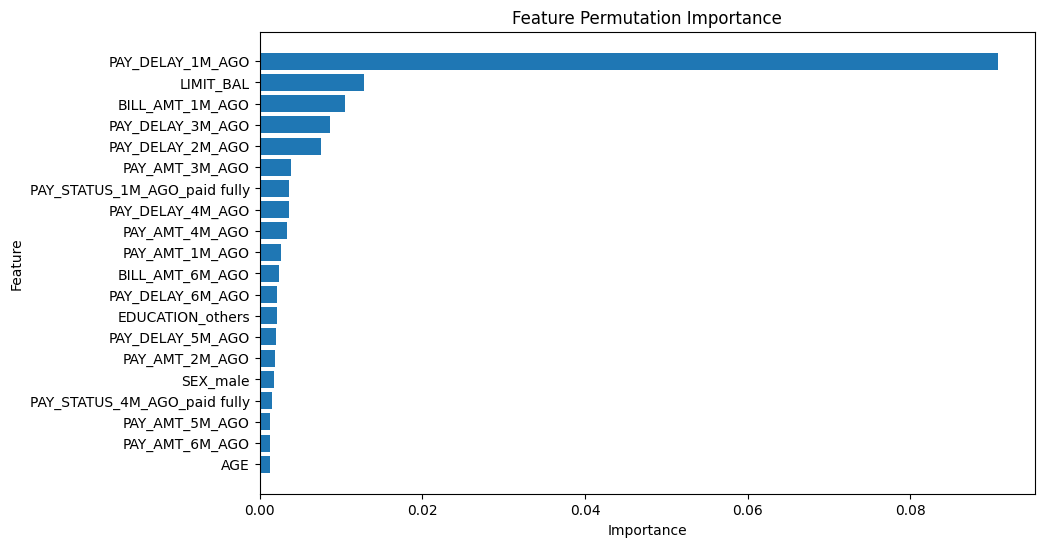

In [ ]:
plot_feat_permut_importance(gbt_feat_permut_import_df)

In [ ]:
gbt_perf, gbt_orig_missing, gbt_missing = measure_performance_decline(
    X_train, X_test, y_test, gbt_classifier, gbt_feat_permut_import_df,
    default_cc_imputation_values_dict, NUM_FEAT, method='simple',
    encoded_vars_family=default_cc_encoded_vars_family
)


--- NEW ITERATION ---
Removing feature:  PAY_DELAY_1M_AGO
Original feat removed so far:  ['PAY_DELAY_1M_AGO']

--- NEW ITERATION ---
Removing feature:  LIMIT_BAL
Original feat removed so far:  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL']

--- NEW ITERATION ---
Removing feature:  BILL_AMT_1M_AGO
Original feat removed so far:  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'BILL_AMT_1M_AGO']

--- NEW ITERATION ---
Removing feature:  PAY_DELAY_3M_AGO
Original feat removed so far:  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'BILL_AMT_1M_AGO', 'PAY_DELAY_3M_AGO']

--- NEW ITERATION ---
Removing feature:  PAY_DELAY_2M_AGO
Original feat removed so far:  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'BILL_AMT_1M_AGO', 'PAY_DELAY_3M_AGO', 'PAY_DELAY_2M_AGO']

--- NEW ITERATION ---
Removing feature:  PAY_AMT_3M_AGO
Original feat removed so far:  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'BILL_AMT_1M_AGO', 'PAY_DELAY_3M_AGO', 'PAY_DELAY_2M_AGO', 'PAY_AMT_3M_AGO']

--- NEW ITERATION ---
Removing feature:  PAY_STATUS_1M_AGO_paid fully
Removing relat

In [ ]:
gbt_perf

tp    tn   fp    fn  precision  recall  specificity  accuracy  f1_score  \
0   822  3731  942   505      46.60   61.94        79.84     75.88     53.19   
1   635  3918  755   692      45.68   47.85        83.84     75.88     46.74   
2   625  3944  729   702      46.16   47.10        84.40     76.15     46.62   
3   489  4255  418   838      53.91   36.85        91.05     79.07     43.78   
4   403  4363  310   924      56.52   30.37        93.37     79.43     39.51   
5   298  4468  205  1029      59.24   22.46        95.61     79.43     32.57   
6   268  4510  163  1059      62.18   20.20        96.51     79.63     30.49   
7   263  4518  155  1064      62.92   19.82        96.68     79.68     30.14   
8   131  4603   70  1196      65.17    9.87        98.50     78.90     17.15   
9    88  4629   44  1239      66.67    6.63        99.06     78.62     12.06   
10   95  4619   54  1232      63.76    7.16        98.84     78.57     12.87   
11   94  4623   50  1233      65.28    7.08        98.93     78.62     12.78   
12    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   
13    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   
14    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   
15    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   
16    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   
17    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   
18    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   
19    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   
20    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   

    balanced_accuracy  num_feat_missing  \
0               70.89                 0   
1               65.85                 1   
2               65.75                 2   
3               63.95                 3   
4               61.87                 4   
5               59.03                 5   
6               58.35                 6   
7               58.25                 7   
8               54.19                 8   
9               52.84                 9   
10              53.00                10   
11              53.01                11   
12              50.00                12   
13              50.00                13   
14              50.00                14   
15              50.00                15   
16              50.00                16   
17              50.00                17   
18              50.00                18   
19              50.00                19   
20              50.00                20   

                                              imputed  
0                                                      
1                        ['PAY_DELAY_1M_AGO'] imputed  
2           ['PAY_DELAY_1M_AGO', 'LIMIT_BAL'] imputed  
3   ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'BILL_AMT_1M...  
4   ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'BILL_AMT_1M...  
5   ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'BILL_AMT_1M...  
6   ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'BILL_AMT_1M...  
7   ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'BILL_AMT_1M...  
8   ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'BILL_AMT_1M...  
9   ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'BILL_AMT_1M...  
10  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'BILL_AMT_1M...  
11  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'BILL_AMT_1M...  
12  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'BILL_AMT_1M...  
13  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'BILL_AMT_1M...  
14  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'BILL_AMT_1M...  
15  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'BILL_AMT_1M...  
16  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'BILL_AMT_1M...  
17  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'BILL_AMT_1M...  
18  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'BILL_AMT_1M...  
19  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'BILL_AMT_1M...  
20  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'BILL_AMT_1M...

In [ ]:
start_time = time.time()
print(datetime.datetime.now())

gbt_perf_mf, gbt_orig_missing_mf, gbt_missing_mf = measure_performance_decline(
    X_train, X_test, y_test, gbt_classifier, gbt_feat_permut_import_df,
    imputation_dict=None, num_feat=NUM_FEAT, method='missforest',
    encoded_vars_family=default_cc_encoded_vars_family,
    categorical_vars=default_cc_cat_vars
)

print(datetime.datetime.now())
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time/60} minutes")

2025-01-18 15:33:37.518844

--- NEW ITERATION ---
Removing feature:  PAY_DELAY_1M_AGO
Nr. columns with nan:  1
Numerical columns:  ['PAY_DELAY_1M_AGO', 'PAY_DELAY_2M_AGO', 'PAY_DELAY_3M_AGO', 'PAY_DELAY_4M_AGO', 'PAY_DELAY_5M_AGO', 'PAY_DELAY_6M_AGO', 'LIMIT_BAL', 'PAY_AMT_1M_AGO', 'PAY_AMT_2M_AGO', 'PAY_AMT_3M_AGO', 'PAY_AMT_4M_AGO', 'PAY_AMT_5M_AGO', 'PAY_AMT_6M_AGO', 'AGE', 'BILL_AMT_1M_AGO', 'BILL_AMT_6M_AGO']
Categorical columns:  ['PAY_STATUS_1M_AGO_revolving credit used', 'PAY_STATUS_3M_AGO_revolving credit used', 'PAY_STATUS_4M_AGO_revolving credit used', 'PAY_STATUS_5M_AGO_revolving credit used', 'PAY_STATUS_6M_AGO_revolving credit used', 'PAY_STATUS_3M_AGO_paid fully', 'PAY_STATUS_2M_AGO_paid fully', 'PAY_STATUS_4M_AGO_paid fully', 'PAY_STATUS_5M_AGO_paid fully', 'PAY_STATUS_6M_AGO_paid fully', 'PAY_STATUS_1M_AGO_paid fully', 'EDUCATION_others', 'SEX_male', 'EDUCATION_university', 'MARRIAGE_single', 'EDUCATION_high school', 'MARRIAGE_others']
Column imputed:  PAY_DELAY_1M_AGO

In [ ]:
gbt_perf_mf

tp    tn    fp   fn  precision  recall  specificity  accuracy  f1_score  \
0    822  3731   942  505      46.60   61.94        79.84     75.88     53.19   
1   1014  2558  2115  313      32.41   76.41        54.74     59.53     45.51   
2    957  2768  1905  370      33.44   72.12        59.23     62.08     45.69   
3    859  3119  1554  468      35.60   64.73        66.75     66.30     45.94   
4    842  3174  1499  485      35.97   63.45        67.92     66.93     45.91   
5    743  3343  1330  584      35.84   55.99        71.54     68.10     43.71   
6    691  3563  1110  636      38.37   52.07        76.25     70.90     44.18   
7    674  3583  1090  653      38.21   50.79        76.67     70.95     43.61   
8    923  2544  2129  404      30.24   69.56        54.44     57.78     42.16   
9    823  2950  1723  504      32.33   62.02        63.13     62.88     42.50   
10   762  3123  1550  565      32.96   57.42        66.83     64.75     41.88   
11   885  2651  2022  442      30.44   66.69        56.73     58.93     41.80   
12  1156  1218  3455  171      25.07   87.11        26.06     39.57     38.94   
13  1170  1129  3544  157      24.82   88.17        24.16     38.32     38.74   
14  1251   616  4057   76      23.57   94.27        13.18     31.12     37.71   
15  1235   486  4187   92      22.78   93.07        10.40     28.68     36.60   
16  1231   509  4164   96      22.82   92.77        10.89     29.00     36.63   
17  1239   492  4181   88      22.86   93.37        10.53     28.85     36.73   
18  1244   357  4316   83      22.37   93.75         7.64     26.68     36.13   
19  1319    48  4625    8      22.19   99.40         1.03     22.78     36.28   
20  1321    45  4628    6      22.21   99.55         0.96     22.77     36.31   

    balanced_accuracy  num_feat_missing  \
0               70.89                 0   
1               65.58                 1   
2               65.68                 2   
3               65.74                 3   
4               65.69                 4   
5               63.76                 5   
6               64.16                 6   
7               63.73                 7   
8               62.00                 8   
9               62.57                 9   
10              62.13                10   
11              61.71                11   
12              56.59                12   
13              56.16                13   
14              53.73                14   
15              51.73                15   
16              51.83                16   
17              51.95                17   
18              50.69                18   
19              50.21                19   
20              50.26                20   

                                              imputed  
0                                                      
1                        ['PAY_DELAY_1M_AGO'] imputed  
2           ['PAY_DELAY_1M_AGO', 'LIMIT_BAL'] imputed  
3   ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'BILL_AMT_1M...  
4   ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'BILL_AMT_1M...  
5   ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'BILL_AMT_1M...  
6   ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'BILL_AMT_1M...  
7   ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'BILL_AMT_1M...  
8   ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'BILL_AMT_1M...  
9   ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'BILL_AMT_1M...  
10  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'BILL_AMT_1M...  
11  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'BILL_AMT_1M...  
12  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'BILL_AMT_1M...  
13  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'BILL_AMT_1M...  
14  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'BILL_AMT_1M...  
15  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'BILL_AMT_1M...  
16  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'BILL_AMT_1M...  
17  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'BILL_AMT_1M...  
18  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'BILL_AMT_1M...  
19  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'BILL_AMT_1M...  
20  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'BILL_AMT_1M...

In [ ]:
gbt_perf_temp, gbt_orig_missing_temp, gbt_missing_temp = measure_temporal_performance_decline(
    X_train, X_test, y_test, gbt_classifier, gbt_feat_permut_import_df,
    default_cc_timeline_vars_family,
    default_cc_imputation_values_dict, NUM_FEAT, method='simple',
    encoded_vars_family=default_cc_encoded_vars_family, log_info=True
)


--- NEW ITERATION ---
original removed:  []
length original removed:  0
num feat:  20
i:  0
length features importance list:  33
length removed:  0

Removing feature:  PAY_DELAY_1M_AGO
Removing related temporal feature:  BILL_AMT_1M_AGO
Removing related temporal feature:  PAY_AMT_1M_AGO
Removing related temporal feature:  PAY_DELAY_1M_AGO
Removing related temporal feature:  PAY_STATUS_1M_AGO_paid fully
Removing related features:  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1M_AGO_revolving credit used']
Removing related temporal feature:  PAY_STATUS_1M_AGO_revolving credit used
Removing related features:  []
Columns with zero variance, i.e. imputed:
                                    feature  variance
0                          PAY_DELAY_1M_AGO       0.0
6   PAY_STATUS_1M_AGO_revolving credit used       0.0
8                            PAY_AMT_1M_AGO       0.0
23             PAY_STATUS_1M_AGO_paid fully       0.0
30                          BILL_AMT_1M_AGO       0.0
Original feat re

In [ ]:
gbt_perf_temp

tp    tn   fp    fn  precision  recall  specificity  accuracy  f1_score  \
0  822  3731  942   505      46.60   61.94        79.84     75.88     53.19   
1  480  4237  436   847      52.40   36.17        90.67     78.62     42.80   
2  470  4281  392   857      54.52   35.42        91.61     79.18     42.94   
3  377  4415  258   950      59.37   28.41        94.48     79.87     38.43   
4  282  4480  193  1045      59.37   21.25        95.87     79.37     31.30   
5   64  4629   44  1263      59.26    4.82        99.06     78.22      8.92   
6    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   
7    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   
8    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   

   balanced_accuracy  num_feat_missing  \
0              70.89                 0   
1              63.42                 4   
2              63.51                 5   
3              61.44                 8   
4              58.56                11   
5              51.94                14   
6              50.00                18   
7              50.00                19   
8              50.00                22   

                                             imputed  
0                                                     
1  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
2  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
3  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
4  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
5  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
6  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
7  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
8  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...

In [ ]:
start_time = time.time()
print(datetime.datetime.now())

gbt_perf_temp_mf, gbt_orig_missing_temp_mf, gbt_missing_temp_mf = measure_temporal_performance_decline(
    X_train, X_test, y_test, gbt_classifier, gbt_feat_permut_import_df,
    default_cc_timeline_vars_family, num_feat=NUM_FEAT, method='missforest',
    encoded_vars_family=default_cc_encoded_vars_family,
    categorical_vars=default_cc_cat_vars, log_info=True
)

print(datetime.datetime.now())
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time/60} minutes")

2025-01-18 15:38:14.384286

--- NEW ITERATION ---
original removed:  []
length original removed:  0
num feat:  20
i:  0
length features importance list:  33
length removed:  0

Removing feature:  PAY_DELAY_1M_AGO
Removing related temporal feature:  BILL_AMT_1M_AGO
Removing related temporal feature:  PAY_AMT_1M_AGO
Removing related temporal feature:  PAY_DELAY_1M_AGO
Removing related temporal feature:  PAY_STATUS_1M_AGO_paid fully
Removing related features:  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1M_AGO_revolving credit used']
Removing related temporal feature:  PAY_STATUS_1M_AGO_revolving credit used
Removing related features:  []
Nr. columns with nan:  5
Numerical columns:  ['PAY_DELAY_1M_AGO', 'PAY_DELAY_2M_AGO', 'PAY_DELAY_3M_AGO', 'PAY_DELAY_4M_AGO', 'PAY_DELAY_5M_AGO', 'PAY_DELAY_6M_AGO', 'LIMIT_BAL', 'PAY_AMT_1M_AGO', 'PAY_AMT_2M_AGO', 'PAY_AMT_3M_AGO', 'PAY_AMT_4M_AGO', 'PAY_AMT_5M_AGO', 'PAY_AMT_6M_AGO', 'AGE', 'BILL_AMT_1M_AGO', 'BILL_AMT_6M_AGO']
Categorical columns:  [

In [ ]:
gbt_perf_temp_mf

tp    tn    fp   fn  precision  recall  specificity  accuracy  f1_score  \
0   822  3731   942  505      46.60   61.94        79.84     75.88     53.19   
1   840  3202  1471  487      36.35   63.30        68.52     67.37     46.18   
2   820  3347  1326  507      38.21   61.79        71.62     69.45     47.22   
3   738  3590  1083  589      40.53   55.61        76.82     72.13     46.89   
4   587  3757   916  740      39.06   44.24        80.40     72.40     41.48   
5   700  3278  1395  627      33.41   52.75        70.15     66.30     40.91   
6  1221   528  4145  106      22.75   92.01        11.30     29.15     36.49   
7  1232   426  4247   95      22.49   92.84         9.12     27.63     36.20   
8  1327     1  4672    0      22.12  100.00         0.02     22.13     36.23   

   balanced_accuracy  num_feat_missing  \
0              70.89                 0   
1              65.91                 4   
2              66.71                 5   
3              66.22                 8   
4              62.32                11   
5              61.45                14   
6              51.66                18   
7              50.98                19   
8              50.01                22   

                                             imputed  
0                                                     
1  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
2  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
3  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
4  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
5  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
6  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
7  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
8  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...

## **XGBoost**

In [ ]:
FINE_TUNE = False

if FINE_TUNE:
  xgb_param_grid = {
      'n_estimators': [100, 200, 300],
      'max_depth': [2, 3, 5, None],
      'reg_lambda':[10.0, 5.0, 1.0, 0.5, 0.0],   # L2 regularization on weights
      'gamma': [1.0, 0.5, 0.1, 0.05, 0.0],       # Minimum loss reduction required for node splitting (default=0)
      'colsample_bytree':[0.25, 0.5, 0.75, 1.0]  # Fraction of features used for each tree
  }
else:
  xgb_param_grid = {
      'n_estimators': [100],
      'max_depth': [2],
      'reg_lambda':[10.0],
      'gamma': [1.0],
      'colsample_bytree':[1.0]
  }

xgb_classifier = XGBClassifier(
    scale_pos_weight=ratio_majority_minority, random_state=RANDOM_STATE
)
xgb_grid_search, xgb_best_model, xgb_best_params = hyperparameter_tuning(
    xgb_classifier, xgb_param_grid, 3, 3, 'f1', X_train, y_train
)

Starting hyperparameter tuning at: 2025-01-18 15:40:02.664837

Nested Cross-validation Results:
Individual scores: [0.53855113 0.54398034 0.54016354]
Average nested CV score: 0.541 (+/- 0.005)

Fitting final model on entire dataset...
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best parameters: {'colsample_bytree': 1.0, 'gamma': 1.0, 'max_depth': 2, 'n_estimators': 100, 'reg_lambda': 10.0}

Best Model Performance:
Best CV score: 0.541
2025-01-18 15:40:05.632297

Execution time: 0.05 minutes


```
Starting hyperparameter tuning at: 2025-01-17 12:03:54.738974

Nested Cross-validation Results:
Individual scores: [0.53532292 0.53810791 0.53984207]
Average nested CV score: 0.538 (+/- 0.004)

Fitting final model on entire dataset...
Fitting 3 folds for each of 1200 candidates, totalling 3600 fits
Best parameters: {'colsample_bytree': 1.0, 'gamma': 1.0, 'max_depth': 2, 'n_estimators': 100, 'reg_lambda': 10.0}

Best Model Performance:
Best CV score: 0.541
2025-01-17 12:20:39.024880

Execution time: 16.74 minutes
```

In [ ]:
xgb_classifier, xgb_train_pred, xgb_test_pred = apply_model(xgb_best_model, X_train, y_train, X_test, y_test)
xgb_feat_permut_import_df = analyze_feat_permut_import(xgb_classifier, X_train, y_train, scoring_metric="f1")
xgb_feat_permut_import_df[xgb_feat_permut_import_df['Importance']!=0]

Feature  Importance       Std
0                          PAY_DELAY_1M_AGO    0.086440  0.001698
7                                 LIMIT_BAL    0.021447  0.001394
30                          BILL_AMT_1M_AGO    0.017557  0.002046
1                          PAY_DELAY_2M_AGO    0.007974  0.001278
2                          PAY_DELAY_3M_AGO    0.005002  0.001250
3                          PAY_DELAY_4M_AGO    0.004954  0.000411
31                          BILL_AMT_6M_AGO    0.003834  0.000662
12                           PAY_AMT_4M_AGO    0.003474  0.002003
29                                      AGE    0.003187  0.000538
23             PAY_STATUS_1M_AGO_paid fully    0.003024  0.001196
9                            PAY_AMT_2M_AGO    0.002909  0.000804
27                          MARRIAGE_single    0.002504  0.000559
4                          PAY_DELAY_5M_AGO    0.002042  0.000351
24                         EDUCATION_others    0.002009  0.000455
11                           PAY_AMT_3M_AGO    0.001851  0.001258
13                           PAY_AMT_5M_AGO    0.001705  0.000785
25                                 SEX_male    0.001607  0.000739
14  PAY_STATUS_4M_AGO_revolving credit used    0.001594  0.000441
17  PAY_STATUS_6M_AGO_revolving credit used    0.001457  0.000307
16  PAY_STATUS_5M_AGO_revolving credit used    0.001407  0.000685
8                            PAY_AMT_1M_AGO    0.001239  0.001099
15                           PAY_AMT_6M_AGO    0.001233  0.000995
19             PAY_STATUS_2M_AGO_paid fully    0.000504  0.000293
32                          MARRIAGE_others    0.000456  0.000189
22             PAY_STATUS_6M_AGO_paid fully    0.000328  0.000211
5                          PAY_DELAY_6M_AGO    0.000309  0.001063
26                     EDUCATION_university    0.000195  0.000193
18             PAY_STATUS_3M_AGO_paid fully   -0.000367  0.000705
6   PAY_STATUS_1M_AGO_revolving credit used   -0.000618  0.000831

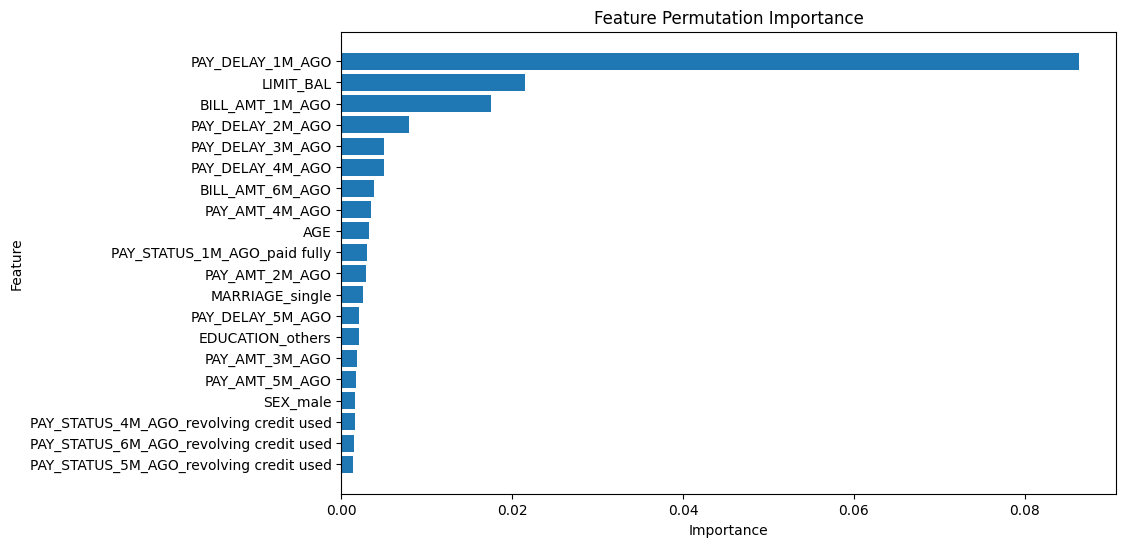

In [ ]:
plot_feat_permut_importance(xgb_feat_permut_import_df)

In [ ]:
xgb_perf, xgb_orig_missing, xgb_missing = measure_performance_decline(
    X_train, X_test, y_test, xgb_classifier, xgb_feat_permut_import_df,
    default_cc_imputation_values_dict, NUM_FEAT, method='simple',
    encoded_vars_family=default_cc_encoded_vars_family
)


--- NEW ITERATION ---
Removing feature:  PAY_DELAY_1M_AGO
Original feat removed so far:  ['PAY_DELAY_1M_AGO']

--- NEW ITERATION ---
Removing feature:  LIMIT_BAL
Original feat removed so far:  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL']

--- NEW ITERATION ---
Removing feature:  BILL_AMT_1M_AGO
Original feat removed so far:  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'BILL_AMT_1M_AGO']

--- NEW ITERATION ---
Removing feature:  PAY_DELAY_2M_AGO
Original feat removed so far:  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'BILL_AMT_1M_AGO', 'PAY_DELAY_2M_AGO']

--- NEW ITERATION ---
Removing feature:  PAY_DELAY_3M_AGO
Original feat removed so far:  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'BILL_AMT_1M_AGO', 'PAY_DELAY_2M_AGO', 'PAY_DELAY_3M_AGO']

--- NEW ITERATION ---
Removing feature:  PAY_DELAY_4M_AGO
Original feat removed so far:  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'BILL_AMT_1M_AGO', 'PAY_DELAY_2M_AGO', 'PAY_DELAY_3M_AGO', 'PAY_DELAY_4M_AGO']

--- NEW ITERATION ---
Removing feature:  BILL_AMT_6M_AGO
Original feat removed s

In [ ]:
xgb_perf

tp    tn   fp    fn  precision  recall  specificity  accuracy  f1_score  \
0   809  3724  949   518      46.02   60.96        79.69     75.55     52.45   
1   635  3923  750   692      45.85   47.85        83.95     75.97     46.83   
2   636  3862  811   691      43.95   47.93        82.64     74.97     45.85   
3   464  4286  387   863      54.52   34.97        91.72     79.17     42.61   
4   375  4380  293   952      56.14   28.26        93.73     79.25     37.59   
5   284  4482  191  1043      59.79   21.40        95.91     79.43     31.52   
6   151  4572  101  1176      59.92   11.38        97.84     78.72     19.13   
7   167  4539  134  1160      55.48   12.58        97.13     78.43     20.52   
8   137  4584   89  1190      60.62   10.32        98.10     78.68     17.64   
9   127  4599   74  1200      63.18    9.57        98.42     78.77     16.62   
10  123  4604   69  1204      64.06    9.27        98.52     78.78     16.19   
11   91  4617   56  1236      61.90    6.86        98.80     78.47     12.35   
12   53  4645   28  1274      65.43    3.99        99.40     78.30      7.53   
13    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   
14    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   
15    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   
16    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   
17    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   
18    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   
19    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   
20    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   

    balanced_accuracy  num_feat_missing  \
0               70.33                 0   
1               65.90                 1   
2               65.29                 2   
3               63.34                 3   
4               60.99                 4   
5               58.66                 5   
6               54.61                 6   
7               54.86                 7   
8               54.21                 8   
9               53.99                 9   
10              53.90                10   
11              52.83                11   
12              51.70                12   
13              50.00                13   
14              50.00                14   
15              50.00                15   
16              50.00                16   
17              50.00                17   
18              50.00                18   
19              50.00                19   
20              50.00                20   

                                              imputed  
0                                                      
1                        ['PAY_DELAY_1M_AGO'] imputed  
2           ['PAY_DELAY_1M_AGO', 'LIMIT_BAL'] imputed  
3   ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'BILL_AMT_1M...  
4   ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'BILL_AMT_1M...  
5   ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'BILL_AMT_1M...  
6   ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'BILL_AMT_1M...  
7   ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'BILL_AMT_1M...  
8   ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'BILL_AMT_1M...  
9   ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'BILL_AMT_1M...  
10  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'BILL_AMT_1M...  
11  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'BILL_AMT_1M...  
12  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'BILL_AMT_1M...  
13  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'BILL_AMT_1M...  
14  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'BILL_AMT_1M...  
15  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'BILL_AMT_1M...  
16  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'BILL_AMT_1M...  
17  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'BILL_AMT_1M...  
18  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'BILL_AMT_1M...  
19  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'BILL_AMT_1M...  
20  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'BILL_AMT_1M...

In [ ]:
start_time = time.time()
print(datetime.datetime.now())

xgb_perf_mf, xgb_orig_missing_mf, xgb_missing_mf = measure_performance_decline(
    X_train, X_test, y_test, xgb_classifier, xgb_feat_permut_import_df,
    imputation_dict=None, num_feat=NUM_FEAT, method='missforest',
    encoded_vars_family=default_cc_encoded_vars_family,
    categorical_vars=default_cc_cat_vars
)

print(datetime.datetime.now())
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time/60} minutes")

2025-01-18 15:40:08.147789

--- NEW ITERATION ---
Removing feature:  PAY_DELAY_1M_AGO
Nr. columns with nan:  1
Numerical columns:  ['PAY_DELAY_1M_AGO', 'PAY_DELAY_2M_AGO', 'PAY_DELAY_3M_AGO', 'PAY_DELAY_4M_AGO', 'PAY_DELAY_5M_AGO', 'PAY_DELAY_6M_AGO', 'LIMIT_BAL', 'PAY_AMT_1M_AGO', 'PAY_AMT_2M_AGO', 'PAY_AMT_3M_AGO', 'PAY_AMT_4M_AGO', 'PAY_AMT_5M_AGO', 'PAY_AMT_6M_AGO', 'AGE', 'BILL_AMT_1M_AGO', 'BILL_AMT_6M_AGO']
Categorical columns:  ['PAY_STATUS_1M_AGO_revolving credit used', 'PAY_STATUS_3M_AGO_revolving credit used', 'PAY_STATUS_4M_AGO_revolving credit used', 'PAY_STATUS_5M_AGO_revolving credit used', 'PAY_STATUS_6M_AGO_revolving credit used', 'PAY_STATUS_3M_AGO_paid fully', 'PAY_STATUS_2M_AGO_paid fully', 'PAY_STATUS_4M_AGO_paid fully', 'PAY_STATUS_5M_AGO_paid fully', 'PAY_STATUS_6M_AGO_paid fully', 'PAY_STATUS_1M_AGO_paid fully', 'EDUCATION_others', 'SEX_male', 'EDUCATION_university', 'MARRIAGE_single', 'EDUCATION_high school', 'MARRIAGE_others']
Column imputed:  PAY_DELAY_1M_AGO

In [ ]:
xgb_perf_mf

tp    tn   fp    fn  precision  recall  specificity  accuracy  f1_score  \
0   809  3724  949   518      46.02   60.96        79.69     75.55     52.45   
1   689  3863  810   638      45.96   51.92        82.67     75.87     48.76   
2   643  3961  712   684      47.45   48.46        84.76     76.73     47.95   
3   585  4109  564   742      50.91   44.08        87.93     78.23     47.25   
4   426  4280  393   901      52.01   32.10        91.59     78.43     39.70   
5   358  4368  305   969      54.00   26.98        93.47     78.77     35.98   
6   257  4443  230  1070      52.77   19.37        95.08     78.33     28.34   
7   234  4481  192  1093      54.93   17.63        95.89     78.58     26.70   
8   207  4539  134  1120      60.70   15.60        97.13     79.10     24.82   
9   200  4553  120  1127      62.50   15.07        97.43     79.22     24.29   
10  200  4552  121  1127      62.31   15.07        97.41     79.20     24.27   
11  163  4581   92  1164      63.92   12.28        98.03     79.07     20.61   
12  171  4577   96  1156      64.04   12.89        97.95     79.13     21.46   
13   34  4661   12  1293      73.91    2.56        99.74     78.25      4.95   
14   14  4667    6  1313      70.00    1.06        99.87     78.02      2.08   
15    9  4671    2  1318      81.82    0.68        99.96     78.00      1.35   
16    9  4671    2  1318      81.82    0.68        99.96     78.00      1.35   
17    9  4671    2  1318      81.82    0.68        99.96     78.00      1.35   
18    9  4671    2  1318      81.82    0.68        99.96     78.00      1.35   
19    9  4671    2  1318      81.82    0.68        99.96     78.00      1.35   
20    9  4671    2  1318      81.82    0.68        99.96     78.00      1.35   

    balanced_accuracy  num_feat_missing  \
0               70.33                 0   
1               67.29                 1   
2               66.61                 2   
3               66.01                 3   
4               61.85                 4   
5               60.23                 5   
6               57.22                 6   
7               56.76                 7   
8               56.37                 8   
9               56.25                 9   
10              56.24                10   
11              55.16                11   
12              55.42                12   
13              51.15                13   
14              50.46                14   
15              50.32                15   
16              50.32                16   
17              50.32                17   
18              50.32                18   
19              50.32                19   
20              50.32                20   

                                              imputed  
0                                                      
1                        ['PAY_DELAY_1M_AGO'] imputed  
2           ['PAY_DELAY_1M_AGO', 'LIMIT_BAL'] imputed  
3   ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'BILL_AMT_1M...  
4   ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'BILL_AMT_1M...  
5   ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'BILL_AMT_1M...  
6   ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'BILL_AMT_1M...  
7   ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'BILL_AMT_1M...  
8   ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'BILL_AMT_1M...  
9   ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'BILL_AMT_1M...  
10  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'BILL_AMT_1M...  
11  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'BILL_AMT_1M...  
12  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'BILL_AMT_1M...  
13  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'BILL_AMT_1M...  
14  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'BILL_AMT_1M...  
15  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'BILL_AMT_1M...  
16  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'BILL_AMT_1M...  
17  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'BILL_AMT_1M...  
18  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'BILL_AMT_1M...  
19  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'BILL_AMT_1M...  
20  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'BILL_AMT_1M...

In [ ]:
xgb_perf_temp, xgb_orig_missing_temp, xgb_missing_temp = measure_temporal_performance_decline(
    X_train, X_test, y_test, xgb_classifier, xgb_feat_permut_import_df,
    default_cc_timeline_vars_family,
    default_cc_imputation_values_dict, NUM_FEAT, method='simple',
    encoded_vars_family=default_cc_encoded_vars_family, log_info=True
)


--- NEW ITERATION ---
original removed:  []
length original removed:  0
num feat:  20
i:  0
length features importance list:  33
length removed:  0

Removing feature:  PAY_DELAY_1M_AGO
Removing related temporal feature:  BILL_AMT_1M_AGO
Removing related temporal feature:  PAY_AMT_1M_AGO
Removing related temporal feature:  PAY_DELAY_1M_AGO
Removing related temporal feature:  PAY_STATUS_1M_AGO_paid fully
Removing related features:  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1M_AGO_revolving credit used']
Removing related temporal feature:  PAY_STATUS_1M_AGO_revolving credit used
Removing related features:  []
Columns with zero variance, i.e. imputed:
                                    feature  variance
0                          PAY_DELAY_1M_AGO       0.0
6   PAY_STATUS_1M_AGO_revolving credit used       0.0
8                            PAY_AMT_1M_AGO       0.0
23             PAY_STATUS_1M_AGO_paid fully       0.0
30                          BILL_AMT_1M_AGO       0.0
Original feat re

In [ ]:
xgb_perf_temp

tp    tn   fp    fn  precision  recall  specificity  accuracy  f1_score  \
0  809  3724  949   518      46.02   60.96        79.69     75.55     52.45   
1  447  4307  366   880      54.98   33.69        92.17     79.23     41.78   
2  425  4345  328   902      56.44   32.03        92.98     79.50     40.87   
3  312  4454  219  1015      58.76   23.51        95.31     79.43     33.58   
4  233  4522  151  1094      60.68   17.56        96.77     79.25     27.24   
5   45  4646   27  1282      62.50    3.39        99.42     78.18      6.43   
6    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   
7    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   
8    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   

   balanced_accuracy  num_feat_missing  \
0              70.33                 0   
1              62.93                 4   
2              62.50                 5   
3              59.41                 8   
4              57.16                11   
5              51.41                14   
6              50.00                18   
7              50.00                19   
8              50.00                20   

                                             imputed  
0                                                     
1  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
2  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
3  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
4  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
5  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
6  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
7  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
8  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...

In [ ]:
start_time = time.time()
print(datetime.datetime.now())

xgb_perf_temp_mf, xgb_orig_missing_temp_mf, xgb_missing_temp_mf = measure_temporal_performance_decline(
    X_train, X_test, y_test, xgb_classifier, xgb_feat_permut_import_df,
    default_cc_timeline_vars_family, num_feat=NUM_FEAT, method='missforest',
    encoded_vars_family=default_cc_encoded_vars_family,
    categorical_vars=default_cc_cat_vars, log_info=True
)

print(datetime.datetime.now())
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time/60} minutes")

2025-01-18 15:44:42.220098

--- NEW ITERATION ---
original removed:  []
length original removed:  0
num feat:  20
i:  0
length features importance list:  33
length removed:  0

Removing feature:  PAY_DELAY_1M_AGO
Removing related temporal feature:  BILL_AMT_1M_AGO
Removing related temporal feature:  PAY_AMT_1M_AGO
Removing related temporal feature:  PAY_DELAY_1M_AGO
Removing related temporal feature:  PAY_STATUS_1M_AGO_paid fully
Removing related features:  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1M_AGO_revolving credit used']
Removing related temporal feature:  PAY_STATUS_1M_AGO_revolving credit used
Removing related features:  []
Nr. columns with nan:  5
Numerical columns:  ['PAY_DELAY_1M_AGO', 'PAY_DELAY_2M_AGO', 'PAY_DELAY_3M_AGO', 'PAY_DELAY_4M_AGO', 'PAY_DELAY_5M_AGO', 'PAY_DELAY_6M_AGO', 'LIMIT_BAL', 'PAY_AMT_1M_AGO', 'PAY_AMT_2M_AGO', 'PAY_AMT_3M_AGO', 'PAY_AMT_4M_AGO', 'PAY_AMT_5M_AGO', 'PAY_AMT_6M_AGO', 'AGE', 'BILL_AMT_1M_AGO', 'BILL_AMT_6M_AGO']
Categorical columns:  [

In [ ]:
xgb_perf_temp_mf

tp    tn   fp    fn  precision  recall  specificity  accuracy  f1_score  \
0  809  3724  949   518      46.02   60.96        79.69     75.55     52.45   
1  589  4061  612   738      49.04   44.39        86.90     77.50     46.60   
2  552  4166  507   775      52.12   41.60        89.15     78.63     46.27   
3  378  4385  288   949      56.76   28.49        93.84     79.38     37.93   
4  241  4519  154  1086      61.01   18.16        96.70     79.33     27.99   
5  142  4589   84  1185      62.83   10.70        98.20     78.85     18.29   
6   31  4658   15  1296      67.39    2.34        99.68     78.15      4.52   
7   28  4659   14  1299      66.67    2.11        99.70     78.12      4.09   
8   26  4660   13  1301      66.67    1.96        99.72     78.10      3.81   

   balanced_accuracy  num_feat_missing  \
0              70.33                 0   
1              65.64                 4   
2              65.37                 5   
3              61.16                 8   
4              57.43                11   
5              54.45                14   
6              51.01                18   
7              50.91                19   
8              50.84                20   

                                             imputed  
0                                                     
1  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
2  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
3  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
4  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
5  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
6  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
7  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
8  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...

## **Extra Trees Classifier**

In [ ]:
FINE_TUNE = False

if FINE_TUNE:
  et_param_grid = {
      'n_estimators': [100, 200, 300, 500],
      'max_depth': [2, 3, 5, None],
      'max_features':['sqrt', 0.5, 1.0],
      'min_samples_split': [0.005, 0.001, 2],
      'min_samples_leaf': [0.005, 0.001, 1]
  }
else:
  et_param_grid = {
      'n_estimators': [500],
      'max_depth': [None],
      'max_features':['sqrt'],
      'min_samples_split': [0.005],
      'min_samples_leaf': [1]
  }

et_classifier = ExtraTreesClassifier(class_weight='balanced', random_state=RANDOM_STATE)
et_grid_search, et_best_model, et_best_params = hyperparameter_tuning(
    et_classifier, et_param_grid, 3, 3, 'f1', X_train, y_train
)

Starting hyperparameter tuning at: 2025-01-18 15:46:30.440010

Nested Cross-validation Results:
Individual scores: [0.54509018 0.53813333 0.54015345]
Average nested CV score: 0.541 (+/- 0.006)

Fitting final model on entire dataset...
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best parameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 0.005, 'n_estimators': 500}

Best Model Performance:
Best CV score: 0.541
2025-01-18 15:46:59.402061

Execution time: 0.48 minutes


```
Starting hyperparameter tuning at: 2025-01-17 13:37:33.795973

Nested Cross-validation Results:
Individual scores: [0.54463616 0.53514247 0.53916211]
Average nested CV score: 0.540 (+/- 0.008)

Fitting final model on entire dataset...
Fitting 3 folds for each of 432 candidates, totalling 1296 fits
Best parameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 0.005, 'n_estimators': 500}

Best Model Performance:
Best CV score: 0.541
2025-01-17 14:20:53.270481

Execution time: 43.32 minutes
```

In [ ]:
# et_grid_search.cv_results_

In [ ]:
et_classifier, train_pred, test_pred = apply_model(et_best_model, X_train, y_train, X_test, y_test)
et_feat_permut_import_df = analyze_feat_permut_import(et_classifier, X_train, y_train, scoring_metric="f1")
et_feat_permut_import_df[et_feat_permut_import_df['Importance']!=0]

Feature  Importance       Std
0                          PAY_DELAY_1M_AGO    0.051786  0.001278
6   PAY_STATUS_1M_AGO_revolving credit used    0.037300  0.001311
7                                 LIMIT_BAL    0.018239  0.001719
1                          PAY_DELAY_2M_AGO    0.018143  0.001886
17  PAY_STATUS_6M_AGO_revolving credit used    0.017500  0.000843
10  PAY_STATUS_3M_AGO_revolving credit used    0.016592  0.000726
30                          BILL_AMT_1M_AGO    0.015373  0.001570
31                          BILL_AMT_6M_AGO    0.014242  0.001709
25                                 SEX_male    0.014047  0.001483
26                     EDUCATION_university    0.012701  0.001125
16  PAY_STATUS_5M_AGO_revolving credit used    0.011660  0.001151
27                          MARRIAGE_single    0.011548  0.000632
19             PAY_STATUS_2M_AGO_paid fully    0.011087  0.000409
14  PAY_STATUS_4M_AGO_revolving credit used    0.010857  0.000730
18             PAY_STATUS_3M_AGO_paid fully    0.009891  0.000543
8                            PAY_AMT_1M_AGO    0.009808  0.000995
11                           PAY_AMT_3M_AGO    0.009698  0.001559
20             PAY_STATUS_4M_AGO_paid fully    0.009610  0.000959
29                                      AGE    0.009112  0.000927
22             PAY_STATUS_6M_AGO_paid fully    0.008832  0.000862
13                           PAY_AMT_5M_AGO    0.008604  0.002227
12                           PAY_AMT_4M_AGO    0.008401  0.000694
23             PAY_STATUS_1M_AGO_paid fully    0.008365  0.000388
21             PAY_STATUS_5M_AGO_paid fully    0.008016  0.000439
2                          PAY_DELAY_3M_AGO    0.007319  0.001370
9                            PAY_AMT_2M_AGO    0.007050  0.001264
15                           PAY_AMT_6M_AGO    0.006847  0.001392
3                          PAY_DELAY_4M_AGO    0.005950  0.000821
28                    EDUCATION_high school    0.005894  0.000420
4                          PAY_DELAY_5M_AGO    0.005155  0.001064
5                          PAY_DELAY_6M_AGO    0.002459  0.000500
24                         EDUCATION_others    0.002337  0.000924
32                          MARRIAGE_others    0.000944  0.000036

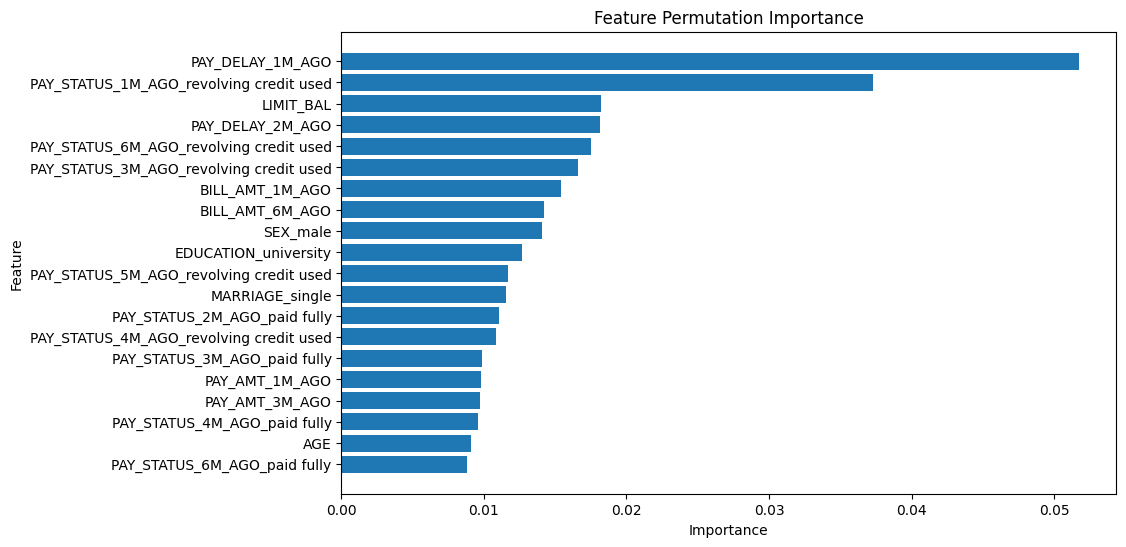

In [ ]:
plot_feat_permut_importance(et_feat_permut_import_df)

In [ ]:
et_perf, et_orig_missing, et_missing = measure_performance_decline(
    X_train, X_test, y_test, et_classifier, et_feat_permut_import_df,
    default_cc_imputation_values_dict, NUM_FEAT, method='simple',
    encoded_vars_family=default_cc_encoded_vars_family
)


--- NEW ITERATION ---
Removing feature:  PAY_DELAY_1M_AGO
Original feat removed so far:  ['PAY_DELAY_1M_AGO']

--- NEW ITERATION ---
Removing feature:  PAY_STATUS_1M_AGO_revolving credit used
Removing related features:  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1M_AGO_revolving credit used']
Original feat removed so far:  ['PAY_DELAY_1M_AGO', 'PAY_STATUS_1M_AGO']

--- NEW ITERATION ---
Removing feature:  LIMIT_BAL
Original feat removed so far:  ['PAY_DELAY_1M_AGO', 'PAY_STATUS_1M_AGO', 'LIMIT_BAL']

--- NEW ITERATION ---
Removing feature:  PAY_DELAY_2M_AGO
Original feat removed so far:  ['PAY_DELAY_1M_AGO', 'PAY_STATUS_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_2M_AGO']

--- NEW ITERATION ---
Removing feature:  PAY_STATUS_6M_AGO_revolving credit used
Removing related features:  ['PAY_STATUS_6M_AGO_paid fully', 'PAY_STATUS_6M_AGO_revolving credit used']
Original feat removed so far:  ['PAY_DELAY_1M_AGO', 'PAY_STATUS_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_2M_AGO', 'PAY_STATUS_6M_AGO']

--- NEW ITERA

In [ ]:
et_perf

tp    tn   fp   fn  precision  recall  specificity  accuracy  f1_score  \
0   774  3877  796  553      49.30   58.33        82.97     77.52     53.43   
1   647  4017  656  680      49.65   48.76        85.96     77.73     49.20   
2   727  3699  974  600      42.74   54.79        79.16     73.77     48.02   
3   686  3837  836  641      45.07   51.70        82.11     75.38     48.16   
4   597  3955  718  730      45.40   44.99        84.64     75.87     45.19   
5   546  4060  613  781      47.11   41.15        86.88     76.77     43.93   
6   529  4072  601  798      46.81   39.86        87.14     76.68     43.06   
7   525  4068  605  802      46.46   39.56        87.05     76.55     42.74   
8   515  4105  568  812      47.55   38.81        87.85     77.00     42.74   
9   486  4192  481  841      50.26   36.62        89.71     77.97     42.37   
10  494  4178  495  833      49.95   37.23        89.41     77.87     42.66   
11  473  4204  469  854      50.21   35.64        89.96     77.95     41.69   
12  439  4257  416  888      51.35   33.08        91.10     78.27     40.24   
13  449  4251  422  878      51.55   33.84        90.97     78.33     40.86   
14  450  4252  421  877      51.66   33.91        90.99     78.37     40.95   
15  449  4264  409  878      52.33   33.84        91.25     78.55     41.10   
16  445  4270  403  882      52.48   33.53        91.38     78.58     40.92   
17  428  4295  378  899      53.10   32.25        91.91     78.72     40.13   
18  428  4290  383  899      52.77   32.25        91.80     78.63     40.04   
19  431  4289  384  896      52.88   32.48        91.78     78.67     40.24   
20  409  4316  357  918      53.39   30.82        92.36     78.75     39.08   

    balanced_accuracy  num_feat_missing  \
0               70.65                 0   
1               67.36                 1   
2               66.97                 2   
3               66.90                 3   
4               64.81                 4   
5               64.01                 5   
6               63.50                 6   
7               63.31                 7   
8               63.33                 8   
9               63.17                 9   
10              63.32                10   
11              62.80                11   
12              62.09                12   
13              62.40                13   
14              62.45                14   
15              62.54                15   
16              62.46                16   
17              62.08                17   
18              62.03                18   
19              62.13                19   
20              61.59                20   

                                              imputed  
0                                                      
1                        ['PAY_DELAY_1M_AGO'] imputed  
2   ['PAY_DELAY_1M_AGO', 'PAY_STATUS_1M_AGO_paid f...  
3   ['PAY_DELAY_1M_AGO', 'PAY_STATUS_1M_AGO_paid f...  
4   ['PAY_DELAY_1M_AGO', 'PAY_STATUS_1M_AGO_paid f...  
5   ['PAY_DELAY_1M_AGO', 'PAY_STATUS_1M_AGO_paid f...  
6   ['PAY_DELAY_1M_AGO', 'PAY_STATUS_1M_AGO_paid f...  
7   ['PAY_DELAY_1M_AGO', 'PAY_STATUS_1M_AGO_paid f...  
8   ['PAY_DELAY_1M_AGO', 'PAY_STATUS_1M_AGO_paid f...  
9   ['PAY_DELAY_1M_AGO', 'PAY_STATUS_1M_AGO_paid f...  
10  ['PAY_DELAY_1M_AGO', 'PAY_STATUS_1M_AGO_paid f...  
11  ['PAY_DELAY_1M_AGO', 'PAY_STATUS_1M_AGO_paid f...  
12  ['PAY_DELAY_1M_AGO', 'PAY_STATUS_1M_AGO_paid f...  
13  ['PAY_DELAY_1M_AGO', 'PAY_STATUS_1M_AGO_paid f...  
14  ['PAY_DELAY_1M_AGO', 'PAY_STATUS_1M_AGO_paid f...  
15  ['PAY_DELAY_1M_AGO', 'PAY_STATUS_1M_AGO_paid f...  
16  ['PAY_DELAY_1M_AGO', 'PAY_STATUS_1M_AGO_paid f...  
17  ['PAY_DELAY_1M_AGO', 'PAY_STATUS_1M_AGO_paid f...  
18  ['PAY_DELAY_1M_AGO', 'PAY_STATUS_1M_AGO_paid f...  
19  ['PAY_DELAY_1M_AGO', 'PAY_STATUS_1M_AGO_paid f...  
20  ['PAY_DELAY_1M_AGO', 'PAY_STATUS_1M_AGO_paid f...

In [ ]:
start_time = time.time()
print(datetime.datetime.now())

et_perf_mf, et_orig_missing_mf, et_missing_mf = measure_performance_decline(
    X_train, X_test, y_test, et_classifier, et_feat_permut_import_df,
    imputation_dict=None, num_feat=NUM_FEAT, method='missforest',
    encoded_vars_family=default_cc_encoded_vars_family,
    categorical_vars=default_cc_cat_vars
)

print(datetime.datetime.now())
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time/60} minutes")

2025-01-18 15:47:50.024240

--- NEW ITERATION ---
Removing feature:  PAY_DELAY_1M_AGO
Nr. columns with nan:  1
Numerical columns:  ['PAY_DELAY_1M_AGO', 'PAY_DELAY_2M_AGO', 'PAY_DELAY_3M_AGO', 'PAY_DELAY_4M_AGO', 'PAY_DELAY_5M_AGO', 'PAY_DELAY_6M_AGO', 'LIMIT_BAL', 'PAY_AMT_1M_AGO', 'PAY_AMT_2M_AGO', 'PAY_AMT_3M_AGO', 'PAY_AMT_4M_AGO', 'PAY_AMT_5M_AGO', 'PAY_AMT_6M_AGO', 'AGE', 'BILL_AMT_1M_AGO', 'BILL_AMT_6M_AGO']
Categorical columns:  ['PAY_STATUS_1M_AGO_revolving credit used', 'PAY_STATUS_3M_AGO_revolving credit used', 'PAY_STATUS_4M_AGO_revolving credit used', 'PAY_STATUS_5M_AGO_revolving credit used', 'PAY_STATUS_6M_AGO_revolving credit used', 'PAY_STATUS_3M_AGO_paid fully', 'PAY_STATUS_2M_AGO_paid fully', 'PAY_STATUS_4M_AGO_paid fully', 'PAY_STATUS_5M_AGO_paid fully', 'PAY_STATUS_6M_AGO_paid fully', 'PAY_STATUS_1M_AGO_paid fully', 'EDUCATION_others', 'SEX_male', 'EDUCATION_university', 'MARRIAGE_single', 'EDUCATION_high school', 'MARRIAGE_others']
Column imputed:  PAY_DELAY_1M_AGO

In [ ]:
et_perf_mf

tp    tn   fp    fn  precision  recall  specificity  accuracy  f1_score  \
0   774  3877  796   553      49.30   58.33        82.97     77.52     53.43   
1   697  3907  766   630      47.64   52.52        83.61     76.73     49.96   
2   640  3940  733   687      46.61   48.23        84.31     76.33     47.41   
3   617  3965  708   710      46.57   46.50        84.85     76.37     46.53   
4   562  4010  663   765      45.88   42.35        85.81     76.20     44.04   
5   548  4060  613   779      47.20   41.30        86.88     76.80     44.05   
6   406  4310  363   921      52.80   30.60        92.23     78.60     38.74   
7   391  4359  314   936      55.46   29.46        93.28     79.17     38.48   
8   395  4355  318   932      55.40   29.77        93.19     79.17     38.73   
9   396  4356  317   931      55.54   29.84        93.22     79.20     38.82   
10  402  4345  328   925      55.07   30.29        92.98     79.12     39.09   
11  357  4392  281   970      55.96   26.90        93.99     79.15     36.34   
12  351  4406  267   976      56.80   26.45        94.29     79.28     36.09   
13  348  4407  266   979      56.68   26.22        94.31     79.25     35.86   
14  313  4454  219  1014      58.83   23.59        95.31     79.45     33.67   
15  283  4490  183  1044      60.73   21.33        96.08     79.55     31.57   
16  290  4488  185  1037      61.05   21.85        96.04     79.63     32.19   
17  274  4502  171  1053      61.57   20.65        96.34     79.60     30.93   
18  270  4511  162  1057      62.50   20.35        96.53     79.68     30.70   
19  269  4516  157  1058      63.15   20.27        96.64     79.75     30.69   
20  221  4547  126  1106      63.69   16.65        97.30     79.47     26.40   

    balanced_accuracy  num_feat_missing  \
0               70.65                 0   
1               68.07                 1   
2               66.27                 2   
3               65.67                 3   
4               64.08                 4   
5               64.09                 5   
6               61.41                 6   
7               61.37                 7   
8               61.48                 8   
9               61.53                 9   
10              61.64                10   
11              60.44                11   
12              60.37                12   
13              60.27                13   
14              59.45                14   
15              58.71                15   
16              58.95                16   
17              58.49                17   
18              58.44                18   
19              58.46                19   
20              56.98                20   

                                              imputed  
0                                                      
1                        ['PAY_DELAY_1M_AGO'] imputed  
2   ['PAY_DELAY_1M_AGO', 'PAY_STATUS_1M_AGO_paid f...  
3   ['PAY_DELAY_1M_AGO', 'PAY_STATUS_1M_AGO_paid f...  
4   ['PAY_DELAY_1M_AGO', 'PAY_STATUS_1M_AGO_paid f...  
5   ['PAY_DELAY_1M_AGO', 'PAY_STATUS_1M_AGO_paid f...  
6   ['PAY_DELAY_1M_AGO', 'PAY_STATUS_1M_AGO_paid f...  
7   ['PAY_DELAY_1M_AGO', 'PAY_STATUS_1M_AGO_paid f...  
8   ['PAY_DELAY_1M_AGO', 'PAY_STATUS_1M_AGO_paid f...  
9   ['PAY_DELAY_1M_AGO', 'PAY_STATUS_1M_AGO_paid f...  
10  ['PAY_DELAY_1M_AGO', 'PAY_STATUS_1M_AGO_paid f...  
11  ['PAY_DELAY_1M_AGO', 'PAY_STATUS_1M_AGO_paid f...  
12  ['PAY_DELAY_1M_AGO', 'PAY_STATUS_1M_AGO_paid f...  
13  ['PAY_DELAY_1M_AGO', 'PAY_STATUS_1M_AGO_paid f...  
14  ['PAY_DELAY_1M_AGO', 'PAY_STATUS_1M_AGO_paid f...  
15  ['PAY_DELAY_1M_AGO', 'PAY_STATUS_1M_AGO_paid f...  
16  ['PAY_DELAY_1M_AGO', 'PAY_STATUS_1M_AGO_paid f...  
17  ['PAY_DELAY_1M_AGO', 'PAY_STATUS_1M_AGO_paid f...  
18  ['PAY_DELAY_1M_AGO', 'PAY_STATUS_1M_AGO_paid f...  
19  ['PAY_DELAY_1M_AGO', 'PAY_STATUS_1M_AGO_paid f...  
20  ['PAY_DELAY_1M_AGO', 'PAY_STATUS_1M_AGO_paid f...

In [ ]:
et_perf_temp, et_orig_missing_temp, et_missing_temp = measure_temporal_performance_decline(
    X_train, X_test, y_test, et_classifier, et_feat_permut_import_df,
    default_cc_timeline_vars_family,
    default_cc_imputation_values_dict, NUM_FEAT, method='simple',
    encoded_vars_family=default_cc_encoded_vars_family, log_info=True
)


--- NEW ITERATION ---
original removed:  []
length original removed:  0
num feat:  20
i:  0
length features importance list:  33
length removed:  0

Removing feature:  PAY_DELAY_1M_AGO
Removing related temporal feature:  BILL_AMT_1M_AGO
Removing related temporal feature:  PAY_AMT_1M_AGO
Removing related temporal feature:  PAY_DELAY_1M_AGO
Removing related temporal feature:  PAY_STATUS_1M_AGO_paid fully
Removing related features:  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1M_AGO_revolving credit used']
Removing related temporal feature:  PAY_STATUS_1M_AGO_revolving credit used
Removing related features:  []
Columns with zero variance, i.e. imputed:
                                    feature  variance
0                          PAY_DELAY_1M_AGO       0.0
6   PAY_STATUS_1M_AGO_revolving credit used       0.0
8                            PAY_AMT_1M_AGO       0.0
23             PAY_STATUS_1M_AGO_paid fully       0.0
30                          BILL_AMT_1M_AGO       0.0
Original feat re

In [ ]:
et_perf_temp

tp    tn   fp   fn  precision  recall  specificity  accuracy  f1_score  \
0  774  3877  796  553      49.30   58.33        82.97     77.52     53.43   
1  708  3708  965  619      42.32   53.35        79.35     73.60     47.20   
2  675  3845  828  652      44.91   50.87        82.28     75.33     47.70   
3  583  3948  725  744      44.57   43.93        84.49     75.52     44.25   
4  526  4105  568  801      48.08   39.64        87.85     77.18     43.45   
5  453  4212  461  874      49.56   34.14        90.13     77.75     40.43   
6  436  4263  410  891      51.54   32.86        91.23     78.32     40.13   
7  436  4261  412  891      51.42   32.86        91.18     78.28     40.09   
8  376  4339  334  951      52.96   28.33        92.85     78.58     36.92   

   balanced_accuracy  num_feat_missing  \
0              70.65                 0   
1              66.35                 4   
2              66.57                 5   
3              64.21                 8   
4              63.74                12   
5              62.14                15   
6              62.04                16   
7              62.02                17   
8              60.59                20   

                                             imputed  
0                                                     
1  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
2  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
3  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
4  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
5  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
6  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
7  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
8  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...

In [ ]:
start_time = time.time()
print(datetime.datetime.now())

et_perf_temp_mf, et_orig_missing_temp_mf, et_missing_temp_mf = measure_temporal_performance_decline(
    X_train, X_test, y_test, et_classifier, et_feat_permut_import_df,
    default_cc_timeline_vars_family, num_feat=NUM_FEAT, method='missforest',
    encoded_vars_family=default_cc_encoded_vars_family,
    categorical_vars=default_cc_cat_vars, log_info=True
)

print(datetime.datetime.now())
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time/60} minutes")

2025-01-18 15:52:37.132414

--- NEW ITERATION ---
original removed:  []
length original removed:  0
num feat:  20
i:  0
length features importance list:  33
length removed:  0

Removing feature:  PAY_DELAY_1M_AGO
Removing related temporal feature:  BILL_AMT_1M_AGO
Removing related temporal feature:  PAY_AMT_1M_AGO
Removing related temporal feature:  PAY_DELAY_1M_AGO
Removing related temporal feature:  PAY_STATUS_1M_AGO_paid fully
Removing related features:  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1M_AGO_revolving credit used']
Removing related temporal feature:  PAY_STATUS_1M_AGO_revolving credit used
Removing related features:  []
Nr. columns with nan:  5
Numerical columns:  ['PAY_DELAY_1M_AGO', 'PAY_DELAY_2M_AGO', 'PAY_DELAY_3M_AGO', 'PAY_DELAY_4M_AGO', 'PAY_DELAY_5M_AGO', 'PAY_DELAY_6M_AGO', 'LIMIT_BAL', 'PAY_AMT_1M_AGO', 'PAY_AMT_2M_AGO', 'PAY_AMT_3M_AGO', 'PAY_AMT_4M_AGO', 'PAY_AMT_5M_AGO', 'PAY_AMT_6M_AGO', 'AGE', 'BILL_AMT_1M_AGO', 'BILL_AMT_6M_AGO']
Categorical columns:  [

In [ ]:
et_perf_temp_mf

tp    tn   fp    fn  precision  recall  specificity  accuracy  f1_score  \
0  774  3877  796   553      49.30   58.33        82.97     77.52     53.43   
1  555  4100  573   772      49.20   41.82        87.74     77.58     45.21   
2  543  4123  550   784      49.68   40.92        88.23     77.77     44.88   
3  480  4178  495   847      49.23   36.17        89.41     77.63     41.70   
4  466  4203  470   861      49.79   35.12        89.94     77.82     41.18   
5  336  4419  254   991      56.95   25.32        94.56     79.25     35.05   
6  338  4408  265   989      56.05   25.47        94.33     79.10     35.03   
7  357  4389  284   970      55.69   26.90        93.92     79.10     36.28   
8  305  4407  266  1022      53.42   22.98        94.31     78.53     32.14   

   balanced_accuracy  num_feat_missing  \
0              70.65                 0   
1              64.78                 4   
2              64.57                 5   
3              62.79                 8   
4              62.53                12   
5              59.94                15   
6              59.90                16   
7              60.41                17   
8              58.65                20   

                                             imputed  
0                                                     
1  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
2  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
3  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
4  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
5  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
6  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
7  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
8  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...

##**Support Vector Classifier**

In [ ]:
# scale data with MinMax
X_train_scaled, default_cc_scaler = scale_minmax_features(X_train, mode="train", scaler = None)
X_test_scaled, _ = scale_minmax_features(X_test, mode="test", scaler = default_cc_scaler)

In [ ]:
default_cc_imputation_scaled_values_dict = calculate_imputation_values_for_missing(X_train_scaled)

In [ ]:
default_cc_imputation_scaled_values_dict

{'PAY_DELAY_1M_AGO': 0.0,
 'PAY_DELAY_2M_AGO': 0.0,
 'PAY_DELAY_3M_AGO': 0.0,
 'PAY_DELAY_4M_AGO': 0.0,
 'PAY_DELAY_5M_AGO': 0.0,
 'PAY_DELAY_6M_AGO': 0.0,
 'PAY_STATUS_1M_AGO_revolving credit used': 0.0,
 'LIMIT_BAL': 0.1313131313131313,
 'PAY_AMT_1M_AGO': 0.004158415841584159,
 'PAY_AMT_2M_AGO': 0.0011892470219841485,
 'PAY_STATUS_3M_AGO_revolving credit used': 1.0,
 'PAY_AMT_3M_AGO': 0.002008838891120932,
 'PAY_AMT_4M_AGO': 0.0028360909591092403,
 'PAY_AMT_5M_AGO': 0.0035167597044984044,
 'PAY_STATUS_4M_AGO_revolving credit used': 1.0,
 'PAY_AMT_6M_AGO': 0.002845527684138839,
 'PAY_STATUS_5M_AGO_revolving credit used': 1.0,
 'PAY_STATUS_6M_AGO_revolving credit used': 1.0,
 'PAY_STATUS_3M_AGO_paid fully': 0.0,
 'PAY_STATUS_2M_AGO_paid fully': 0.0,
 'PAY_STATUS_4M_AGO_paid fully': 0.0,
 'PAY_STATUS_5M_AGO_paid fully': 0.0,
 'PAY_STATUS_6M_AGO_paid fully': 0.0,
 'PAY_STATUS_1M_AGO_paid fully': 0.0,
 'EDUCATION_others': 0.0,
 'SEX_male': 0.0,
 'EDUCATION_university': 0.0,
 'MARRIAGE_sin

In [ ]:
FINE_TUNE = False

if FINE_TUNE:
  svm_param_grid = {
      'C': [0.01, 0.1, 0.5, 1, 5],
      'kernel': ['linear', 'rbf'],
      'gamma': ['scale', 0.1, 0.5, 1]
  }
else:
  # best model
  svm_param_grid = {
      'C': [0.5],
      'kernel': ['rbf'],
      'gamma': [0.1]
}

svm_classifier = SVC(
    class_weight='balanced', cache_size=1000, random_state=RANDOM_STATE
)
svm_grid_search, svm_best_model, svm_best_params = hyperparameter_tuning(
    svm_classifier, svm_param_grid, 3, 3, 'f1', X_train_scaled, y_train
)

Starting hyperparameter tuning at: 2025-01-18 15:54:27.940156

Nested Cross-validation Results:
Individual scores: [0.52936072 0.52131842 0.51612903]
Average nested CV score: 0.522 (+/- 0.011)

Fitting final model on entire dataset...
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best parameters: {'C': 0.5, 'gamma': 0.1, 'kernel': 'rbf'}

Best Model Performance:
Best CV score: 0.522
2025-01-18 15:55:44.235104

Execution time: 1.27 minutes


```
Starting hyperparameter tuning at: 2025-01-17 12:20:39.093341

Nested Cross-validation Results:
Individual scores: [0.52619906 0.52131842 0.51257097]
Average nested CV score: 0.520 (+/- 0.011)

Fitting final model on entire dataset...
Fitting 3 folds for each of 40 candidates, totalling 120 fits
Best parameters: {'C': 0.5, 'gamma': 0.1, 'kernel': 'rbf'}

Best Model Performance:
Best CV score: 0.522
2025-01-17 12:38:22.312745

Execution time: 17.72 minutes
```




In [ ]:
svm_classifier, train_pred, test_pred = apply_model(svm_best_model, X_train_scaled, y_train, X_test_scaled, y_test)
svm_feat_permut_import_df = analyze_feat_permut_import(svm_classifier, X_train_scaled, y_train, scoring_metric="f1", n_repeats=3)
svm_feat_permut_import_df[svm_feat_permut_import_df['Importance']!=0]

Feature  Importance       Std
6   PAY_STATUS_1M_AGO_revolving credit used    0.127258  0.001215
23             PAY_STATUS_1M_AGO_paid fully    0.011727  0.001836
0                          PAY_DELAY_1M_AGO    0.011658  0.002201
1                          PAY_DELAY_2M_AGO    0.004079  0.001017
2                          PAY_DELAY_3M_AGO    0.002464  0.001370
3                          PAY_DELAY_4M_AGO    0.002352  0.001295
10  PAY_STATUS_3M_AGO_revolving credit used    0.002059  0.001244
19             PAY_STATUS_2M_AGO_paid fully    0.002009  0.000860
7                                 LIMIT_BAL    0.001707  0.001120
17  PAY_STATUS_6M_AGO_revolving credit used    0.001494  0.000670
4                          PAY_DELAY_5M_AGO    0.001403  0.000791
18             PAY_STATUS_3M_AGO_paid fully    0.001269  0.000569
29                                      AGE    0.000797  0.000280
8                            PAY_AMT_1M_AGO    0.000385  0.000079
15                           PAY_AMT_6M_AGO    0.000281  0.000118
13                           PAY_AMT_5M_AGO    0.000233  0.000153
24                         EDUCATION_others    0.000181  0.000247
12                           PAY_AMT_4M_AGO    0.000176  0.000022
31                          BILL_AMT_6M_AGO    0.000102  0.000209
9                            PAY_AMT_2M_AGO    0.000101  0.000081
26                     EDUCATION_university    0.000092  0.000436
28                    EDUCATION_high school    0.000088  0.000128
32                          MARRIAGE_others    0.000048  0.000068
11                           PAY_AMT_3M_AGO    0.000035  0.000025
30                          BILL_AMT_1M_AGO    0.000035  0.000163
20             PAY_STATUS_4M_AGO_paid fully   -0.000089  0.000107
27                          MARRIAGE_single   -0.000164  0.000606
22             PAY_STATUS_6M_AGO_paid fully   -0.000446  0.000471
25                                 SEX_male   -0.000625  0.000286
5                          PAY_DELAY_6M_AGO   -0.000650  0.000573
21             PAY_STATUS_5M_AGO_paid fully   -0.000651  0.000263
14  PAY_STATUS_4M_AGO_revolving credit used   -0.001465  0.000968
16  PAY_STATUS_5M_AGO_revolving credit used   -0.001532  0.000682

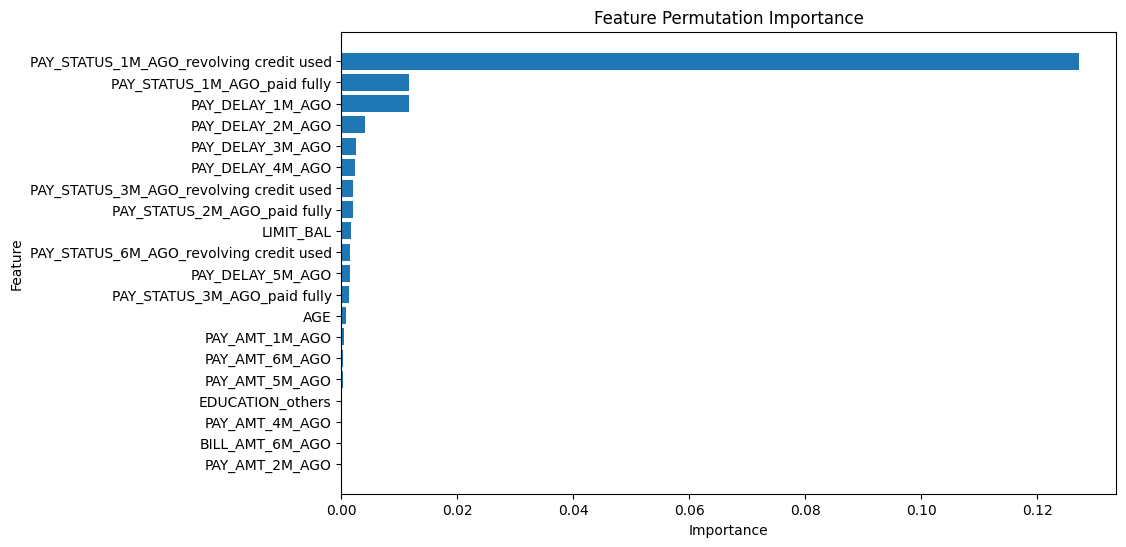

In [ ]:
plot_feat_permut_importance(svm_feat_permut_import_df)

In [ ]:
svm_perf, svm_orig_missing, svm_missing = measure_performance_decline(
    X_train_scaled, X_test_scaled, y_test, svm_classifier, svm_feat_permut_import_df,
    default_cc_imputation_scaled_values_dict, NUM_FEAT, method='simple',
    encoded_vars_family=default_cc_encoded_vars_family
)


--- NEW ITERATION ---
Removing feature:  PAY_STATUS_1M_AGO_revolving credit used
Removing related features:  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1M_AGO_revolving credit used']
Original feat removed so far:  ['PAY_STATUS_1M_AGO']

--- NEW ITERATION ---

--- NEW ITERATION ---
Removing feature:  PAY_DELAY_1M_AGO
Original feat removed so far:  ['PAY_STATUS_1M_AGO', 'PAY_DELAY_1M_AGO']

--- NEW ITERATION ---
Removing feature:  PAY_DELAY_2M_AGO
Original feat removed so far:  ['PAY_STATUS_1M_AGO', 'PAY_DELAY_1M_AGO', 'PAY_DELAY_2M_AGO']

--- NEW ITERATION ---
Removing feature:  PAY_DELAY_3M_AGO
Original feat removed so far:  ['PAY_STATUS_1M_AGO', 'PAY_DELAY_1M_AGO', 'PAY_DELAY_2M_AGO', 'PAY_DELAY_3M_AGO']

--- NEW ITERATION ---
Removing feature:  PAY_DELAY_4M_AGO
Original feat removed so far:  ['PAY_STATUS_1M_AGO', 'PAY_DELAY_1M_AGO', 'PAY_DELAY_2M_AGO', 'PAY_DELAY_3M_AGO', 'PAY_DELAY_4M_AGO']

--- NEW ITERATION ---
Removing feature:  PAY_STATUS_3M_AGO_revolving credit used
Removing

In [ ]:
svm_perf

tp    tn    fp   fn  precision  recall  specificity  accuracy  f1_score  \
0    648  4117   556  679      53.82   48.83        88.10     79.42     51.21   
1    964  1772  2901  363      24.94   72.65        37.92     45.60     37.13   
2    943  1800  2873  384      24.71   71.06        38.52     45.72     36.67   
3    929  1822  2851  398      24.58   70.01        38.99     45.85     36.38   
4    694  2055  2618  633      20.95   52.30        43.98     45.82     29.92   
5    589  2125  2548  738      18.78   44.39        45.47     45.23     26.39   
6   1021  1437  3236  306      23.98   76.94        30.75     40.97     36.57   
7   1059  1246  3427  268      23.61   79.80        26.66     38.42     36.44   
8   1065  1171  3502  262      23.32   80.26        25.06     37.27     36.14   
9   1127   986  3687  200      23.41   84.93        21.10     35.22     36.70   
10  1123   994  3679  204      23.39   84.63        21.27     35.28     36.65   
11  1117   987  3686  210      23.26   84.17        21.12     35.07     36.44   
12  1117   971  3702  210      23.18   84.17        20.78     34.80     36.35   
13  1118   967  3706  209      23.18   84.25        20.69     34.75     36.35   
14  1122   952  3721  205      23.17   84.55        20.37     34.57     36.37   
15  1081  1041  3632  246      22.94   81.46        22.28     35.37     35.79   
16  1084  1026  3647  243      22.91   81.69        21.96     35.17     35.79   
17  1084  1025  3648  243      22.91   81.69        21.93     35.15     35.78   
18  1086  1021  3652  241      22.92   81.84        21.85     35.12     35.81   
19  1020  1227  3446  307      22.84   76.87        26.26     37.45     35.21   
20  1025  1215  3458  302      22.86   77.24        26.00     37.33     35.28   

    balanced_accuracy  num_feat_missing  \
0               68.47                 0   
1               55.28                 1   
2               54.79                 2   
3               54.50                 3   
4               48.14                 4   
5               44.93                 5   
6               53.85                 6   
7               53.23                 7   
8               52.66                 8   
9               53.01                 9   
10              52.95                10   
11              52.65                11   
12              52.48                12   
13              52.47                13   
14              52.46                14   
15              51.87                15   
16              51.82                16   
17              51.81                17   
18              51.84                18   
19              51.56                19   
20              51.62                20   

                                              imputed  
0                                                      
1   ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
2   ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
3   ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
4   ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
5   ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
6   ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
7   ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
8   ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
9   ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
10  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
11  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
12  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
13  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
14  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
15  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
16  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
17  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
18  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
19  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
20  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...

In [ ]:
start_time = time.time()
print(datetime.datetime.now())

svm_perf_mf, svm_orig_missing_mf, svm_missing_mf = measure_performance_decline(
    X_train_scaled, X_test_scaled, y_test, svm_classifier, svm_feat_permut_import_df,
    imputation_dict=None, num_feat=NUM_FEAT, method='missforest',
    encoded_vars_family=default_cc_encoded_vars_family,
    categorical_vars=default_cc_cat_vars
)

print(datetime.datetime.now())
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time/60} minutes")

2025-01-18 16:05:06.060272

--- NEW ITERATION ---
Removing feature:  PAY_STATUS_1M_AGO_revolving credit used
Removing related features:  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1M_AGO_revolving credit used']
Nr. columns with nan:  2
Numerical columns:  ['PAY_DELAY_1M_AGO', 'PAY_DELAY_2M_AGO', 'PAY_DELAY_3M_AGO', 'PAY_DELAY_4M_AGO', 'PAY_DELAY_5M_AGO', 'PAY_DELAY_6M_AGO', 'LIMIT_BAL', 'PAY_AMT_1M_AGO', 'PAY_AMT_2M_AGO', 'PAY_AMT_3M_AGO', 'PAY_AMT_4M_AGO', 'PAY_AMT_5M_AGO', 'PAY_AMT_6M_AGO', 'AGE', 'BILL_AMT_1M_AGO', 'BILL_AMT_6M_AGO']
Categorical columns:  ['PAY_STATUS_1M_AGO_revolving credit used', 'PAY_STATUS_3M_AGO_revolving credit used', 'PAY_STATUS_4M_AGO_revolving credit used', 'PAY_STATUS_5M_AGO_revolving credit used', 'PAY_STATUS_6M_AGO_revolving credit used', 'PAY_STATUS_3M_AGO_paid fully', 'PAY_STATUS_2M_AGO_paid fully', 'PAY_STATUS_4M_AGO_paid fully', 'PAY_STATUS_5M_AGO_paid fully', 'PAY_STATUS_6M_AGO_paid fully', 'PAY_STATUS_1M_AGO_paid fully', 'EDUCATION_others', 'SEX_

In [ ]:
svm_perf_mf

tp    tn   fp    fn  precision  recall  specificity  accuracy  f1_score  \
0   648  4117  556   679      53.82   48.83        88.10     79.42     51.21   
1   467  4240  433   860      51.89   35.19        90.73     78.45     41.94   
2   462  4220  453   865      50.49   34.82        90.31     78.03     41.21   
3   427  4255  418   900      50.53   32.18        91.05     78.03     39.32   
4   403  4295  378   924      51.60   30.37        91.91     78.30     38.24   
5   330  4391  282   997      53.92   24.87        93.97     78.68     34.04   
6   277  4455  218  1050      55.96   20.87        95.33     78.87     30.41   
7   274  4474  199  1053      57.93   20.65        95.74     79.13     30.44   
8   274  4480  193  1053      58.67   20.65        95.87     79.23     30.55   
9   255  4500  173  1072      59.58   19.22        96.30     79.25     29.06   
10  100  4605   68  1227      59.52    7.54        98.54     78.42     13.38   
11   96  4606   67  1231      58.90    7.23        98.57     78.37     12.89   
12   94  4609   64  1233      59.49    7.08        98.63     78.38     12.66   
13   96  4605   68  1231      58.54    7.23        98.54     78.35     12.88   
14  104  4601   72  1223      59.09    7.84        98.46     78.42     13.84   
15  131  4599   74  1196      63.90    9.87        98.42     78.83     17.10   
16  121  4601   72  1206      62.69    9.12        98.46     78.70     15.92   
17  124  4596   77  1203      61.69    9.34        98.35     78.67     16.23   
18  109  4610   63  1218      63.37    8.21        98.65     78.65     14.54   
19  113  4609   64  1214      63.84    8.52        98.63     78.70     15.03   
20   97  4624   49  1230      66.44    7.31        98.95     78.68     13.17   

    balanced_accuracy  num_feat_missing  \
0               68.47                 0   
1               62.96                 1   
2               62.56                 2   
3               61.62                 3   
4               61.14                 4   
5               59.42                 5   
6               58.10                 6   
7               58.19                 7   
8               58.26                 8   
9               57.76                 9   
10              53.04                10   
11              52.90                11   
12              52.86                12   
13              52.89                13   
14              53.15                14   
15              54.14                15   
16              53.79                16   
17              53.85                17   
18              53.43                18   
19              53.57                19   
20              53.13                20   

                                              imputed  
0                                                      
1   ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
2   ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
3   ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
4   ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
5   ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
6   ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
7   ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
8   ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
9   ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
10  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
11  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
12  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
13  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
14  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
15  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
16  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
17  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
18  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
19  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
20  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...

In [ ]:
svm_perf_temp, svm_orig_missing_temp, svm_missing_temp = measure_temporal_performance_decline(
    X_train_scaled, X_test_scaled, y_test, svm_classifier, svm_feat_permut_import_df,
    default_cc_timeline_vars_family,
    default_cc_imputation_values_dict, NUM_FEAT, method='simple',
    encoded_vars_family=default_cc_encoded_vars_family, log_info=True
)


--- NEW ITERATION ---
original removed:  []
length original removed:  0
num feat:  20
i:  0
length features importance list:  33
length removed:  0

Removing feature:  PAY_STATUS_1M_AGO_revolving credit used
Removing related temporal feature:  BILL_AMT_1M_AGO
Removing related temporal feature:  PAY_AMT_1M_AGO
Removing related temporal feature:  PAY_DELAY_1M_AGO
Removing related temporal feature:  PAY_STATUS_1M_AGO_paid fully
Removing related features:  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1M_AGO_revolving credit used']
Removing related temporal feature:  PAY_STATUS_1M_AGO_revolving credit used
Removing related features:  []
Columns with zero variance, i.e. imputed:
                                    feature  variance
0                          PAY_DELAY_1M_AGO       0.0
6   PAY_STATUS_1M_AGO_revolving credit used       0.0
8                            PAY_AMT_1M_AGO       0.0
23             PAY_STATUS_1M_AGO_paid fully       0.0
30                          BILL_AMT_1M_AGO    

In [ ]:
svm_perf_temp

tp    tn   fp    fn  precision  recall  specificity  accuracy  f1_score  \
0  648  4117  556   679      53.82   48.83         88.1     79.42     51.21   
1    0  4673    0  1327       0.00    0.00        100.0     77.88      0.00   
2    0  4673    0  1327       0.00    0.00        100.0     77.88      0.00   
3    0  4673    0  1327       0.00    0.00        100.0     77.88      0.00   
4    0  4673    0  1327       0.00    0.00        100.0     77.88      0.00   
5    0  4673    0  1327       0.00    0.00        100.0     77.88      0.00   
6    0  4673    0  1327       0.00    0.00        100.0     77.88      0.00   
7    0  4673    0  1327       0.00    0.00        100.0     77.88      0.00   

   balanced_accuracy  num_feat_missing  \
0              68.47                 0   
1              50.00                 4   
2              50.00                 7   
3              50.00                10   
4              50.00                13   
5              50.00                14   
6              50.00                18   
7              50.00                21   

                                             imputed  
0                                                     
1  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
2  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
3  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
4  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
5  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
6  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
7  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...

In [ ]:
start_time = time.time()
print(datetime.datetime.now())

svm_perf_temp_mf, svm_orig_missing_temp_mf, svm_missing_temp_mf = measure_temporal_performance_decline(
    X_train_scaled, X_test_scaled, y_test, svm_classifier, svm_feat_permut_import_df,
    default_cc_timeline_vars_family, num_feat=NUM_FEAT, method='missforest',
    encoded_vars_family=default_cc_encoded_vars_family,
    categorical_vars=default_cc_cat_vars, log_info=True
)

print(datetime.datetime.now())
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time/60} minutes")

2025-01-18 16:11:53.235129

--- NEW ITERATION ---
original removed:  []
length original removed:  0
num feat:  20
i:  0
length features importance list:  33
length removed:  0

Removing feature:  PAY_STATUS_1M_AGO_revolving credit used
Removing related temporal feature:  BILL_AMT_1M_AGO
Removing related temporal feature:  PAY_AMT_1M_AGO
Removing related temporal feature:  PAY_DELAY_1M_AGO
Removing related temporal feature:  PAY_STATUS_1M_AGO_paid fully
Removing related features:  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1M_AGO_revolving credit used']
Removing related temporal feature:  PAY_STATUS_1M_AGO_revolving credit used
Removing related features:  []
Nr. columns with nan:  5
Numerical columns:  ['PAY_DELAY_1M_AGO', 'PAY_DELAY_2M_AGO', 'PAY_DELAY_3M_AGO', 'PAY_DELAY_4M_AGO', 'PAY_DELAY_5M_AGO', 'PAY_DELAY_6M_AGO', 'LIMIT_BAL', 'PAY_AMT_1M_AGO', 'PAY_AMT_2M_AGO', 'PAY_AMT_3M_AGO', 'PAY_AMT_4M_AGO', 'PAY_AMT_5M_AGO', 'PAY_AMT_6M_AGO', 'AGE', 'BILL_AMT_1M_AGO', 'BILL_AMT_6M_AGO']


In [ ]:
svm_perf_temp_mf

tp    tn   fp    fn  precision  recall  specificity  accuracy  f1_score  \
0  648  4117  556   679      53.82   48.83        88.10     79.42     51.21   
1  461  4223  450   866      50.60   34.74        90.37     78.07     41.20   
2  416  4284  389   911      51.68   31.35        91.68     78.33     39.02   
3  294  4460  213  1033      57.99   22.16        95.44     79.23     32.06   
4  222  4510  163  1105      57.66   16.73        96.51     78.87     25.93   
5  217  4511  162  1110      57.26   16.35        96.53     78.80     25.44   
6   40  4650   23  1287      63.49    3.01        99.51     78.17      5.76   
7    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   

   balanced_accuracy  num_feat_missing  \
0              68.47                 0   
1              62.56                 4   
2              61.51                 7   
3              58.80                10   
4              56.62                13   
5              56.44                14   
6              51.26                18   
7              50.00                21   

                                             imputed  
0                                                     
1  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
2  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
3  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
4  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
5  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
6  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
7  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...

##**Logistic Regression**##

**Data pre-processing:** It is highly recommended to mitigate as much as possible the presence of multicolinearity between features before applying Logistic regression.

In [ ]:
present_features = list(X_train_scaled.columns) + ['Target']
filtered_default_cc_dist_corr = default_cc_dist_corr[present_features]
filtered_default_cc_dist_corr = filtered_default_cc_dist_corr[filtered_default_cc_dist_corr.index.isin(present_features)]
filtered_feat = filter_out_intercorrelated_features(filtered_default_cc_dist_corr, 'Target', 0.8)

appended feature:  PAY_DELAY_1M_AGO
appended feature:  PAY_DELAY_2M_AGO
appended feature:  PAY_DELAY_3M_AGO
appended feature:  PAY_DELAY_4M_AGO
appended feature:  PAY_DELAY_5M_AGO
appended feature:  PAY_DELAY_6M_AGO
appended feature:  PAY_STATUS_1M_AGO_revolving credit used
appended feature:  LIMIT_BAL
appended feature:  PAY_AMT_1M_AGO
appended feature:  PAY_AMT_2M_AGO
appended feature:  PAY_STATUS_3M_AGO_revolving credit used
appended feature:  PAY_AMT_3M_AGO
appended feature:  PAY_AMT_4M_AGO
appended feature:  PAY_AMT_5M_AGO
appended feature:  PAY_STATUS_4M_AGO_revolving credit used
appended feature:  PAY_AMT_6M_AGO
appended feature:  PAY_STATUS_5M_AGO_revolving credit used
appended feature:  PAY_STATUS_6M_AGO_revolving credit used
appended feature:  PAY_STATUS_3M_AGO_paid fully
appended feature:  PAY_STATUS_2M_AGO_paid fully
appended feature:  PAY_STATUS_4M_AGO_paid fully
appended feature:  PAY_STATUS_5M_AGO_paid fully
appended feature:  PAY_STATUS_6M_AGO_paid fully
appended feature

In [ ]:
lr_X_train = X_train_scaled[filtered_feat]
lr_X_test = X_test_scaled[filtered_feat]
print('Nr features for LR: ', len(lr_X_train.columns))

Nr features for LR:  33


In [ ]:
FINE_TUNE = False

if FINE_TUNE:
  lr_param_grid = {
      'C': [0.1, 1, 2, 5, 10, 20],  # Regularization strength
      'penalty': ['l2', 'l1', 'elasticnet'],  # Regularization type
      'solver': ['liblinear', 'saga']  # Algorithm to use in the optimization problem
  }
else:
  lr_param_grid = {
      'C': [2.0],
      'penalty': ['l2'],
      'solver': ['saga']
  }

lr_classifier = LogisticRegression(class_weight='balanced', random_state=RANDOM_STATE)
lr_grid_search, lr_best_model, lr_best_params = hyperparameter_tuning(
    lr_classifier, lr_param_grid, 3, 3, 'f1', lr_X_train, y_train
)

Starting hyperparameter tuning at: 2025-01-18 15:17:20.627612

Nested Cross-validation Results:
Individual scores: [0.53275993 0.53713389 0.52996685]
Average nested CV score: 0.533 (+/- 0.006)

Fitting final model on entire dataset...
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best parameters: {'C': 2.0, 'penalty': 'l2', 'solver': 'saga'}

Best Model Performance:
Best CV score: 0.533
2025-01-18 15:17:24.904988

Execution time: 0.07 minutes


```
Starting hyperparameter tuning at: 2025-01-17 12:38:22.503833

Nested Cross-validation Results:
Individual scores: [0.53165829 0.53605016 0.52956167]
Average nested CV score: 0.532 (+/- 0.005)

Fitting final model on entire dataset...
Fitting 3 folds for each of 36 candidates, totalling 108 fits
Best parameters: {'C': 2, 'penalty': 'l2', 'solver': 'saga'}

Best Model Performance:
Best CV score: 0.533
2025-01-17 12:38:44.640307

Execution time: 0.37 minutes
```

In [ ]:
lr_classifier, train_pred, test_pred = apply_model(lr_best_model, lr_X_train, y_train, lr_X_test, y_test)
lr_feat_permut_import_df = analyze_feat_permut_import(lr_classifier, lr_X_train, y_train, scoring_metric="f1")
lr_feat_permut_import_df[lr_feat_permut_import_df['Importance']!=0]

Feature  Importance       Std
0                          PAY_DELAY_1M_AGO    0.107946  0.003127
7                                 LIMIT_BAL    0.020677  0.003140
2                          PAY_DELAY_3M_AGO    0.013754  0.002241
30                          BILL_AMT_1M_AGO    0.008350  0.000443
23             PAY_STATUS_1M_AGO_paid fully    0.007513  0.001443
19             PAY_STATUS_2M_AGO_paid fully    0.007392  0.000759
6   PAY_STATUS_1M_AGO_revolving credit used    0.007096  0.001123
4                          PAY_DELAY_5M_AGO    0.005482  0.000811
17  PAY_STATUS_6M_AGO_revolving credit used    0.004142  0.001530
3                          PAY_DELAY_4M_AGO    0.003708  0.000620
16  PAY_STATUS_5M_AGO_revolving credit used    0.003312  0.000715
25                                 SEX_male    0.003237  0.000542
20             PAY_STATUS_4M_AGO_paid fully    0.003034  0.000436
10  PAY_STATUS_3M_AGO_revolving credit used    0.001990  0.001219
22             PAY_STATUS_6M_AGO_paid fully    0.001689  0.000564
24                         EDUCATION_others    0.001419  0.000454
26                     EDUCATION_university    0.001183  0.000302
27                          MARRIAGE_single    0.001128  0.001366
5                          PAY_DELAY_6M_AGO    0.000683  0.000152
8                            PAY_AMT_1M_AGO    0.000602  0.000326
32                          MARRIAGE_others    0.000576  0.000237
29                                      AGE    0.000384  0.000647
15                           PAY_AMT_6M_AGO    0.000158  0.000346
28                    EDUCATION_high school    0.000135  0.000194
31                          BILL_AMT_6M_AGO   -0.000014  0.000437
11                           PAY_AMT_3M_AGO   -0.000105  0.000539
18             PAY_STATUS_3M_AGO_paid fully   -0.000106  0.000181
14  PAY_STATUS_4M_AGO_revolving credit used   -0.000122  0.000880
9                            PAY_AMT_2M_AGO   -0.000190  0.000153
12                           PAY_AMT_4M_AGO   -0.000197  0.000450
13                           PAY_AMT_5M_AGO   -0.000234  0.000405
1                          PAY_DELAY_2M_AGO   -0.000324  0.000460
21             PAY_STATUS_5M_AGO_paid fully   -0.000333  0.000176

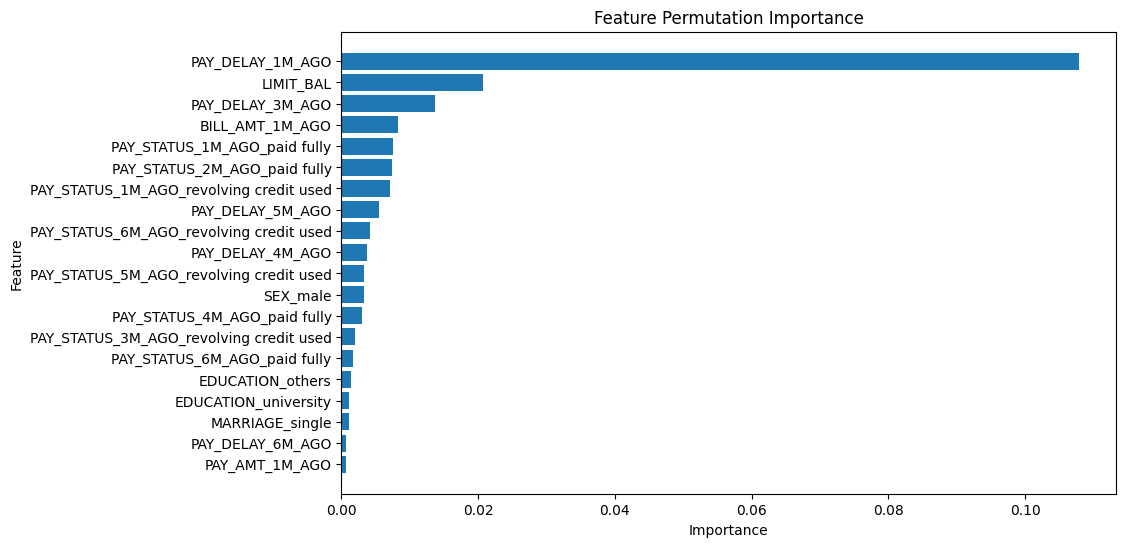

In [ ]:
plot_feat_permut_importance(lr_feat_permut_import_df)

In [ ]:
lr_perf, lr_orig_missing, lr_missing = measure_performance_decline(
    lr_X_train, lr_X_test, y_test, lr_classifier, lr_feat_permut_import_df,
    default_cc_imputation_scaled_values_dict, NUM_FEAT, method='simple',
    encoded_vars_family=default_cc_encoded_vars_family
)


--- NEW ITERATION ---
Removing feature:  PAY_DELAY_1M_AGO
Original feat removed so far:  ['PAY_DELAY_1M_AGO']

--- NEW ITERATION ---
Removing feature:  LIMIT_BAL
Original feat removed so far:  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL']

--- NEW ITERATION ---
Removing feature:  PAY_DELAY_3M_AGO
Original feat removed so far:  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_3M_AGO']

--- NEW ITERATION ---
Removing feature:  BILL_AMT_1M_AGO
Original feat removed so far:  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_3M_AGO', 'BILL_AMT_1M_AGO']

--- NEW ITERATION ---
Removing feature:  PAY_STATUS_1M_AGO_paid fully
Removing related features:  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1M_AGO_revolving credit used']
Original feat removed so far:  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_3M_AGO', 'BILL_AMT_1M_AGO', 'PAY_STATUS_1M_AGO']

--- NEW ITERATION ---
Removing feature:  PAY_STATUS_2M_AGO_paid fully
Removing related features:  ['PAY_STATUS_2M_AGO_paid fully']
Original feat removed so far:  ['P

In [ ]:
lr_perf

tp    tn   fp    fn  precision  recall  specificity  accuracy  f1_score  \
0   750  3862  811   577      48.05   56.52        82.64     76.87     51.94   
1   485  4169  504   842      49.04   36.55        89.21     77.57     41.88   
2   442  4214  459   885      49.06   33.31        90.18     77.60     39.68   
3   334  4351  322   993      50.91   25.17        93.11     78.08     33.69   
4   302  4365  308  1025      49.51   22.76        93.41     77.78     31.18   
5   307  4377  296  1020      50.91   23.13        93.67     78.07     31.81   
6   310  4355  318  1017      49.36   23.36        93.19     77.75     31.71   
7   215  4432  241  1112      47.15   16.20        94.84     77.45     24.12   
8    16  4660   13  1311      55.17    1.21        99.72     77.93      2.36   
9     0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   
10    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   
11    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   
12    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   
13    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   
14    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   
15    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   
16    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   
17    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   
18    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   
19    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   
20    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   

    balanced_accuracy  num_feat_missing  \
0               69.58                 0   
1               62.88                 1   
2               61.74                 2   
3               59.14                 3   
4               58.08                 4   
5               58.40                 5   
6               58.28                 6   
7               55.52                 7   
8               50.46                 8   
9               50.00                 9   
10              50.00                10   
11              50.00                11   
12              50.00                12   
13              50.00                13   
14              50.00                14   
15              50.00                15   
16              50.00                16   
17              50.00                17   
18              50.00                18   
19              50.00                19   
20              50.00                20   

                                              imputed  
0                                                      
1                        ['PAY_DELAY_1M_AGO'] imputed  
2           ['PAY_DELAY_1M_AGO', 'LIMIT_BAL'] imputed  
3   ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_3...  
4   ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_3...  
5   ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_3...  
6   ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_3...  
7   ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_3...  
8   ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_3...  
9   ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_3...  
10  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_3...  
11  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_3...  
12  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_3...  
13  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_3...  
14  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_3...  
15  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_3...  
16  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_3...  
17  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_3...  
18  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_3...  
19  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_3...  
20  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_3...

In [ ]:
lr_X_train.columns

Index(['PAY_DELAY_1M_AGO', 'PAY_DELAY_2M_AGO', 'PAY_DELAY_3M_AGO',
       'PAY_DELAY_4M_AGO', 'PAY_DELAY_5M_AGO', 'PAY_DELAY_6M_AGO',
       'PAY_STATUS_1M_AGO_revolving credit used', 'LIMIT_BAL',
       'PAY_AMT_1M_AGO', 'PAY_AMT_2M_AGO',
       'PAY_STATUS_3M_AGO_revolving credit used', 'PAY_AMT_3M_AGO',
       'PAY_AMT_4M_AGO', 'PAY_AMT_5M_AGO',
       'PAY_STATUS_4M_AGO_revolving credit used', 'PAY_AMT_6M_AGO',
       'PAY_STATUS_5M_AGO_revolving credit used',
       'PAY_STATUS_6M_AGO_revolving credit used',
       'PAY_STATUS_3M_AGO_paid fully', 'PAY_STATUS_2M_AGO_paid fully',
       'PAY_STATUS_4M_AGO_paid fully', 'PAY_STATUS_5M_AGO_paid fully',
       'PAY_STATUS_6M_AGO_paid fully', 'PAY_STATUS_1M_AGO_paid fully',
       'EDUCATION_others', 'SEX_male', 'EDUCATION_university',
       'MARRIAGE_single', 'EDUCATION_high school', 'AGE', 'BILL_AMT_1M_AGO',
       'BILL_AMT_6M_AGO', 'MARRIAGE_others'],
      dtype='object')

In [ ]:
start_time = time.time()
print(datetime.datetime.now())

lr_default_cc_cat_vars = [col for col in lr_X_train.columns if col in default_cc_cat_vars]

lr_perf_mf, lr_orig_missing_mf, lr_missing_mf = measure_performance_decline(
    lr_X_train, lr_X_test, y_test, lr_classifier, lr_feat_permut_import_df,
    imputation_dict=None, num_feat=NUM_FEAT, method='missforest',
    encoded_vars_family=default_cc_encoded_vars_family,
    categorical_vars=lr_default_cc_cat_vars
)

print(datetime.datetime.now())
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time/60} minutes")

2025-01-18 16:14:02.199421

--- NEW ITERATION ---
Removing feature:  PAY_DELAY_1M_AGO
Nr. columns with nan:  1
Numerical columns:  ['PAY_DELAY_1M_AGO', 'PAY_DELAY_2M_AGO', 'PAY_DELAY_3M_AGO', 'PAY_DELAY_4M_AGO', 'PAY_DELAY_5M_AGO', 'PAY_DELAY_6M_AGO', 'LIMIT_BAL', 'PAY_AMT_1M_AGO', 'PAY_AMT_2M_AGO', 'PAY_AMT_3M_AGO', 'PAY_AMT_4M_AGO', 'PAY_AMT_5M_AGO', 'PAY_AMT_6M_AGO', 'AGE', 'BILL_AMT_1M_AGO', 'BILL_AMT_6M_AGO']
Categorical columns:  ['PAY_STATUS_1M_AGO_revolving credit used', 'PAY_STATUS_3M_AGO_revolving credit used', 'PAY_STATUS_4M_AGO_revolving credit used', 'PAY_STATUS_5M_AGO_revolving credit used', 'PAY_STATUS_6M_AGO_revolving credit used', 'PAY_STATUS_3M_AGO_paid fully', 'PAY_STATUS_2M_AGO_paid fully', 'PAY_STATUS_4M_AGO_paid fully', 'PAY_STATUS_5M_AGO_paid fully', 'PAY_STATUS_6M_AGO_paid fully', 'PAY_STATUS_1M_AGO_paid fully', 'EDUCATION_others', 'SEX_male', 'EDUCATION_university', 'MARRIAGE_single', 'EDUCATION_high school', 'MARRIAGE_others']
Column imputed:  PAY_DELAY_1M_AGO

In [ ]:
lr_perf_mf

tp    tn   fp   fn  precision  recall  specificity  accuracy  f1_score  \
0   750  3862  811  577      48.05   56.52        82.64     76.87     51.94   
1   699  3804  869  628      44.58   52.68        81.40     75.05     48.29   
2   676  3884  789  651      46.14   50.94        83.12     76.00     48.42   
3   663  3892  781  664      45.91   49.96        83.29     75.92     47.85   
4   628  3974  699  699      47.32   47.32        85.04     76.70     47.32   
5   598  4012  661  729      47.50   45.06        85.85     76.83     46.25   
6   587  4046  627  740      48.35   44.24        86.58     77.22     46.20   
7   586  4050  623  741      48.47   44.16        86.67     77.27     46.21   
8   583  4081  592  744      49.62   43.93        87.33     77.73     46.60   
9   547  4112  561  780      49.37   41.22        87.99     77.65     44.93   
10  495  4250  423  832      53.92   37.30        90.95     79.08     44.10   
11  472  4292  381  855      55.33   35.57        91.85     79.40     43.30   
12  456  4311  362  871      55.75   34.36        92.25     79.45     42.52   
13  441  4342  331  886      57.12   33.23        92.92     79.72     42.02   
14  446  4337  336  881      57.03   33.61        92.81     79.72     42.29   
15  458  4312  361  869      55.92   34.51        92.27     79.50     42.68   
16  457  4322  351  870      56.56   34.44        92.49     79.65     42.81   
17  466  4300  373  861      55.54   35.12        92.02     79.43     43.03   
18  466  4299  374  861      55.48   35.12        92.00     79.42     43.01   
19  468  4299  374  859      55.58   35.27        92.00     79.45     43.15   
20  465  4301  372  862      55.56   35.04        92.04     79.43     42.98   

    balanced_accuracy  num_feat_missing  \
0               69.58                 0   
1               67.04                 1   
2               67.03                 2   
3               66.62                 3   
4               66.18                 4   
5               65.46                 5   
6               65.41                 6   
7               65.41                 7   
8               65.63                 8   
9               64.61                 9   
10              64.13                10   
11              63.71                11   
12              63.31                12   
13              63.07                13   
14              63.21                14   
15              63.39                15   
16              63.46                16   
17              63.57                17   
18              63.56                18   
19              63.63                19   
20              63.54                20   

                                              imputed  
0                                                      
1                        ['PAY_DELAY_1M_AGO'] imputed  
2           ['PAY_DELAY_1M_AGO', 'LIMIT_BAL'] imputed  
3   ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_3...  
4   ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_3...  
5   ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_3...  
6   ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_3...  
7   ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_3...  
8   ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_3...  
9   ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_3...  
10  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_3...  
11  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_3...  
12  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_3...  
13  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_3...  
14  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_3...  
15  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_3...  
16  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_3...  
17  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_3...  
18  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_3...  
19  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_3...  
20  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_3...

In [ ]:
lr_perf_temp, lr_orig_missing_temp, lr_missing_temp = measure_temporal_performance_decline(
    lr_X_train, lr_X_test, y_test, lr_classifier, lr_feat_permut_import_df,
    default_cc_timeline_vars_family,
    default_cc_imputation_values_dict, NUM_FEAT, method='simple',
    encoded_vars_family=default_cc_encoded_vars_family, log_info=True
)


--- NEW ITERATION ---
original removed:  []
length original removed:  0
num feat:  20
i:  0
length features importance list:  33
length removed:  0

Removing feature:  PAY_DELAY_1M_AGO
Removing related temporal feature:  BILL_AMT_1M_AGO
Removing related temporal feature:  PAY_AMT_1M_AGO
Removing related temporal feature:  PAY_DELAY_1M_AGO
Removing related temporal feature:  PAY_STATUS_1M_AGO_paid fully
Removing related features:  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1M_AGO_revolving credit used']
Removing related temporal feature:  PAY_STATUS_1M_AGO_revolving credit used
Removing related features:  []
Columns with zero variance, i.e. imputed:
                                    feature  variance
0                          PAY_DELAY_1M_AGO       0.0
6   PAY_STATUS_1M_AGO_revolving credit used       0.0
8                            PAY_AMT_1M_AGO       0.0
23             PAY_STATUS_1M_AGO_paid fully       0.0
30                          BILL_AMT_1M_AGO       0.0
Original feat re

In [ ]:
lr_perf_temp

tp    tn    fp    fn  precision  recall  specificity  accuracy  f1_score  \
0   750  3862   811   577      48.05   56.52        82.64     76.87     51.94   
1  1327     0  4673     0      22.12  100.00         0.00     22.12     36.22   
2     0  4673     0  1327       0.00    0.00       100.00     77.88      0.00   
3     0  4673     0  1327       0.00    0.00       100.00     77.88      0.00   
4     0  4673     0  1327       0.00    0.00       100.00     77.88      0.00   
5     0  4673     0  1327       0.00    0.00       100.00     77.88      0.00   
6     0  4673     0  1327       0.00    0.00       100.00     77.88      0.00   
7     0  4673     0  1327       0.00    0.00       100.00     77.88      0.00   

   balanced_accuracy  num_feat_missing  \
0              69.58                 0   
1              50.00                 4   
2              50.00                 5   
3              50.00                 8   
4              50.00                11   
5              50.00                14   
6              50.00                18   
7              50.00                21   

                                             imputed  
0                                                     
1  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
2  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
3  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
4  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
5  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
6  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
7  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...

In [ ]:
start_time = time.time()
print(datetime.datetime.now())

lr_perf_temp_mf, lr_orig_missing_temp_mf, lr_missing_temp_mf = measure_temporal_performance_decline(
    lr_X_train, lr_X_test, y_test, lr_classifier, lr_feat_permut_import_df,
    default_cc_timeline_vars_family, num_feat=NUM_FEAT, method='missforest',
    encoded_vars_family=default_cc_encoded_vars_family,
    categorical_vars=lr_default_cc_cat_vars, log_info=True
)

print(datetime.datetime.now())
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time/60} minutes")

2025-01-18 16:18:38.751811

--- NEW ITERATION ---
original removed:  []
length original removed:  0
num feat:  20
i:  0
length features importance list:  33
length removed:  0

Removing feature:  PAY_DELAY_1M_AGO
Removing related temporal feature:  BILL_AMT_1M_AGO
Removing related temporal feature:  PAY_AMT_1M_AGO
Removing related temporal feature:  PAY_DELAY_1M_AGO
Removing related temporal feature:  PAY_STATUS_1M_AGO_paid fully
Removing related features:  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1M_AGO_revolving credit used']
Removing related temporal feature:  PAY_STATUS_1M_AGO_revolving credit used
Removing related features:  []
Nr. columns with nan:  5
Numerical columns:  ['PAY_DELAY_1M_AGO', 'PAY_DELAY_2M_AGO', 'PAY_DELAY_3M_AGO', 'PAY_DELAY_4M_AGO', 'PAY_DELAY_5M_AGO', 'PAY_DELAY_6M_AGO', 'LIMIT_BAL', 'PAY_AMT_1M_AGO', 'PAY_AMT_2M_AGO', 'PAY_AMT_3M_AGO', 'PAY_AMT_4M_AGO', 'PAY_AMT_5M_AGO', 'PAY_AMT_6M_AGO', 'AGE', 'BILL_AMT_1M_AGO', 'BILL_AMT_6M_AGO']
Categorical columns:  [

In [ ]:
lr_perf_temp_mf

tp    tn   fp    fn  precision  recall  specificity  accuracy  f1_score  \
0  750  3862  811   577      48.05   56.52        82.64     76.87     51.94   
1  619  3925  748   708      45.28   46.65        83.99     75.73     45.95   
2  639  3891  782   688      44.97   48.15        83.27     75.50     46.51   
3  576  4105  568   751      50.35   43.41        87.85     78.02     46.62   
4  355  4392  281   972      55.82   26.75        93.99     79.12     36.17   
5  354  4373  300   973      54.13   26.68        93.58     78.78     35.74   
6  170  4544  129  1157      56.86   12.81        97.24     78.57     20.91   
7    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   

   balanced_accuracy  num_feat_missing  \
0              69.58                 0   
1              65.32                 4   
2              65.71                 5   
3              65.63                 8   
4              60.37                11   
5              60.13                14   
6              55.03                18   
7              50.00                21   

                                             imputed  
0                                                     
1  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
2  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
3  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
4  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
5  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
6  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
7  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...

# **Models optimized for Balanced Accuracy**

## **Decision Tree**

In [ ]:
FINE_TUNE = False

if FINE_TUNE:
  dt2_param_grid = {
      'max_depth': [2, 3, 4, 5, None],
      'min_samples_split': [0.2, 0.1, 0.05, 0.01, 0.005, 0.001, 2],
      'min_samples_leaf': [0.1, 0.05, 0.01, 0.005, 0.001, 1]
  }
else:
  # best model
  dt2_param_grid = {
      'max_depth': [None],
      'min_samples_split': [0.05],
      'min_samples_leaf': [0.01]
  }

dt2_classifier = DecisionTreeClassifier(class_weight='balanced', random_state=RANDOM_STATE)
dt2_grid_search, dt2_best_model, dt2_best_params = hyperparameter_tuning(
    dt2_classifier, dt2_param_grid, 3, 3, 'balanced_accuracy', X_train, y_train
)

Starting hyperparameter tuning at: 2025-01-18 16:20:13.368794

Nested Cross-validation Results:
Individual scores: [0.70189553 0.70311279 0.69981183]
Average nested CV score: 0.702 (+/- 0.003)

Fitting final model on entire dataset...
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best parameters: {'max_depth': None, 'min_samples_leaf': 0.01, 'min_samples_split': 0.05}

Best Model Performance:
Best CV score: 0.702
2025-01-18 16:20:16.702267

Execution time: 0.06 minutes


```
Starting hyperparameter tuning at: 2025-01-17 12:38:44.648793

Nested Cross-validation Results:
Individual scores: [0.69644828 0.70311279 0.69557046]
Average nested CV score: 0.698 (+/- 0.007)

Fitting final model on entire dataset...
Fitting 3 folds for each of 210 candidates, totalling 630 fits
Best parameters: {'max_depth': None, 'min_samples_leaf': 0.01, 'min_samples_split': 0.05}

Best Model Performance:
Best CV score: 0.702
2025-01-17 12:39:18.201917

Execution time: 0.56 minutes
```

In [ ]:
dt2_classifier, dt2_train_pred, dt2_test_pred = apply_model(dt2_best_model, X_train, y_train, X_test, y_test)
dt2_feat_permut_import_df = analyze_feat_permut_import(dt2_classifier, X_train, y_train, scoring_metric="balanced_accuracy")
dt2_feat_permut_import_df[dt2_feat_permut_import_df['Importance']!=0]

Feature  Importance       Std
0               PAY_DELAY_1M_AGO    0.090112  0.001924
3               PAY_DELAY_4M_AGO    0.024279  0.001592
20  PAY_STATUS_4M_AGO_paid fully    0.010800  0.001018
2               PAY_DELAY_3M_AGO    0.009651  0.001197
9                 PAY_AMT_2M_AGO    0.006207  0.001269
18  PAY_STATUS_3M_AGO_paid fully    0.004582  0.000830
30               BILL_AMT_1M_AGO    0.004367  0.000902
7                      LIMIT_BAL    0.003489  0.000990
12                PAY_AMT_4M_AGO    0.002691  0.000751

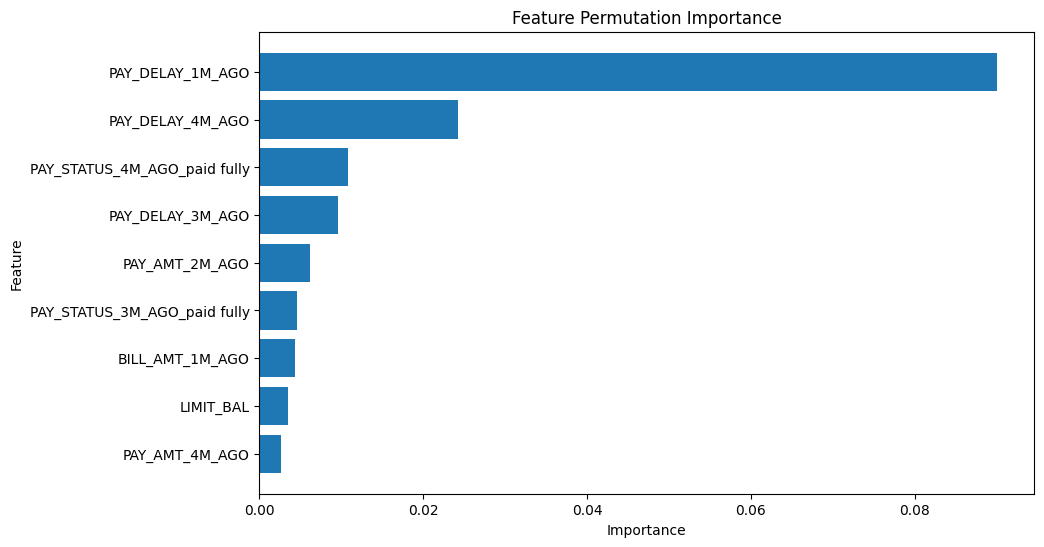

In [ ]:
plot_feat_permut_importance(dt2_feat_permut_import_df)

In [ ]:
dt2_perf, dt2_orig_missing, dt2_missing = measure_performance_decline(
    X_train, X_test, y_test, dt2_classifier, dt2_feat_permut_import_df,
    default_cc_imputation_values_dict, NUM_FEAT, method='simple',
    encoded_vars_family=default_cc_encoded_vars_family
)


--- NEW ITERATION ---
Removing feature:  PAY_DELAY_1M_AGO
Original feat removed so far:  ['PAY_DELAY_1M_AGO']

--- NEW ITERATION ---
Removing feature:  PAY_DELAY_4M_AGO
Original feat removed so far:  ['PAY_DELAY_1M_AGO', 'PAY_DELAY_4M_AGO']

--- NEW ITERATION ---
Removing feature:  PAY_STATUS_4M_AGO_paid fully
Removing related features:  ['PAY_STATUS_4M_AGO_paid fully', 'PAY_STATUS_4M_AGO_revolving credit used']
Original feat removed so far:  ['PAY_DELAY_1M_AGO', 'PAY_DELAY_4M_AGO', 'PAY_STATUS_4M_AGO']

--- NEW ITERATION ---
Removing feature:  PAY_DELAY_3M_AGO
Original feat removed so far:  ['PAY_DELAY_1M_AGO', 'PAY_DELAY_4M_AGO', 'PAY_STATUS_4M_AGO', 'PAY_DELAY_3M_AGO']

--- NEW ITERATION ---
Removing feature:  PAY_AMT_2M_AGO
Original feat removed so far:  ['PAY_DELAY_1M_AGO', 'PAY_DELAY_4M_AGO', 'PAY_STATUS_4M_AGO', 'PAY_DELAY_3M_AGO', 'PAY_AMT_2M_AGO']

--- NEW ITERATION ---
Removing feature:  PAY_STATUS_3M_AGO_paid fully
Removing related features:  ['PAY_STATUS_3M_AGO_paid fully'

In [ ]:
dt2_perf

tp    tn    fp    fn  precision  recall  specificity  accuracy  f1_score  \
0   834  3564  1109   493      42.92   62.85        76.27     73.30     51.01   
1   587  3833   840   740      41.14   44.24        82.02     73.67     42.63   
2   377  4056   617   950      37.93   28.41        86.80     73.88     32.49   
3   377  4056   617   950      37.93   28.41        86.80     73.88     32.49   
4   208  4271   402  1119      34.10   15.67        91.40     74.65     21.48   
5     0  4673     0  1327       0.00    0.00       100.00     77.88      0.00   
6     0  4673     0  1327       0.00    0.00       100.00     77.88      0.00   
7     0  4673     0  1327       0.00    0.00       100.00     77.88      0.00   
8     0  4673     0  1327       0.00    0.00       100.00     77.88      0.00   
9     0  4673     0  1327       0.00    0.00       100.00     77.88      0.00   
10    0  4673     0  1327       0.00    0.00       100.00     77.88      0.00   
11    0  4673     0  1327       0.00    0.00       100.00     77.88      0.00   
12    0  4673     0  1327       0.00    0.00       100.00     77.88      0.00   
13    0  4673     0  1327       0.00    0.00       100.00     77.88      0.00   
14    0  4673     0  1327       0.00    0.00       100.00     77.88      0.00   
15    0  4673     0  1327       0.00    0.00       100.00     77.88      0.00   
16    0  4673     0  1327       0.00    0.00       100.00     77.88      0.00   
17    0  4673     0  1327       0.00    0.00       100.00     77.88      0.00   
18    0  4673     0  1327       0.00    0.00       100.00     77.88      0.00   
19    0  4673     0  1327       0.00    0.00       100.00     77.88      0.00   
20    0  4673     0  1327       0.00    0.00       100.00     77.88      0.00   

    balanced_accuracy  num_feat_missing  \
0               69.56                 0   
1               63.13                 1   
2               57.60                 2   
3               57.60                 3   
4               53.54                 4   
5               50.00                 5   
6               50.00                 6   
7               50.00                 7   
8               50.00                 8   
9               50.00                 9   
10              50.00                10   
11              50.00                11   
12              50.00                12   
13              50.00                13   
14              50.00                14   
15              50.00                15   
16              50.00                16   
17              50.00                17   
18              50.00                18   
19              50.00                19   
20              50.00                20   

                                              imputed  
0                                                      
1                        ['PAY_DELAY_1M_AGO'] imputed  
2    ['PAY_DELAY_1M_AGO', 'PAY_DELAY_4M_AGO'] imputed  
3   ['PAY_DELAY_1M_AGO', 'PAY_DELAY_4M_AGO', 'PAY_...  
4   ['PAY_DELAY_1M_AGO', 'PAY_DELAY_4M_AGO', 'PAY_...  
5   ['PAY_DELAY_1M_AGO', 'PAY_DELAY_4M_AGO', 'PAY_...  
6   ['PAY_DELAY_1M_AGO', 'PAY_DELAY_4M_AGO', 'PAY_...  
7   ['PAY_DELAY_1M_AGO', 'PAY_DELAY_4M_AGO', 'PAY_...  
8   ['PAY_DELAY_1M_AGO', 'PAY_DELAY_4M_AGO', 'PAY_...  
9   ['PAY_DELAY_1M_AGO', 'PAY_DELAY_4M_AGO', 'PAY_...  
10  ['PAY_DELAY_1M_AGO', 'PAY_DELAY_4M_AGO', 'PAY_...  
11  ['PAY_DELAY_1M_AGO', 'PAY_DELAY_4M_AGO', 'PAY_...  
12  ['PAY_DELAY_1M_AGO', 'PAY_DELAY_4M_AGO', 'PAY_...  
13  ['PAY_DELAY_1M_AGO', 'PAY_DELAY_4M_AGO', 'PAY_...  
14  ['PAY_DELAY_1M_AGO', 'PAY_DELAY_4M_AGO', 'PAY_...  
15  ['PAY_DELAY_1M_AGO', 'PAY_DELAY_4M_AGO', 'PAY_...  
16  ['PAY_DELAY_1M_AGO', 'PAY_DELAY_4M_AGO', 'PAY_...  
17  ['PAY_DELAY_1M_AGO', 'PAY_DELAY_4M_AGO', 'PAY_...  
18  ['PAY_DELAY_1M_AGO', 'PAY_DELAY_4M_AGO', 'PAY_...  
19  ['PAY_DELAY_1M_AGO', 'PAY_DELAY_4M_AGO', 'PAY_...  
20  ['PAY_DELAY_1M_AGO', 'PAY_DELAY_4M_AGO', 'PAY_...

In [ ]:
start_time = time.time()
print(datetime.datetime.now())

dt2_perf_mf, dt2_orig_missing_mf, dt2_missing_mf = measure_performance_decline(
    X_train, X_test, y_test, dt2_classifier, dt2_feat_permut_import_df,
    imputation_dict=None, num_feat=NUM_FEAT, method='missforest',
    encoded_vars_family=default_cc_encoded_vars_family,
    categorical_vars=default_cc_cat_vars
)

print(datetime.datetime.now())
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time/60} minutes")

2025-01-18 16:20:18.558102

--- NEW ITERATION ---
Removing feature:  PAY_DELAY_1M_AGO
Nr. columns with nan:  1
Numerical columns:  ['PAY_DELAY_1M_AGO', 'PAY_DELAY_2M_AGO', 'PAY_DELAY_3M_AGO', 'PAY_DELAY_4M_AGO', 'PAY_DELAY_5M_AGO', 'PAY_DELAY_6M_AGO', 'LIMIT_BAL', 'PAY_AMT_1M_AGO', 'PAY_AMT_2M_AGO', 'PAY_AMT_3M_AGO', 'PAY_AMT_4M_AGO', 'PAY_AMT_5M_AGO', 'PAY_AMT_6M_AGO', 'AGE', 'BILL_AMT_1M_AGO', 'BILL_AMT_6M_AGO']
Categorical columns:  ['PAY_STATUS_1M_AGO_revolving credit used', 'PAY_STATUS_3M_AGO_revolving credit used', 'PAY_STATUS_4M_AGO_revolving credit used', 'PAY_STATUS_5M_AGO_revolving credit used', 'PAY_STATUS_6M_AGO_revolving credit used', 'PAY_STATUS_3M_AGO_paid fully', 'PAY_STATUS_2M_AGO_paid fully', 'PAY_STATUS_4M_AGO_paid fully', 'PAY_STATUS_5M_AGO_paid fully', 'PAY_STATUS_6M_AGO_paid fully', 'PAY_STATUS_1M_AGO_paid fully', 'EDUCATION_others', 'SEX_male', 'EDUCATION_university', 'MARRIAGE_single', 'EDUCATION_high school', 'MARRIAGE_others']
Column imputed:  PAY_DELAY_1M_AGO

In [ ]:
dt2_perf_mf

tp    tn    fp   fn  precision  recall  specificity  accuracy  f1_score  \
0   834  3564  1109  493      42.92   62.85        76.27     73.30     51.01   
1   736  3636  1037  591      41.51   55.46        77.81     72.87     47.48   
2   702  3697   976  625      41.84   52.90        79.11     73.32     46.72   
3   705  3679   994  622      41.49   53.13        78.73     73.07     46.60   
4   655  3786   887  672      42.48   49.36        81.02     74.02     45.66   
5   577  4019   654  750      46.87   43.48        86.00     76.60     45.11   
6   559  4083   590  768      48.65   42.13        87.37     77.37     45.15   
7   523  4181   492  804      51.53   39.41        89.47     78.40     44.66   
8   511  4222   451  816      53.12   38.51        90.35     78.88     44.65   
9   517  4226   447  810      53.63   38.96        90.43     79.05     45.13   
10  521  4217   456  806      53.33   39.26        90.24     78.97     45.23   
11  521  4217   456  806      53.33   39.26        90.24     78.97     45.23   
12  521  4217   456  806      53.33   39.26        90.24     78.97     45.23   
13  521  4217   456  806      53.33   39.26        90.24     78.97     45.23   
14  521  4217   456  806      53.33   39.26        90.24     78.97     45.23   
15  521  4217   456  806      53.33   39.26        90.24     78.97     45.23   
16  521  4217   456  806      53.33   39.26        90.24     78.97     45.23   
17  509  4234   439  818      53.69   38.36        90.61     79.05     44.75   
18  511  4225   448  816      53.28   38.51        90.41     78.93     44.71   
19  512  4236   437  815      53.95   38.58        90.65     79.13     44.99   
20  506  4242   431  821      54.00   38.13        90.78     79.13     44.70   

    balanced_accuracy  num_feat_missing  \
0               69.56                 0   
1               66.64                 1   
2               66.01                 2   
3               65.93                 3   
4               65.19                 4   
5               64.74                 5   
6               64.75                 6   
7               64.44                 7   
8               64.43                 8   
9               64.70                 9   
10              64.75                10   
11              64.75                11   
12              64.75                12   
13              64.75                13   
14              64.75                14   
15              64.75                15   
16              64.75                16   
17              64.48                17   
18              64.46                18   
19              64.62                19   
20              64.45                20   

                                              imputed  
0                                                      
1                        ['PAY_DELAY_1M_AGO'] imputed  
2    ['PAY_DELAY_1M_AGO', 'PAY_DELAY_4M_AGO'] imputed  
3   ['PAY_DELAY_1M_AGO', 'PAY_DELAY_4M_AGO', 'PAY_...  
4   ['PAY_DELAY_1M_AGO', 'PAY_DELAY_4M_AGO', 'PAY_...  
5   ['PAY_DELAY_1M_AGO', 'PAY_DELAY_4M_AGO', 'PAY_...  
6   ['PAY_DELAY_1M_AGO', 'PAY_DELAY_4M_AGO', 'PAY_...  
7   ['PAY_DELAY_1M_AGO', 'PAY_DELAY_4M_AGO', 'PAY_...  
8   ['PAY_DELAY_1M_AGO', 'PAY_DELAY_4M_AGO', 'PAY_...  
9   ['PAY_DELAY_1M_AGO', 'PAY_DELAY_4M_AGO', 'PAY_...  
10  ['PAY_DELAY_1M_AGO', 'PAY_DELAY_4M_AGO', 'PAY_...  
11  ['PAY_DELAY_1M_AGO', 'PAY_DELAY_4M_AGO', 'PAY_...  
12  ['PAY_DELAY_1M_AGO', 'PAY_DELAY_4M_AGO', 'PAY_...  
13  ['PAY_DELAY_1M_AGO', 'PAY_DELAY_4M_AGO', 'PAY_...  
14  ['PAY_DELAY_1M_AGO', 'PAY_DELAY_4M_AGO', 'PAY_...  
15  ['PAY_DELAY_1M_AGO', 'PAY_DELAY_4M_AGO', 'PAY_...  
16  ['PAY_DELAY_1M_AGO', 'PAY_DELAY_4M_AGO', 'PAY_...  
17  ['PAY_DELAY_1M_AGO', 'PAY_DELAY_4M_AGO', 'PAY_...  
18  ['PAY_DELAY_1M_AGO', 'PAY_DELAY_4M_AGO', 'PAY_...  
19  ['PAY_DELAY_1M_AGO', 'PAY_DELAY_4M_AGO', 'PAY_...  
20  ['PAY_DELAY_1M_AGO', 'PAY_DELAY_4M_AGO', 'PAY_...

In [ ]:
dt2_perf_temp, dt2_orig_missing_temp, dt2_missing_temp = measure_temporal_performance_decline(
    X_train, X_test, y_test, dt2_classifier, dt2_feat_permut_import_df,
    default_cc_timeline_vars_family,
    default_cc_imputation_values_dict, NUM_FEAT, method='simple',
    encoded_vars_family=default_cc_encoded_vars_family, log_info=True
)


--- NEW ITERATION ---
original removed:  []
length original removed:  0
num feat:  20
i:  0
length features importance list:  33
length removed:  0

Removing feature:  PAY_DELAY_1M_AGO
Removing related temporal feature:  BILL_AMT_1M_AGO
Removing related temporal feature:  PAY_AMT_1M_AGO
Removing related temporal feature:  PAY_DELAY_1M_AGO
Removing related temporal feature:  PAY_STATUS_1M_AGO_paid fully
Removing related features:  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1M_AGO_revolving credit used']
Removing related temporal feature:  PAY_STATUS_1M_AGO_revolving credit used
Removing related features:  []
Columns with zero variance, i.e. imputed:
                                    feature  variance
0                          PAY_DELAY_1M_AGO       0.0
6   PAY_STATUS_1M_AGO_revolving credit used       0.0
8                            PAY_AMT_1M_AGO       0.0
23             PAY_STATUS_1M_AGO_paid fully       0.0
30                          BILL_AMT_1M_AGO       0.0
Original feat re

In [ ]:
dt2_perf_temp

tp    tn    fp    fn  precision  recall  specificity  accuracy  f1_score  \
0  834  3564  1109   493      42.92   62.85        76.27     73.30     51.01   
1  555  3955   718   772      43.60   41.82        84.64     75.17     42.69   
2  350  4157   516   977      40.42   26.38        88.96     75.12     31.92   
3  193  4361   312  1134      38.22   14.54        93.32     75.90     21.07   
4    0  4673     0  1327       0.00    0.00       100.00     77.88      0.00   
5    0  4673     0  1327       0.00    0.00       100.00     77.88      0.00   
6    0  4673     0  1327       0.00    0.00       100.00     77.88      0.00   
7    0  4673     0  1327       0.00    0.00       100.00     77.88      0.00   

   balanced_accuracy  num_feat_missing  \
0              69.56                 0   
1              63.23                 4   
2              57.67                 7   
3              53.93                10   
4              50.00                13   
5              50.00                14   
6              50.00                17   
7              50.00                21   

                                             imputed  
0                                                     
1  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
2  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
3  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
4  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
5  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
6  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
7  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...

In [ ]:
start_time = time.time()
print(datetime.datetime.now())

dt2_perf_temp_mf, dt2_orig_missing_temp_mf, dt2_missing_temp_mf = measure_temporal_performance_decline(
    X_train, X_test, y_test, dt2_classifier, dt2_feat_permut_import_df,
    default_cc_timeline_vars_family, num_feat=NUM_FEAT, method='missforest',
    encoded_vars_family=default_cc_encoded_vars_family,
    categorical_vars=default_cc_cat_vars, log_info=True
)

print(datetime.datetime.now())
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time/60} minutes")

2025-01-18 16:24:57.422375

--- NEW ITERATION ---
original removed:  []
length original removed:  0
num feat:  20
i:  0
length features importance list:  33
length removed:  0

Removing feature:  PAY_DELAY_1M_AGO
Removing related temporal feature:  BILL_AMT_1M_AGO
Removing related temporal feature:  PAY_AMT_1M_AGO
Removing related temporal feature:  PAY_DELAY_1M_AGO
Removing related temporal feature:  PAY_STATUS_1M_AGO_paid fully
Removing related features:  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1M_AGO_revolving credit used']
Removing related temporal feature:  PAY_STATUS_1M_AGO_revolving credit used
Removing related features:  []
Nr. columns with nan:  5
Numerical columns:  ['PAY_DELAY_1M_AGO', 'PAY_DELAY_2M_AGO', 'PAY_DELAY_3M_AGO', 'PAY_DELAY_4M_AGO', 'PAY_DELAY_5M_AGO', 'PAY_DELAY_6M_AGO', 'LIMIT_BAL', 'PAY_AMT_1M_AGO', 'PAY_AMT_2M_AGO', 'PAY_AMT_3M_AGO', 'PAY_AMT_4M_AGO', 'PAY_AMT_5M_AGO', 'PAY_AMT_6M_AGO', 'AGE', 'BILL_AMT_1M_AGO', 'BILL_AMT_6M_AGO']
Categorical columns:  [

In [ ]:
dt2_perf_temp_mf

tp    tn    fp    fn  precision  recall  specificity  accuracy  f1_score  \
0  834  3564  1109   493      42.92   62.85        76.27     73.30     51.01   
1  653  3845   828   674      44.09   49.21        82.28     74.97     46.51   
2  634  3880   793   693      44.43   47.78        83.03     75.23     46.04   
3  584  4023   650   743      47.33   44.01        86.09     76.78     45.61   
4  240  4496   177  1087      57.55   18.09        96.21     78.93     27.52   
5  249  4498   175  1078      58.73   18.76        96.26     79.12     28.44   
6   10  4668     5  1317      66.67    0.75        99.89     77.97      1.49   
7    0  4673     0  1327       0.00    0.00       100.00     77.88      0.00   

   balanced_accuracy  num_feat_missing  \
0              69.56                 0   
1              65.74                 4   
2              65.40                 7   
3              65.05                10   
4              57.15                13   
5              57.51                14   
6              50.32                17   
7              50.00                21   

                                             imputed  
0                                                     
1  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
2  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
3  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
4  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
5  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
6  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
7  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...

## **Random Forests**

In [ ]:
FINE_TUNE = False

if FINE_TUNE:
  rf2_param_grid = {
      'n_estimators': [100, 200, 300],
      'max_features': ['sqrt', 0.5, 1.0],
      'max_depth': [3, 5, None],
      'min_samples_split': [0.01, 0.005, 0.001, 2],
      'min_samples_leaf': [0.01, 0.005, 0.001, 1]
  }
else:
  # best model
  rf2_param_grid = {
    'n_estimators': [300],
    'max_features': ['sqrt'],
    'min_samples_split': [0.005],
    'min_samples_leaf': [0.001],
    'max_depth': [None],
}

rf2_classifier = RandomForestClassifier(
    class_weight='balanced', random_state=RANDOM_STATE
)
rf2_grid_search, rf2_best_model, rf2_best_params = hyperparameter_tuning(
    rf2_classifier, rf2_param_grid, 3, 3, 'balanced_accuracy', X_train, y_train
)

Starting hyperparameter tuning at: 2025-01-18 16:26:33.195011

Nested Cross-validation Results:
Individual scores: [0.72140696 0.71199726 0.71645265]
Average nested CV score: 0.717 (+/- 0.008)

Fitting final model on entire dataset...
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best parameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 0.001, 'min_samples_split': 0.005, 'n_estimators': 300}

Best Model Performance:
Best CV score: 0.717
2025-01-18 16:27:02.469549

Execution time: 0.49 minutes


```
Starting hyperparameter tuning at: 2025-01-18 04:04:23.952523

Nested Cross-validation Results:
Individual scores: [0.71825812 0.71079023 0.71688567]
Average nested CV score: 0.715 (+/- 0.006)

Fitting final model on entire dataset...
Fitting 3 folds for each of 432 candidates, totalling 1296 fits
Best parameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 0.001, 'min_samples_split': 0.005, 'n_estimators': 300}

Best Model Performance:
Best CV score: 0.717
2025-01-18 05:20:09.359136

Execution time: 75.76 minutes
```

In [ ]:
rf2_classifier, rf2_train_pred, rf2_test_pred = apply_model(rf2_best_model, X_train, y_train, X_test, y_test)
rf2_feat_permut_import_df = analyze_feat_permut_import(rf2_classifier, X_train, y_train, scoring_metric="balanced_accuracy")
rf2_feat_permut_import_df[rf2_feat_permut_import_df['Importance']!=0]

Feature  Importance       Std
0                          PAY_DELAY_1M_AGO    0.049349  0.001273
30                          BILL_AMT_1M_AGO    0.014502  0.000780
12                           PAY_AMT_4M_AGO    0.013042  0.000294
11                           PAY_AMT_3M_AGO    0.013002  0.000407
8                            PAY_AMT_1M_AGO    0.011183  0.000678
7                                 LIMIT_BAL    0.010921  0.000802
9                            PAY_AMT_2M_AGO    0.010629  0.000413
15                           PAY_AMT_6M_AGO    0.007914  0.000337
31                          BILL_AMT_6M_AGO    0.007825  0.000342
13                           PAY_AMT_5M_AGO    0.007427  0.000454
2                          PAY_DELAY_3M_AGO    0.004817  0.000771
1                          PAY_DELAY_2M_AGO    0.003156  0.000993
29                                      AGE    0.003045  0.000404
6   PAY_STATUS_1M_AGO_revolving credit used    0.002908  0.001283
23             PAY_STATUS_1M_AGO_paid fully    0.002546  0.000416
26                     EDUCATION_university    0.001868  0.000163
19             PAY_STATUS_2M_AGO_paid fully    0.001734  0.000287
27                          MARRIAGE_single    0.001709  0.000343
22             PAY_STATUS_6M_AGO_paid fully    0.001614  0.000398
17  PAY_STATUS_6M_AGO_revolving credit used    0.001532  0.000453
18             PAY_STATUS_3M_AGO_paid fully    0.001514  0.000254
10  PAY_STATUS_3M_AGO_revolving credit used    0.001502  0.000493
3                          PAY_DELAY_4M_AGO    0.001498  0.000803
21             PAY_STATUS_5M_AGO_paid fully    0.001067  0.000247
25                                 SEX_male    0.001001  0.000455
28                    EDUCATION_high school    0.000986  0.000166
16  PAY_STATUS_5M_AGO_revolving credit used    0.000845  0.000317
14  PAY_STATUS_4M_AGO_revolving credit used    0.000817  0.000200
20             PAY_STATUS_4M_AGO_paid fully    0.000483  0.000346
4                          PAY_DELAY_5M_AGO    0.000388  0.000431
24                         EDUCATION_others    0.000078  0.000080
5                          PAY_DELAY_6M_AGO   -0.000244  0.000297

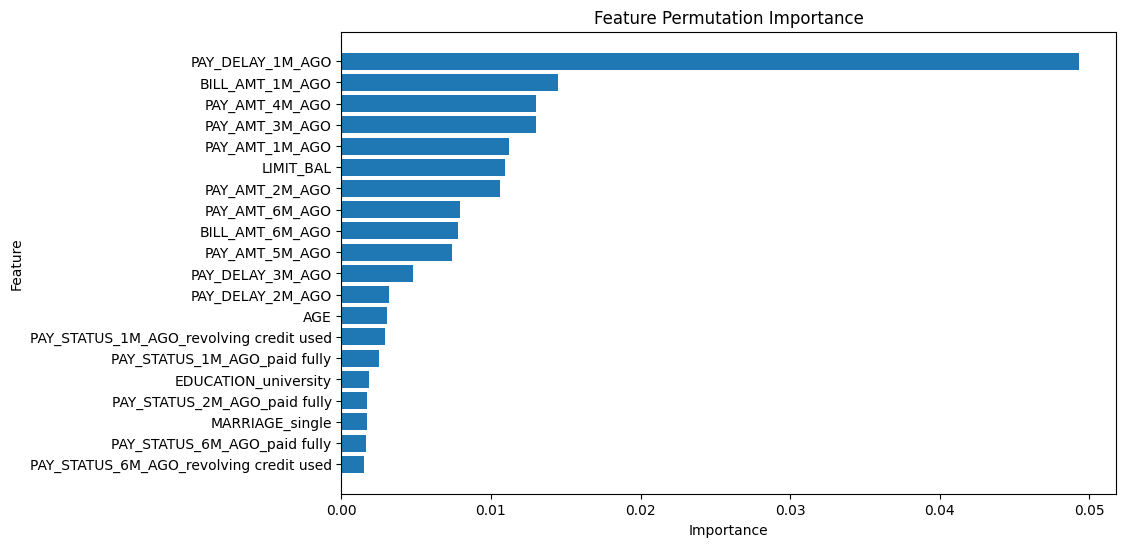

In [ ]:
plot_feat_permut_importance(rf2_feat_permut_import_df)

In [ ]:
rf2_perf, rf2_orig_missing, rf2_missing = measure_performance_decline(
    X_train, X_test, y_test, rf2_classifier, rf2_feat_permut_import_df,
    default_cc_imputation_values_dict, NUM_FEAT, method='simple',
    encoded_vars_family=default_cc_encoded_vars_family
)


--- NEW ITERATION ---
Removing feature:  PAY_DELAY_1M_AGO
Original feat removed so far:  ['PAY_DELAY_1M_AGO']

--- NEW ITERATION ---
Removing feature:  BILL_AMT_1M_AGO
Original feat removed so far:  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO']

--- NEW ITERATION ---
Removing feature:  PAY_AMT_4M_AGO
Original feat removed so far:  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'PAY_AMT_4M_AGO']

--- NEW ITERATION ---
Removing feature:  PAY_AMT_3M_AGO
Original feat removed so far:  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'PAY_AMT_4M_AGO', 'PAY_AMT_3M_AGO']

--- NEW ITERATION ---
Removing feature:  PAY_AMT_1M_AGO
Original feat removed so far:  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'PAY_AMT_4M_AGO', 'PAY_AMT_3M_AGO', 'PAY_AMT_1M_AGO']

--- NEW ITERATION ---
Removing feature:  LIMIT_BAL
Original feat removed so far:  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'PAY_AMT_4M_AGO', 'PAY_AMT_3M_AGO', 'PAY_AMT_1M_AGO', 'LIMIT_BAL']

--- NEW ITERATION ---
Removing feature:  PAY_AMT_2M_AGO
Original feat removed

In [ ]:
rf2_perf

tp    tn   fp    fn  precision  recall  specificity  accuracy  f1_score  \
0   785  3856  817   542      49.00   59.16        82.52     77.35     53.60   
1   662  3984  689   665      49.00   49.89        85.26     77.43     49.44   
2   565  4179  494   762      53.35   42.58        89.43     79.07     47.36   
3   558  4197  476   769      53.97   42.05        89.81     79.25     47.27   
4   550  4211  462   777      54.35   41.45        90.11     79.35     47.03   
5   528  4232  441   799      54.49   39.79        90.56     79.33     45.99   
6   483  4277  396   844      54.95   36.40        91.53     79.33     43.79   
7   463  4285  388   864      54.41   34.89        91.70     79.13     42.52   
8   447  4314  359   880      55.46   33.69        92.32     79.35     41.91   
9   451  4307  366   876      55.20   33.99        92.17     79.30     42.07   
10  447  4323  350   880      56.09   33.69        92.51     79.50     42.09   
11  380  4411  262   947      59.19   28.64        94.39     79.85     38.60   
12  272  4499  174  1055      60.99   20.50        96.28     79.52     30.68   
13  273  4495  178  1054      60.53   20.57        96.19     79.47     30.71   
14  275  4489  184  1052      59.91   20.72        96.06     79.40     30.80   
15  275  4491  182  1052      60.18   20.72        96.11     79.43     30.83   
16  276  4489  184  1051      60.00   20.80        96.06     79.42     30.89   
17  273  4490  183  1054      59.87   20.57        96.08     79.38     30.62   
18  273  4490  183  1054      59.87   20.57        96.08     79.38     30.62   
19  273  4490  183  1054      59.87   20.57        96.08     79.38     30.62   
20    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   

    balanced_accuracy  num_feat_missing  \
0               70.84                 0   
1               67.57                 1   
2               66.00                 2   
3               65.93                 3   
4               65.78                 4   
5               65.18                 5   
6               63.96                 6   
7               63.29                 7   
8               63.00                 8   
9               63.08                 9   
10              63.10                10   
11              61.51                11   
12              58.39                12   
13              58.38                13   
14              58.39                14   
15              58.41                15   
16              58.43                16   
17              58.33                17   
18              58.33                18   
19              58.33                19   
20              50.00                20   

                                              imputed  
0                                                      
1                        ['PAY_DELAY_1M_AGO'] imputed  
2     ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO'] imputed  
3   ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'PAY_A...  
4   ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'PAY_A...  
5   ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'PAY_A...  
6   ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'PAY_A...  
7   ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'PAY_A...  
8   ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'PAY_A...  
9   ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'PAY_A...  
10  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'PAY_A...  
11  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'PAY_A...  
12  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'PAY_A...  
13  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'PAY_A...  
14  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'PAY_A...  
15  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'PAY_A...  
16  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'PAY_A...  
17  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'PAY_A...  
18  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'PAY_A...  
19  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'PAY_A...  
20  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'PAY_A...

In [ ]:
start_time = time.time()
print(datetime.datetime.now())

rf2_perf_mf, rf2_orig_missing_mf, rf2_missing_mf = measure_performance_decline(
    X_train, X_test, y_test, rf2_classifier, rf2_feat_permut_import_df,
    imputation_dict=None, num_feat=NUM_FEAT, method='missforest',
    encoded_vars_family=default_cc_encoded_vars_family,
    categorical_vars=default_cc_cat_vars
)

print(datetime.datetime.now())
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time/60} minutes")

2025-01-18 16:27:30.388848

--- NEW ITERATION ---
Removing feature:  PAY_DELAY_1M_AGO
Nr. columns with nan:  1
Numerical columns:  ['PAY_DELAY_1M_AGO', 'PAY_DELAY_2M_AGO', 'PAY_DELAY_3M_AGO', 'PAY_DELAY_4M_AGO', 'PAY_DELAY_5M_AGO', 'PAY_DELAY_6M_AGO', 'LIMIT_BAL', 'PAY_AMT_1M_AGO', 'PAY_AMT_2M_AGO', 'PAY_AMT_3M_AGO', 'PAY_AMT_4M_AGO', 'PAY_AMT_5M_AGO', 'PAY_AMT_6M_AGO', 'AGE', 'BILL_AMT_1M_AGO', 'BILL_AMT_6M_AGO']
Categorical columns:  ['PAY_STATUS_1M_AGO_revolving credit used', 'PAY_STATUS_3M_AGO_revolving credit used', 'PAY_STATUS_4M_AGO_revolving credit used', 'PAY_STATUS_5M_AGO_revolving credit used', 'PAY_STATUS_6M_AGO_revolving credit used', 'PAY_STATUS_3M_AGO_paid fully', 'PAY_STATUS_2M_AGO_paid fully', 'PAY_STATUS_4M_AGO_paid fully', 'PAY_STATUS_5M_AGO_paid fully', 'PAY_STATUS_6M_AGO_paid fully', 'PAY_STATUS_1M_AGO_paid fully', 'EDUCATION_others', 'SEX_male', 'EDUCATION_university', 'MARRIAGE_single', 'EDUCATION_high school', 'MARRIAGE_others']
Column imputed:  PAY_DELAY_1M_AGO

In [ ]:
rf2_perf_mf

tp    tn   fp    fn  precision  recall  specificity  accuracy  f1_score  \
0   785  3856  817   542      49.00   59.16        82.52     77.35     53.60   
1   696  3918  755   631      47.97   52.45        83.84     76.90     50.11   
2   625  4074  599   702      51.06   47.10        87.18     78.32     49.00   
3   594  4133  540   733      52.38   44.76        88.44     78.78     48.27   
4   577  4159  514   750      52.89   43.48        89.00     78.93     47.73   
5   564  4182  491   763      53.46   42.50        89.49     79.10     47.36   
6   554  4181  492   773      52.96   41.75        89.47     78.92     46.69   
7   554  4192  481   773      53.53   41.75        89.71     79.10     46.91   
8   553  4193  480   774      53.53   41.67        89.73     79.10     46.86   
9   556  4177  496   771      52.85   41.90        89.39     78.88     46.74   
10  561  4172  501   766      52.82   42.28        89.28     78.88     46.97   
11  545  4201  472   782      53.59   41.07        89.90     79.10     46.50   
12  306  4485  188  1021      61.94   23.06        95.98     79.85     33.61   
13  302  4483  190  1025      61.38   22.76        95.93     79.75     33.21   
14  284  4487  186  1043      60.43   21.40        96.02     79.52     31.61   
15  278  4488  185  1049      60.04   20.95        96.04     79.43     31.06   
16  279  4490  183  1048      60.39   21.02        96.08     79.48     31.19   
17  276  4492  181  1051      60.39   20.80        96.13     79.47     30.94   
18  276  4491  182  1051      60.26   20.80        96.11     79.45     30.92   
19  273  4490  183  1054      59.87   20.57        96.08     79.38     30.62   
20  264  4505  168  1063      61.11   19.89        96.40     79.48     30.02   

    balanced_accuracy  num_feat_missing  \
0               70.84                 0   
1               68.15                 1   
2               67.14                 2   
3               66.60                 3   
4               66.24                 4   
5               66.00                 5   
6               65.61                 6   
7               65.73                 7   
8               65.70                 8   
9               65.64                 9   
10              65.78                10   
11              65.48                11   
12              59.52                12   
13              59.35                13   
14              58.71                14   
15              58.50                15   
16              58.55                16   
17              58.46                17   
18              58.45                18   
19              58.33                19   
20              58.15                20   

                                              imputed  
0                                                      
1                        ['PAY_DELAY_1M_AGO'] imputed  
2     ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO'] imputed  
3   ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'PAY_A...  
4   ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'PAY_A...  
5   ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'PAY_A...  
6   ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'PAY_A...  
7   ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'PAY_A...  
8   ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'PAY_A...  
9   ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'PAY_A...  
10  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'PAY_A...  
11  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'PAY_A...  
12  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'PAY_A...  
13  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'PAY_A...  
14  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'PAY_A...  
15  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'PAY_A...  
16  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'PAY_A...  
17  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'PAY_A...  
18  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'PAY_A...  
19  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'PAY_A...  
20  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'PAY_A...

In [ ]:
rf2_perf_temp, rf2_orig_missing_temp, rf2_missing_temp = measure_temporal_performance_decline(
    X_train, X_test, y_test, rf2_classifier, rf2_feat_permut_import_df,
    default_cc_timeline_vars_family,
    default_cc_imputation_values_dict, NUM_FEAT, method='simple',
    encoded_vars_family=default_cc_encoded_vars_family, log_info=True
)


--- NEW ITERATION ---
original removed:  []
length original removed:  0
num feat:  20
i:  0
length features importance list:  33
length removed:  0

Removing feature:  PAY_DELAY_1M_AGO
Removing related temporal feature:  BILL_AMT_1M_AGO
Removing related temporal feature:  PAY_AMT_1M_AGO
Removing related temporal feature:  PAY_DELAY_1M_AGO
Removing related temporal feature:  PAY_STATUS_1M_AGO_paid fully
Removing related features:  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1M_AGO_revolving credit used']
Removing related temporal feature:  PAY_STATUS_1M_AGO_revolving credit used
Removing related features:  []
Columns with zero variance, i.e. imputed:
                                    feature  variance
0                          PAY_DELAY_1M_AGO       0.0
6   PAY_STATUS_1M_AGO_revolving credit used       0.0
8                            PAY_AMT_1M_AGO       0.0
23             PAY_STATUS_1M_AGO_paid fully       0.0
30                          BILL_AMT_1M_AGO       0.0
Original feat re

In [ ]:
rf2_perf_temp

tp    tn   fp    fn  precision  recall  specificity  accuracy  f1_score  \
0  785  3856  817   542      49.00   59.16        82.52     77.35     53.60   
1  578  4095  578   749      50.00   43.56        87.63     77.88     46.56   
2  538  4183  490   789      52.33   40.54        89.51     78.68     45.69   
3  479  4268  405   848      54.19   36.10        91.33     79.12     43.33   
4  423  4349  324   904      56.63   31.88        93.07     79.53     40.79   
5  109  4600   73  1218      59.89    8.21        98.44     78.48     14.45   
6    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   
7    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   

   balanced_accuracy  num_feat_missing  \
0              70.84                 0   
1              65.59                 4   
2              65.03                 7   
3              63.71                10   
4              62.47                11   
5              53.33                14   
6              50.00                18   
7              50.00                21   

                                             imputed  
0                                                     
1  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
2  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
3  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
4  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
5  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
6  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
7  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...

In [ ]:
start_time = time.time()
print(datetime.datetime.now())

rf2_perf_temp_mf, rf2_orig_missing_temp_mf, rf2_missing_temp_mf = measure_temporal_performance_decline(
    X_train, X_test, y_test, rf2_classifier, rf2_feat_permut_import_df,
    default_cc_timeline_vars_family, num_feat=NUM_FEAT, method='missforest',
    encoded_vars_family=default_cc_encoded_vars_family,
    categorical_vars=default_cc_cat_vars, log_info=True
)

print(datetime.datetime.now())
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time/60} minutes")

2025-01-18 16:31:59.365508

--- NEW ITERATION ---
original removed:  []
length original removed:  0
num feat:  20
i:  0
length features importance list:  33
length removed:  0

Removing feature:  PAY_DELAY_1M_AGO
Removing related temporal feature:  BILL_AMT_1M_AGO
Removing related temporal feature:  PAY_AMT_1M_AGO
Removing related temporal feature:  PAY_DELAY_1M_AGO
Removing related temporal feature:  PAY_STATUS_1M_AGO_paid fully
Removing related features:  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1M_AGO_revolving credit used']
Removing related temporal feature:  PAY_STATUS_1M_AGO_revolving credit used
Removing related features:  []
Nr. columns with nan:  5
Numerical columns:  ['PAY_DELAY_1M_AGO', 'PAY_DELAY_2M_AGO', 'PAY_DELAY_3M_AGO', 'PAY_DELAY_4M_AGO', 'PAY_DELAY_5M_AGO', 'PAY_DELAY_6M_AGO', 'LIMIT_BAL', 'PAY_AMT_1M_AGO', 'PAY_AMT_2M_AGO', 'PAY_AMT_3M_AGO', 'PAY_AMT_4M_AGO', 'PAY_AMT_5M_AGO', 'PAY_AMT_6M_AGO', 'AGE', 'BILL_AMT_1M_AGO', 'BILL_AMT_6M_AGO']
Categorical columns:  [

In [ ]:
rf2_perf_temp_mf

tp    tn   fp    fn  precision  recall  specificity  accuracy  f1_score  \
0  785  3856  817   542      49.00   59.16        82.52     77.35     53.60   
1  555  4149  524   772      51.44   41.82        88.79     78.40     46.13   
2  525  4206  467   802      52.92   39.56        90.01     78.85     45.28   
3  494  4259  414   833      54.41   37.23        91.14     79.22     44.21   
4  470  4266  407   857      53.59   35.42        91.29     78.93     42.65   
5  252  4513  160  1075      61.17   18.99        96.58     79.42     28.98   
6  130  4577   96  1197      57.52    9.80        97.95     78.45     16.74   
7    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   

   balanced_accuracy  num_feat_missing  \
0              70.84                 0   
1              65.31                 4   
2              64.78                 7   
3              64.18                10   
4              63.35                11   
5              57.78                14   
6              53.87                18   
7              50.00                21   

                                             imputed  
0                                                     
1  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
2  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
3  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
4  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
5  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
6  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
7  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...

##**Gradient-Boosted Trees**

In [ ]:
FINE_TUNE = False

if FINE_TUNE:
  gbt2_param_grid = {
      'n_estimators': [100, 200, 300],
      'max_depth': [2, 3, 4, 5, None],  # literature recommends weak learners
      'min_child_samples': [100, 25, 1],
      'min_split_gain': [1, 0.5, 0.0],
      'reg_lambda': [10.0, 5.0, 1.0, 0.5, 0.0]
  }
else:
  # best model
  gbt2_param_grid = {
      'n_estimators': [100],
      'max_depth': [3],
      'min_child_samples': [25],
      'min_split_gain': [1.0],
      'reg_lambda': [0.0]
  }

gbt2_classifier = LGBMClassifier(
    objective= "binary",
    scale_pos_weight=ratio_majority_minority, random_state=RANDOM_STATE,
    verbose=-1, n_jobs=1
)
gbt2_grid_search, gbt2_best_model, gbt2_best_params = hyperparameter_tuning(
    gbt2_classifier, gbt2_param_grid, 3, 3, 'balanced_accuracy', X_train, y_train
)

Starting hyperparameter tuning at: 2025-01-18 16:33:36.049068

Nested Cross-validation Results:
Individual scores: [0.71588664 0.71737946 0.71949787]
Average nested CV score: 0.718 (+/- 0.003)

Fitting final model on entire dataset...
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best parameters: {'max_depth': 3, 'min_child_samples': 25, 'min_split_gain': 1.0, 'n_estimators': 100, 'reg_lambda': 0.0}

Best Model Performance:
Best CV score: 0.718
2025-01-18 16:33:40.573142

Execution time: 0.08 minutes


```
Starting hyperparameter tuning at: 2025-01-17 12:39:18.214181

Nested Cross-validation Results:
Individual scores: [0.71268296 0.71519348 0.71743704]
Average nested CV score: 0.715 (+/- 0.004)

Fitting final model on entire dataset...
Fitting 3 folds for each of 675 candidates, totalling 2025 fits
Best parameters: {'max_depth': 3, 'min_child_samples': 25, 'min_split_gain': 1, 'n_estimators': 100, 'reg_lambda': 0.0}

Best Model Performance:
Best CV score: 0.718
2025-01-17 12:48:22.141599

Execution time: 9.07 minutes
```

In [ ]:
gbt2_classifier, gbt2_train_pred, gbt2_test_pred = apply_model(gbt2_best_model, X_train, y_train, X_test, y_test)
gbt2_feat_permut_import_df = analyze_feat_permut_import(gbt2_classifier, X_train, y_train, scoring_metric="balanced_accuracy")
gbt2_feat_permut_import_df[gbt2_feat_permut_import_df['Importance']!=0]

Feature    Importance       Std
0                          PAY_DELAY_1M_AGO  6.710923e-02  0.000945
30                          BILL_AMT_1M_AGO  1.069976e-02  0.001507
7                                 LIMIT_BAL  1.057284e-02  0.001115
11                           PAY_AMT_3M_AGO  7.139588e-03  0.000752
2                          PAY_DELAY_3M_AGO  5.635660e-03  0.001263
12                           PAY_AMT_4M_AGO  5.512216e-03  0.000784
9                            PAY_AMT_2M_AGO  5.082551e-03  0.001163
8                            PAY_AMT_1M_AGO  4.769616e-03  0.000943
1                          PAY_DELAY_2M_AGO  4.039842e-03  0.000939
23             PAY_STATUS_1M_AGO_paid fully  3.850286e-03  0.000542
15                           PAY_AMT_6M_AGO  3.191614e-03  0.001104
13                           PAY_AMT_5M_AGO  2.677001e-03  0.000561
31                          BILL_AMT_6M_AGO  2.285328e-03  0.000469
3                          PAY_DELAY_4M_AGO  2.262764e-03  0.000776
5                          PAY_DELAY_6M_AGO  1.752184e-03  0.000703
24                         EDUCATION_others  1.675736e-03  0.000499
25                                 SEX_male  1.110491e-03  0.000836
4                          PAY_DELAY_5M_AGO  1.041875e-03  0.000557
29                                      AGE  8.967886e-04  0.000405
14  PAY_STATUS_4M_AGO_revolving credit used  2.995258e-04  0.000302
32                          MARRIAGE_others  2.895712e-04  0.000119
20             PAY_STATUS_4M_AGO_paid fully  2.379117e-04  0.000331
27                          MARRIAGE_single  1.188606e-04  0.000622
18             PAY_STATUS_3M_AGO_paid fully  9.630303e-05  0.000027
21             PAY_STATUS_5M_AGO_paid fully  6.323559e-05  0.000160
19             PAY_STATUS_2M_AGO_paid fully  4.815152e-05  0.000011
26                     EDUCATION_university  3.811327e-05  0.000107
17  PAY_STATUS_6M_AGO_revolving credit used  8.881784e-17  0.000024
22             PAY_STATUS_6M_AGO_paid fully -1.070034e-05  0.000043
6   PAY_STATUS_1M_AGO_revolving credit used -1.902620e-04  0.000273

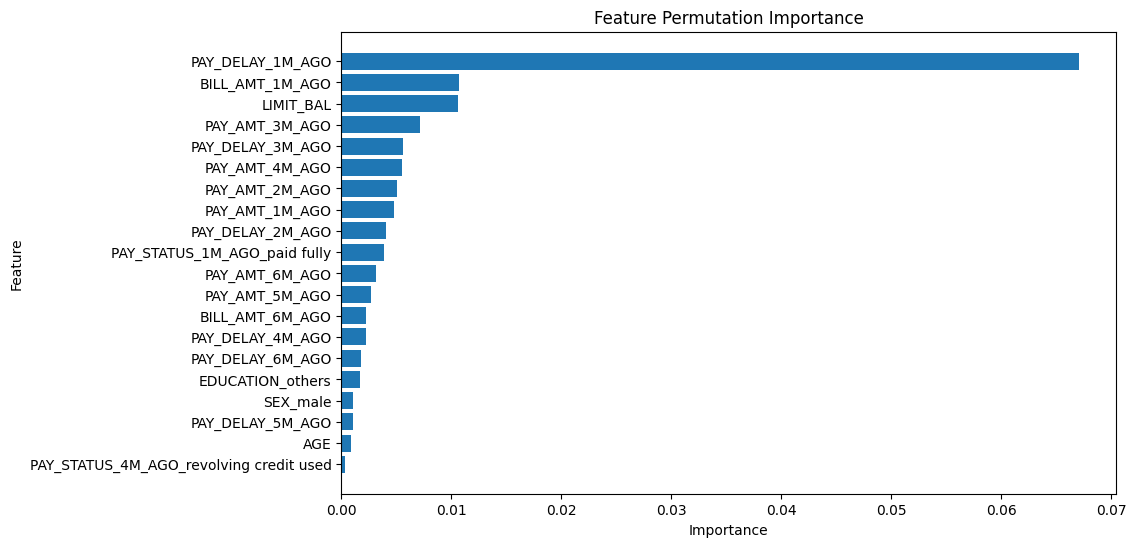

In [ ]:
plot_feat_permut_importance(gbt2_feat_permut_import_df)

In [ ]:
gbt2_perf, gbt2_orig_missing, gbt2_missing = measure_performance_decline(
    X_train, X_test, y_test, gbt2_classifier, gbt2_feat_permut_import_df,
    default_cc_imputation_values_dict, NUM_FEAT, method='simple',
    encoded_vars_family=default_cc_encoded_vars_family
)


--- NEW ITERATION ---
Removing feature:  PAY_DELAY_1M_AGO
Original feat removed so far:  ['PAY_DELAY_1M_AGO']

--- NEW ITERATION ---
Removing feature:  BILL_AMT_1M_AGO
Original feat removed so far:  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO']

--- NEW ITERATION ---
Removing feature:  LIMIT_BAL
Original feat removed so far:  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'LIMIT_BAL']

--- NEW ITERATION ---
Removing feature:  PAY_AMT_3M_AGO
Original feat removed so far:  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'LIMIT_BAL', 'PAY_AMT_3M_AGO']

--- NEW ITERATION ---
Removing feature:  PAY_DELAY_3M_AGO
Original feat removed so far:  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'LIMIT_BAL', 'PAY_AMT_3M_AGO', 'PAY_DELAY_3M_AGO']

--- NEW ITERATION ---
Removing feature:  PAY_AMT_4M_AGO
Original feat removed so far:  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'LIMIT_BAL', 'PAY_AMT_3M_AGO', 'PAY_DELAY_3M_AGO', 'PAY_AMT_4M_AGO']

--- NEW ITERATION ---
Removing feature:  PAY_AMT_2M_AGO
Original feat removed so far: 

In [ ]:
gbt2_perf

tp    tn   fp    fn  precision  recall  specificity  accuracy  f1_score  \
0   822  3731  942   505      46.60   61.94        79.84     75.88     53.19   
1   635  3918  755   692      45.68   47.85        83.84     75.88     46.74   
2   495  4206  467   832      51.46   37.30        90.01     78.35     43.25   
3   489  4255  418   838      53.91   36.85        91.05     79.07     43.78   
4   472  4292  381   855      55.33   35.57        91.85     79.40     43.30   
5   375  4402  271   952      58.05   28.26        94.20     79.62     38.01   
6   343  4435  238   984      59.04   25.85        94.91     79.63     35.95   
7   312  4463  210  1015      59.77   23.51        95.51     79.58     33.75   
8   319  4461  212  1008      60.08   24.04        95.46     79.67     34.34   
9   262  4504  169  1065      60.79   19.74        96.38     79.43     29.81   
10  255  4514  159  1072      61.59   19.22        96.60     79.48     29.29   
11  255  4515  158  1072      61.74   19.22        96.62     79.50     29.31   
12  252  4519  154  1075      62.07   18.99        96.70     79.52     29.08   
13  256  4515  158  1071      61.84   19.29        96.62     79.52     29.41   
14   45  4644   29  1282      60.81    3.39        99.38     78.15      6.42   
15    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   
16    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   
17    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   
18    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   
19    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   
20    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   

    balanced_accuracy  num_feat_missing  \
0               70.89                 0   
1               65.85                 1   
2               63.65                 2   
3               63.95                 3   
4               63.71                 4   
5               61.23                 5   
6               60.38                 6   
7               59.51                 7   
8               59.75                 8   
9               58.06                 9   
10              57.91                10   
11              57.92                11   
12              57.85                12   
13              57.96                13   
14              51.39                14   
15              50.00                15   
16              50.00                16   
17              50.00                17   
18              50.00                18   
19              50.00                19   
20              50.00                20   

                                              imputed  
0                                                      
1                        ['PAY_DELAY_1M_AGO'] imputed  
2     ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO'] imputed  
3   ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'LIMIT...  
4   ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'LIMIT...  
5   ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'LIMIT...  
6   ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'LIMIT...  
7   ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'LIMIT...  
8   ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'LIMIT...  
9   ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'LIMIT...  
10  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'LIMIT...  
11  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'LIMIT...  
12  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'LIMIT...  
13  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'LIMIT...  
14  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'LIMIT...  
15  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'LIMIT...  
16  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'LIMIT...  
17  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'LIMIT...  
18  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'LIMIT...  
19  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'LIMIT...  
20  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'LIMIT...

In [ ]:
start_time = time.time()
print(datetime.datetime.now())

gbt2_perf_mf, gbt2_orig_missing_mf, gbt2_missing_mf = measure_performance_decline(
    X_train, X_test, y_test, gbt2_classifier, gbt2_feat_permut_import_df,
    imputation_dict=None, num_feat=NUM_FEAT, method='missforest',
    encoded_vars_family=default_cc_encoded_vars_family,
    categorical_vars=default_cc_cat_vars
)

print(datetime.datetime.now())
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time/60} minutes")

2025-01-18 16:33:44.900084

--- NEW ITERATION ---
Removing feature:  PAY_DELAY_1M_AGO
Nr. columns with nan:  1
Numerical columns:  ['PAY_DELAY_1M_AGO', 'PAY_DELAY_2M_AGO', 'PAY_DELAY_3M_AGO', 'PAY_DELAY_4M_AGO', 'PAY_DELAY_5M_AGO', 'PAY_DELAY_6M_AGO', 'LIMIT_BAL', 'PAY_AMT_1M_AGO', 'PAY_AMT_2M_AGO', 'PAY_AMT_3M_AGO', 'PAY_AMT_4M_AGO', 'PAY_AMT_5M_AGO', 'PAY_AMT_6M_AGO', 'AGE', 'BILL_AMT_1M_AGO', 'BILL_AMT_6M_AGO']
Categorical columns:  ['PAY_STATUS_1M_AGO_revolving credit used', 'PAY_STATUS_3M_AGO_revolving credit used', 'PAY_STATUS_4M_AGO_revolving credit used', 'PAY_STATUS_5M_AGO_revolving credit used', 'PAY_STATUS_6M_AGO_revolving credit used', 'PAY_STATUS_3M_AGO_paid fully', 'PAY_STATUS_2M_AGO_paid fully', 'PAY_STATUS_4M_AGO_paid fully', 'PAY_STATUS_5M_AGO_paid fully', 'PAY_STATUS_6M_AGO_paid fully', 'PAY_STATUS_1M_AGO_paid fully', 'EDUCATION_others', 'SEX_male', 'EDUCATION_university', 'MARRIAGE_single', 'EDUCATION_high school', 'MARRIAGE_others']
Column imputed:  PAY_DELAY_1M_AGO

In [ ]:
gbt2_perf_mf

tp    tn    fp   fn  precision  recall  specificity  accuracy  f1_score  \
0    822  3731   942  505      46.60   61.94        79.84     75.88     53.19   
1   1014  2558  2115  313      32.41   76.41        54.74     59.53     45.51   
2    942  2809  1864  385      33.57   70.99        60.11     62.52     45.58   
3    859  3119  1554  468      35.60   64.73        66.75     66.30     45.94   
4    817  3308  1365  510      37.44   61.57        70.79     68.75     46.57   
5    806  3371  1302  521      38.24   60.74        72.14     69.62     46.93   
6    718  3696   977  609      42.36   54.11        79.09     73.57     47.52   
7    680  3795   878  647      43.65   51.24        81.21     74.58     47.14   
8    673  3809   864  654      43.79   50.72        81.51     74.70     47.00   
9    525  4018   655  802      44.49   39.56        85.98     75.72     41.88   
10   519  4039   634  808      45.01   39.11        86.43     75.97     41.85   
11   491  4102   571  836      46.23   37.00        87.78     76.55     41.11   
12   485  4106   567  842      46.10   36.55        87.87     76.52     40.77   
13   592  3806   867  735      40.58   44.61        81.45     73.30     42.50   
14   847  2722  1951  480      30.27   63.83        58.25     59.48     41.07   
15  1260   392  4281   67      22.74   94.95         8.39     27.53     36.69   
16  1267   324  4349   60      22.56   95.48         6.93     26.52     36.50   
17  1259   350  4323   68      22.55   94.88         7.49     26.82     36.45   
18  1315    52  4621   12      22.15   99.10         1.11     22.78     36.21   
19  1325    23  4650    2      22.18   99.85         0.49     22.47     36.29   
20  1321    45  4628    6      22.21   99.55         0.96     22.77     36.31   

    balanced_accuracy  num_feat_missing  \
0               70.89                 0   
1               65.58                 1   
2               65.55                 2   
3               65.74                 3   
4               66.18                 4   
5               66.44                 5   
6               66.60                 6   
7               66.23                 7   
8               66.11                 8   
9               62.77                 9   
10              62.77                10   
11              62.39                11   
12              62.21                12   
13              63.03                13   
14              61.04                14   
15              51.67                15   
16              51.21                16   
17              51.18                17   
18              50.10                18   
19              50.17                19   
20              50.26                20   

                                              imputed  
0                                                      
1                        ['PAY_DELAY_1M_AGO'] imputed  
2     ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO'] imputed  
3   ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'LIMIT...  
4   ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'LIMIT...  
5   ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'LIMIT...  
6   ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'LIMIT...  
7   ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'LIMIT...  
8   ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'LIMIT...  
9   ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'LIMIT...  
10  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'LIMIT...  
11  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'LIMIT...  
12  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'LIMIT...  
13  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'LIMIT...  
14  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'LIMIT...  
15  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'LIMIT...  
16  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'LIMIT...  
17  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'LIMIT...  
18  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'LIMIT...  
19  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'LIMIT...  
20  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'LIMIT...

In [ ]:
gbt2_perf_temp, gbt2_orig_missing_temp, gbt2_missing_temp = measure_temporal_performance_decline(
    X_train, X_test, y_test, gbt2_classifier, gbt2_feat_permut_import_df,
    default_cc_timeline_vars_family,
    default_cc_imputation_values_dict, NUM_FEAT, method='simple',
    encoded_vars_family=default_cc_encoded_vars_family, log_info=True
)


--- NEW ITERATION ---
original removed:  []
length original removed:  0
num feat:  20
i:  0
length features importance list:  33
length removed:  0

Removing feature:  PAY_DELAY_1M_AGO
Removing related temporal feature:  BILL_AMT_1M_AGO
Removing related temporal feature:  PAY_AMT_1M_AGO
Removing related temporal feature:  PAY_DELAY_1M_AGO
Removing related temporal feature:  PAY_STATUS_1M_AGO_paid fully
Removing related features:  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1M_AGO_revolving credit used']
Removing related temporal feature:  PAY_STATUS_1M_AGO_revolving credit used
Removing related features:  []
Columns with zero variance, i.e. imputed:
                                    feature  variance
0                          PAY_DELAY_1M_AGO       0.0
6   PAY_STATUS_1M_AGO_revolving credit used       0.0
8                            PAY_AMT_1M_AGO       0.0
23             PAY_STATUS_1M_AGO_paid fully       0.0
30                          BILL_AMT_1M_AGO       0.0
Original feat re

In [ ]:
gbt2_perf_temp

tp    tn   fp    fn  precision  recall  specificity  accuracy  f1_score  \
0  822  3731  942   505      46.60   61.94        79.84     75.88     53.19   
1  480  4237  436   847      52.40   36.17        90.67     78.62     42.80   
2  470  4281  392   857      54.52   35.42        91.61     79.18     42.94   
3  377  4415  258   950      59.37   28.41        94.48     79.87     38.43   
4  264  4539  134  1063      66.33   19.89        97.13     80.05     30.61   
5   64  4629   44  1263      59.26    4.82        99.06     78.22      8.92   
6    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   
7    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   

   balanced_accuracy  num_feat_missing  \
0              70.89                 0   
1              63.42                 4   
2              63.51                 5   
3              61.44                 8   
4              58.51                11   
5              51.94                14   
6              50.00                18   
7              50.00                21   

                                             imputed  
0                                                     
1  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
2  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
3  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
4  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
5  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
6  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
7  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...

In [ ]:
start_time = time.time()
print(datetime.datetime.now())

gbt2_perf_temp_mf, gbt2_orig_missing_temp_mf, gbt2_missing_temp_mf = measure_temporal_performance_decline(
    X_train, X_test, y_test, gbt2_classifier, gbt2_feat_permut_import_df,
    default_cc_timeline_vars_family, num_feat=NUM_FEAT, method='missforest',
    encoded_vars_family=default_cc_encoded_vars_family,
    categorical_vars=default_cc_cat_vars, log_info=True
)

print(datetime.datetime.now())
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time/60} minutes")

2025-01-18 16:38:14.977010

--- NEW ITERATION ---
original removed:  []
length original removed:  0
num feat:  20
i:  0
length features importance list:  33
length removed:  0

Removing feature:  PAY_DELAY_1M_AGO
Removing related temporal feature:  BILL_AMT_1M_AGO
Removing related temporal feature:  PAY_AMT_1M_AGO
Removing related temporal feature:  PAY_DELAY_1M_AGO
Removing related temporal feature:  PAY_STATUS_1M_AGO_paid fully
Removing related features:  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1M_AGO_revolving credit used']
Removing related temporal feature:  PAY_STATUS_1M_AGO_revolving credit used
Removing related features:  []
Nr. columns with nan:  5
Numerical columns:  ['PAY_DELAY_1M_AGO', 'PAY_DELAY_2M_AGO', 'PAY_DELAY_3M_AGO', 'PAY_DELAY_4M_AGO', 'PAY_DELAY_5M_AGO', 'PAY_DELAY_6M_AGO', 'LIMIT_BAL', 'PAY_AMT_1M_AGO', 'PAY_AMT_2M_AGO', 'PAY_AMT_3M_AGO', 'PAY_AMT_4M_AGO', 'PAY_AMT_5M_AGO', 'PAY_AMT_6M_AGO', 'AGE', 'BILL_AMT_1M_AGO', 'BILL_AMT_6M_AGO']
Categorical columns:  [

In [ ]:
gbt2_perf_temp_mf

tp    tn    fp   fn  precision  recall  specificity  accuracy  f1_score  \
0   822  3731   942  505      46.60   61.94        79.84     75.88     53.19   
1   840  3202  1471  487      36.35   63.30        68.52     67.37     46.18   
2   820  3347  1326  507      38.21   61.79        71.62     69.45     47.22   
3   738  3590  1083  589      40.53   55.61        76.82     72.13     46.89   
4   892  2866  1807  435      33.05   67.22        61.33     62.63     44.31   
5   700  3278  1395  627      33.41   52.75        70.15     66.30     40.91   
6  1221   528  4145  106      22.75   92.01        11.30     29.15     36.49   
7  1319    78  4595    8      22.30   99.40         1.67     23.28     36.43   

   balanced_accuracy  num_feat_missing  \
0              70.89                 0   
1              65.91                 4   
2              66.71                 5   
3              66.22                 8   
4              64.28                11   
5              61.45                14   
6              51.66                18   
7              50.53                21   

                                             imputed  
0                                                     
1  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
2  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
3  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
4  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
5  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
6  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
7  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...

##**XGBoost**

In [ ]:
FINE_TUNE = False

if FINE_TUNE:
  xgb2_param_grid = {
      'n_estimators': [100, 200, 300],
      'max_depth': [2, 3, 5, None],
      'reg_lambda':[10.0, 5.0, 1.0, 0.5, 0],     # L2 regularization on weights
      'gamma': [1.0, 0.5, 0.1, 0.05, 0.0],       # Minimum loss reduction required for node splitting (default=0)
      'colsample_bytree':[0.25, 0.5, 0.75, 1.0]  # Fraction of features used for each tree
  }
else:
  # best model
  xgb2_param_grid = {
    'n_estimators': [100],
    'max_depth': [2],
    'reg_lambda':[10.0],
    'gamma': [1.0],
    'colsample_bytree':[1.0]
}

xgb2_classifier = XGBClassifier(
    scale_pos_weight=ratio_majority_minority, random_state=RANDOM_STATE, n_jobs=1
)
xgb2_grid_search, xgb2_best_model, xgb2_best_params = hyperparameter_tuning(
    xgb2_classifier, xgb2_param_grid, 3, 3, 'balanced_accuracy', X_train, y_train
)

Starting hyperparameter tuning at: 2025-01-18 16:39:51.960268

Nested Cross-validation Results:
Individual scores: [0.71696456 0.71696548 0.71570676]
Average nested CV score: 0.717 (+/- 0.001)

Fitting final model on entire dataset...
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best parameters: {'colsample_bytree': 1.0, 'gamma': 1.0, 'max_depth': 2, 'n_estimators': 100, 'reg_lambda': 10.0}

Best Model Performance:
Best CV score: 0.717
2025-01-18 16:39:55.816638

Execution time: 0.06 minutes


```
Starting hyperparameter tuning at: 2025-01-17 12:48:22.149666

Nested Cross-validation Results:
Individual scores: [0.71438242 0.71372301 0.71583508]
Average nested CV score: 0.715 (+/- 0.002)

Fitting final model on entire dataset...
Fitting 3 folds for each of 1200 candidates, totalling 3600 fits
Best parameters: {'colsample_bytree': 1.0, 'gamma': 1.0, 'max_depth': 2, 'n_estimators': 100, 'reg_lambda': 10.0}

Best Model Performance:
Best CV score: 0.717
2025-01-17 13:05:01.037648

Execution time: 16.65 minutes
```

In [ ]:
xgb2_classifier, xgb2_train_pred, xgb2_test_pred = apply_model(xgb2_best_model, X_train, y_train, X_test, y_test)
xgb2_feat_permut_import_df = analyze_feat_permut_import(xgb2_classifier, X_train, y_train, scoring_metric="balanced_accuracy")
xgb2_feat_permut_import_df[xgb2_feat_permut_import_df['Importance']!=0]

Feature  Importance       Std
0                          PAY_DELAY_1M_AGO    0.063832  0.001349
7                                 LIMIT_BAL    0.015080  0.001066
30                          BILL_AMT_1M_AGO    0.014897  0.001499
11                           PAY_AMT_3M_AGO    0.004881  0.000981
12                           PAY_AMT_4M_AGO    0.004761  0.001576
9                            PAY_AMT_2M_AGO    0.004618  0.000559
1                          PAY_DELAY_2M_AGO    0.004436  0.000972
23             PAY_STATUS_1M_AGO_paid fully    0.003822  0.000822
8                            PAY_AMT_1M_AGO    0.003442  0.000797
2                          PAY_DELAY_3M_AGO    0.003061  0.000977
13                           PAY_AMT_5M_AGO    0.003019  0.000536
31                          BILL_AMT_6M_AGO    0.002924  0.000554
3                          PAY_DELAY_4M_AGO    0.002782  0.000372
15                           PAY_AMT_6M_AGO    0.002681  0.000712
29                                      AGE    0.002082  0.000457
24                         EDUCATION_others    0.001724  0.000355
27                          MARRIAGE_single    0.001374  0.000399
25                                 SEX_male    0.001187  0.000532
17  PAY_STATUS_6M_AGO_revolving credit used    0.000762  0.000222
4                          PAY_DELAY_5M_AGO    0.000751  0.000240
14  PAY_STATUS_4M_AGO_revolving credit used    0.000517  0.000368
22             PAY_STATUS_6M_AGO_paid fully    0.000480  0.000148
5                          PAY_DELAY_6M_AGO    0.000384  0.000806
19             PAY_STATUS_2M_AGO_paid fully    0.000343  0.000223
32                          MARRIAGE_others    0.000319  0.000151
26                     EDUCATION_university    0.000142  0.000146
16  PAY_STATUS_5M_AGO_revolving credit used    0.000035  0.000548
6   PAY_STATUS_1M_AGO_revolving credit used    0.000011  0.000624
18             PAY_STATUS_3M_AGO_paid fully   -0.000132  0.000528

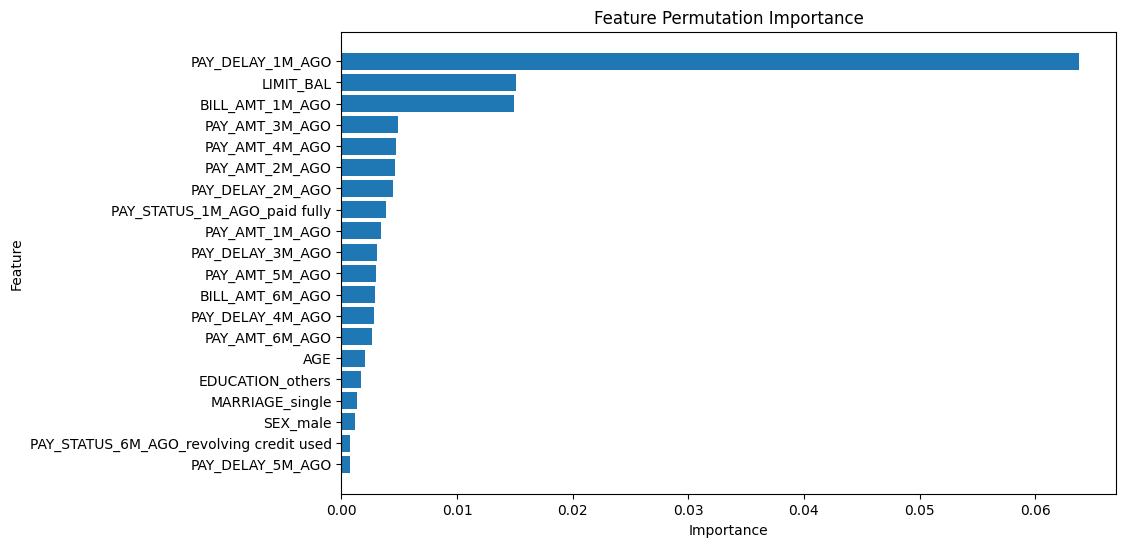

In [ ]:
plot_feat_permut_importance(xgb2_feat_permut_import_df)

In [ ]:
xgb2_perf, xgb2_orig_missing, xgb2_missing = measure_performance_decline(
    X_train, X_test, y_test, xgb2_classifier, xgb2_feat_permut_import_df,
    default_cc_imputation_values_dict, NUM_FEAT, method='simple',
    encoded_vars_family=default_cc_encoded_vars_family
)


--- NEW ITERATION ---
Removing feature:  PAY_DELAY_1M_AGO
Original feat removed so far:  ['PAY_DELAY_1M_AGO']

--- NEW ITERATION ---
Removing feature:  LIMIT_BAL
Original feat removed so far:  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL']

--- NEW ITERATION ---
Removing feature:  BILL_AMT_1M_AGO
Original feat removed so far:  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'BILL_AMT_1M_AGO']

--- NEW ITERATION ---
Removing feature:  PAY_AMT_3M_AGO
Original feat removed so far:  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'BILL_AMT_1M_AGO', 'PAY_AMT_3M_AGO']

--- NEW ITERATION ---
Removing feature:  PAY_AMT_4M_AGO
Original feat removed so far:  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'BILL_AMT_1M_AGO', 'PAY_AMT_3M_AGO', 'PAY_AMT_4M_AGO']

--- NEW ITERATION ---
Removing feature:  PAY_AMT_2M_AGO
Original feat removed so far:  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'BILL_AMT_1M_AGO', 'PAY_AMT_3M_AGO', 'PAY_AMT_4M_AGO', 'PAY_AMT_2M_AGO']

--- NEW ITERATION ---
Removing feature:  PAY_DELAY_2M_AGO
Original feat removed so far:  ['PAY_DEL

In [ ]:
xgb2_perf

tp    tn   fp    fn  precision  recall  specificity  accuracy  f1_score  \
0   809  3724  949   518      46.02   60.96        79.69     75.55     52.45   
1   635  3923  750   692      45.85   47.85        83.95     75.97     46.83   
2   636  3862  811   691      43.95   47.93        82.64     74.97     45.85   
3   464  4286  387   863      54.52   34.97        91.72     79.17     42.61   
4   444  4338  335   883      57.00   33.46        92.83     79.70     42.17   
5   441  4329  344   886      56.18   33.23        92.64     79.50     41.76   
6   407  4359  314   920      56.45   30.67        93.28     79.43     39.75   
7   311  4471  202  1016      60.62   23.44        95.68     79.70     33.80   
8   313  4472  201  1014      60.89   23.59        95.70     79.75     34.00   
9   272  4500  173  1055      61.12   20.50        96.30     79.53     30.70   
10  227  4536  137  1100      62.36   17.11        97.07     79.38     26.85   
11  215  4539  134  1112      61.60   16.20        97.13     79.23     25.66   
12  213  4535  138  1114      60.68   16.05        97.05     79.13     25.39   
13   22  4659   14  1305      61.11    1.66        99.70     78.02      3.23   
14   33  4650   23  1294      58.93    2.49        99.51     78.05      4.77   
15    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   
16    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   
17    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   
18    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   
19    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   
20    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   

    balanced_accuracy  num_feat_missing  \
0               70.33                 0   
1               65.90                 1   
2               65.29                 2   
3               63.34                 3   
4               63.15                 4   
5               62.94                 5   
6               61.98                 6   
7               59.56                 7   
8               59.64                 8   
9               58.40                 9   
10              57.09                10   
11              56.67                11   
12              56.55                12   
13              50.68                13   
14              51.00                14   
15              50.00                15   
16              50.00                16   
17              50.00                17   
18              50.00                18   
19              50.00                19   
20              50.00                20   

                                              imputed  
0                                                      
1                        ['PAY_DELAY_1M_AGO'] imputed  
2           ['PAY_DELAY_1M_AGO', 'LIMIT_BAL'] imputed  
3   ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'BILL_AMT_1M...  
4   ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'BILL_AMT_1M...  
5   ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'BILL_AMT_1M...  
6   ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'BILL_AMT_1M...  
7   ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'BILL_AMT_1M...  
8   ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'BILL_AMT_1M...  
9   ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'BILL_AMT_1M...  
10  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'BILL_AMT_1M...  
11  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'BILL_AMT_1M...  
12  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'BILL_AMT_1M...  
13  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'BILL_AMT_1M...  
14  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'BILL_AMT_1M...  
15  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'BILL_AMT_1M...  
16  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'BILL_AMT_1M...  
17  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'BILL_AMT_1M...  
18  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'BILL_AMT_1M...  
19  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'BILL_AMT_1M...  
20  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'BILL_AMT_1M...

In [ ]:
start_time = time.time()
print(datetime.datetime.now())


xgb2_perf_mf, xgb2_orig_missing_mf, xgb2_missing_mf = measure_performance_decline(
    X_train, X_test, y_test, xgb2_classifier, xgb2_feat_permut_import_df,
    imputation_dict=None, num_feat=NUM_FEAT, method='missforest',
    encoded_vars_family=default_cc_encoded_vars_family,
    categorical_vars=default_cc_cat_vars
)

print(datetime.datetime.now())
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time/60} minutes")

2025-01-18 16:39:58.791949

--- NEW ITERATION ---
Removing feature:  PAY_DELAY_1M_AGO
Nr. columns with nan:  1
Numerical columns:  ['PAY_DELAY_1M_AGO', 'PAY_DELAY_2M_AGO', 'PAY_DELAY_3M_AGO', 'PAY_DELAY_4M_AGO', 'PAY_DELAY_5M_AGO', 'PAY_DELAY_6M_AGO', 'LIMIT_BAL', 'PAY_AMT_1M_AGO', 'PAY_AMT_2M_AGO', 'PAY_AMT_3M_AGO', 'PAY_AMT_4M_AGO', 'PAY_AMT_5M_AGO', 'PAY_AMT_6M_AGO', 'AGE', 'BILL_AMT_1M_AGO', 'BILL_AMT_6M_AGO']
Categorical columns:  ['PAY_STATUS_1M_AGO_revolving credit used', 'PAY_STATUS_3M_AGO_revolving credit used', 'PAY_STATUS_4M_AGO_revolving credit used', 'PAY_STATUS_5M_AGO_revolving credit used', 'PAY_STATUS_6M_AGO_revolving credit used', 'PAY_STATUS_3M_AGO_paid fully', 'PAY_STATUS_2M_AGO_paid fully', 'PAY_STATUS_4M_AGO_paid fully', 'PAY_STATUS_5M_AGO_paid fully', 'PAY_STATUS_6M_AGO_paid fully', 'PAY_STATUS_1M_AGO_paid fully', 'EDUCATION_others', 'SEX_male', 'EDUCATION_university', 'MARRIAGE_single', 'EDUCATION_high school', 'MARRIAGE_others']
Column imputed:  PAY_DELAY_1M_AGO

In [ ]:
xgb2_perf_mf

tp    tn   fp    fn  precision  recall  specificity  accuracy  f1_score  \
0   809  3724  949   518      46.02   60.96        79.69     75.55     52.45   
1   689  3863  810   638      45.96   51.92        82.67     75.87     48.76   
2   643  3961  712   684      47.45   48.46        84.76     76.73     47.95   
3   585  4109  564   742      50.91   44.08        87.93     78.23     47.25   
4   536  4206  467   791      53.44   40.39        90.01     79.03     46.01   
5   523  4230  443   804      54.14   39.41        90.52     79.22     45.62   
6   520  4247  426   807      54.97   39.19        90.88     79.45     45.75   
7   325  4459  214  1002      60.30   24.49        95.42     79.73     34.83   
8   327  4463  210  1000      60.89   24.64        95.51     79.83     35.09   
9   338  4440  233   989      59.19   25.47        95.01     79.63     35.62   
10  229  4526  147  1098      60.90   17.26        96.85     79.25     26.89   
11  227  4531  142  1100      61.52   17.11        96.96     79.30     26.77   
12  286  4465  208  1041      57.89   21.55        95.55     79.18     31.41   
13  204  4510  163  1123      55.59   15.37        96.51     78.57     24.09   
14  167  4577   96  1160      63.50   12.58        97.95     79.07     21.01   
15  194  4563  110  1133      63.82   14.62        97.65     79.28     23.79   
16  194  4562  111  1133      63.61   14.62        97.62     79.27     23.77   
17  146  4588   85  1181      63.20   11.00        98.18     78.90     18.74   
18   99  4595   78  1228      55.93    7.46        98.33     78.23     13.16   
19   99  4595   78  1228      55.93    7.46        98.33     78.23     13.16   
20    9  4671    2  1318      81.82    0.68        99.96     78.00      1.35   

    balanced_accuracy  num_feat_missing  \
0               70.33                 0   
1               67.29                 1   
2               66.61                 2   
3               66.01                 3   
4               65.20                 4   
5               64.97                 5   
6               65.03                 6   
7               59.96                 7   
8               60.07                 8   
9               60.24                 9   
10              57.06                10   
11              57.03                11   
12              58.55                12   
13              55.94                13   
14              55.27                14   
15              56.13                15   
16              56.12                16   
17              54.59                17   
18              52.90                18   
19              52.90                19   
20              50.32                20   

                                              imputed  
0                                                      
1                        ['PAY_DELAY_1M_AGO'] imputed  
2           ['PAY_DELAY_1M_AGO', 'LIMIT_BAL'] imputed  
3   ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'BILL_AMT_1M...  
4   ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'BILL_AMT_1M...  
5   ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'BILL_AMT_1M...  
6   ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'BILL_AMT_1M...  
7   ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'BILL_AMT_1M...  
8   ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'BILL_AMT_1M...  
9   ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'BILL_AMT_1M...  
10  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'BILL_AMT_1M...  
11  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'BILL_AMT_1M...  
12  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'BILL_AMT_1M...  
13  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'BILL_AMT_1M...  
14  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'BILL_AMT_1M...  
15  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'BILL_AMT_1M...  
16  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'BILL_AMT_1M...  
17  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'BILL_AMT_1M...  
18  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'BILL_AMT_1M...  
19  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'BILL_AMT_1M...  
20  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'BILL_AMT_1M...

In [ ]:
xgb2_perf_temp, xgb2_orig_missing_temp, xgb2_missing_temp = measure_temporal_performance_decline(
    X_train, X_test, y_test, xgb2_classifier, xgb2_feat_permut_import_df,
    default_cc_timeline_vars_family,
    default_cc_imputation_values_dict, NUM_FEAT, method='simple',
    encoded_vars_family=default_cc_encoded_vars_family, log_info=True
)


--- NEW ITERATION ---
original removed:  []
length original removed:  0
num feat:  20
i:  0
length features importance list:  33
length removed:  0

Removing feature:  PAY_DELAY_1M_AGO
Removing related temporal feature:  BILL_AMT_1M_AGO
Removing related temporal feature:  PAY_AMT_1M_AGO
Removing related temporal feature:  PAY_DELAY_1M_AGO
Removing related temporal feature:  PAY_STATUS_1M_AGO_paid fully
Removing related features:  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1M_AGO_revolving credit used']
Removing related temporal feature:  PAY_STATUS_1M_AGO_revolving credit used
Removing related features:  []
Columns with zero variance, i.e. imputed:
                                    feature  variance
0                          PAY_DELAY_1M_AGO       0.0
6   PAY_STATUS_1M_AGO_revolving credit used       0.0
8                            PAY_AMT_1M_AGO       0.0
23             PAY_STATUS_1M_AGO_paid fully       0.0
30                          BILL_AMT_1M_AGO       0.0
Original feat re

In [ ]:
xgb2_perf_temp

tp    tn   fp    fn  precision  recall  specificity  accuracy  f1_score  \
0  809  3724  949   518      46.02   60.96        79.69     75.55     52.45   
1  447  4307  366   880      54.98   33.69        92.17     79.23     41.78   
2  425  4345  328   902      56.44   32.03        92.98     79.50     40.87   
3  319  4477  196  1008      61.94   24.04        95.81     79.93     34.64   
4  242  4551  122  1085      66.48   18.24        97.39     79.88     28.62   
5   45  4646   27  1282      62.50    3.39        99.42     78.18      6.43   
6    5  4668    5  1322      50.00    0.38        99.89     77.88      0.75   
7    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   

   balanced_accuracy  num_feat_missing  \
0              70.33                 0   
1              62.93                 4   
2              62.50                 5   
3              59.92                 8   
4              57.81                11   
5              51.41                14   
6              50.13                17   
7              50.00                21   

                                             imputed  
0                                                     
1  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
2  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
3  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
4  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
5  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
6  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
7  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...

In [ ]:
start_time = time.time()
print(datetime.datetime.now())

xgb2_perf_temp_mf, xgb2_orig_missing_temp_mf, xgb2_missing_temp_mf = measure_temporal_performance_decline(
    X_train, X_test, y_test, xgb2_classifier, xgb2_feat_permut_import_df,
    default_cc_timeline_vars_family, num_feat=NUM_FEAT, method='missforest',
    encoded_vars_family=default_cc_encoded_vars_family,
    categorical_vars=default_cc_cat_vars, log_info=True
)

print(datetime.datetime.now())
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time/60} minutes")

2025-01-18 16:44:30.794690

--- NEW ITERATION ---
original removed:  []
length original removed:  0
num feat:  20
i:  0
length features importance list:  33
length removed:  0

Removing feature:  PAY_DELAY_1M_AGO
Removing related temporal feature:  BILL_AMT_1M_AGO
Removing related temporal feature:  PAY_AMT_1M_AGO
Removing related temporal feature:  PAY_DELAY_1M_AGO
Removing related temporal feature:  PAY_STATUS_1M_AGO_paid fully
Removing related features:  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1M_AGO_revolving credit used']
Removing related temporal feature:  PAY_STATUS_1M_AGO_revolving credit used
Removing related features:  []
Nr. columns with nan:  5
Numerical columns:  ['PAY_DELAY_1M_AGO', 'PAY_DELAY_2M_AGO', 'PAY_DELAY_3M_AGO', 'PAY_DELAY_4M_AGO', 'PAY_DELAY_5M_AGO', 'PAY_DELAY_6M_AGO', 'LIMIT_BAL', 'PAY_AMT_1M_AGO', 'PAY_AMT_2M_AGO', 'PAY_AMT_3M_AGO', 'PAY_AMT_4M_AGO', 'PAY_AMT_5M_AGO', 'PAY_AMT_6M_AGO', 'AGE', 'BILL_AMT_1M_AGO', 'BILL_AMT_6M_AGO']
Categorical columns:  [

In [ ]:
xgb2_perf_temp_mf

tp    tn   fp    fn  precision  recall  specificity  accuracy  f1_score  \
0  809  3724  949   518      46.02   60.96        79.69     75.55     52.45   
1  589  4061  612   738      49.04   44.39        86.90     77.50     46.60   
2  552  4166  507   775      52.12   41.60        89.15     78.63     46.27   
3  500  4258  415   827      54.64   37.68        91.12     79.30     44.60   
4  470  4314  359   857      56.69   35.42        92.32     79.73     43.60   
5  142  4589   84  1185      62.83   10.70        98.20     78.85     18.29   
6   15  4669    4  1312      78.95    1.13        99.91     78.07      2.23   
7    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   

   balanced_accuracy  num_feat_missing  \
0              70.33                 0   
1              65.64                 4   
2              65.37                 5   
3              64.40                 8   
4              63.87                11   
5              54.45                14   
6              50.52                17   
7              50.00                21   

                                             imputed  
0                                                     
1  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
2  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
3  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
4  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
5  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
6  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
7  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...

## **Extra Trees Classifier**

In [ ]:
FINE_TUNE = False

if FINE_TUNE:
  et2_param_grid = {
      'n_estimators': [100, 200, 300, 500],
      'max_depth': [2, 3, 5, None],
      'max_features':['sqrt', 0.5, 1.0],
      'min_samples_split': [0.005, 0.001, 2],
      'min_samples_leaf': [0.005, 0.001, 1]
  }
else:
  et2_param_grid = {
      'n_estimators': [100],
      'max_depth': [None],
      'max_features':[0.5],
      'min_samples_split': [0.005],
      'min_samples_leaf': [0.001]
  }

et2_classifier = ExtraTreesClassifier(class_weight='balanced', random_state=RANDOM_STATE)
et2_grid_search, et2_best_model, et2_best_params = hyperparameter_tuning(
    et2_classifier, et2_param_grid, 3, 3, 'balanced_accuracy', X_train, y_train
)

Starting hyperparameter tuning at: 2025-01-18 16:46:05.710344

Nested Cross-validation Results:
Individual scores: [0.7211949  0.70450481 0.71150212]
Average nested CV score: 0.712 (+/- 0.014)

Fitting final model on entire dataset...
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best parameters: {'max_depth': None, 'max_features': 0.5, 'min_samples_leaf': 0.001, 'min_samples_split': 0.005, 'n_estimators': 100}

Best Model Performance:
Best CV score: 0.712
2025-01-18 16:46:17.272208

Execution time: 0.19 minutes


```
Starting hyperparameter tuning at: 2025-01-17 14:20:53.278886

Nested Cross-validation Results:
Individual scores: [0.71701863 0.70397249 0.71141869]
Average nested CV score: 0.711 (+/- 0.011)

Fitting final model on entire dataset...
Fitting 3 folds for each of 432 candidates, totalling 1296 fits
Best parameters: {'max_depth': None, 'max_features': 0.5, 'min_samples_leaf': 0.001, 'min_samples_split': 0.005, 'n_estimators': 100}

Best Model Performance:
Best CV score: 0.712
2025-01-17 15:04:32.378548

Execution time: 43.65 minutes
```




In [ ]:
et2_classifier, train_pred, test_pred = apply_model(et2_best_model, X_train, y_train, X_test, y_test)
et2_feat_permut_import_df = analyze_feat_permut_import(et2_classifier, X_train, y_train, scoring_metric="balanced_accuracy")
et2_feat_permut_import_df[et2_feat_permut_import_df['Importance']!=0]

Feature  Importance       Std
0                          PAY_DELAY_1M_AGO    0.049906  0.001673
6   PAY_STATUS_1M_AGO_revolving credit used    0.013754  0.000818
7                                 LIMIT_BAL    0.012613  0.001478
1                          PAY_DELAY_2M_AGO    0.010765  0.001605
17  PAY_STATUS_6M_AGO_revolving credit used    0.009882  0.001496
30                          BILL_AMT_1M_AGO    0.007915  0.000944
10  PAY_STATUS_3M_AGO_revolving credit used    0.007187  0.000634
19             PAY_STATUS_2M_AGO_paid fully    0.006695  0.000317
23             PAY_STATUS_1M_AGO_paid fully    0.006409  0.000498
2                          PAY_DELAY_3M_AGO    0.005794  0.001250
18             PAY_STATUS_3M_AGO_paid fully    0.005159  0.000509
25                                 SEX_male    0.005118  0.000785
26                     EDUCATION_university    0.004846  0.000969
11                           PAY_AMT_3M_AGO    0.004646  0.000489
27                          MARRIAGE_single    0.004124  0.000284
31                          BILL_AMT_6M_AGO    0.003695  0.000536
3                          PAY_DELAY_4M_AGO    0.003083  0.001233
12                           PAY_AMT_4M_AGO    0.003080  0.000341
8                            PAY_AMT_1M_AGO    0.003065  0.000458
20             PAY_STATUS_4M_AGO_paid fully    0.002888  0.000755
14  PAY_STATUS_4M_AGO_revolving credit used    0.002535  0.000508
15                           PAY_AMT_6M_AGO    0.002488  0.000553
13                           PAY_AMT_5M_AGO    0.002444  0.000234
21             PAY_STATUS_5M_AGO_paid fully    0.002429  0.000306
16  PAY_STATUS_5M_AGO_revolving credit used    0.002145  0.000309
9                            PAY_AMT_2M_AGO    0.002127  0.000495
29                                      AGE    0.002121  0.000436
28                    EDUCATION_high school    0.001837  0.000296
22             PAY_STATUS_6M_AGO_paid fully    0.001492  0.000153
5                          PAY_DELAY_6M_AGO    0.000744  0.000340
4                          PAY_DELAY_5M_AGO    0.000454  0.000293
24                         EDUCATION_others    0.000393  0.000277

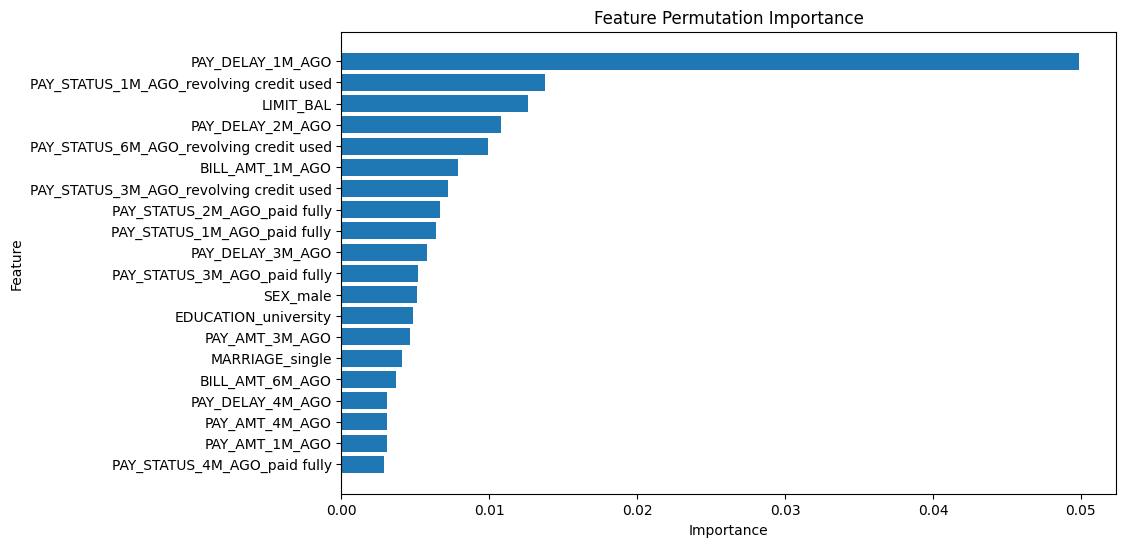

In [ ]:
plot_feat_permut_importance(et2_feat_permut_import_df)

In [ ]:
et2_perf, et2_orig_missing, et2_missing = measure_performance_decline(
    X_train, X_test, y_test, et2_classifier, et2_feat_permut_import_df,
    default_cc_imputation_values_dict, NUM_FEAT, method='simple',
    encoded_vars_family=default_cc_encoded_vars_family
)


--- NEW ITERATION ---
Removing feature:  PAY_DELAY_1M_AGO
Original feat removed so far:  ['PAY_DELAY_1M_AGO']

--- NEW ITERATION ---
Removing feature:  PAY_STATUS_1M_AGO_revolving credit used
Removing related features:  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1M_AGO_revolving credit used']
Original feat removed so far:  ['PAY_DELAY_1M_AGO', 'PAY_STATUS_1M_AGO']

--- NEW ITERATION ---
Removing feature:  LIMIT_BAL
Original feat removed so far:  ['PAY_DELAY_1M_AGO', 'PAY_STATUS_1M_AGO', 'LIMIT_BAL']

--- NEW ITERATION ---
Removing feature:  PAY_DELAY_2M_AGO
Original feat removed so far:  ['PAY_DELAY_1M_AGO', 'PAY_STATUS_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_2M_AGO']

--- NEW ITERATION ---
Removing feature:  PAY_STATUS_6M_AGO_revolving credit used
Removing related features:  ['PAY_STATUS_6M_AGO_paid fully', 'PAY_STATUS_6M_AGO_revolving credit used']
Original feat removed so far:  ['PAY_DELAY_1M_AGO', 'PAY_STATUS_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_2M_AGO', 'PAY_STATUS_6M_AGO']

--- NEW ITERA

In [ ]:
et2_perf

tp    tn   fp    fn  precision  recall  specificity  accuracy  f1_score  \
0   798  3835  838   529      48.78   60.14        82.07     77.22     53.86   
1   654  3999  674   673      49.25   49.28        85.58     77.55     49.27   
2   645  3993  680   682      48.68   48.61        85.45     77.30     48.64   
3   625  4031  642   702      49.33   47.10        86.26     77.60     48.19   
4   492  4189  484   835      50.41   37.08        89.64     78.02     42.73   
5   459  4229  444   868      50.83   34.59        90.50     78.13     41.17   
6   452  4238  435   875      50.96   34.06        90.69     78.17     40.83   
7   465  4226  447   862      50.99   35.04        90.43     78.18     41.54   
8   485  4184  489   842      49.79   36.55        89.54     77.82     42.16   
9   405  4318  355   922      53.29   30.52        92.40     78.72     38.81   
10  405  4323  350   922      53.64   30.52        92.51     78.80     38.90   
11  398  4327  346   929      53.49   29.99        92.60     78.75     38.44   
12  400  4330  343   927      53.84   30.14        92.66     78.83     38.65   
13  387  4339  334   940      53.68   29.16        92.85     78.77     37.79   
14  394  4331  342   933      53.53   29.69        92.68     78.75     38.20   
15  250  4517  156  1077      61.58   18.84        96.66     79.45     28.85   
16  250  4516  157  1077      61.43   18.84        96.64     79.43     28.84   
17  246  4520  153  1081      61.65   18.54        96.73     79.43     28.51   
18   72  4635   38  1255      65.45    5.43        99.19     78.45     10.02   
19   62  4647   26  1265      70.45    4.67        99.44     78.48      8.76   
20   50  4656   17  1277      74.63    3.77        99.64     78.43      7.17   

    balanced_accuracy  num_feat_missing  \
0               71.10                 0   
1               67.43                 1   
2               67.03                 2   
3               66.68                 3   
4               63.36                 4   
5               62.54                 5   
6               62.38                 6   
7               62.74                 7   
8               63.04                 8   
9               61.46                 9   
10              61.52                10   
11              61.29                11   
12              61.40                12   
13              61.01                13   
14              61.19                14   
15              57.75                15   
16              57.74                16   
17              57.63                17   
18              52.31                18   
19              52.06                19   
20              51.70                20   

                                              imputed  
0                                                      
1                        ['PAY_DELAY_1M_AGO'] imputed  
2   ['PAY_DELAY_1M_AGO', 'PAY_STATUS_1M_AGO_paid f...  
3   ['PAY_DELAY_1M_AGO', 'PAY_STATUS_1M_AGO_paid f...  
4   ['PAY_DELAY_1M_AGO', 'PAY_STATUS_1M_AGO_paid f...  
5   ['PAY_DELAY_1M_AGO', 'PAY_STATUS_1M_AGO_paid f...  
6   ['PAY_DELAY_1M_AGO', 'PAY_STATUS_1M_AGO_paid f...  
7   ['PAY_DELAY_1M_AGO', 'PAY_STATUS_1M_AGO_paid f...  
8   ['PAY_DELAY_1M_AGO', 'PAY_STATUS_1M_AGO_paid f...  
9   ['PAY_DELAY_1M_AGO', 'PAY_STATUS_1M_AGO_paid f...  
10  ['PAY_DELAY_1M_AGO', 'PAY_STATUS_1M_AGO_paid f...  
11  ['PAY_DELAY_1M_AGO', 'PAY_STATUS_1M_AGO_paid f...  
12  ['PAY_DELAY_1M_AGO', 'PAY_STATUS_1M_AGO_paid f...  
13  ['PAY_DELAY_1M_AGO', 'PAY_STATUS_1M_AGO_paid f...  
14  ['PAY_DELAY_1M_AGO', 'PAY_STATUS_1M_AGO_paid f...  
15  ['PAY_DELAY_1M_AGO', 'PAY_STATUS_1M_AGO_paid f...  
16  ['PAY_DELAY_1M_AGO', 'PAY_STATUS_1M_AGO_paid f...  
17  ['PAY_DELAY_1M_AGO', 'PAY_STATUS_1M_AGO_paid f...  
18  ['PAY_DELAY_1M_AGO', 'PAY_STATUS_1M_AGO_paid f...  
19  ['PAY_DELAY_1M_AGO', 'PAY_STATUS_1M_AGO_paid f...  
20  ['PAY_DELAY_1M_AGO', 'PAY_STATUS_1M_AGO_paid f...

In [ ]:
start_time = time.time()
print(datetime.datetime.now())

et2_perf_mf, et2_orig_missing_mf, et2_missing_mf = measure_performance_decline(
    X_train, X_test, y_test, et2_classifier, et2_feat_permut_import_df,
    imputation_dict=None, num_feat=NUM_FEAT, method='missforest',
    encoded_vars_family=default_cc_encoded_vars_family,
    categorical_vars=default_cc_cat_vars
)

print(datetime.datetime.now())
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time/60} minutes")

2025-01-18 16:46:27.918733

--- NEW ITERATION ---
Removing feature:  PAY_DELAY_1M_AGO
Nr. columns with nan:  1
Numerical columns:  ['PAY_DELAY_1M_AGO', 'PAY_DELAY_2M_AGO', 'PAY_DELAY_3M_AGO', 'PAY_DELAY_4M_AGO', 'PAY_DELAY_5M_AGO', 'PAY_DELAY_6M_AGO', 'LIMIT_BAL', 'PAY_AMT_1M_AGO', 'PAY_AMT_2M_AGO', 'PAY_AMT_3M_AGO', 'PAY_AMT_4M_AGO', 'PAY_AMT_5M_AGO', 'PAY_AMT_6M_AGO', 'AGE', 'BILL_AMT_1M_AGO', 'BILL_AMT_6M_AGO']
Categorical columns:  ['PAY_STATUS_1M_AGO_revolving credit used', 'PAY_STATUS_3M_AGO_revolving credit used', 'PAY_STATUS_4M_AGO_revolving credit used', 'PAY_STATUS_5M_AGO_revolving credit used', 'PAY_STATUS_6M_AGO_revolving credit used', 'PAY_STATUS_3M_AGO_paid fully', 'PAY_STATUS_2M_AGO_paid fully', 'PAY_STATUS_4M_AGO_paid fully', 'PAY_STATUS_5M_AGO_paid fully', 'PAY_STATUS_6M_AGO_paid fully', 'PAY_STATUS_1M_AGO_paid fully', 'EDUCATION_others', 'SEX_male', 'EDUCATION_university', 'MARRIAGE_single', 'EDUCATION_high school', 'MARRIAGE_others']
Column imputed:  PAY_DELAY_1M_AGO

In [ ]:
et2_perf_mf

tp    tn   fp    fn  precision  recall  specificity  accuracy  f1_score  \
0   798  3835  838   529      48.78   60.14        82.07     77.22     53.86   
1   708  3887  786   619      47.39   53.35        83.18     76.58     50.19   
2   667  3905  768   660      46.48   50.26        83.57     76.20     48.30   
3   625  3963  710   702      46.82   47.10        84.81     76.47     46.96   
4   576  3990  683   751      45.75   43.41        85.38     76.10     44.55   
5   565  4043  630   762      47.28   42.58        86.52     76.80     44.81   
6   489  4185  488   838      50.05   36.85        89.56     77.90     42.45   
7   434  4282  391   893      52.61   32.71        91.63     78.60     40.33   
8   426  4296  377   901      53.05   32.10        91.93     78.70     40.00   
9   388  4359  314   939      55.27   29.24        93.28     79.12     38.25   
10  382  4360  313   945      54.96   28.79        93.30     79.03     37.78   
11  384  4363  310   943      55.33   28.94        93.37     79.12     38.00   
12  386  4364  309   941      55.54   29.09        93.39     79.17     38.18   
13  364  4397  276   963      56.88   27.43        94.09     79.35     37.01   
14  374  4378  295   953      55.90   28.18        93.69     79.20     37.47   
15  328  4422  251   999      56.65   24.72        94.63     79.17     34.42   
16  328  4422  251   999      56.65   24.72        94.63     79.17     34.42   
17  327  4417  256  1000      56.09   24.64        94.52     79.07     34.24   
18  290  4464  209  1037      58.12   21.85        95.53     79.23     31.76   
19  292  4458  215  1035      57.59   22.00        95.40     79.17     31.84   
20  297  4440  233  1030      56.04   22.38        95.01     78.95     31.99   

    balanced_accuracy  num_feat_missing  \
0               71.10                 0   
1               68.27                 1   
2               66.91                 2   
3               65.95                 3   
4               64.40                 4   
5               64.55                 5   
6               63.20                 6   
7               62.17                 7   
8               62.02                 8   
9               61.26                 9   
10              61.04                10   
11              61.15                11   
12              61.24                12   
13              60.76                13   
14              60.94                14   
15              59.67                15   
16              59.67                16   
17              59.58                17   
18              58.69                18   
19              58.70                19   
20              58.70                20   

                                              imputed  
0                                                      
1                        ['PAY_DELAY_1M_AGO'] imputed  
2   ['PAY_DELAY_1M_AGO', 'PAY_STATUS_1M_AGO_paid f...  
3   ['PAY_DELAY_1M_AGO', 'PAY_STATUS_1M_AGO_paid f...  
4   ['PAY_DELAY_1M_AGO', 'PAY_STATUS_1M_AGO_paid f...  
5   ['PAY_DELAY_1M_AGO', 'PAY_STATUS_1M_AGO_paid f...  
6   ['PAY_DELAY_1M_AGO', 'PAY_STATUS_1M_AGO_paid f...  
7   ['PAY_DELAY_1M_AGO', 'PAY_STATUS_1M_AGO_paid f...  
8   ['PAY_DELAY_1M_AGO', 'PAY_STATUS_1M_AGO_paid f...  
9   ['PAY_DELAY_1M_AGO', 'PAY_STATUS_1M_AGO_paid f...  
10  ['PAY_DELAY_1M_AGO', 'PAY_STATUS_1M_AGO_paid f...  
11  ['PAY_DELAY_1M_AGO', 'PAY_STATUS_1M_AGO_paid f...  
12  ['PAY_DELAY_1M_AGO', 'PAY_STATUS_1M_AGO_paid f...  
13  ['PAY_DELAY_1M_AGO', 'PAY_STATUS_1M_AGO_paid f...  
14  ['PAY_DELAY_1M_AGO', 'PAY_STATUS_1M_AGO_paid f...  
15  ['PAY_DELAY_1M_AGO', 'PAY_STATUS_1M_AGO_paid f...  
16  ['PAY_DELAY_1M_AGO', 'PAY_STATUS_1M_AGO_paid f...  
17  ['PAY_DELAY_1M_AGO', 'PAY_STATUS_1M_AGO_paid f...  
18  ['PAY_DELAY_1M_AGO', 'PAY_STATUS_1M_AGO_paid f...  
19  ['PAY_DELAY_1M_AGO', 'PAY_STATUS_1M_AGO_paid f...  
20  ['PAY_DELAY_1M_AGO', 'PAY_STATUS_1M_AGO_paid f...

In [ ]:
et2_perf_temp, et2_orig_missing_temp, et2_missing_temp = measure_temporal_performance_decline(
    X_train, X_test, y_test, et2_classifier, et2_feat_permut_import_df,
    default_cc_timeline_vars_family,
    default_cc_imputation_values_dict, NUM_FEAT, method='simple',
    encoded_vars_family=default_cc_encoded_vars_family, log_info=True
)


--- NEW ITERATION ---
original removed:  []
length original removed:  0
num feat:  20
i:  0
length features importance list:  33
length removed:  0

Removing feature:  PAY_DELAY_1M_AGO
Removing related temporal feature:  BILL_AMT_1M_AGO
Removing related temporal feature:  PAY_AMT_1M_AGO
Removing related temporal feature:  PAY_DELAY_1M_AGO
Removing related temporal feature:  PAY_STATUS_1M_AGO_paid fully
Removing related features:  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1M_AGO_revolving credit used']
Removing related temporal feature:  PAY_STATUS_1M_AGO_revolving credit used
Removing related features:  []
Columns with zero variance, i.e. imputed:
                                    feature  variance
0                          PAY_DELAY_1M_AGO       0.0
6   PAY_STATUS_1M_AGO_revolving credit used       0.0
8                            PAY_AMT_1M_AGO       0.0
23             PAY_STATUS_1M_AGO_paid fully       0.0
30                          BILL_AMT_1M_AGO       0.0
Original feat re

In [ ]:
et2_perf_temp

tp    tn   fp    fn  precision  recall  specificity  accuracy  f1_score  \
0  798  3835  838   529      48.78   60.14        82.07     77.22     53.86   
1  613  4029  644   714      48.77   46.19        86.22     77.37     47.45   
2  608  4044  629   719      49.15   45.82        86.54     77.53     47.43   
3  465  4208  465   862      50.00   35.04        90.05     77.88     41.21   
4  416  4278  395   911      51.29   31.35        91.55     78.23     38.91   
5  375  4338  335   952      52.82   28.26        92.83     78.55     36.82   
6  375  4341  332   952      53.04   28.26        92.90     78.60     36.87   
7  373  4341  332   954      52.91   28.11        92.90     78.57     36.71   
8  373  4341  332   954      52.91   28.11        92.90     78.57     36.71   
9    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   

   balanced_accuracy  num_feat_missing  \
0              71.10                 0   
1              66.21                 4   
2              66.18                 5   
3              62.55                 8   
4              61.45                12   
5              60.55                15   
6              60.58                16   
7              60.50                17   
8              60.50                18   
9              50.00                21   

                                             imputed  
0                                                     
1  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
2  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
3  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
4  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
5  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
6  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
7  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
8  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
9  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...

In [ ]:
start_time = time.time()
print(datetime.datetime.now())

et2_perf_temp_mf, et2_orig_missing_temp_mf, et2_missing_temp_mf = measure_temporal_performance_decline(
    X_train, X_test, y_test, et2_classifier, et2_feat_permut_import_df,
    default_cc_timeline_vars_family, num_feat=NUM_FEAT, method='missforest',
    encoded_vars_family=default_cc_encoded_vars_family,
    categorical_vars=default_cc_cat_vars, log_info=True
)

print(datetime.datetime.now())
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time/60} minutes")

2025-01-18 16:51:09.022717

--- NEW ITERATION ---
original removed:  []
length original removed:  0
num feat:  20
i:  0
length features importance list:  33
length removed:  0

Removing feature:  PAY_DELAY_1M_AGO
Removing related temporal feature:  BILL_AMT_1M_AGO
Removing related temporal feature:  PAY_AMT_1M_AGO
Removing related temporal feature:  PAY_DELAY_1M_AGO
Removing related temporal feature:  PAY_STATUS_1M_AGO_paid fully
Removing related features:  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1M_AGO_revolving credit used']
Removing related temporal feature:  PAY_STATUS_1M_AGO_revolving credit used
Removing related features:  []
Nr. columns with nan:  5
Numerical columns:  ['PAY_DELAY_1M_AGO', 'PAY_DELAY_2M_AGO', 'PAY_DELAY_3M_AGO', 'PAY_DELAY_4M_AGO', 'PAY_DELAY_5M_AGO', 'PAY_DELAY_6M_AGO', 'LIMIT_BAL', 'PAY_AMT_1M_AGO', 'PAY_AMT_2M_AGO', 'PAY_AMT_3M_AGO', 'PAY_AMT_4M_AGO', 'PAY_AMT_5M_AGO', 'PAY_AMT_6M_AGO', 'AGE', 'BILL_AMT_1M_AGO', 'BILL_AMT_6M_AGO']
Categorical columns:  [

In [ ]:
et2_perf_temp_mf

tp    tn   fp    fn  precision  recall  specificity  accuracy  f1_score  \
0  798  3835  838   529      48.78   60.14        82.07     77.22     53.86   
1  570  4067  606   757      48.47   42.95        87.03     77.28     45.55   
2  550  4142  531   777      50.88   41.45        88.64     78.20     45.68   
3  492  4166  507   835      49.25   37.08        89.15     77.63     42.30   
4  481  4191  482   846      49.95   36.25        89.69     77.87     42.01   
5  393  4335  338   934      53.76   29.62        92.77     78.80     38.19   
6  392  4333  340   935      53.55   29.54        92.72     78.75     38.08   
7  386  4348  325   941      54.29   29.09        93.05     78.90     37.88   
8  341  4406  267   986      56.09   25.70        94.29     79.12     35.25   
9  276  4444  229  1051      54.65   20.80        95.10     78.67     30.13   

   balanced_accuracy  num_feat_missing  \
0              71.10                 0   
1              64.99                 4   
2              65.04                 5   
3              63.11                 8   
4              62.97                12   
5              61.19                15   
6              61.13                16   
7              61.07                17   
8              59.99                18   
9              57.95                21   

                                             imputed  
0                                                     
1  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
2  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
3  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
4  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
5  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
6  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
7  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
8  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
9  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...

## **Support Vector Classifier**

In [ ]:
FINE_TUNE = False

if FINE_TUNE:
  svm2_param_grid = {
      'C': [0.01, 0.1, 0.5, 1, 5],
      'kernel': ['linear', 'rbf'],
      'gamma': ['scale', 0.1, 0.5, 1]
  }
else:
  # best model
  svm2_param_grid = {
      'C': [5.0],
      'kernel': ['rbf'],
      'gamma': ['scale']
}

svm2_classifier = SVC(
    class_weight='balanced', cache_size=1000, random_state=RANDOM_STATE
)
svm2_grid_search, svm2_best_model, svm2_best_params = hyperparameter_tuning(
    svm2_classifier, svm2_param_grid, 3, 3, 'balanced_accuracy',
    X_train_scaled, y_train
)

Starting hyperparameter tuning at: 2025-01-18 16:53:14.767153

Nested Cross-validation Results:
Individual scores: [0.7052865  0.68591515 0.6940619 ]
Average nested CV score: 0.695 (+/- 0.016)

Fitting final model on entire dataset...
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best parameters: {'C': 5.0, 'gamma': 'scale', 'kernel': 'rbf'}

Best Model Performance:
Best CV score: 0.695
2025-01-18 16:54:32.851063

Execution time: 1.30 minutes


```
Starting hyperparameter tuning at: 2025-01-17 13:05:01.054775

Nested Cross-validation Results:
Individual scores: [0.70404234 0.68591515 0.68906467]
Average nested CV score: 0.693 (+/- 0.016)

Fitting final model on entire dataset...
Fitting 3 folds for each of 40 candidates, totalling 120 fits
Best parameters: {'C': 5, 'gamma': 'scale', 'kernel': 'rbf'}

Best Model Performance:
Best CV score: 0.695
2025-01-17 13:22:38.689705

Execution time: 17.63 minutes
```

In [ ]:
svm2_classifier, train_pred, test_pred = apply_model(svm2_best_model, X_train_scaled, y_train, X_test_scaled, y_test)
svm2_feat_permut_import_df = analyze_feat_permut_import(
    svm2_classifier, X_train_scaled, y_train,
    scoring_metric="balanced_accuracy", n_repeats=3
)
svm2_feat_permut_import_df[svm2_feat_permut_import_df['Importance']!=0]

Feature  Importance       Std
6   PAY_STATUS_1M_AGO_revolving credit used    0.094301  0.001421
0                          PAY_DELAY_1M_AGO    0.019935  0.001520
19             PAY_STATUS_2M_AGO_paid fully    0.018025  0.000649
10  PAY_STATUS_3M_AGO_revolving credit used    0.017616  0.000228
23             PAY_STATUS_1M_AGO_paid fully    0.015325  0.000700
22             PAY_STATUS_6M_AGO_paid fully    0.013494  0.000149
17  PAY_STATUS_6M_AGO_revolving credit used    0.012268  0.000873
25                                 SEX_male    0.011906  0.000199
27                          MARRIAGE_single    0.010339  0.000681
14  PAY_STATUS_4M_AGO_revolving credit used    0.009983  0.000398
20             PAY_STATUS_4M_AGO_paid fully    0.008781  0.000315
16  PAY_STATUS_5M_AGO_revolving credit used    0.007384  0.001141
26                     EDUCATION_university    0.007365  0.000799
21             PAY_STATUS_5M_AGO_paid fully    0.007219  0.000260
28                    EDUCATION_high school    0.006519  0.000460
18             PAY_STATUS_3M_AGO_paid fully    0.006017  0.000337
7                                 LIMIT_BAL    0.004992  0.000537
1                          PAY_DELAY_2M_AGO    0.004575  0.000073
29                                      AGE    0.002175  0.000405
24                         EDUCATION_others    0.001739  0.000539
2                          PAY_DELAY_3M_AGO    0.001556  0.000357
3                          PAY_DELAY_4M_AGO    0.000797  0.000268
8                            PAY_AMT_1M_AGO    0.000469  0.000112
32                          MARRIAGE_others    0.000461  0.000083
15                           PAY_AMT_6M_AGO    0.000441  0.000436
5                          PAY_DELAY_6M_AGO    0.000291  0.000162
13                           PAY_AMT_5M_AGO    0.000283  0.000324
12                           PAY_AMT_4M_AGO    0.000267  0.000184
31                          BILL_AMT_6M_AGO    0.000191  0.000105
30                          BILL_AMT_1M_AGO    0.000187  0.000131
4                          PAY_DELAY_5M_AGO    0.000171  0.000147
9                            PAY_AMT_2M_AGO   -0.000009  0.000122
11                           PAY_AMT_3M_AGO   -0.000044  0.000192

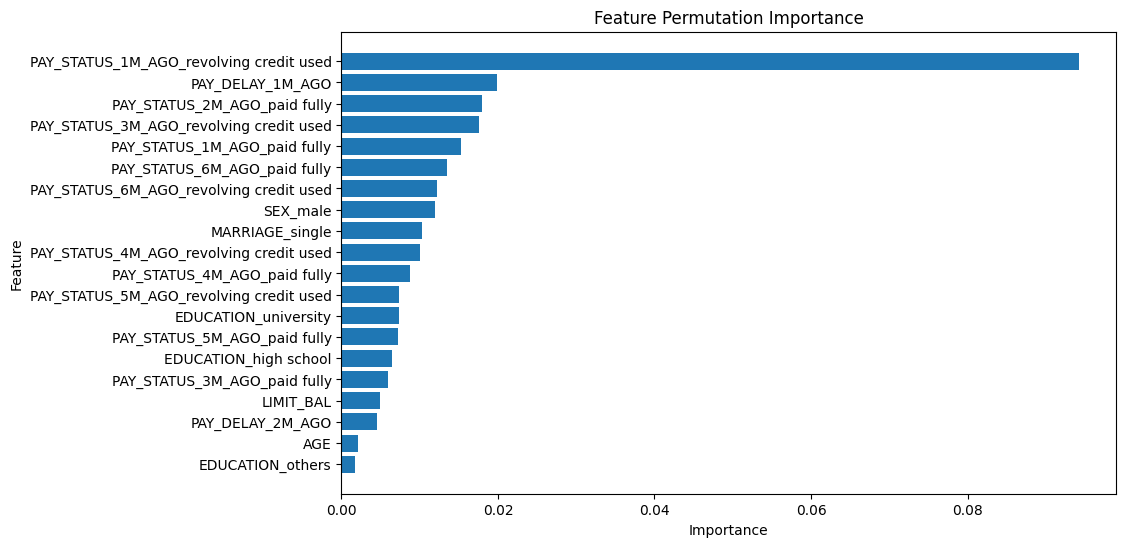

In [ ]:
plot_feat_permut_importance(svm2_feat_permut_import_df)

In [ ]:
svm2_perf, svm2_orig_missing, svm2_missing = measure_performance_decline(
    X_train_scaled, X_test_scaled, y_test, svm2_classifier, svm2_feat_permut_import_df,
    default_cc_imputation_scaled_values_dict, NUM_FEAT, method='simple',
    encoded_vars_family=default_cc_encoded_vars_family
)


--- NEW ITERATION ---
Removing feature:  PAY_STATUS_1M_AGO_revolving credit used
Removing related features:  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1M_AGO_revolving credit used']
Original feat removed so far:  ['PAY_STATUS_1M_AGO']

--- NEW ITERATION ---
Removing feature:  PAY_DELAY_1M_AGO
Original feat removed so far:  ['PAY_STATUS_1M_AGO', 'PAY_DELAY_1M_AGO']

--- NEW ITERATION ---
Removing feature:  PAY_STATUS_2M_AGO_paid fully
Removing related features:  ['PAY_STATUS_2M_AGO_paid fully']
Original feat removed so far:  ['PAY_STATUS_1M_AGO', 'PAY_DELAY_1M_AGO', 'PAY_STATUS_2M_AGO']

--- NEW ITERATION ---
Removing feature:  PAY_STATUS_3M_AGO_revolving credit used
Removing related features:  ['PAY_STATUS_3M_AGO_paid fully', 'PAY_STATUS_3M_AGO_revolving credit used']
Original feat removed so far:  ['PAY_STATUS_1M_AGO', 'PAY_DELAY_1M_AGO', 'PAY_STATUS_2M_AGO', 'PAY_STATUS_3M_AGO']

--- NEW ITERATION ---

--- NEW ITERATION ---
Removing feature:  PAY_STATUS_6M_AGO_paid fully
Removing

In [ ]:
svm2_perf

tp    tn    fp   fn  precision  recall  specificity  accuracy  f1_score  \
0    746  3817   856  581      46.57   56.22        81.68     76.05     50.94   
1   1019  1692  2981  308      25.48   76.79        36.21     45.18     38.26   
2    934  1827  2846  393      24.71   70.38        39.10     46.02     36.58   
3    931  1796  2877  396      24.45   70.16        38.43     45.45     36.26   
4   1079  1184  3489  248      23.62   81.31        25.34     37.72     36.61   
5   1260   453  4220   67      22.99   94.95         9.69     28.55     37.02   
6   1268   372  4301   59      22.77   95.55         7.96     27.33     36.77   
7   1257   433  4240   70      22.87   94.72         9.27     28.17     36.84   
8   1310   168  4505   17      22.53   98.72         3.60     24.63     36.68   
9   1319    79  4594    8      22.31   99.40         1.69     23.30     36.44   
10  1327     3  4670    0      22.13  100.00         0.06     22.17     36.24   
11  1327     1  4672    0      22.12  100.00         0.02     22.13     36.23   
12  1327     1  4672    0      22.12  100.00         0.02     22.13     36.23   
13  1327     1  4672    0      22.12  100.00         0.02     22.13     36.23   
14  1327     1  4672    0      22.12  100.00         0.02     22.13     36.23   
15  1327     1  4672    0      22.12  100.00         0.02     22.13     36.23   
16  1327     1  4672    0      22.12  100.00         0.02     22.13     36.23   
17  1327     1  4672    0      22.12  100.00         0.02     22.13     36.23   
18  1327     1  4672    0      22.12  100.00         0.02     22.13     36.23   
19  1327     1  4672    0      22.12  100.00         0.02     22.13     36.23   
20  1327     1  4672    0      22.12  100.00         0.02     22.13     36.23   

    balanced_accuracy  num_feat_missing  \
0               68.95                 0   
1               56.50                 1   
2               54.74                 2   
3               54.30                 3   
4               53.32                 4   
5               52.32                 5   
6               51.76                 6   
7               52.00                 7   
8               51.16                 8   
9               50.54                 9   
10              50.03                10   
11              50.01                11   
12              50.01                12   
13              50.01                13   
14              50.01                14   
15              50.01                15   
16              50.01                16   
17              50.01                17   
18              50.01                18   
19              50.01                19   
20              50.01                20   

                                              imputed  
0                                                      
1   ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
2   ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
3   ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
4   ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
5   ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
6   ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
7   ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
8   ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
9   ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
10  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
11  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
12  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
13  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
14  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
15  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
16  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
17  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
18  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
19  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
20  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...

In [ ]:
start_time = time.time()
print(datetime.datetime.now())

svm2_perf_mf, svm2_orig_missing_mf, svm2_missing_mf = measure_performance_decline(
    X_train_scaled, X_test_scaled, y_test, svm2_classifier, svm2_feat_permut_import_df,
    imputation_dict=None, num_feat=NUM_FEAT, method='missforest',
    encoded_vars_family=default_cc_encoded_vars_family,
    categorical_vars=default_cc_cat_vars
)

print(datetime.datetime.now())
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time/60} minutes")

2025-01-18 17:03:23.101476

--- NEW ITERATION ---
Removing feature:  PAY_STATUS_1M_AGO_revolving credit used
Removing related features:  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1M_AGO_revolving credit used']
Nr. columns with nan:  2
Numerical columns:  ['PAY_DELAY_1M_AGO', 'PAY_DELAY_2M_AGO', 'PAY_DELAY_3M_AGO', 'PAY_DELAY_4M_AGO', 'PAY_DELAY_5M_AGO', 'PAY_DELAY_6M_AGO', 'LIMIT_BAL', 'PAY_AMT_1M_AGO', 'PAY_AMT_2M_AGO', 'PAY_AMT_3M_AGO', 'PAY_AMT_4M_AGO', 'PAY_AMT_5M_AGO', 'PAY_AMT_6M_AGO', 'AGE', 'BILL_AMT_1M_AGO', 'BILL_AMT_6M_AGO']
Categorical columns:  ['PAY_STATUS_1M_AGO_revolving credit used', 'PAY_STATUS_3M_AGO_revolving credit used', 'PAY_STATUS_4M_AGO_revolving credit used', 'PAY_STATUS_5M_AGO_revolving credit used', 'PAY_STATUS_6M_AGO_revolving credit used', 'PAY_STATUS_3M_AGO_paid fully', 'PAY_STATUS_2M_AGO_paid fully', 'PAY_STATUS_4M_AGO_paid fully', 'PAY_STATUS_5M_AGO_paid fully', 'PAY_STATUS_6M_AGO_paid fully', 'PAY_STATUS_1M_AGO_paid fully', 'EDUCATION_others', 'SEX_

In [ ]:
svm2_perf_mf

tp    tn   fp    fn  precision  recall  specificity  accuracy  f1_score  \
0   746  3817  856   581      46.57   56.22        81.68     76.05     50.94   
1   549  3964  709   778      43.64   41.37        84.83     75.22     42.48   
2   541  3971  702   786      43.52   40.77        84.98     75.20     42.10   
3   539  3987  686   788      44.00   40.62        85.32     75.43     42.24   
4   445  4157  516   882      46.31   33.53        88.96     76.70     38.90   
5   467  4006  667   860      41.18   35.19        85.73     74.55     37.95   
6   468  4032  641   859      42.20   35.27        86.28     75.00     38.42   
7   407  4271  402   920      50.31   30.67        91.40     77.97     38.11   
8   317  4417  256  1010      55.32   23.89        94.52     78.90     33.37   
9   155  4580   93  1172      62.50   11.68        98.01     78.92     19.68   
10   46  4640   33  1281      58.23    3.47        99.29     78.10      6.54   
11   46  4637   36  1281      56.10    3.47        99.23     78.05      6.53   
12  106  4614   59  1221      64.24    7.99        98.74     78.67     14.21   
13  102  4611   62  1225      62.20    7.69        98.67     78.55     13.68   
14   33  4653   20  1294      62.26    2.49        99.57     78.10      4.78   
15   13  4669    4  1314      76.47    0.98        99.91     78.03      1.93   
16   13  4670    3  1314      81.25    0.98        99.94     78.05      1.94   
17   15  4670    3  1312      83.33    1.13        99.94     78.08      2.23   
18   12  4671    2  1315      85.71    0.90        99.96     78.05      1.79   
19   12  4671    2  1315      85.71    0.90        99.96     78.05      1.79   
20   12  4671    2  1315      85.71    0.90        99.96     78.05      1.79   

    balanced_accuracy  num_feat_missing  \
0               68.95                 0   
1               63.10                 1   
2               62.87                 2   
3               62.97                 3   
4               61.25                 4   
5               60.46                 5   
6               60.78                 6   
7               61.03                 7   
8               59.21                 8   
9               54.85                 9   
10              51.38                10   
11              51.35                11   
12              53.36                12   
13              53.18                13   
14              51.03                14   
15              50.45                15   
16              50.46                16   
17              50.53                17   
18              50.43                18   
19              50.43                19   
20              50.43                20   

                                              imputed  
0                                                      
1   ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
2   ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
3   ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
4   ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
5   ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
6   ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
7   ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
8   ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
9   ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
10  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
11  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
12  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
13  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
14  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
15  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
16  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
17  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
18  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
19  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
20  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...

In [ ]:
svm2_perf_temp, svm2_orig_missing_temp, svm2_missing_temp = measure_temporal_performance_decline(
    X_train_scaled, X_test_scaled, y_test, svm2_classifier, svm2_feat_permut_import_df,
    default_cc_timeline_vars_family,
    default_cc_imputation_values_dict, NUM_FEAT, method='simple',
    encoded_vars_family=default_cc_encoded_vars_family, log_info=True
)


--- NEW ITERATION ---
original removed:  []
length original removed:  0
num feat:  20
i:  0
length features importance list:  33
length removed:  0

Removing feature:  PAY_STATUS_1M_AGO_revolving credit used
Removing related temporal feature:  BILL_AMT_1M_AGO
Removing related temporal feature:  PAY_AMT_1M_AGO
Removing related temporal feature:  PAY_DELAY_1M_AGO
Removing related temporal feature:  PAY_STATUS_1M_AGO_paid fully
Removing related features:  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1M_AGO_revolving credit used']
Removing related temporal feature:  PAY_STATUS_1M_AGO_revolving credit used
Removing related features:  []
Columns with zero variance, i.e. imputed:
                                    feature  variance
0                          PAY_DELAY_1M_AGO       0.0
6   PAY_STATUS_1M_AGO_revolving credit used       0.0
8                            PAY_AMT_1M_AGO       0.0
23             PAY_STATUS_1M_AGO_paid fully       0.0
30                          BILL_AMT_1M_AGO    

In [ ]:
svm2_perf_temp

tp    tn    fp   fn  precision  recall  specificity  accuracy  f1_score  \
0   746  3817   856  581      46.57   56.22        81.68     76.05     50.94   
1  1327     0  4673    0      22.12  100.00         0.00     22.12     36.22   
2  1327     0  4673    0      22.12  100.00         0.00     22.12     36.22   
3  1327     0  4673    0      22.12  100.00         0.00     22.12     36.22   
4  1327     0  4673    0      22.12  100.00         0.00     22.12     36.22   
5  1327     0  4673    0      22.12  100.00         0.00     22.12     36.22   
6  1327     0  4673    0      22.12  100.00         0.00     22.12     36.22   
7  1327     0  4673    0      22.12  100.00         0.00     22.12     36.22   
8  1327     0  4673    0      22.12  100.00         0.00     22.12     36.22   

   balanced_accuracy  num_feat_missing  \
0              68.95                 0   
1              50.00                 4   
2              50.00                 7   
3              50.00                10   
4              50.00                14   
5              50.00                15   
6              50.00                16   
7              50.00                19   
8              50.00                22   

                                             imputed  
0                                                     
1  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
2  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
3  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
4  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
5  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
6  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
7  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
8  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...

In [ ]:
start_time = time.time()
print(datetime.datetime.now())

svm2_perf_temp_mf, svm2_orig_missing_temp_mf, svm2_missing_temp_mf = measure_temporal_performance_decline(
    X_train_scaled, X_test_scaled, y_test, svm2_classifier, svm2_feat_permut_import_df,
    default_cc_timeline_vars_family, num_feat=NUM_FEAT, method='missforest',
    encoded_vars_family=default_cc_encoded_vars_family,
    categorical_vars=default_cc_cat_vars, log_info=True
)

print(datetime.datetime.now())
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time/60} minutes")

2025-01-18 17:10:17.834625

--- NEW ITERATION ---
original removed:  []
length original removed:  0
num feat:  20
i:  0
length features importance list:  33
length removed:  0

Removing feature:  PAY_STATUS_1M_AGO_revolving credit used
Removing related temporal feature:  BILL_AMT_1M_AGO
Removing related temporal feature:  PAY_AMT_1M_AGO
Removing related temporal feature:  PAY_DELAY_1M_AGO
Removing related temporal feature:  PAY_STATUS_1M_AGO_paid fully
Removing related features:  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1M_AGO_revolving credit used']
Removing related temporal feature:  PAY_STATUS_1M_AGO_revolving credit used
Removing related features:  []
Nr. columns with nan:  5
Numerical columns:  ['PAY_DELAY_1M_AGO', 'PAY_DELAY_2M_AGO', 'PAY_DELAY_3M_AGO', 'PAY_DELAY_4M_AGO', 'PAY_DELAY_5M_AGO', 'PAY_DELAY_6M_AGO', 'LIMIT_BAL', 'PAY_AMT_1M_AGO', 'PAY_AMT_2M_AGO', 'PAY_AMT_3M_AGO', 'PAY_AMT_4M_AGO', 'PAY_AMT_5M_AGO', 'PAY_AMT_6M_AGO', 'AGE', 'BILL_AMT_1M_AGO', 'BILL_AMT_6M_AGO']


In [ ]:
svm2_perf_temp_mf

tp    tn   fp    fn  precision  recall  specificity  accuracy  f1_score  \
0  746  3817  856   581      46.57   56.22        81.68     76.05     50.94   
1  511  4042  631   816      44.75   38.51        86.50     75.88     41.39   
2  470  4104  569   857      45.24   35.42        87.82     76.23     39.73   
3  371  4260  413   956      47.32   27.96        91.16     77.18     35.15   
4  396  4060  613   931      39.25   29.84        86.88     74.27     33.90   
5  396  4114  559   931      41.47   29.84        88.04     75.17     34.71   
6  347  4336  337   980      50.73   26.15        92.79     78.05     34.51   
7  102  4553  120  1225      45.95    7.69        97.43     77.58     13.17   
8    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   

   balanced_accuracy  num_feat_missing  \
0              68.95                 0   
1              62.50                 4   
2              61.62                 7   
3              59.56                10   
4              58.36                14   
5              58.94                15   
6              59.47                16   
7              52.56                19   
8              50.00                22   

                                             imputed  
0                                                     
1  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
2  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
3  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
4  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
5  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
6  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
7  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
8  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...

##**Logistic Regression**

In [ ]:
FINE_TUNE = False

if FINE_TUNE:
  lr2_param_grid = {
      'C': [0.1, 1, 2, 5, 10, 20],            # Regularization strength
      'penalty': ['l2', 'l1', 'elasticnet'],  # Regularization type
      'solver': ['liblinear', 'saga']         # Algorithm to use in the optimization problem
  }
else:
  lr2_param_grid = {
      'C': [2.0],
      'penalty': ['l2'],
      'solver': ['saga']
  }

lr2_classifier = LogisticRegression(class_weight='balanced', random_state=RANDOM_STATE)
lr2_grid_search, lr2_best_model, lr2_best_params = hyperparameter_tuning(
    lr2_classifier, lr2_param_grid, 3, 3, 'balanced_accuracy', lr_X_train, y_train
)

Starting hyperparameter tuning at: 2025-01-18 17:12:46.492327

Nested Cross-validation Results:
Individual scores: [0.70686988 0.70768924 0.70425724]
Average nested CV score: 0.706 (+/- 0.003)

Fitting final model on entire dataset...
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best parameters: {'C': 2.0, 'penalty': 'l2', 'solver': 'saga'}

Best Model Performance:
Best CV score: 0.706
2025-01-18 17:12:51.584104

Execution time: 0.08 minutes


```
Starting hyperparameter tuning at: 2025-01-17 13:22:38.700260

Nested Cross-validation Results:
Individual scores: [0.70651774 0.70704718 0.70381741]
Average nested CV score: 0.706 (+/- 0.003)

Fitting final model on entire dataset...
Fitting 3 folds for each of 36 candidates, totalling 108 fits
Best parameters: {'C': 2, 'penalty': 'l2', 'solver': 'saga'}

Best Model Performance:
Best CV score: 0.706
2025-01-17 13:23:00.270114

Execution time: 0.36 minutes
```

In [ ]:
lr2_classifier, train_pred, test_pred = apply_model(lr2_best_model, lr_X_train, y_train, lr_X_test, y_test)
lr2_feat_permut_import_df = analyze_feat_permut_import(lr2_classifier, lr_X_train, y_train, scoring_metric="balanced_accuracy")
lr2_feat_permut_import_df[lr2_feat_permut_import_df['Importance']!=0]

Feature  Importance       Std
0                          PAY_DELAY_1M_AGO    0.077434  0.002468
7                                 LIMIT_BAL    0.012833  0.002226
2                          PAY_DELAY_3M_AGO    0.007913  0.001685
23             PAY_STATUS_1M_AGO_paid fully    0.005131  0.001013
6   PAY_STATUS_1M_AGO_revolving credit used    0.004194  0.000845
17  PAY_STATUS_6M_AGO_revolving credit used    0.003793  0.001100
4                          PAY_DELAY_5M_AGO    0.003292  0.000586
19             PAY_STATUS_2M_AGO_paid fully    0.003250  0.000593
30                          BILL_AMT_1M_AGO    0.002442  0.000289
3                          PAY_DELAY_4M_AGO    0.002375  0.000397
25                                 SEX_male    0.002166  0.000279
16  PAY_STATUS_5M_AGO_revolving credit used    0.001362  0.000506
20             PAY_STATUS_4M_AGO_paid fully    0.001212  0.000344
24                         EDUCATION_others    0.001107  0.000334
27                          MARRIAGE_single    0.000768  0.000923
26                     EDUCATION_university    0.000751  0.000212
8                            PAY_AMT_1M_AGO    0.000633  0.000265
5                          PAY_DELAY_6M_AGO    0.000470  0.000089
10  PAY_STATUS_3M_AGO_revolving credit used    0.000457  0.000797
14  PAY_STATUS_4M_AGO_revolving credit used    0.000450  0.000604
32                          MARRIAGE_others    0.000387  0.000176
29                                      AGE    0.000274  0.000458
15                           PAY_AMT_6M_AGO    0.000250  0.000274
22             PAY_STATUS_6M_AGO_paid fully    0.000138  0.000405
13                           PAY_AMT_5M_AGO    0.000114  0.000318
28                    EDUCATION_high school    0.000100  0.000138
11                           PAY_AMT_3M_AGO    0.000043  0.000418
9                            PAY_AMT_2M_AGO    0.000031  0.000127
12                           PAY_AMT_4M_AGO    0.000006  0.000335
1                          PAY_DELAY_2M_AGO   -0.000135  0.000326
18             PAY_STATUS_3M_AGO_paid fully   -0.000149  0.000120
21             PAY_STATUS_5M_AGO_paid fully   -0.000253  0.000127
31                          BILL_AMT_6M_AGO   -0.000275  0.000291

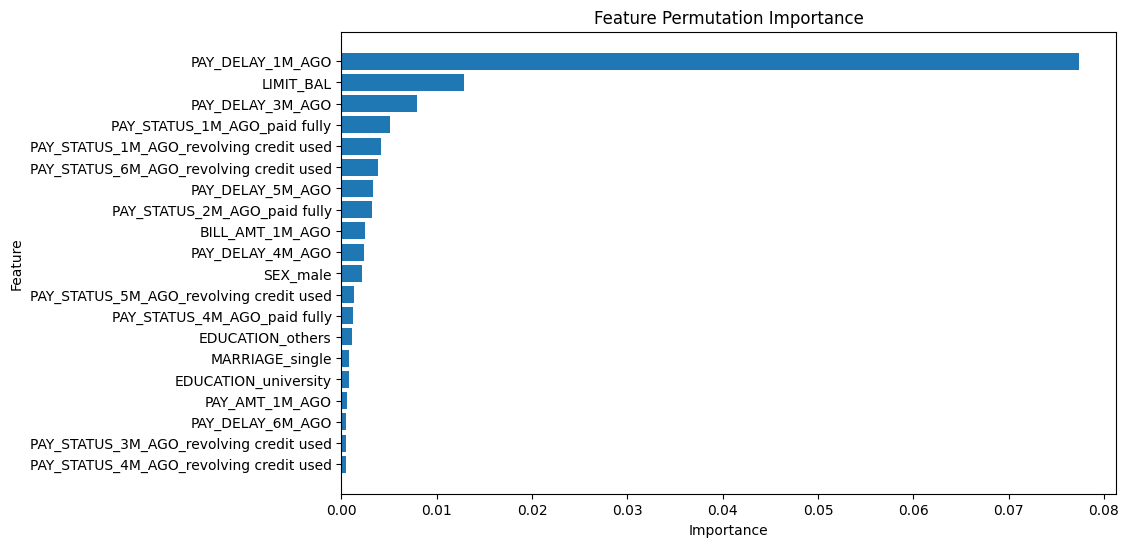

In [ ]:
plot_feat_permut_importance(lr2_feat_permut_import_df)

In [ ]:
lr2_perf, lr2_orig_missing, lr2_missing = measure_performance_decline(
    lr_X_train, lr_X_test, y_test, lr2_classifier, lr2_feat_permut_import_df,
    default_cc_imputation_scaled_values_dict, NUM_FEAT, method='simple',
    encoded_vars_family=default_cc_encoded_vars_family
)


--- NEW ITERATION ---
Removing feature:  PAY_DELAY_1M_AGO
Original feat removed so far:  ['PAY_DELAY_1M_AGO']

--- NEW ITERATION ---
Removing feature:  LIMIT_BAL
Original feat removed so far:  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL']

--- NEW ITERATION ---
Removing feature:  PAY_DELAY_3M_AGO
Original feat removed so far:  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_3M_AGO']

--- NEW ITERATION ---
Removing feature:  PAY_STATUS_1M_AGO_paid fully
Removing related features:  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1M_AGO_revolving credit used']
Original feat removed so far:  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_3M_AGO', 'PAY_STATUS_1M_AGO']

--- NEW ITERATION ---

--- NEW ITERATION ---
Removing feature:  PAY_STATUS_6M_AGO_revolving credit used
Removing related features:  ['PAY_STATUS_6M_AGO_paid fully', 'PAY_STATUS_6M_AGO_revolving credit used']
Original feat removed so far:  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_3M_AGO', 'PAY_STATUS_1M_AGO', 'PAY_STATUS_6M_AGO']

--- NEW IT

In [ ]:
lr2_perf

tp    tn   fp    fn  precision  recall  specificity  accuracy  f1_score  \
0   750  3862  811   577      48.05   56.52        82.64     76.87     51.94   
1   485  4169  504   842      49.04   36.55        89.21     77.57     41.88   
2   442  4214  459   885      49.06   33.31        90.18     77.60     39.68   
3   334  4351  322   993      50.91   25.17        93.11     78.08     33.69   
4   364  4195  478   963      43.23   27.43        89.77     75.98     33.56   
5   184  4427  246  1143      42.79   13.87        94.74     76.85     20.94   
6    63  4507  166  1264      27.51    4.75        96.45     76.17      8.10   
7    63  4507  166  1264      27.51    4.75        96.45     76.17      8.10   
8    16  4660   13  1311      55.17    1.21        99.72     77.93      2.36   
9     0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   
10    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   
11    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   
12    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   
13    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   
14    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   
15    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   
16    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   
17    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   
18    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   
19    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   
20    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   

    balanced_accuracy  num_feat_missing  \
0               69.58                 0   
1               62.88                 1   
2               61.74                 2   
3               59.14                 3   
4               58.60                 4   
5               54.30                 5   
6               50.60                 6   
7               50.60                 7   
8               50.46                 8   
9               50.00                 9   
10              50.00                10   
11              50.00                11   
12              50.00                12   
13              50.00                13   
14              50.00                14   
15              50.00                15   
16              50.00                16   
17              50.00                17   
18              50.00                18   
19              50.00                19   
20              50.00                20   

                                              imputed  
0                                                      
1                        ['PAY_DELAY_1M_AGO'] imputed  
2           ['PAY_DELAY_1M_AGO', 'LIMIT_BAL'] imputed  
3   ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_3...  
4   ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_3...  
5   ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_3...  
6   ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_3...  
7   ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_3...  
8   ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_3...  
9   ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_3...  
10  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_3...  
11  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_3...  
12  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_3...  
13  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_3...  
14  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_3...  
15  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_3...  
16  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_3...  
17  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_3...  
18  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_3...  
19  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_3...  
20  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_3...

In [ ]:
start_time = time.time()
print(datetime.datetime.now())

lr2_perf_mf, lr2_orig_missing_mf, lr2_missing_mf = measure_performance_decline(
    lr_X_train, lr_X_test, y_test, lr2_classifier, lr2_feat_permut_import_df,
    imputation_dict=None, num_feat=NUM_FEAT, method='missforest',
    encoded_vars_family=default_cc_encoded_vars_family,
    categorical_vars=lr_default_cc_cat_vars
)


print(datetime.datetime.now())
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time/60} minutes")

2025-01-18 17:12:54.109104

--- NEW ITERATION ---
Removing feature:  PAY_DELAY_1M_AGO
Nr. columns with nan:  1
Numerical columns:  ['PAY_DELAY_1M_AGO', 'PAY_DELAY_2M_AGO', 'PAY_DELAY_3M_AGO', 'PAY_DELAY_4M_AGO', 'PAY_DELAY_5M_AGO', 'PAY_DELAY_6M_AGO', 'LIMIT_BAL', 'PAY_AMT_1M_AGO', 'PAY_AMT_2M_AGO', 'PAY_AMT_3M_AGO', 'PAY_AMT_4M_AGO', 'PAY_AMT_5M_AGO', 'PAY_AMT_6M_AGO', 'AGE', 'BILL_AMT_1M_AGO', 'BILL_AMT_6M_AGO']
Categorical columns:  ['PAY_STATUS_1M_AGO_revolving credit used', 'PAY_STATUS_3M_AGO_revolving credit used', 'PAY_STATUS_4M_AGO_revolving credit used', 'PAY_STATUS_5M_AGO_revolving credit used', 'PAY_STATUS_6M_AGO_revolving credit used', 'PAY_STATUS_3M_AGO_paid fully', 'PAY_STATUS_2M_AGO_paid fully', 'PAY_STATUS_4M_AGO_paid fully', 'PAY_STATUS_5M_AGO_paid fully', 'PAY_STATUS_6M_AGO_paid fully', 'PAY_STATUS_1M_AGO_paid fully', 'EDUCATION_others', 'SEX_male', 'EDUCATION_university', 'MARRIAGE_single', 'EDUCATION_high school', 'MARRIAGE_others']
Column imputed:  PAY_DELAY_1M_AGO

In [ ]:
lr2_perf_mf

tp    tn   fp   fn  precision  recall  specificity  accuracy  f1_score  \
0   750  3862  811  577      48.05   56.52        82.64     76.87     51.94   
1   699  3804  869  628      44.58   52.68        81.40     75.05     48.29   
2   676  3884  789  651      46.14   50.94        83.12     76.00     48.42   
3   663  3892  781  664      45.91   49.96        83.29     75.92     47.85   
4   633  3927  746  694      45.90   47.70        84.04     76.00     46.78   
5   628  3988  685  699      47.83   47.32        85.34     76.93     47.58   
6   610  4007  666  717      47.81   45.97        85.75     76.95     46.87   
7   608  4014  659  719      47.99   45.82        85.90     77.03     46.88   
8   583  4081  592  744      49.62   43.93        87.33     77.73     46.60   
9   547  4112  561  780      49.37   41.22        87.99     77.65     44.93   
10  514  4196  477  813      51.87   38.73        89.79     78.50     44.35   
11  472  4292  381  855      55.33   35.57        91.85     79.40     43.30   
12  456  4311  362  871      55.75   34.36        92.25     79.45     42.52   
13  460  4304  369  867      55.49   34.66        92.10     79.40     42.67   
14  448  4322  351  879      56.07   33.76        92.49     79.50     42.14   
15  465  4294  379  862      55.09   35.04        91.89     79.32     42.84   
16  464  4301  372  863      55.50   34.97        92.04     79.42     42.90   
17  466  4300  373  861      55.54   35.12        92.02     79.43     43.03   
18  466  4299  374  861      55.48   35.12        92.00     79.42     43.01   
19  468  4299  374  859      55.58   35.27        92.00     79.45     43.15   
20  469  4296  377  858      55.44   35.34        91.93     79.42     43.17   

    balanced_accuracy  num_feat_missing  \
0               69.58                 0   
1               67.04                 1   
2               67.03                 2   
3               66.62                 3   
4               65.87                 4   
5               66.33                 5   
6               65.86                 6   
7               65.86                 7   
8               65.63                 8   
9               64.61                 9   
10              64.26                10   
11              63.71                11   
12              63.31                12   
13              63.38                13   
14              63.12                14   
15              63.47                15   
16              63.50                16   
17              63.57                17   
18              63.56                18   
19              63.63                19   
20              63.64                20   

                                              imputed  
0                                                      
1                        ['PAY_DELAY_1M_AGO'] imputed  
2           ['PAY_DELAY_1M_AGO', 'LIMIT_BAL'] imputed  
3   ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_3...  
4   ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_3...  
5   ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_3...  
6   ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_3...  
7   ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_3...  
8   ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_3...  
9   ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_3...  
10  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_3...  
11  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_3...  
12  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_3...  
13  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_3...  
14  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_3...  
15  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_3...  
16  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_3...  
17  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_3...  
18  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_3...  
19  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_3...  
20  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_3...

In [ ]:
lr2_perf_temp, lr2_orig_missing_temp, lr2_missing_temp = measure_temporal_performance_decline(
    lr_X_train, lr_X_test, y_test, lr2_classifier, lr2_feat_permut_import_df,
    default_cc_timeline_vars_family,
    default_cc_imputation_values_dict, NUM_FEAT, method='simple',
    encoded_vars_family=default_cc_encoded_vars_family, log_info=True
)


--- NEW ITERATION ---
original removed:  []
length original removed:  0
num feat:  20
i:  0
length features importance list:  33
length removed:  0

Removing feature:  PAY_DELAY_1M_AGO
Removing related temporal feature:  BILL_AMT_1M_AGO
Removing related temporal feature:  PAY_AMT_1M_AGO
Removing related temporal feature:  PAY_DELAY_1M_AGO
Removing related temporal feature:  PAY_STATUS_1M_AGO_paid fully
Removing related features:  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1M_AGO_revolving credit used']
Removing related temporal feature:  PAY_STATUS_1M_AGO_revolving credit used
Removing related features:  []
Columns with zero variance, i.e. imputed:
                                    feature  variance
0                          PAY_DELAY_1M_AGO       0.0
6   PAY_STATUS_1M_AGO_revolving credit used       0.0
8                            PAY_AMT_1M_AGO       0.0
23             PAY_STATUS_1M_AGO_paid fully       0.0
30                          BILL_AMT_1M_AGO       0.0
Original feat re

In [ ]:
lr2_perf_temp

tp    tn    fp    fn  precision  recall  specificity  accuracy  f1_score  \
0   750  3862   811   577      48.05   56.52        82.64     76.87     51.94   
1  1327     0  4673     0      22.12  100.00         0.00     22.12     36.22   
2     0  4673     0  1327       0.00    0.00       100.00     77.88      0.00   
3     0  4673     0  1327       0.00    0.00       100.00     77.88      0.00   
4     0  4673     0  1327       0.00    0.00       100.00     77.88      0.00   
5     0  4673     0  1327       0.00    0.00       100.00     77.88      0.00   
6     0  4673     0  1327       0.00    0.00       100.00     77.88      0.00   
7     0  4673     0  1327       0.00    0.00       100.00     77.88      0.00   

   balanced_accuracy  num_feat_missing  \
0              69.58                 0   
1              50.00                 4   
2              50.00                 5   
3              50.00                 8   
4              50.00                12   
5              50.00                15   
6              50.00                18   
7              50.00                21   

                                             imputed  
0                                                     
1  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
2  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
3  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
4  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
5  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
6  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
7  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...

In [ ]:
start_time = time.time()
print(datetime.datetime.now())

lr2_perf_temp_mf, lr2_orig_missing_temp_mf, lr2_missing_temp_mf = measure_temporal_performance_decline(
    lr_X_train, lr_X_test, y_test, lr2_classifier, lr2_feat_permut_import_df,
    default_cc_timeline_vars_family, num_feat=NUM_FEAT, method='missforest',
    encoded_vars_family=default_cc_encoded_vars_family,
    categorical_vars=lr_default_cc_cat_vars, log_info=True
)

print(datetime.datetime.now())
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time/60} minutes")

2025-01-18 17:17:37.058522

--- NEW ITERATION ---
original removed:  []
length original removed:  0
num feat:  20
i:  0
length features importance list:  33
length removed:  0

Removing feature:  PAY_DELAY_1M_AGO
Removing related temporal feature:  BILL_AMT_1M_AGO
Removing related temporal feature:  PAY_AMT_1M_AGO
Removing related temporal feature:  PAY_DELAY_1M_AGO
Removing related temporal feature:  PAY_STATUS_1M_AGO_paid fully
Removing related features:  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1M_AGO_revolving credit used']
Removing related temporal feature:  PAY_STATUS_1M_AGO_revolving credit used
Removing related features:  []
Nr. columns with nan:  5
Numerical columns:  ['PAY_DELAY_1M_AGO', 'PAY_DELAY_2M_AGO', 'PAY_DELAY_3M_AGO', 'PAY_DELAY_4M_AGO', 'PAY_DELAY_5M_AGO', 'PAY_DELAY_6M_AGO', 'LIMIT_BAL', 'PAY_AMT_1M_AGO', 'PAY_AMT_2M_AGO', 'PAY_AMT_3M_AGO', 'PAY_AMT_4M_AGO', 'PAY_AMT_5M_AGO', 'PAY_AMT_6M_AGO', 'AGE', 'BILL_AMT_1M_AGO', 'BILL_AMT_6M_AGO']
Categorical columns:  [

In [ ]:
lr2_perf_temp_mf

tp    tn   fp    fn  precision  recall  specificity  accuracy  f1_score  \
0  750  3862  811   577      48.05   56.52        82.64     76.87     51.94   
1  619  3925  748   708      45.28   46.65        83.99     75.73     45.95   
2  639  3891  782   688      44.97   48.15        83.27     75.50     46.51   
3  576  4105  568   751      50.35   43.41        87.85     78.02     46.62   
4  606  4007  666   721      47.64   45.67        85.75     76.88     46.63   
5  554  4147  526   773      51.30   41.75        88.74     78.35     46.03   
6  170  4544  129  1157      56.86   12.81        97.24     78.57     20.91   
7    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   

   balanced_accuracy  num_feat_missing  \
0              69.58                 0   
1              65.32                 4   
2              65.71                 5   
3              65.63                 8   
4              65.71                12   
5              65.25                15   
6              55.03                18   
7              50.00                21   

                                             imputed  
0                                                     
1  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
2  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
3  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
4  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
5  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
6  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
7  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...

# **Results comparison - Standard Scenario**



## **F1-score**

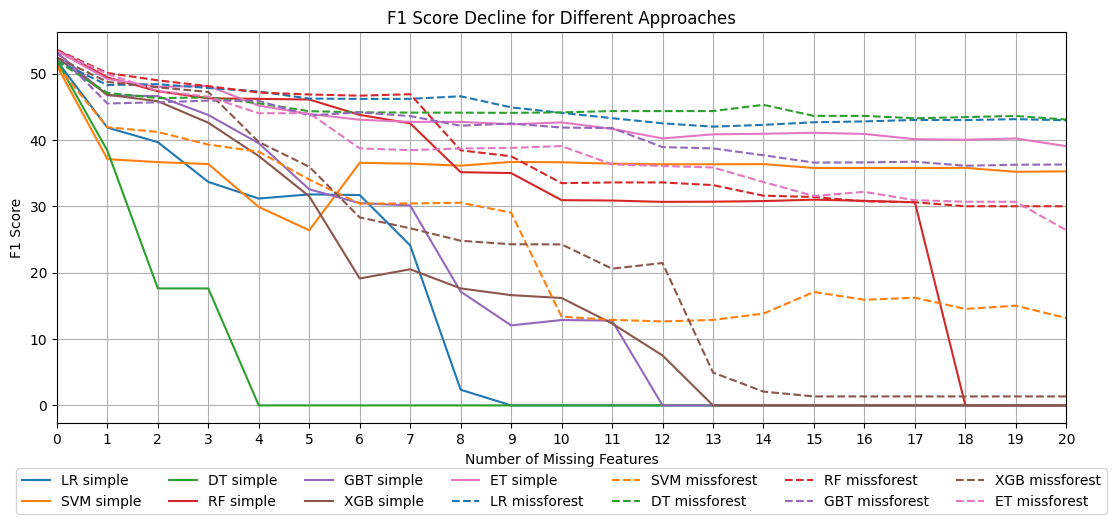

In [ ]:
# # Line plot for the f1 score of the different models
plt.figure(figsize=(12, 6))
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2']

plt.plot(lr_perf['num_feat_missing'], lr_perf['f1_score'], label='LR simple', color=colors[0])
plt.plot(svm_perf['num_feat_missing'], svm_perf['f1_score'], label='SVM simple', color=colors[1])
plt.plot(dt_perf['num_feat_missing'], dt_perf['f1_score'], label='DT simple', color=colors[2])
plt.plot(rf_perf['num_feat_missing'], rf_perf['f1_score'], label='RF simple', color=colors[3])
plt.plot(gbt_perf['num_feat_missing'], gbt_perf['f1_score'], label='GBT simple', color=colors[4])
plt.plot(xgb_perf['num_feat_missing'], xgb_perf['f1_score'], label='XGB simple', color=colors[5])
plt.plot(et_perf['num_feat_missing'], et_perf['f1_score'], label='ET simple', color=colors[6])

plt.plot(lr_perf_mf['num_feat_missing'], lr_perf_mf['f1_score'], label='LR missforest', color=colors[0], linestyle='--')
plt.plot(svm_perf_mf['num_feat_missing'], svm_perf_mf['f1_score'], label='SVM missforest', color=colors[1], linestyle='--')
plt.plot(dt_perf_mf['num_feat_missing'], dt_perf_mf['f1_score'], label='DT missforest', color=colors[2], linestyle='--')
plt.plot(rf_perf_mf['num_feat_missing'], rf_perf_mf['f1_score'], label='RF missforest', color=colors[3], linestyle='--')
plt.plot(gbt_perf_mf['num_feat_missing'], gbt_perf_mf['f1_score'], label='GBT missforest', color=colors[4], linestyle='--')
plt.plot(xgb_perf_mf['num_feat_missing'], xgb_perf_mf['f1_score'], label='XGB missforest', color=colors[5], linestyle='--')
plt.plot(et_perf_mf['num_feat_missing'], et_perf_mf['f1_score'], label='ET missforest', color=colors[6], linestyle='--')

plt.xlabel('Number of Missing Features')
plt.ylabel('F1 Score')
plt.title('F1 Score Decline for Different Approaches')
plt.xticks(et_perf.index.astype(int))
plt.xticks(range(0, NUM_FEAT+1))
plt.xlim(0, NUM_FEAT)
plt.legend(loc='lower center',  bbox_to_anchor=(0.5, -0.25), ncol=7)
plt.grid(True)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

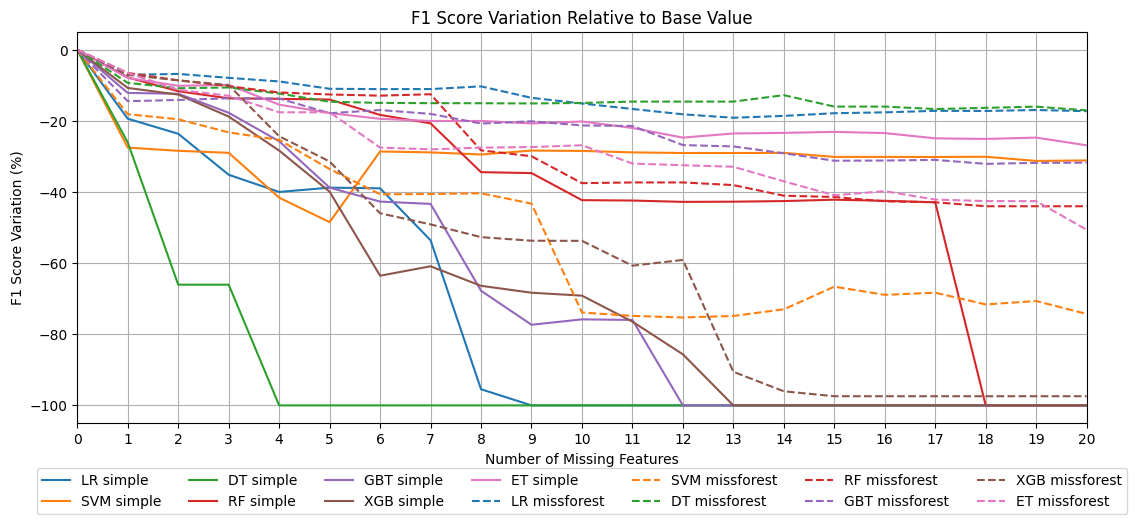

In [ ]:
# Line plot for the f1 score variation relative to the first value
plt.figure(figsize=(12, 6))
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2',
          '#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2']
linestyles = ['-', '-', '-', '-', '-', '-', '-', '--', '--', '--', '--', '--', '--', '--']

# Calculate and plot the F1-score variation for each model
for perf_df, label, color, linestyle in zip(
    [lr_perf, svm_perf, dt_perf, rf_perf, gbt_perf, xgb_perf, et_perf,
     lr_perf_mf, svm_perf_mf, dt_perf_mf, rf_perf_mf, gbt_perf_mf, xgb_perf_mf, et_perf_mf],
    ['LR simple', 'SVM simple', 'DT simple', 'RF simple', 'GBT simple', 'XGB simple', 'ET simple',
     'LR missforest', 'SVM missforest', 'DT missforest', 'RF missforest', 'GBT missforest', 'XGB missforest', 'ET missforest'],
    colors,
    linestyles
):
    # Calculate the variation relative to the base F1-score
    f1_variation = (perf_df['f1_score'] - perf_df['f1_score'].iloc[0]) / perf_df['f1_score'].iloc[0] * 100
    plt.plot(perf_df['num_feat_missing'], f1_variation, label=label, color=color, linestyle=linestyle)

plt.xlabel('Number of Missing Features')
plt.ylabel('F1 Score Variation (%)')
plt.title('F1 Score Variation Relative to Base Value')
plt.xticks(range(0, 21))
plt.legend(loc='lower center',  bbox_to_anchor=(0.5, -0.25), ncol=7)
plt.grid(True)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

##**Balanced accuracy**

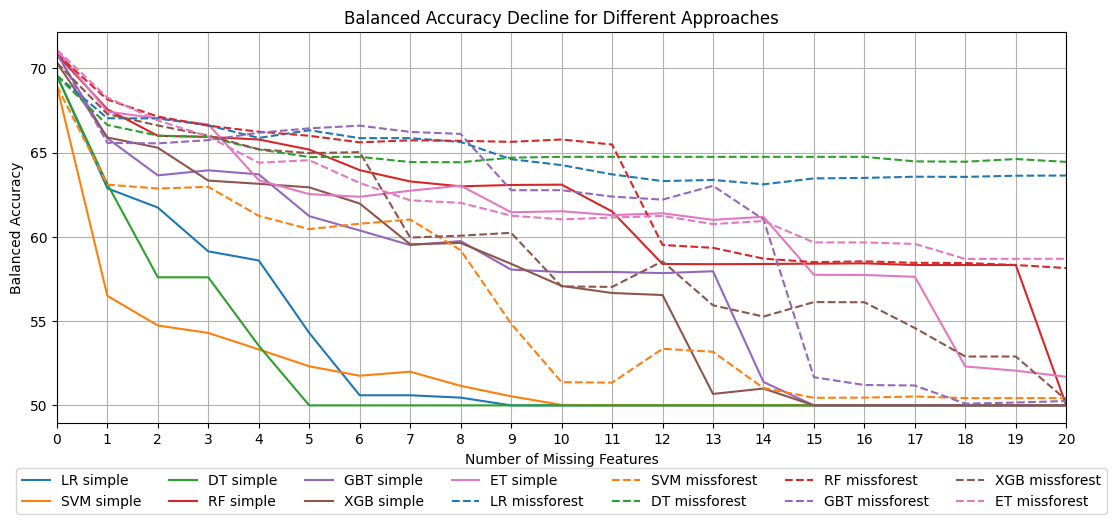

In [ ]:
# Line plot for the balanced accuracy of the different models
plt.figure(figsize=(12, 6))
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2']

plt.plot(lr2_perf['num_feat_missing'], lr2_perf['balanced_accuracy'], label='LR simple', color=colors[0])
plt.plot(svm2_perf['num_feat_missing'], svm2_perf['balanced_accuracy'], label='SVM simple', color=colors[1])
plt.plot(dt2_perf['num_feat_missing'], dt2_perf['balanced_accuracy'], label='DT simple', color=colors[2])
plt.plot(rf2_perf['num_feat_missing'], rf2_perf['balanced_accuracy'], label='RF simple', color=colors[3])
plt.plot(gbt2_perf['num_feat_missing'], gbt2_perf['balanced_accuracy'], label='GBT simple', color=colors[4])
plt.plot(xgb2_perf['num_feat_missing'], xgb2_perf['balanced_accuracy'], label='XGB simple', color=colors[5])
plt.plot(et2_perf['num_feat_missing'], et2_perf['balanced_accuracy'], label='ET simple', color=colors[6])

plt.plot(lr2_perf_mf['num_feat_missing'], lr2_perf_mf['balanced_accuracy'], label='LR missforest', color=colors[0], linestyle='--')
plt.plot(svm2_perf_mf['num_feat_missing'], svm2_perf_mf['balanced_accuracy'], label='SVM missforest', color=colors[1], linestyle='--')
plt.plot(dt2_perf_mf['num_feat_missing'], dt2_perf_mf['balanced_accuracy'], label='DT missforest', color=colors[2], linestyle='--')
plt.plot(rf2_perf_mf['num_feat_missing'], rf2_perf_mf['balanced_accuracy'], label='RF missforest', color=colors[3], linestyle='--')
plt.plot(gbt2_perf_mf['num_feat_missing'], gbt2_perf_mf['balanced_accuracy'], label='GBT missforest', color=colors[4], linestyle='--')
plt.plot(xgb2_perf_mf['num_feat_missing'], xgb2_perf_mf['balanced_accuracy'], label='XGB missforest', color=colors[5], linestyle='--')
plt.plot(et2_perf_mf['num_feat_missing'], et2_perf_mf['balanced_accuracy'], label='ET missforest', color=colors[6], linestyle='--')

plt.xlabel('Number of Missing Features')
plt.ylabel('Balanced Accuracy')
plt.title('Balanced Accuracy Decline for Different Approaches')
plt.xticks(range(0, NUM_FEAT+1))
plt.xlim(0, NUM_FEAT)
plt.legend(loc='lower center',  bbox_to_anchor=(0.5, -0.25), ncol=7)
plt.grid(True)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

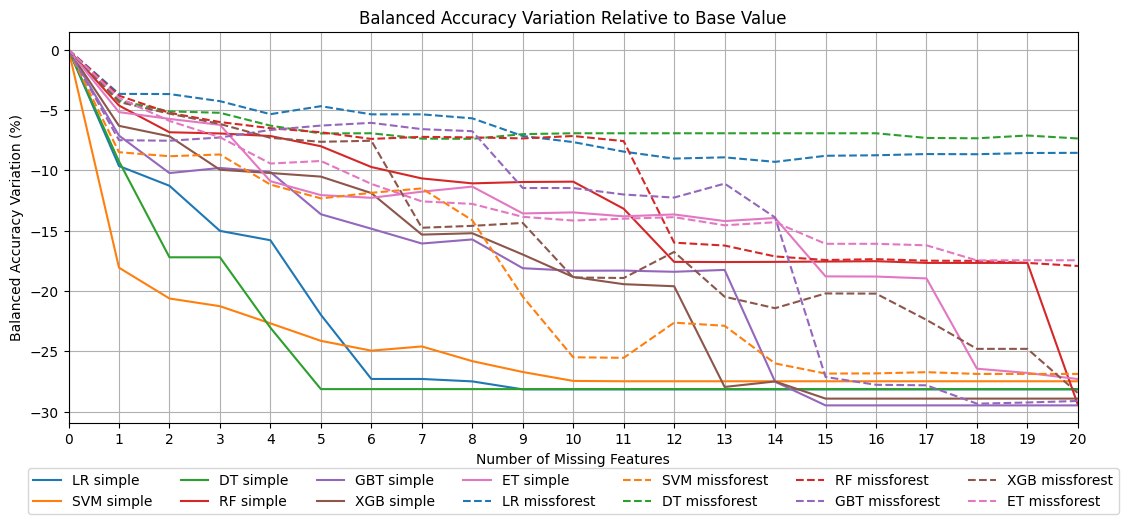

In [ ]:
# Line plot for the balanced accuracy variation relative to the first value
plt.figure(figsize=(12, 6))
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2',
          '#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2']
linestyles = ['-', '-', '-', '-', '-', '-', '-', '--', '--', '--', '--', '--', '--', '--']

# Calculate and plot the Balanced Accuracy variation for each model
for perf_df, label, color, linestyle in zip(
    [lr2_perf, svm2_perf, dt2_perf, rf2_perf, gbt2_perf, xgb2_perf, et2_perf,
     lr2_perf_mf, svm2_perf_mf, dt2_perf_mf, rf2_perf_mf, gbt2_perf_mf, xgb2_perf_mf, et2_perf_mf],
    ['LR simple', 'SVM simple', 'DT simple', 'RF simple', 'GBT simple', 'XGB simple', 'ET simple',
     'LR missforest', 'SVM missforest', 'DT missforest', 'RF missforest', 'GBT missforest', 'XGB missforest', 'ET missforest'],
    colors,
    linestyles
):
    # Calculate the variation relative to the base Balanced Accuracy
    balanced_accy_variation = (perf_df['balanced_accuracy'] - perf_df['balanced_accuracy'].iloc[0]) / perf_df['balanced_accuracy'].iloc[0] * 100
    plt.plot(perf_df['num_feat_missing'], balanced_accy_variation, label=label, color=color, linestyle=linestyle)

plt.xlabel('Number of Missing Features')
plt.ylabel('Balanced Accuracy Variation (%)')
plt.title('Balanced Accuracy Variation Relative to Base Value')
plt.xticks(range(0, 21))
plt.legend(loc='lower center',  bbox_to_anchor=(0.5, -0.25), ncol=7)
plt.grid(True)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In this dataset there are few highly correlated variables (even considerind the ohe). So the ensemble models like Random Forests and Extra Trees do not benefit from the power of backup variables because they actually do not exist.

From the analysis of F1 and Balanced Accuracy, Decision Trees and XGBoost seem to be the less resilient to features missing.

# **Results comparison - Temporal Scenario**

## **F1-score**

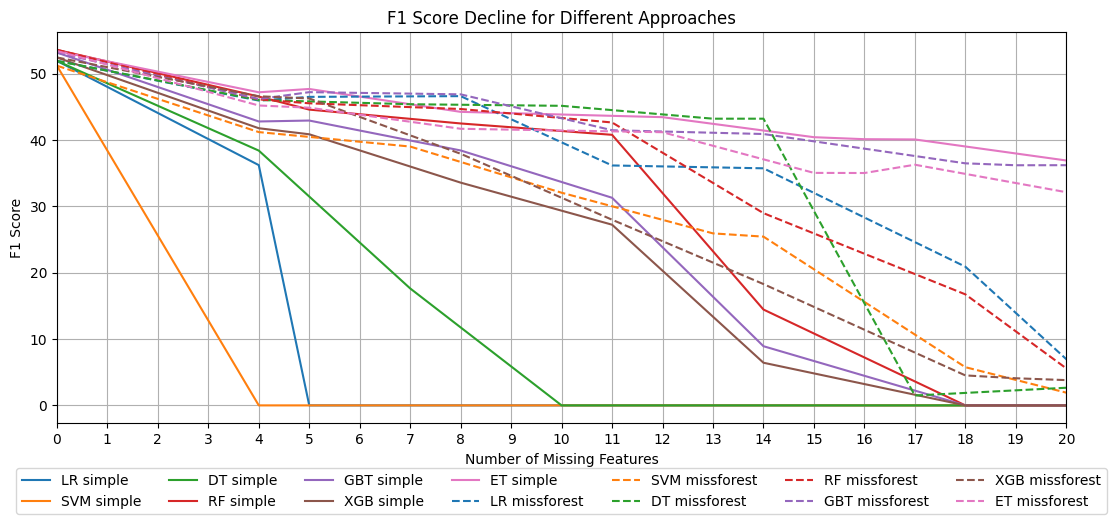

In [ ]:
# Line plot for the f1 score of the different models
plt.figure(figsize=(12, 6))
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2']

plt.plot(lr_perf_temp['num_feat_missing'], lr_perf_temp['f1_score'], label='LR simple', color=colors[0])
plt.plot(svm_perf_temp['num_feat_missing'], svm_perf_temp['f1_score'], label='SVM simple', color=colors[1])
plt.plot(dt_perf_temp['num_feat_missing'], dt_perf_temp['f1_score'], label='DT simple', color=colors[2])
plt.plot(rf_perf_temp['num_feat_missing'], rf_perf_temp['f1_score'], label='RF simple', color=colors[3])
plt.plot(gbt_perf_temp['num_feat_missing'], gbt_perf_temp['f1_score'], label='GBT simple', color=colors[4])
plt.plot(xgb_perf_temp['num_feat_missing'], xgb_perf_temp['f1_score'], label='XGB simple', color=colors[5])
plt.plot(et_perf_temp['num_feat_missing'], et_perf_temp['f1_score'], label='ET simple', color=colors[6])

plt.plot(lr_perf_temp_mf['num_feat_missing'], lr_perf_temp_mf['f1_score'], label='LR missforest', color=colors[0], linestyle='--')
plt.plot(svm_perf_temp_mf['num_feat_missing'], svm_perf_temp_mf['f1_score'], label='SVM missforest', color=colors[1], linestyle='--')
plt.plot(dt_perf_temp_mf['num_feat_missing'], dt_perf_temp_mf['f1_score'], label='DT missforest', color=colors[2], linestyle='--')
plt.plot(rf_perf_temp_mf['num_feat_missing'], rf_perf_temp_mf['f1_score'], label='RF missforest', color=colors[3], linestyle='--')
plt.plot(gbt_perf_temp_mf['num_feat_missing'], gbt_perf_temp_mf['f1_score'], label='GBT missforest', color=colors[4], linestyle='--')
plt.plot(xgb_perf_temp_mf['num_feat_missing'], xgb_perf_temp_mf['f1_score'], label='XGB missforest', color=colors[5], linestyle='--')
plt.plot(et_perf_temp_mf['num_feat_missing'], et_perf_temp_mf['f1_score'], label='ET missforest', color=colors[6], linestyle='--')

plt.xlabel('Number of Missing Features')
plt.ylabel('F1 Score')
plt.title('F1 Score Decline for Different Approaches')
plt.xticks(range(0, NUM_FEAT+1))
plt.xlim(0, NUM_FEAT)
plt.legend(loc='lower center',  bbox_to_anchor=(0.5, -0.25), ncol=7)
plt.grid(True)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

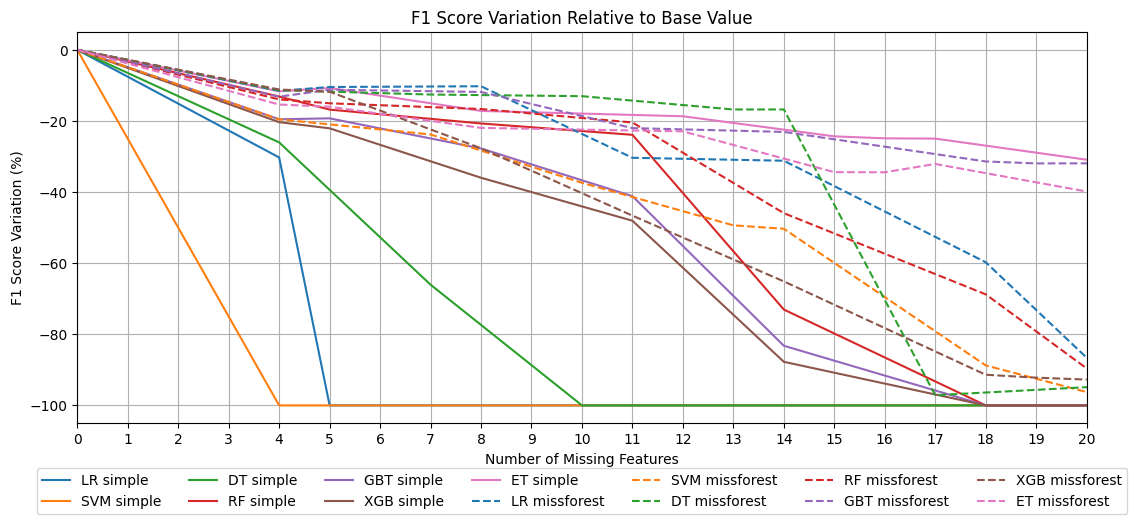

In [ ]:
# Line plot for the f1 score variation relative to the base value
plt.figure(figsize=(12, 6))
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2',
          '#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2']
linestyles = ['-', '-', '-', '-', '-', '-', '-', '--', '--', '--', '--', '--', '--', '--']

# Calculate and plot the F1-score variation for each model
for perf_df, label, color, linestyle in zip(
    [lr_perf_temp, svm_perf_temp, dt_perf_temp, rf_perf_temp, gbt_perf_temp, xgb_perf_temp, et_perf_temp,
     lr_perf_temp_mf, svm_perf_temp_mf, dt_perf_temp_mf, rf_perf_temp_mf, gbt_perf_temp_mf, xgb_perf_temp_mf, et_perf_temp_mf],
    ['LR simple', 'SVM simple', 'DT simple', 'RF simple', 'GBT simple', 'XGB simple', 'ET simple',
     'LR missforest', 'SVM missforest', 'DT missforest', 'RF missforest', 'GBT missforest', 'XGB missforest', 'ET missforest'],
    colors,
    linestyles
):
    # Calculate the variation relative to the base F1-score
    f1_variation = (perf_df['f1_score'] - perf_df['f1_score'].iloc[0]) / perf_df['f1_score'].iloc[0] * 100
    plt.plot(perf_df['num_feat_missing'], f1_variation, label=label, color=color, linestyle=linestyle)

plt.xlabel('Number of Missing Features')
plt.ylabel('F1 Score Variation (%)')
plt.title('F1 Score Variation Relative to Base Value')
plt.xticks(range(0, NUM_FEAT+1))
plt.xlim(0, NUM_FEAT)
plt.legend(loc='lower center',  bbox_to_anchor=(0.5, -0.25), ncol=7)
plt.grid(True)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

## **Balanced accuracy**

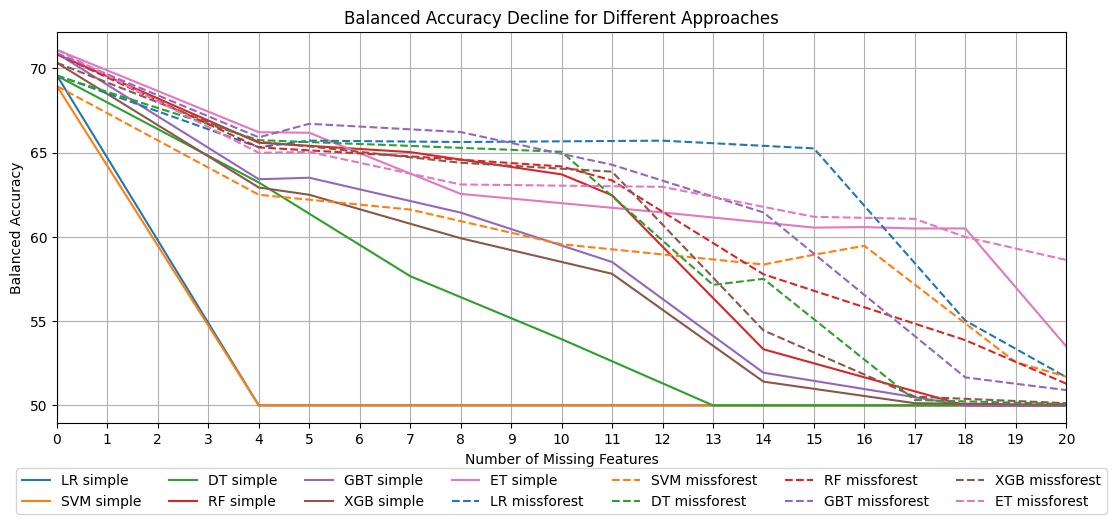

In [ ]:
# Line plot for the balanced accuracy of the different models
plt.figure(figsize=(12, 6))
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2']

plt.plot(lr2_perf_temp['num_feat_missing'], lr2_perf_temp['balanced_accuracy'], label='LR simple', color=colors[0])
plt.plot(svm2_perf_temp['num_feat_missing'], svm2_perf_temp['balanced_accuracy'], label='SVM simple', color=colors[1])
plt.plot(dt2_perf_temp['num_feat_missing'], dt2_perf_temp['balanced_accuracy'], label='DT simple', color=colors[2])
plt.plot(rf2_perf_temp['num_feat_missing'], rf2_perf_temp['balanced_accuracy'], label='RF simple', color=colors[3])
plt.plot(gbt2_perf_temp['num_feat_missing'], gbt2_perf_temp['balanced_accuracy'], label='GBT simple', color=colors[4])
plt.plot(xgb2_perf_temp['num_feat_missing'], xgb2_perf_temp['balanced_accuracy'], label='XGB simple', color=colors[5])
plt.plot(et2_perf_temp['num_feat_missing'], et2_perf_temp['balanced_accuracy'], label='ET simple', color=colors[6])

plt.plot(lr2_perf_temp_mf['num_feat_missing'], lr2_perf_temp_mf['balanced_accuracy'], label='LR missforest', color=colors[0], linestyle='--')
plt.plot(svm2_perf_temp_mf['num_feat_missing'], svm2_perf_temp_mf['balanced_accuracy'], label='SVM missforest', color=colors[1], linestyle='--')
plt.plot(dt2_perf_temp_mf['num_feat_missing'], dt2_perf_temp_mf['balanced_accuracy'], label='DT missforest', color=colors[2], linestyle='--')
plt.plot(rf2_perf_temp_mf['num_feat_missing'], rf2_perf_temp_mf['balanced_accuracy'], label='RF missforest', color=colors[3], linestyle='--')
plt.plot(gbt2_perf_temp_mf['num_feat_missing'], gbt2_perf_temp_mf['balanced_accuracy'], label='GBT missforest', color=colors[4], linestyle='--')
plt.plot(xgb2_perf_temp_mf['num_feat_missing'], xgb2_perf_temp_mf['balanced_accuracy'], label='XGB missforest', color=colors[5], linestyle='--')
plt.plot(et2_perf_temp_mf['num_feat_missing'], et2_perf_temp_mf['balanced_accuracy'], label='ET missforest', color=colors[6], linestyle='--')

plt.xlabel('Number of Missing Features')
plt.ylabel('Balanced Accuracy')
plt.title('Balanced Accuracy Decline for Different Approaches')
plt.xticks(range(0, NUM_FEAT+1))
plt.xlim(0, NUM_FEAT)
plt.legend(loc='lower center',  bbox_to_anchor=(0.5, -0.25), ncol=7)
plt.grid(True)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

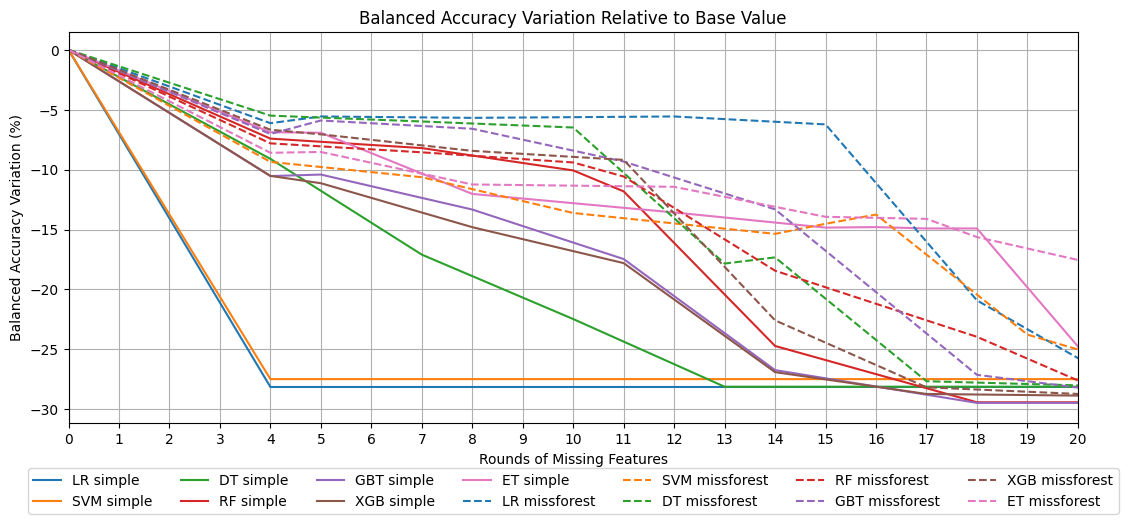

In [ ]:
# Line plot for the balanced accuracy variation relative to the base value
plt.figure(figsize=(12, 6))
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2',
          '#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2']
linestyles = ['-', '-', '-', '-', '-', '-', '-', '--', '--', '--', '--', '--', '--', '--']

# Calculate and plot the balanced accuracy variation for each model
for perf_df, label, color, linestyle in zip(
    [lr2_perf_temp, svm2_perf_temp, dt2_perf_temp, rf2_perf_temp, gbt2_perf_temp, xgb2_perf_temp, et2_perf_temp,
     lr2_perf_temp_mf, svm2_perf_temp_mf, dt2_perf_temp_mf, rf2_perf_temp_mf, gbt2_perf_temp_mf, xgb2_perf_temp_mf, et2_perf_temp_mf],
    ['LR simple', 'SVM simple', 'DT simple', 'RF simple', 'GBT simple', 'XGB simple', 'ET simple',
     'LR missforest', 'SVM missforest', 'DT missforest', 'RF missforest', 'GBT missforest', 'XGB missforest', 'ET missforest'],
    colors,
    linestyles
):
    # Calculate the variation relative to the base balanced accuracy
    balanced_accy_variation = (perf_df['balanced_accuracy'] - perf_df['balanced_accuracy'].iloc[0]) / perf_df['balanced_accuracy'].iloc[0] * 100
    plt.plot(perf_df['num_feat_missing'], balanced_accy_variation, label=label, color=color, linestyle=linestyle)

plt.xlabel('Rounds of Missing Features')
plt.ylabel('Balanced Accuracy Variation (%)')
plt.title('Balanced Accuracy Variation Relative to Base Value')
plt.xticks(range(0, NUM_FEAT+1))
plt.xlim(0, NUM_FEAT)
plt.legend(loc='lower center',  bbox_to_anchor=(0.5, -0.25), ncol=7)
plt.grid(True)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

### **Save results**

In [ ]:
dataset_dict = {
    'lr_perf': lr_perf,
    'svm_perf': svm_perf,
    'dt_perf': dt_perf,
    'rf_perf': rf_perf,
    'gbt_perf': gbt_perf,
    'xgb_perf': xgb_perf,
    'et_perf': et_perf,
    'lr_perf_mf': lr_perf_mf,
    'svm_perf_mf': svm_perf_mf,
    'dt_perf_mf': dt_perf_mf,
    'rf_perf_mf': rf_perf_mf,
    'gbt_perf_mf': gbt_perf_mf,
    'xgb_perf_mf': xgb_perf_mf,
    'et_perf_mf': et_perf_mf,
    'lr2_perf': lr2_perf,
    'svm2_perf': svm2_perf,
    'dt2_perf': dt2_perf,
    'rf2_perf': rf2_perf,
    'gbt2_perf': gbt2_perf,
    'xgb2_perf': xgb2_perf,
    'et2_perf': et2_perf,
    'lr2_perf_mf': lr2_perf_mf,
    'svm2_perf_mf': svm2_perf_mf,
    'dt2_perf_mf': dt2_perf_mf,
    'rf2_perf_mf': rf2_perf_mf,
    'gbt2_perf_mf': gbt2_perf_mf,
    'xgb2_perf_mf': xgb2_perf_mf,
    'et2_perf_mf': et2_perf_mf
}

all_data = combine_datasets(
    dataset_dict,
    'Default Credit Card', 'Scenario 2: drop intercorrelated',
    RANDOM_STATE
)
save_dataset(all_data, 'default_cc_scenario2_seed_2024.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
dataset_temp_dict = {
    'lr_perf_temp': lr_perf_temp,
    'svm_perf_temp': svm_perf_temp,
    'dt_perf_temp': dt_perf_temp,
    'rf_perf_temp': rf_perf_temp,
    'gbt_perf_temp': gbt_perf_temp,
    'xgb_perf_temp': xgb_perf_temp,
    'et_perf_temp': et_perf_temp,
    'lr_perf_temp_mf': lr_perf_temp_mf,
    'svm_perf_temp_mf': svm_perf_temp_mf,
    'dt_perf_temp_mf': dt_perf_temp_mf,
    'rf_perf_temp_mf': rf_perf_temp_mf,
    'gbt_perf_temp_mf': gbt_perf_temp_mf,
    'xgb_perf_temp_mf': xgb_perf_temp_mf,
    'et_perf_temp_mf': et_perf_temp_mf,
    'lr2_perf_temp': lr2_perf_temp,
    'svm2_perf_temp': svm2_perf_temp,
    'dt2_perf_temp': dt2_perf_temp,
    'rf2_perf_temp': rf2_perf_temp,
    'gbt2_perf_temp': gbt2_perf_temp,
    'xgb2_perf_temp': xgb2_perf_temp,
    'et2_perf_temp': et2_perf_temp,
    'lr2_perf_temp_mf': lr2_perf_temp_mf,
    'svm2_perf_temp_mf': svm2_perf_temp_mf,
    'dt2_perf_temp_mf': dt2_perf_temp_mf,
    'rf2_perf_temp_mf': rf2_perf_temp_mf,
    'gbt2_perf_temp_mf': gbt2_perf_temp_mf,
    'xgb2_perf_temp_mf': xgb2_perf_temp_mf,
    'et2_perf_temp_mf': et2_perf_temp_mf
}

all_data_temp = combine_datasets(
    dataset_temp_dict,
    'Default Credit Card Temporal', 'Scenario 2: drop intercorrelated',
    RANDOM_STATE
)
save_dataset(all_data_temp, 'default_cc_temp_scenario2_seed_2024.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
all_data

tp    tn   fp    fn  precision  recall  specificity  accuracy  f1_score  \
0    750  3862  811   577      48.05   56.52        82.64     76.87     51.94   
1    485  4169  504   842      49.04   36.55        89.21     77.57     41.88   
2    442  4214  459   885      49.06   33.31        90.18     77.60     39.68   
3    334  4351  322   993      50.91   25.17        93.11     78.08     33.69   
4    302  4365  308  1025      49.51   22.76        93.41     77.78     31.18   
..   ...   ...  ...   ...        ...     ...          ...       ...       ...   
583  328  4422  251   999      56.65   24.72        94.63     79.17     34.42   
584  327  4417  256  1000      56.09   24.64        94.52     79.07     34.24   
585  290  4464  209  1037      58.12   21.85        95.53     79.23     31.76   
586  292  4458  215  1035      57.59   22.00        95.40     79.17     31.84   
587  297  4440  233  1030      56.04   22.38        95.01     78.95     31.99   

     balanced_accuracy  num_feat_missing  \
0                69.58                 0   
1                62.88                 1   
2                61.74                 2   
3                59.14                 3   
4                58.08                 4   
..                 ...               ...   
583              59.67                16   
584              59.58                17   
585              58.69                18   
586              58.70                19   
587              58.70                20   

                                               imputed      dataset  \
0                                                           lr_perf   
1                         ['PAY_DELAY_1M_AGO'] imputed      lr_perf   
2            ['PAY_DELAY_1M_AGO', 'LIMIT_BAL'] imputed      lr_perf   
3    ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_3...      lr_perf   
4    ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_3...      lr_perf   
..                                                 ...          ...   
583  ['PAY_DELAY_1M_AGO', 'PAY_STATUS_1M_AGO_paid f...  et2_perf_mf   
584  ['PAY_DELAY_1M_AGO', 'PAY_STATUS_1M_AGO_paid f...  et2_perf_mf   
585  ['PAY_DELAY_1M_AGO', 'PAY_STATUS_1M_AGO_paid f...  et2_perf_mf   
586  ['PAY_DELAY_1M_AGO', 'PAY_STATUS_1M_AGO_paid f...  et2_perf_mf   
587  ['PAY_DELAY_1M_AGO', 'PAY_STATUS_1M_AGO_paid f...  et2_perf_mf   

                  source                          scenario  random_state  \
0    Default Credit Card  Scenario 2: drop intercorrelated          2024   
1    Default Credit Card  Scenario 2: drop intercorrelated          2024   
2    Default Credit Card  Scenario 2: drop intercorrelated          2024   
3    Default Credit Card  Scenario 2: drop intercorrelated          2024   
4    Default Credit Card  Scenario 2: drop intercorrelated          2024   
..                   ...                               ...           ...   
583  Default Credit Card  Scenario 2: drop intercorrelated          2024   
584  Default Credit Card  Scenario 2: drop intercorrelated          2024   
585  Default Credit Card  Scenario 2: drop intercorrelated          2024   
586  Default Credit Card  Scenario 2: drop intercorrelated          2024   
587  Default Credit Card  Scenario 2: drop intercorrelated          2024   

                metric  
0             f1 score  
1             f1 score  
2             f1 score  
3             f1 score  
4             f1 score  
..                 ...  
583  balanced accuracy  
584  balanced accuracy  
585  balanced accuracy  
586  balanced accuracy  
587  balanced accuracy  

[588 rows x 17 columns]

In [ ]:
all_data_temp

tp    tn    fp    fn  precision  recall  specificity  accuracy  \
0     750  3862   811   577      48.05   56.52        82.64     76.87   
1    1327     0  4673     0      22.12  100.00         0.00     22.12   
2       0  4673     0  1327       0.00    0.00       100.00     77.88   
3       0  4673     0  1327       0.00    0.00       100.00     77.88   
4       0  4673     0  1327       0.00    0.00       100.00     77.88   
..    ...   ...   ...   ...        ...     ...          ...       ...   
231   393  4335   338   934      53.76   29.62        92.77     78.80   
232   392  4333   340   935      53.55   29.54        92.72     78.75   
233   386  4348   325   941      54.29   29.09        93.05     78.90   
234   341  4406   267   986      56.09   25.70        94.29     79.12   
235   276  4444   229  1051      54.65   20.80        95.10     78.67   

     f1_score  balanced_accuracy  num_feat_missing  \
0       51.94              69.58                 0   
1       36.22              50.00                 4   
2        0.00              50.00                 5   
3        0.00              50.00                 8   
4        0.00              50.00                11   
..        ...                ...               ...   
231     38.19              61.19                15   
232     38.08              61.13                16   
233     37.88              61.07                17   
234     35.25              59.99                18   
235     30.13              57.95                21   

                                               imputed           dataset  \
0                                                           lr_perf_temp   
1    ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...      lr_perf_temp   
2    ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...      lr_perf_temp   
3    ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...      lr_perf_temp   
4    ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...      lr_perf_temp   
..                                                 ...               ...   
231  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  et2_perf_temp_mf   
232  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  et2_perf_temp_mf   
233  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  et2_perf_temp_mf   
234  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  et2_perf_temp_mf   
235  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  et2_perf_temp_mf   

                           source                          scenario  \
0    Default Credit Card Temporal  Scenario 2: drop intercorrelated   
1    Default Credit Card Temporal  Scenario 2: drop intercorrelated   
2    Default Credit Card Temporal  Scenario 2: drop intercorrelated   
3    Default Credit Card Temporal  Scenario 2: drop intercorrelated   
4    Default Credit Card Temporal  Scenario 2: drop intercorrelated   
..                            ...                               ...   
231  Default Credit Card Temporal  Scenario 2: drop intercorrelated   
232  Default Credit Card Temporal  Scenario 2: drop intercorrelated   
233  Default Credit Card Temporal  Scenario 2: drop intercorrelated   
234  Default Credit Card Temporal  Scenario 2: drop intercorrelated   
235  Default Credit Card Temporal  Scenario 2: drop intercorrelated   

     random_state             metric  
0            2024           f1 score  
1            2024           f1 score  
2            2024           f1 score  
3            2024           f1 score  
4            2024           f1 score  
..            ...                ...  
231          2024  balanced accuracy  
232          2024  balanced accuracy  
233          2024  balanced accuracy  
234          2024  balanced accuracy  
235          2024  balanced accuracy  

[236 rows x 17 columns]